In [ ]:
# excir_mcir_experiments.py
# ------------------------------------------------------------
# ExCIR/MCIR end-to-end experiments:
# - HouseEnergy-Sim (regression)
# - UCI HAR classification (optional: point har_root to dataset)
# - PCIR (independent/weak dependence)
# - MCIR (mutual dependence; bounded [0,1]) via Gaussian-copula CMI
# - Lightweight fidelity split, bootstrap bands, rank overlays
# ------------------------------------------------------------

import os
import json
import math
import random
import warnings
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

import numpy as np
import pandas as pd
from scipy.stats import rankdata, norm
from scipy.linalg import cholesky, LinAlgError
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=FutureWarning)
np.set_printoptions(precision=4, suppress=True)

# -------------------------------
# Utils
# -------------------------------

def ensure_dir(path: str) -> str:
    os.makedirs(path, exist_ok=True)
    return path

def gaussianize(u: np.ndarray) -> np.ndarray:
    """
    Rank-Gaussianize each column of u to approximate Gaussian copula marginals.
    Returns Z with same shape, each column ~ N(0,1).
    """
    Z = np.empty_like(u, dtype=float)
    n = u.shape[0]
    for j in range(u.shape[1]):
        ranks = rankdata(u[:, j], method="average")
        # map to (0,1) then to N(0,1)
        p = (ranks - 0.5) / n
        z = norm.ppf(np.clip(p, 1e-6, 1 - 1e-6))
        Z[:, j] = (z - np.mean(z)) / (np.std(z) + 1e-12)
    return Z

def multiple_correlation_R2(y: np.ndarray, X: np.ndarray, cv: bool = True) -> float:
    """
    Approximate multiple R^2 between scalar y and (possibly multivariate) X.
    Uses RidgeCV (with small grid) by default to improve stability.
    """
    y = y.reshape(-1, 1)
    scaler_X = StandardScaler()
    Xs = scaler_X.fit_transform(X)

    if cv and X.shape[1] > 0:
        alphas = np.logspace(-3, 2, 10)
        model = RidgeCV(alphas=alphas, fit_intercept=True, store_cv_values=False)
        model.fit(Xs, y.ravel())
        y_hat = model.predict(Xs)
    elif X.shape[1] > 0:
        model = Ridge(alpha=1.0, fit_intercept=True)
        model.fit(Xs, y.ravel())
        y_hat = model.predict(Xs)
    else:
        # No predictors
        y_hat = np.repeat(np.mean(y), len(y))

    ss_res = np.sum((y.ravel() - y_hat) ** 2)
    ss_tot = np.sum((y.ravel() - np.mean(y)) ** 2) + 1e-12
    R2 = max(0.0, 1.0 - ss_res / ss_tot)
    return float(R2)

def conditional_mi_gaussian_copula(y: np.ndarray, x: np.ndarray, Z: np.ndarray) -> float:
    """
    Gaussian-copula Conditional Mutual Information I(y; x | Z).
    Strategy:
      1) Regress y ~ Z and x ~ Z (Ridge), take residuals ry, rx.
      2) Rank-Gaussianize residuals to ~N(0,1) (copula marginals).
      3) Compute rho = corr(ry_g, rx_g).
      4) I = -0.5 * log(1 - rho^2)  (Gaussian formula).
    """
    y = y.reshape(-1, 1)
    x = x.reshape(-1, 1)
    n = len(y)

    if Z is None or Z.shape[1] == 0:
        # Then it's just the unconditional MI
        ry = y.ravel()
        rx = x.ravel()
    else:
        scaler = StandardScaler()
        Zs = scaler.fit_transform(Z)
        ry = y.ravel() - Ridge(alpha=1.0, fit_intercept=True).fit(Zs, y).predict(Zs).ravel()
        rx = x.ravel() - Ridge(alpha=1.0, fit_intercept=True).fit(Zs, x).predict(Zs).ravel()

    # Rank-Gaussianize the residuals
    R = np.vstack([ry, rx]).T
    Rg = gaussianize(R)
    rho = np.corrcoef(Rg.T)[0, 1]
    rho = np.clip(rho, -0.999999, 0.999999)

    mi = -0.5 * np.log(1.0 - rho ** 2 + 1e-12)
    return float(max(0.0, mi))

def joint_mi_gaussian_copula(y: np.ndarray, Z: np.ndarray) -> float:
    """
    Approximate I(y; Z) by Gaussian-copula multi-information:
    - Rank-Gaussianize [y, Z]
    - Estimate multiple R^2 via ridge: y ~ Z
    - I = -0.5 * log(1 - R^2)
    """
    y = y.reshape(-1, 1)
    if Z is None or Z.shape[1] == 0:
        return 0.0

    YZ = np.concatenate([y, Z], axis=1)
    YZ_g = gaussianize(YZ)
    yg = YZ_g[:, [0]].ravel()
    Zg = YZ_g[:, 1:]
    R2 = multiple_correlation_R2(yg, Zg, cv=True)
    I = -0.5 * np.log(1.0 - np.clip(R2, 0.0, 0.999999) + 1e-12)
    return float(max(0.0, I))

def mcir_score(y: np.ndarray, x: np.ndarray, Z: np.ndarray) -> float:
    """
    MCIR = I(y; x | Z) / (I(y; x | Z) + I(y; [Z, x]))
    """
    I_cond = conditional_mi_gaussian_copula(y, x, Z)
    Zx = x.reshape(-1, 1) if Z is None or Z.shape[1] == 0 else np.column_stack([Z, x.reshape(-1, 1)])
    I_joint = joint_mi_gaussian_copula(y, Zx)
    denom = I_cond + I_joint
    if denom <= 1e-12:
        return 0.0
    return float(np.clip(I_cond / denom, 0.0, 1.0))

# -------------------------------
# PCIR
# -------------------------------

def pcir_feature(y: np.ndarray, f: np.ndarray) -> float:
    """
    PCIR per your Eq.(5)-style definition (bounded in [0,1]):
      eta = [ n' * ((f_bar - m)^2 + (y_bar - m)^2) ] / [ sum_j (f_j - m)^2 + sum_j (y_j - m)^2 ],
      where m = (f_bar + y_bar)/2
    """
    f = f.ravel()
    y = y.ravel()
    n = len(y)
    f_bar = np.mean(f)
    y_bar = np.mean(y)
    m = 0.5 * (f_bar + y_bar)
    num = n * ((f_bar - m) ** 2 + (y_bar - m) ** 2)
    den = np.sum((f - m) ** 2) + np.sum((y - m) ** 2) + 1e-12
    eta = num / den
    return float(np.clip(eta, 0.0, 1.0))

def pcir_all(y: np.ndarray, X: np.ndarray, feature_names: List[str]) -> pd.Series:
    scores = {}
    for j, name in enumerate(feature_names):
        scores[name] = pcir_feature(y, X[:, j])
    return pd.Series(scores).sort_values(ascending=False)

# -------------------------------
# Blocks and conditioning set Φ
# -------------------------------

import numpy as np
from typing import List, Optional
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

# --- utility: abs-corr with safety ---
def pairwise_abs_corr(X: np.ndarray) -> np.ndarray:
    Xc = X - X.mean(axis=0, keepdims=True)
    denom = np.sqrt((Xc**2).sum(axis=0, keepdims=True))
    denom[denom == 0] = 1.0
    Xn = Xc / denom
    C = np.abs(Xn.T @ Xn) / X.shape[0]
    np.fill_diagonal(C, 1.0)
    return C

# --- NEW: sanitize blocks to the current feature dimension d ---
def sanitize_blocks(blocks: List[List[int]], d: int) -> List[List[int]]:
    """Clip indices to [0, d-1], drop dupes/empties, sort."""
    clean = []
    seen_sets = set()
    for b in blocks:
        b2 = sorted({idx for idx in b if 0 <= idx < d})
        if not b2:
            continue
        key = tuple(b2)
        if key not in seen_sets:
            seen_sets.add(key)
            clean.append(b2)
    # if everything got filtered out, fall back to single block of all features
    if not clean:
        clean = [list(range(d))]
    return clean

# --- PATCHED: build blocks; returns sanitized blocks ---
def build_blocks_from_corr(X: np.ndarray,
                           min_block_size: int = 3,
                           corr_quantile: float = 0.85,
                           random_state: int = 0) -> List[List[int]]:
    rng = np.random.RandomState(random_state)
    d = X.shape[1]
    S = pairwise_abs_corr(X)
    np.fill_diagonal(S, 1.0)

    # simple heuristic for #clusters
    thr = np.quantile(S[np.triu_indices(d, 1)], corr_quantile)
    graph_deg = (S > thr).sum(axis=1)
    k_est = max(1, int(np.ceil(d / max(3, float(np.median(graph_deg))))))

    k_est = min(k_est, max(1, d // max(1, min_block_size)))
    k_est = max(1, k_est)

    # cluster on standardized features; ward implies Euclidean
    X_std = StandardScaler().fit_transform(X)
    clustering = AgglomerativeClustering(n_clusters=k_est, linkage='ward')
    labels = clustering.fit_predict(X_std)

    # initial blocks
    blocks = [sorted(np.where(labels == lab)[0].tolist()) for lab in np.unique(labels)]

    # merge too-small blocks into nearest larger block by average corr
    large = [b for b in blocks if len(b) >= min_block_size]
    small = [b for b in blocks if len(b) < min_block_size]

    for b in small:
        if not large:
            large.append(b)
            continue
        best_idx, best_val = 0, -1.0
        for li, L in enumerate(large):
            cross = S[np.ix_(b, L)]
            val = float(np.mean(cross)) if cross.size else -1.0
            if val > best_val:
                best_val, best_idx = val, li
        large[best_idx] = sorted(list(set(large[best_idx] + b)))

    blocks = [sorted(b) for b in large]
    # FINAL: sanitize against current d
    return sanitize_blocks(blocks, d)

# --- PATCHED: robust conditioning set selection ---
def choose_phi_for_feature(X: np.ndarray,
                           i: int,
                           blocks: Optional[List[List[int]]] = None,
                           m_phi: int = 6) -> List[int]:
    """
    Returns a small conditioning set Phi for feature i.
    - Intersects provided blocks with valid indices [0..d-1]
    - If the in-block neighborhood is too small, tops up with global nearest neighbors by |corr|
    - Never returns i; size <= m_phi
    """
    d = X.shape[1]
    S = pairwise_abs_corr(X)
    np.fill_diagonal(S, 0.0)  # exclude self for top-k selection

    # sanitize/derive blocks
    if blocks is not None:
        blocks = sanitize_blocks(blocks, d)
    else:
        # fallback: one block with all features
        blocks = [list(range(d))]

    # map feature -> block id safely
    block_of = np.full(d, -1, dtype=int)
    for b_idx, b in enumerate(blocks):
        for idx in b:
            if 0 <= idx < d:
                block_of[idx] = b_idx

    # pick candidates from i's block (excluding i)
    bidx = block_of[i] if (0 <= i < d) else -1
    if bidx >= 0:
        in_block = [j for j in blocks[bidx] if j != i]
    else:
        in_block = [j for j in range(d) if j != i]

    # take up to m_phi from in-block by highest |corr|
    if in_block:
        order = np.argsort(-S[i, in_block])
        phi = [in_block[idx] for idx in order[:m_phi]]
    else:
        phi = []

    # top up with global nearest neighbors if needed
    if len(phi) < m_phi:
        exclude = set(phi + [i])
        remaining = [j for j in range(d) if j not in exclude]
        if remaining:
            order2 = np.argsort(-S[i, remaining])
            need = m_phi - len(phi)
            phi += [remaining[idx] for idx in order2[:need]]

    # final safety: unique, in range, not i, max m_phi
    phi = [j for j in sorted(set(phi)) if 0 <= j < d and j != i][:m_phi]
    return phi


def pairwise_abs_corr(X: np.ndarray) -> np.ndarray:
    C = np.corrcoef(X, rowvar=False)
    return np.abs(C)

def build_blocks_from_corr(X: np.ndarray,
                           min_block_size: int = 3,
                           corr_quantile: float = 0.85,
                           random_state: int = 0) -> List[List[int]]:
    """
    Build correlated blocks:
      - similarity S = |corr|
      - distance D = 1 - S
      - Agglomerative clustering with #clusters chosen via a crude heuristic
      - merge small clusters if needed
    """
    rng = np.random.RandomState(random_state)
    d = X.shape[1]
    S = pairwise_abs_corr(X)
    np.fill_diagonal(S, 1.0)
    D = 1.0 - S

    # crude heuristic for number of clusters based on high-corr count
    thr = np.quantile(S[np.triu_indices(d, 1)], corr_quantile)
    graph_deg = (S > thr).sum(axis=1)
    k_est = max(1, int(np.ceil(d / max(3, np.median(graph_deg)))))

    k_est = min(k_est, max(1, d // min_block_size))
    if k_est < 1:
        k_est = 1

    # Agglomerative on standardized X; for linkage='ward', Euclidean is implied.
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import AgglomerativeClustering

    X_std = StandardScaler().fit_transform(X)
    clustering = AgglomerativeClustering(
        n_clusters=k_est,
        linkage='ward'   # NOTE: drop 'affinity'/'metric' — ward uses Euclidean implicitly
    )
    labels = clustering.fit_predict(X_std)

    blocks = []
    for lab in np.unique(labels):
        idxs = np.where(labels == lab)[0].tolist()
        blocks.append(idxs)

    # Merge too-small blocks into nearest (by mean corr) larger block
    small = [b for b in blocks if len(b) < min_block_size]
    large = [b for b in blocks if len(b) >= min_block_size]

    for b in small:
        if not large:
            large.append(b)
            continue
        # pick large block with highest average cross-corr
        best_idx, best_val = 0, -1
        for li, L in enumerate(large):
            cross = S[np.ix_(b, L)]
            val = np.mean(cross)
            if val > best_val:
                best_val, best_idx = val, li
        large[best_idx] = large[best_idx] + b

    blocks = [sorted(b) for b in large]
    return blocks

def choose_phi_for_feature(X: np.ndarray,
                           i: int,
                           blocks: List[List[int]],
                           m_phi: int = 5) -> List[int]:
    """
    Choose Φ for feature i as up to m_phi nearest neighbours inside its block
    by absolute correlation.
    """
    d = X.shape[1]
    # map feature -> its block id
    block_of = np.full(d, -1, dtype=int)
    for b_idx, b in enumerate(blocks):
        for idx in b:
            block_of[idx] = b_idx
    bidx = block_of[i]
    in_block = [j for j in blocks[bidx] if j != i]

    if len(in_block) == 0:
        return []

    S = pairwise_abs_corr(X)
    nbrs = sorted(in_block, key=lambda j: -S[i, j])[:m_phi]
    return nbrs

# -------------------------------
# Synthetic: HouseEnergy-Sim
# -------------------------------

def simulate_houseenergy(n: int = 4000,
                         seed: int = 0) -> Tuple[pd.DataFrame, np.ndarray]:
    """
    Simulate realistic appliance/schedule features with dependence,
    and a nonlinear target (energy / HVAC-like load).
    """
    rng = np.random.RandomState(seed)

    # Schedules / calendar
    Hour = rng.randint(0, 24, size=n)
    Weekday = rng.randint(0, 7, size=n)
    Outdoor_temp = rng.normal(15, 10, size=n)  # deg C
    Solar_irradiance = np.maximum(0, rng.normal(500, 250, size=n))  # W/m^2

    # Occupancy-like latent
    Occupancy = (rng.beta(2, 5, size=n) * 4).astype(int)  # 0..3 people

    # Appliances (correlated)
    Base_load = rng.normal(0.8, 0.1, size=n)
    Fridge = np.clip(0.3 + 0.05 * rng.normal(size=n), 0.1, 0.6)
    TV_power = np.clip((Hour >= 18).astype(float) * rng.normal(0.4, 0.1, size=n), 0, None)
    Computer_power = np.clip((Hour >= 9).astype(float) * rng.normal(0.25, 0.1, size=n), 0, None)
    Game_console = np.clip((Hour >= 17).astype(float) * rng.normal(0.2, 0.1, size=n), 0, None)
    Lighting = np.clip(((Hour <= 6) | (Hour >= 18)).astype(float) *
                       rng.normal(0.3, 0.1, size=n), 0, None)

    # Water-related
    Water_heater = np.clip((Hour >= 6).astype(float) * rng.normal(0.6, 0.2, size=n), 0, None)
    Washing_machine = np.clip((Weekday >= 5).astype(float) * rng.normal(0.5, 0.2, size=n), 0, None)
    Dishwasher = np.clip((Hour >= 19).astype(float) * rng.normal(0.45, 0.15, size=n), 0, None)

    # HVAC-like: driven by Outdoor temp, windows, occupancy
    Window_open = (rng.rand(n) < norm.cdf(Outdoor_temp, 18, 5)).astype(float)
    HVAC_load = np.clip(
        (np.maximum(0, 22 - Outdoor_temp) * (1 - Window_open) * rng.uniform(0.8, 1.2, size=n) +
         np.maximum(0, Outdoor_temp - 26) * Window_open * rng.uniform(0.6, 1.1, size=n)) / 30.0,
        0, None
    )
    Space_heater = np.clip((Outdoor_temp < 12).astype(float) * rng.normal(0.7, 0.25, size=n), 0, None)
    Dryer = np.clip((Weekday >= 5).astype(float) * rng.normal(0.55, 0.2, size=n), 0, None)

    # Sine/cos time encodings
    Hour_sin = np.sin(2 * np.pi * Hour / 24)
    Hour_cos = np.cos(2 * np.pi * Hour / 24)

    # Feature matrix with meaningful names
    data = pd.DataFrame({
        "Hour": Hour, "Weekday": Weekday, "Outdoor_temp": Outdoor_temp,
        "Solar_irradiance": Solar_irradiance, "Occupancy": Occupancy,
        "Base_load": Base_load, "Fridge": Fridge, "TV_power": TV_power,
        "Computer_power": Computer_power, "Game_console": Game_console,
        "Lighting": Lighting, "Water_heater": Water_heater,
        "Washing_machine": Washing_machine, "Dishwasher": Dishwasher,
        "Window_open": Window_open, "HVAC_load": HVAC_load,
        "Space_heater": Space_heater, "Dryer": Dryer,
        "Hour_sin": Hour_sin, "Hour_cos": Hour_cos,
    })

    # Nonlinear target: energy consumption surrogate
    y = (
        0.7 * Base_load
        + 0.4 * Fridge
        + 1.2 * TV_power
        + 1.0 * Computer_power
        + 0.9 * Lighting
        + 0.8 * Water_heater
        + 0.9 * Washing_machine
        + 0.7 * Dishwasher
        + 1.1 * HVAC_load
        + 1.0 * Space_heater
        + 0.6 * Dryer
        + 0.1 * (Hour_sin + 0.5 * Hour_cos)
        + 0.05 * Occupancy
        - 0.4 * Solar_irradiance / 1000.0
        + 0.2 * Window_open
        + rng.normal(0, 0.3, size=n)
    )
    return data, y

# -------------------------------
# Lightweight fidelity split
# -------------------------------

@dataclass
class ModelPair:
    model_full: object
    model_light: object
    yhat_full: np.ndarray
    yhat_light: np.ndarray

def train_regressors_lightweight(X: np.ndarray, y: np.ndarray,
                                 frac_light: float = 0.25,
                                 seed: int = 0) -> Tuple[ModelPair, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Train RF on full data and on a lightweight subsample (for attribution).
    """
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=seed)
    # full
    rf_full = RandomForestRegressor(n_estimators=300, random_state=seed, n_jobs=-1)
    rf_full.fit(X_tr, y_tr)
    yhat_full = rf_full.predict(X_te)

    # lightweight sample from the *train* set
    X_tr_light, _, y_tr_light, _ = train_test_split(X_tr, y_tr, test_size=1.0 - frac_light, random_state=seed)
    rf_light = RandomForestRegressor(n_estimators=300, random_state=seed + 1, n_jobs=-1)
    rf_light.fit(X_tr_light, y_tr_light)
    yhat_light = rf_light.predict(X_te)
    return ModelPair(rf_full, rf_light, yhat_full, yhat_light), X_te, y_te, X_tr_light, y_tr_light

# -------------------------------
# MCIR computation (per feature)
# -------------------------------

def compute_mcir_all(X: np.ndarray,
                     y: np.ndarray,
                     feature_names: List[str],
                     m_phi: int = 5,
                     min_block: int = 3,
                     seed: int = 0) -> pd.Series:
    """
    Pipeline: blocks -> Φ -> MCIR per feature (bounded [0,1])
    """
    blocks = build_blocks_from_corr(X, min_block_size=min_block, random_state=seed)
    d = X.shape[1]
    scores = {}
    for i in range(d):
        phi_idx = choose_phi_for_feature(X, i, blocks, m_phi=m_phi)
        Z = X[:, phi_idx] if len(phi_idx) > 0 else None
        scores[feature_names[i]] = mcir_score(y, X[:, i], Z)
    return pd.Series(scores).sort_values(ascending=False)

# -------------------------------
# Bootstrap uncertainty
# -------------------------------

def bootstrap_scores(
    scorer_fun,
    X: np.ndarray,
    y: np.ndarray,
    feature_names: List[str],
    B: int = 50,
    seed: int = 0,
    **kwargs
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns:
      mean_scores: pd.Series
      bands: pd.DataFrame with 'lower','upper' (e.g., 5th/95th)
    """
    rng = np.random.RandomState(seed)
    all_scores = []
    n = len(y)
    for b in range(B):
        idx = rng.randint(0, n, size=n)
        Xb, yb = X[idx], y[idx]
        s = scorer_fun(Xb, yb, feature_names, **kwargs)
        all_scores.append(s.reindex(feature_names))  # preserve order
    S = pd.concat(all_scores, axis=1)
    mean_scores = S.mean(axis=1).sort_values(ascending=False)
    lower = S.quantile(0.05, axis=1)
    upper = S.quantile(0.95, axis=1)
    bands = pd.DataFrame({"lower": lower, "upper": upper}).loc[mean_scores.index]
    return mean_scores, bands

# -------------------------------
# Plots
# -------------------------------

def plot_rank_overlay(pcir: pd.Series, mcir: pd.Series, outpath: str, top_k: int = 30):
    names = list(pcir.index)
    # align to common set
    common = [n for n in names if n in mcir.index]
    pc = pcir.loc[common]
    mc = mcir.loc[common]
    # ranks
    r_p = pc.rank(ascending=False, method="average")
    r_m = mc.rank(ascending=False, method="average")

    # select top_k by average rank
    avg_rank = (r_p + r_m) / 2.0
    keep = avg_rank.nsmallest(min(top_k, len(avg_rank))).index
    rp_k = r_p.loc[keep]
    rm_k = r_m.loc[keep]

    plt.figure(figsize=(7.2, 5.2))
    plt.scatter(rp_k, rm_k)
    for n in keep:
        plt.annotate(n, (rp_k[n], rm_k[n]), fontsize=8, alpha=0.8)
    lim = [0, max(rp_k.max(), rm_k.max()) + 1]
    plt.plot(lim, lim, linestyle="--")
    plt.xlabel("Rank by PCIR (lower is more important)")
    plt.ylabel("Rank by MCIR (lower is more important)")
    plt.title("PCIR vs MCIR rank overlay (top-{} by avg rank)".format(len(keep)))
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.close()

def plot_bands(bands: pd.DataFrame, mean_scores: pd.Series, outpath: str, top_k: int = 20, title: str = ""):
    idx = mean_scores.index[:top_k]
    mu = mean_scores.values[:top_k]
    lo = bands.loc[idx, "lower"].values
    hi = bands.loc[idx, "upper"].values

    x = np.arange(len(idx))
    plt.figure(figsize=(7.6, 4.6))
    plt.errorbar(x, mu, yerr=[mu - lo, hi - mu], fmt='o')
    plt.xticks(x, idx, rotation=65, ha='right')
    plt.ylabel("Score")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(outpath, dpi=220)
    plt.close()

# -------------------------------
# HAR classification (optional)
# -------------------------------

def load_har(har_root: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, List[str]]:
    """
    Load UCI HAR Dataset (pre-processed features, 561 dims).
    Expect files:
      har_root/
        train/X_train.txt, train/y_train.txt
        test/X_test.txt,  test/y_test.txt
        features.txt
    Returns binary target: class==1 vs others (for demonstration).
    """
    X_train = np.loadtxt(os.path.join(har_root, "train", "X_train.txt"))
    y_train = np.loadtxt(os.path.join(har_root, "train", "y_train.txt")).astype(int)
    X_test = np.loadtxt(os.path.join(har_root, "test", "X_test.txt"))
    y_test = np.loadtxt(os.path.join(har_root, "test", "y_test.txt")).astype(int)
    feats = pd.read_csv(os.path.join(har_root, "features.txt"), sep=r"\s+", header=None, names=["idx", "name"])
    feature_names = feats["name"].tolist()

    # binary: class 1 vs others
    y_train_bin = (y_train == 1).astype(int)
    y_test_bin = (y_test == 1).astype(int)
    return X_train, y_train_bin, X_test, y_test_bin, feature_names

def run_har_classification(
    har_root: str,
    frac_light: float = 0.25,
    seed: int = 0,
    B_boot: int = 20,
    top_k_plot: int = 20,
    outdir: str = "./excir_mcir_outputs"
) -> Dict:
    ensure_dir(outdir)
    X_tr, y_tr, X_te, y_te, feature_names = load_har(har_root)

    # Fit classifier on full train
    clf_full = RandomForestClassifier(n_estimators=400, random_state=seed, n_jobs=-1)
    clf_full.fit(X_tr, y_tr)
    prob_full = clf_full.predict_proba(X_te)[:, 1]
    y_pred = (prob_full >= 0.5).astype(int)
    acc = accuracy_score(y_te, y_pred)
    auc = roc_auc_score(y_te, prob_full)

    # Lightweight subset from train
    X_tr_light, _, y_tr_light, _ = train_test_split(X_tr, y_tr, test_size=1.0 - frac_light, random_state=seed)
    clf_light = RandomForestClassifier(n_estimators=400, random_state=seed + 1, n_jobs=-1)
    clf_light.fit(X_tr_light, y_tr_light)
    prob_light = clf_light.predict_proba(X_te)[:, 1]

    # Attribution on LIGHTWEIGHT data: we explain prob_light on the *test* features for convenience
    # For attribution we use X_te & prob_light (as continuous output)
    y_attr = prob_light

    # PCIR/MCIR
    pcir = pcir_all(y_attr, X_te, feature_names)
    mcir = compute_mcir_all(X_te, y_attr, feature_names, m_phi=7, min_block=5, seed=seed)

    # Bootstrap bands (on test set for demo)
    mean_mcir, bands_mcir = bootstrap_scores(lambda Xb, yb, names: compute_mcir_all(Xb, yb, names, m_phi=7, min_block=5, seed=seed),
                                             X_te, y_attr, feature_names, B=B_boot, seed=seed)
    mean_pcir, bands_pcir = bootstrap_scores(lambda Xb, yb, names: pcir_all(yb, Xb, names),
                                             X_te, y_attr, feature_names, B=B_boot, seed=seed)

    # Plots
    plot_rank_overlay(pcir, mcir, os.path.join(outdir, "har_rank_overlay.png"), top_k=top_k_plot)
    plot_bands(bands_mcir, mean_mcir, os.path.join(outdir, "har_mcir_bootstrap.png"), top_k=top_k_plot, title="HAR: MCIR (bootstrap bands)")
    plot_bands(bands_pcir, mean_pcir, os.path.join(outdir, "har_pcir_bootstrap.png"), top_k=top_k_plot, title="HAR: PCIR (bootstrap bands)")

    # Save CSV
    df_scores = pd.DataFrame({
        "feature": feature_names,
        "PCIR": pcir.reindex(feature_names).values,
        "MCIR": mcir.reindex(feature_names).values
    })
    df_scores.to_csv(os.path.join(outdir, "har_scores.csv"), index=False)

    return {
        "har_scores_csv": os.path.join(outdir, "har_scores.csv"),
        "har_overlay_plot": os.path.join(outdir, "har_rank_overlay.png"),
        "har_mcir_bands": os.path.join(outdir, "har_mcir_bootstrap.png"),
        "har_pcir_bands": os.path.join(outdir, "har_pcir_bootstrap.png"),
        "acc_full": float(acc),
        "auc_full": float(auc),
        "n_features": len(feature_names),
        "n_lightweight_train": int(X_tr_light.shape[0]),
    }

# -------------------------------
# Synthetic experiment runner
# -------------------------------

def run_houseenergy(
    n: int = 4000,
    frac_light: float = 0.25,
    m_phi: int = 5,
    min_block: int = 3,
    B_boot: int = 40,
    seed: int = 7,
    outdir: str = "./excir_mcir_outputs",
    top_k_plot: int = 20
) -> Dict:
    ensure_dir(outdir)
    data, y = simulate_houseenergy(n=n, seed=seed)
    feature_names = list(data.columns)
    X = data.values.astype(float)

    # Regressors full vs light
    mp, X_te, y_te, X_light, y_light = train_regressors_lightweight(X, y, frac_light=frac_light, seed=seed)
    r2_full = r2_score(y_te, mp.yhat_full)
    rmse_full = math.sqrt(mean_squared_error(y_te, mp.yhat_full))
    r2_light = r2_score(y_te, mp.yhat_light)
    rmse_light = math.sqrt(mean_squared_error(y_te, mp.yhat_light))

    # Attribution on LIGHTWEIGHT subset (observation-driven cost)
    # Use the trained lightweight model to produce scores on X_light itself:
    y_attr = mp.model_light.predict(X_light)

    # PCIR & MCIR
    pcir = pcir_all(y_attr, X_light, feature_names)
    mcir = compute_mcir_all(X_light, y_attr, feature_names, m_phi=m_phi, min_block=min_block, seed=seed)

    # Bootstrap bands
    mean_mcir, bands_mcir = bootstrap_scores(
        lambda Xb, yb, names: compute_mcir_all(Xb, yb, names, m_phi=m_phi, min_block=min_block, seed=seed),
        X_light, y_attr, feature_names, B=B_boot, seed=seed
    )
    mean_pcir, bands_pcir = bootstrap_scores(
        lambda Xb, yb, names: pcir_all(yb, Xb, names),
        X_light, y_attr, feature_names, B=B_boot, seed=seed
    )

    # Plots
    plot_rank_overlay(pcir, mcir, os.path.join(outdir, "rank_overlay_pcir_vs_mcir.png"), top_k=top_k_plot)
    plot_bands(bands_mcir, mean_mcir, os.path.join(outdir, "mcir_bootstrap_topk.png"),
               top_k=top_k_plot, title="HouseEnergy-Sim: MCIR (bootstrap bands)")
    plot_bands(bands_pcir, mean_pcir, os.path.join(outdir, "pcir_bootstrap_topk.png"),
               top_k=top_k_plot, title="HouseEnergy-Sim: PCIR (bootstrap bands)")

    # Save scores CSV
    df_scores = pd.DataFrame({
        "feature": feature_names,
        "PCIR": pcir.reindex(feature_names).values,
        "MCIR": mcir.reindex(feature_names).values
    })
    csv_path = os.path.join(outdir, "houseenergy_scores.csv")
    df_scores.to_csv(csv_path, index=False)

    # Also write a tiny LaTeX toy table (5-row demo)
    toy_tex = r"""
\begin{table}[h!]
\centering
\caption{Toy dataset (5 rows) and qualitative PCIR outcomes (aligned features co-vary with $y'$).}
\label{tab:pcir_toy_compact}
\setlength{\tabcolsep}{4pt}
\renewcommand{\arraystretch}{0.92}
\begin{tabular}{@{}c|ccc|c@{}}
\toprule
$j$ & $f_{j1}$ & $f_{j2}$ & $f_{j3}$ & $y'_j$ \\
\midrule
1 & 1.00 & 0.90 & 0.30 & 1.10 \\
2 & 1.50 & 1.40 & 0.10 & 1.60 \\
3 & 0.70 & 0.80 & 0.40 & 0.80 \\
4 & 1.20 & 1.10 & 0.20 & 1.30 \\
5 & 0.90 & 1.00 & 0.50 & 1.00 \\
\midrule
\multicolumn{5}{l}{\footnotesize PCIR: $\eta_{f_1}\approx \eta_{f_2}\gg \eta_{f_3}\approx 0$.} \\
\bottomrule
\end{tabular}
\end{table}
"""
    tex_path = os.path.join(outdir, "toy_pcir_table.tex")
    with open(tex_path, "w") as f:
        f.write(toy_tex)

    return {
        "full_model": {"r2": r2_full, "rmse": rmse_full},
        "light_model": {"r2": r2_light, "rmse": rmse_light},
        "csv_scores": csv_path,
        "plot_overlay": os.path.join(outdir, "rank_overlay_pcir_vs_mcir.png"),
        "plot_mcir_bands": os.path.join(outdir, "mcir_bootstrap_topk.png"),
        "plot_pcir_bands": os.path.join(outdir, "pcir_bootstrap_topk.png"),
        "top_features_mcir": mcir.index.tolist()[:20],
        "top_features_pcir": pcir.index.tolist()[:20],
        "n_features": X.shape[1],
        "n_lightweight": X_light.shape[0],
        "toy_table_tex": tex_path,
    }

# -------------------------------
# Main (example usage)
# -------------------------------

if __name__ == "__main__":
    outdir = ensure_dir("./excir_mcir_outputs")

    print("Running HouseEnergy-Sim experiment (with bootstrap bands)...")
    res_syn = run_houseenergy(n=4000, frac_light=0.25, m_phi=6, min_block=4,
                              B_boot=30, seed=7, outdir=outdir, top_k_plot=20)
    print(json.dumps(res_syn, indent=2))

    # OPTIONAL: HAR classification
    # har_root = "/path/to/UCI HAR Dataset"
    # if os.path.isdir(har_root):
    #     print("Running HAR classification variant...")
    #     res_har = run_har_classification(har_root, frac_light=0.25, seed=0, B_boot=20,
    #                                      top_k_plot=20, outdir=outdir)
    #     print(json.dumps(res_har, indent=2))
    # else:
    #     print("HAR root not found; skipping HAR run.")


Running HouseEnergy-Sim experiment (with bootstrap bands)...
{
  "full_model": {
    "r2": 0.8701919847180704,
    "rmse": 0.34475922157547406
  },
  "light_model": {
    "r2": 0.8551250251554978,
    "rmse": 0.36421835065436275
  },
  "csv_scores": "./excir_mcir_outputs/houseenergy_scores.csv",
  "plot_overlay": "./excir_mcir_outputs/rank_overlay_pcir_vs_mcir.png",
  "plot_mcir_bands": "./excir_mcir_outputs/mcir_bootstrap_topk.png",
  "plot_pcir_bands": "./excir_mcir_outputs/pcir_bootstrap_topk.png",
  "top_features_mcir": [
    "Hour",
    "Washing_machine",
    "Space_heater",
    "Water_heater",
    "Dishwasher",
    "TV_power",
    "HVAC_load",
    "Solar_irradiance",
    "Lighting",
    "Hour_sin",
    "Window_open",
    "Computer_power",
    "Dryer",
    "Weekday",
    "Game_console",
    "Hour_cos",
    "Occupancy",
    "Fridge",
    "Base_load",
    "Outdoor_temp"
  ],
  "top_features_pcir": [
    "Game_console",
    "TV_power",
    "Dishwasher",
    "Computer_power",
    "Lig

In [ ]:
def _deletion_curve_regression(model, X_ref, y_ref, scores: pd.Series, feature_names: List[str], step=1):
    """
    Deletion curve for regression:
      - progressively mean-impute top features by attribution order
      - measure R^2 at each step on (X_ref, y_ref)
    Returns arrays: del_counts, r2_vals
    """
    # map feature name -> column index
    name_to_idx = {nm: j for j, nm in enumerate(feature_names)}
    ordered_names = list(scores.sort_values(ascending=False).index)
    ordered_cols = [name_to_idx[nm] for nm in ordered_names if nm in name_to_idx]

    del_counts, r2_vals = [0], [r2_score(y_ref, model.predict(X_ref))]
    X_work = X_ref.copy()
    deleted = []
    for t in range(0, len(ordered_cols), step):
        batch = ordered_cols[t:t+step]
        deleted.extend(batch)
        X_work = _baseline_impute_mean(X_work, batch)
        y_hat = model.predict(X_work)
        del_counts.append(len(deleted))
        r2_vals.append(r2_score(y_ref, y_hat))
    return np.array(del_counts), np.array(r2_vals)

def _deletion_curve_classification(model, X_ref, y_ref, scores: pd.Series, feature_names: List[str], step=5):
    """
    Deletion curve for classification (binary):
      - progressively mean-impute top features by attribution order
      - measure AUC at each step on (X_ref, y_ref)
    """
    from sklearn.metrics import roc_auc_score
    name_to_idx = {nm: j for j, nm in enumerate(feature_names)}
    ordered_names = list(scores.sort_values(ascending=False).index)
    ordered_cols = [name_to_idx[nm] for nm in ordered_names if nm in name_to_idx]

    del_counts, auc_vals = [0], []
    probs0 = model.predict_proba(X_ref)[:, 1]
    auc_vals.append(roc_auc_score(y_ref, probs0))
    X_work = X_ref.copy()
    deleted = []
    for t in range(0, len(ordered_cols), step):
        batch = ordered_cols[t:t+step]
        deleted.extend(batch)
        X_work = _baseline_impute_mean(X_work, batch)
        probs = model.predict_proba(X_work)[:, 1]
        del_counts.append(len(deleted))
        auc_vals.append(roc_auc_score(y_ref, probs))
    return np.array(del_counts), np.array(auc_vals)

def _redundancy_collapse_plot(X, feature_names: List[str], pcir: pd.Series, mcir: pd.Series,
                              outpath_pdf: str, min_block=4, seed=0, title="Redundancy collapse"):
    """
    Show how attribution mass within correlated blocks changes:
      - x-axis: sum of PCIR in block
      - y-axis: max of MCIR in block  (unique contribution emphasized)
    """
    blocks = build_blocks_from_corr(X, min_block_size=min_block, random_state=seed)
    sums_pcir, max_mcir = [], []
    labels = []
    for b in blocks:
        b_names = [feature_names[j] for j in b]
        pc = pcir.reindex(b_names).dropna()
        mc = mcir.reindex(b_names).dropna()
        if len(pc)==0 or len(mc)==0:
            continue
        sums_pcir.append(pc.sum())
        max_mcir.append(mc.max())
        labels.append(f"Block({len(b)})")

    plt.figure(figsize=(6.2, 4.8))
    plt.scatter(sums_pcir, max_mcir)
    for sx, sy, lab in zip(sums_pcir, max_mcir, labels):
        plt.annotate(lab, (sx, sy), fontsize=8, alpha=0.8)
    limx = max(sums_pcir) if sums_pcir else 1.0
    limy = max(max_mcir) if max_mcir else 1.0
    plt.xlim(0, limx * 1.05)
    plt.ylim(0, limy * 1.05)
    plt.xlabel("Block total (PCIR)")
    plt.ylabel("Block max (MCIR)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(outpath_pdf, dpi=220)
    plt.close()

def _summary_csv(path_csv: str,
                 model_metric_dict: Dict,
                 pcir: pd.Series,
                 mcir: pd.Series,
                 k_top: int = 15):
    """
    Write a compact summary CSV:
      - model metrics (R2/RMSE or ACC/AUC)
      - Spearman rank corr between PCIR and MCIR
      - top-k features by each score
    """
    rho, _ = spearmanr(pcir.rank(ascending=False), mcir.rank(ascending=False))
    df = pd.DataFrame({
        "metric": list(model_metric_dict.keys()) + ["spearman_rank_corr",
                                                    "top{}_pcir".format(k_top),
                                                    "top{}_mcir".format(k_top)],
        "value": [model_metric_dict[k] for k in model_metric_dict.keys()] +
                 [float(rho),
                  ", ".join(list(pcir.index[:k_top])),
                  ", ".join(list(mcir.index[:k_top]))]
    })
    df.to_csv(path_csv, index=False)
    return path_csv

def _topk_mcir_csv(path_csv: str, mcir: pd.Series, k: int = 15):
    m = mcir.sort_values(ascending=False).head(k)
    pd.DataFrame({"feature": m.index, "MCIR": m.values}).to_csv(path_csv, index=False)
    return path_csv

# -------------------------------
# Public report makers
# -------------------------------

def make_houseenergy_reports(outdir: str = "./excir_mcir_outputs",
                             n: int = 4000,
                             frac_light: float = 0.25,
                             m_phi: int = 6,
                             min_block: int = 4,
                             B_boot: int = 30,
                             seed: int = 7,
                             top_k_plot: int = 20):
    """
    Runs HouseEnergy-Sim end-to-end and saves:
      - summary.csv
      - top15_mcir.csv
      - deletion_curve.pdf
      - redundancy_collapse.pdf
    Reuses run_houseenergy() outputs and trained models.
    """
    ensure_dir(outdir)
    # 1) Run main pipeline
    res = run_houseenergy(n=n, frac_light=frac_light, m_phi=m_phi, min_block=min_block,
                          B_boot=B_boot, seed=seed, outdir=outdir, top_k_plot=top_k_plot)
    # Recreate the exact objects to get test split & models
    data, y = simulate_houseenergy(n=n, seed=seed)
    feature_names = list(data.columns)
    X = data.values.astype(float)
    mp, X_te, y_te, X_light, y_light = train_regressors_lightweight(X, y, frac_light=frac_light, seed=seed)

    # Attribution on LIGHTWEIGHT subset
    y_attr = mp.model_light.predict(X_light)
    pcir = pcir_all(y_attr, X_light, feature_names)
    mcir = compute_mcir_all(X_light, y_attr, feature_names, m_phi=m_phi, min_block=min_block, seed=seed)

    # 2) CSVs
    summ_path = os.path.join(outdir, "summary_houseenergy.csv")
    _summary_csv(
        summ_path,
        {"r2_full": res["full_model"]["r2"],
         "rmse_full": res["full_model"]["rmse"],
         "r2_light": res["light_model"]["r2"],
         "rmse_light": res["light_model"]["rmse"]},
        pcir, mcir, k_top=15
    )
    top_path = os.path.join(outdir, "top15_mcir_houseenergy.csv")
    _topk_mcir_csv(top_path, mcir, k=15)

    # 3) Deletion curve (use full model on held-out test)
    #    We want to assess feature importance ranking impact on predictive performance.
    del_counts, r2_vals = _deletion_curve_regression(
        mp.model_full, X_te, y_te, mcir, feature_names, step=2
    )
    plt.figure(figsize=(6.4, 4.4))
    plt.plot(del_counts, r2_vals, marker='o')
    plt.xlabel("# features mean-imputed (MCIR order)")
    plt.ylabel("R² on test")
    plt.title("HouseEnergy-Sim: deletion curve (MCIR)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    del_pdf = os.path.join(outdir, "deletion_curve_houseenergy.pdf")
    plt.savefig(del_pdf, dpi=220)
    plt.close()

    # 4) Redundancy collapse plot
    red_pdf = os.path.join(outdir, "redundancy_collapse_houseenergy.pdf")
    _redundancy_collapse_plot(
        X_light, feature_names, pcir, mcir, red_pdf,
        min_block=min_block, seed=seed,
        title="HouseEnergy-Sim: redundancy collapse (PCIR sum vs MCIR max)"
    )

    return {
        "summary_csv": summ_path,
        "top15_mcir_csv": top_path,
        "deletion_curve_pdf": del_pdf,
        "redundancy_collapse_pdf": red_pdf
    }

def make_har_reports(har_root: str,
                     outdir: str = "./excir_mcir_outputs",
                     frac_light: float = 0.25,
                     seed: int = 0,
                     B_boot: int = 20,
                     top_k_plot: int = 20,
                     m_phi: int = 7,
                     min_block: int = 5):
    """
    Runs HAR classification variant and saves:
      - summary_har.csv
      - top15_mcir_har.csv
      - deletion_curve_har.pdf
      - redundancy_collapse_har.pdf
    """
    ensure_dir(outdir)
    # Load & fit (reuse your run_har_classification to keep parity)
    X_tr, y_tr, X_te, y_te, feature_names = load_har(har_root)

    clf_full = RandomForestClassifier(n_estimators=400, random_state=seed, n_jobs=-1)
    clf_full.fit(X_tr, y_tr)
    prob_full = clf_full.predict_proba(X_te)[:, 1]
    y_pred = (prob_full >= 0.5).astype(int)
    acc = accuracy_score(y_te, y_pred)
    auc = roc_auc_score(y_te, prob_full)

    # Lightweight
    X_tr_light, _, y_tr_light, _ = train_test_split(X_tr, y_tr, test_size=1.0 - frac_light, random_state=seed)
    clf_light = RandomForestClassifier(n_estimators=400, random_state=seed + 1, n_jobs=-1)
    clf_light.fit(X_tr_light, y_tr_light)

    # Attribution target is the light model probability on test
    y_attr = clf_light.predict_proba(X_te)[:, 1]

    pcir = pcir_all(y_attr, X_te, feature_names)
    mcir = compute_mcir_all(X_te, y_attr, feature_names, m_phi=m_phi, min_block=min_block, seed=seed)

    # CSVs
    summ_path = os.path.join(outdir, "summary_har.csv")
    _summary_csv(
        summ_path,
        {"acc_full": float(acc), "auc_full": float(auc)},
        pcir, mcir, k_top=15
    )
    top_path = os.path.join(outdir, "top15_mcir_har.csv")
    _topk_mcir_csv(top_path, mcir, k=15)

    # Deletion curve (classification; AUC)
    del_counts, auc_vals = _deletion_curve_classification(
        clf_full, X_te, y_te, mcir, feature_names, step=10
    )
    plt.figure(figsize=(6.4, 4.4))
    plt.plot(del_counts, auc_vals, marker='o')
    plt.xlabel("# features mean-imputed (MCIR order)")
    plt.ylabel("AUC (test)")
    plt.title("HAR: deletion curve (MCIR)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    del_pdf = os.path.join(outdir, "deletion_curve_har.pdf")
    plt.savefig(del_pdf, dpi=220)
    plt.close()

    # Redundancy collapse
    red_pdf = os.path.join(outdir, "redundancy_collapse_har.pdf")
    _redundancy_collapse_plot(
        X_te, feature_names, pcir, mcir, red_pdf,
        min_block=min_block, seed=seed,
        title="HAR: redundancy collapse (PCIR sum vs MCIR max)"
    )

    return {
        "summary_csv": summ_path,
        "top15_mcir_csv": top_path,
        "deletion_curve_pdf": del_pdf,
        "redundancy_collapse_pdf": red_pdf
    }
if __name__ == "__main__":
    outdir = ensure_dir("./excir_mcir_outputs")

    # HouseEnergy-Sim reports
    rep_syn = make_houseenergy_reports(
        outdir=outdir,
        n=4000, frac_light=0.25,
        m_phi=6, min_block=4,
        B_boot=30, seed=7, top_k_plot=20
    )
    print(json.dumps(rep_syn, indent=2))




{
  "summary_csv": "./excir_mcir_outputs/summary_houseenergy.csv",
  "top15_mcir_csv": "./excir_mcir_outputs/top15_mcir_houseenergy.csv",
  "deletion_curve_pdf": "./excir_mcir_outputs/deletion_curve_houseenergy.pdf",
  "redundancy_collapse_pdf": "./excir_mcir_outputs/redundancy_collapse_houseenergy.pdf"
}


In [ ]:
HAR reports (uncomment after downloading the dataset)
har_root = "/content/UCL HAR Dataset"
rep_har = make_har_reports(har_root=har_root, outdir=outdir,
                                frac_light=0.25, seed=0, B_boot=20,
                                top_k_plot=20, m_phi=7, min_block=5)
    print(json.dumps(rep_har, indent=2))

SyntaxError: invalid syntax (ipython-input-4241591473.py, line 1)

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
HAR classification variant with MCIR/PCIR:
- Train a classifier on UCI HAR
- Build continuous targets from class probabilities (OVR weighted or per-class)
- Compute PCIR & MCIR attributions (MCIR via KSG MI/CMI)
- Bootstrap uncertainty bands for ranks & scores
- Rank overlay: PCIR vs MCIR
- Save outputs to ./experiments/har/

Requires: numpy, pandas, matplotlib, scipy, scikit-learn
"""

import os, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.special import digamma
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.cluster import AgglomerativeClustering

# -----------------------------
# I/O helpers
# -----------------------------
HAR_OUT = Path("./experiments/har")
HAR_OUT.mkdir(parents=True, exist_ok=True)

def save_pdf(fig, fname):
    p = HAR_OUT / fname
    fig.tight_layout()
    fig.savefig(p, bbox_inches="tight")
    plt.close(fig)
    return str(p)

def save_csv(df, fname):
    p = HAR_OUT / fname
    df.to_csv(p, index=False)
    return str(p)

# -----------------------------
# Load UCI HAR (local path)
# -----------------------------
def load_har_split(data_root: str, split: str):
    Xp = np.loadtxt(Path(data_root)/split/f"X_{split}.txt")
    yp = np.loadtxt(Path(data_root)/split/f"y_{split}.txt").astype(int)
    return Xp, yp

def load_har(data_root: str):
    X_train, y_train = load_har_split(data_root, "train")
    X_test,  y_test  = load_har_split(data_root, "test")
    # Standardize by train stats
    mu, sd = X_train.mean(0), X_train.std(0) + 1e-9
    X_train = (X_train - mu) / sd
    X_test  = (X_test  - mu) / sd
    return X_train, y_train, X_test, y_test

# -----------------------------
# Correlated blocks (FEATURE clustering)
# -----------------------------
def pairwise_abs_corr(X: np.ndarray) -> np.ndarray:
    """|corr| between features; X is (n_samples, n_features)."""
    C = np.corrcoef(X, rowvar=False)
    C = np.nan_to_num(C, nan=0.0)
    np.fill_diagonal(C, 1.0)
    return np.abs(C)

def sanitize_blocks(blocks, d: int):
    """Ensure feature indices are in [0..d-1], drop empties/duplicates."""
    clean = []
    seen = set()
    for b in blocks:
        b2 = sorted({int(ix) for ix in b if 0 <= int(ix) < d})
        if not b2:
            continue
        key = tuple(b2)
        if key not in seen:
            seen.add(key)
            clean.append(b2)
    if not clean:
        clean = [list(range(d))]
    return clean

def correlation_blocks_features(X: np.ndarray, n_clusters=18, random_state=0):
    """
    Cluster FEATURES, not samples.
    Strategy: use |corr| -> distance = 1 - |corr|; run Agglomerative on feature embeddings.
    We embed features as rows of X^T (shape d x n), standardize columns for stability, and cluster.
    """
    n, d = X.shape
    # feature-embeddings (d x n)
    F = X.T
    # standardize each column (sample dimension) for ward stability
    F = (F - F.mean(axis=0, keepdims=True)) / (F.std(axis=0, keepdims=True) + 1e-9)
    n_clusters = max(1, min(n_clusters, d))  # cap to d

    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
    labels = clustering.fit_predict(F)  # labels of length d (FEATURES) ✅

    blocks = [np.where(labels == c)[0].tolist() for c in np.unique(labels)]
    blocks = sanitize_blocks(blocks, d)
    return blocks, labels

# -----------------------------
# PCIR (bounded in [0,1])
# -----------------------------
def pcir_feature(x_i, y):
    n = len(y)
    m_f = float(np.mean(x_i))
    m_y = float(np.mean(y))
    m_joint = 0.5 * (m_f + m_y)
    num = n * ((m_f - m_joint) ** 2 + (m_y - m_joint) ** 2)
    den = np.sum((x_i - m_joint) ** 2) + np.sum((y - m_joint) ** 2) + 1e-12
    eta = float(num / den)
    return max(0.0, min(1.0, eta))

def pcir_all(X, y):
    return np.array([pcir_feature(X[:, i], y) for i in range(X.shape[1])], dtype=float)

# -----------------------------
# KSG MI/CMI (Chebyshev metric)
# -----------------------------
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.special import digamma

_TINY = 1e-12
_JITTER = 1e-10  # tiny noise to break exact ties

def _add_jitter(A, scale=_JITTER):
    if A.size == 0:
        return A
    # scale by feature-wise std to keep relative magnitude
    std = A.std(axis=0, keepdims=True) + _TINY
    noise = np.random.default_rng(0).normal(size=A.shape) * (scale * std)
    return A + noise

def _chebyshev_counts(A, eps_vec):
    # Count neighbors strictly within the Chebyshev ball of radius eps
    # Tie-safe: use < (not <=), and clip counts to >= 0
    if A.ndim == 1:
        A = A[:, None]
    n = A.shape[0]
    counts = np.empty(n, dtype=int)
    for i in range(n):
        # Chebyshev distance to all points
        dd = np.max(np.abs(A - A[i]), axis=1)
        # strictly less-than avoids counting k-th neighbor on the boundary twice
        c = int(np.sum(dd < eps_vec[i]) - 1)  # exclude self
        counts[i] = 0 if c < 0 else c
    return counts

def ksg_mi(X, Y, k=3):
    X = np.atleast_2d(X); Y = np.atleast_2d(Y)
    if X.ndim == 1: X = X[:, None]
    if Y.ndim == 1: Y = Y[:, None]

    # add tiny jitter to break ties
    Xj = _add_jitter(X); Yj = _add_jitter(Y)
    U = np.hstack([Xj, Yj]); n = U.shape[0]

    nn = NearestNeighbors(metric="chebyshev", n_neighbors=k+1)
    nn.fit(U); dist, _ = nn.kneighbors(U)
    eps = np.maximum(dist[:, k] - _TINY, 0.0)

    nx = _chebyshev_counts(Xj, eps)
    ny = _chebyshev_counts(Yj, eps)

    # clip to avoid digamma(0) or negative
    nx = np.maximum(nx, 0); ny = np.maximum(ny, 0)
    mi = digamma(k) + digamma(n) - np.mean(digamma(nx + 1) + digamma(ny + 1))
    return float(max(0.0, mi if np.isfinite(mi) else 0.0))

def ksg_cmi(x, y, z, k=3):
    x = np.atleast_2d(x); y = np.atleast_2d(y); z = np.atleast_2d(z)
    if x.ndim == 1: x = x[:, None]
    if y.ndim == 1: y = y[:, None]
    if z.ndim == 1: z = z[:, None]

    # jitter
    xj = _add_jitter(x); yj = _add_jitter(y); zj = _add_jitter(z)

    U  = np.hstack([xj, yj, zj])
    XZ = np.hstack([xj, zj])
    YZ = np.hstack([yj, zj])

    nn = NearestNeighbors(metric="chebyshev", n_neighbors=k+1)
    nn.fit(U); dist, _ = nn.kneighbors(U)
    eps = np.maximum(dist[:, k] - _TINY, 0.0)

    nxz = _chebyshev_counts(XZ, eps)
    nyz = _chebyshev_counts(YZ, eps)
    nz  = _chebyshev_counts(zj, eps)

    nxz = np.maximum(nxz, 0); nyz = np.maximum(nyz, 0); nz = np.maximum(nz, 0)

    cmi = digamma(k) - np.mean(digamma(nxz + 1) + digamma(nyz + 1) - digamma(nz + 1))
    if not np.isfinite(cmi) or cmi < 0:
        cmi = 0.0
    return float(cmi)

# -----------------------------
# MCIR core (choose Φ in-block)
# -----------------------------
def choose_phi_for_feature(X, i, blocks, m_phi=6):
    """
    Φ = up to m_phi strongest absolute-correlation neighbors of feature i inside its block;
    topped up globally if the block is too small. Fully sanitized to [0..d-1].
    """
    n, d = X.shape
    blocks = sanitize_blocks(blocks, d)

    # map feature -> block id
    block_of = np.full(d, -1, dtype=int)
    for b_idx, b in enumerate(blocks):
        for idx in b:
            if 0 <= idx < d:
                block_of[idx] = b_idx

    C = np.corrcoef(X, rowvar=False)
    C = np.nan_to_num(C, nan=0.0)
    np.fill_diagonal(C, 0.0)
    abs_ci = np.abs(C[i])

    bidx = block_of[i] if 0 <= i < d else -1
    if bidx >= 0:
        in_block = [j for j in blocks[bidx] if j != i and 0 <= j < d]
    else:
        in_block = [j for j in range(d) if j != i]

    phi = []
    if in_block:
        order = np.argsort(-abs_ci[in_block])  # strongest first
        phi = [in_block[idx] for idx in order[:m_phi]]

    # top up globally if needed
    if len(phi) < m_phi:
        exclude = set(phi + [i])
        remaining = [j for j in range(d) if j not in exclude]
        if remaining:
            order2 = np.argsort(-abs_ci[remaining])
            need = m_phi - len(phi)
            phi += [remaining[idx] for idx in order2[:need]]

    # final sanitize
    phi = [j for j in sorted(set(phi)) if 0 <= j < d and j != i][:m_phi]
    return np.array(phi, dtype=int)

def mcir_scores(X, y_cont, blocks, m_phi=6, k_ksg=3, standardize=True):
    """
    MCIR with continuous target y_cont (e.g., OVR-weighted probability).
    MCIR = I(y; x | Φ) / (I(y; x | Φ) + I(y; [Φ, x]))  in [0,1]
    """
    n, d = X.shape
    Xs = X.copy()
    ys = y_cont.copy()
    if standardize:
        Xs = (Xs - Xs.mean(0)) / (Xs.std(0) + 1e-9)
        ys = (ys - ys.mean()) / (ys.std() + 1e-12)

    blocks = sanitize_blocks(blocks, d)
    Cvec = np.zeros(d, dtype=float)
    for i in range(d):
        Phi = choose_phi_for_feature(Xs, i, blocks, m_phi=m_phi)
        fi = Xs[:, i][:, None]
        Z  = Xs[:, Phi] if Phi.size > 0 else np.zeros((n, 0))
        I_cond  = ksg_cmi(ys[:, None], fi, Z, k=k_ksg) if Z.shape[1] > 0 else ksg_mi(ys[:, None], fi, k=k_ksg)
        I_joint = ksg_mi(ys[:, None], np.hstack([Z, fi]) if Z.shape[1] > 0 else fi, k=k_ksg)
        Cvec[i] = I_cond / (I_cond + I_joint + 1e-12)
    return Cvec

# -----------------------------
# Bootstrap: ranks & scores
# -----------------------------
def rank_matrix_from_ranklists(boot_ranklists):
    B, d = boot_ranklists.shape
    rank_mat = np.zeros((B, d), dtype=int)
    for b in range(B):
        inv = np.empty(d, dtype=int)
        inv[boot_ranklists[b]] = np.arange(d)
        rank_mat[b] = inv
    return rank_mat

def compute_rank_bands(base_scores, boot_ranklists, K=20, q_lo=0.10, q_hi=0.90):
    order = np.argsort(-base_scores)[:K]
    rank_mat = rank_matrix_from_ranklists(boot_ranklists)
    med, lo, hi = [], [], []
    for j in order:
        r = rank_mat[:, j]
        med.append(np.median(r)); lo.append(np.quantile(r, q_lo)); hi.append(np.quantile(r, q_hi))
    return {"order": order, "rank_med": np.array(med), "rank_lo": np.array(lo), "rank_hi": np.array(hi)}

def compute_score_bands(base_scores, boot_scores, order, q_lo=0.10, q_hi=0.90):
    med, lo, hi = [], [], []
    for j in order:
        s = boot_scores[:, j]
        med.append(np.median(s)); lo.append(np.quantile(s, q_lo)); hi.append(np.quantile(s, q_hi))
    return {"score_med": np.array(med), "score_lo": np.array(lo), "score_hi": np.array(hi)}

def compute_inclusion_probs(boot_ranklists, base_order, K=20):
    rank_mat = rank_matrix_from_ranklists(boot_ranklists)
    probs = []
    for j in base_order[:K]:
        probs.append(float(np.mean(rank_mat[:, j] < K)))
    return np.array(probs, dtype=float)

def bootstrap_attributions_har(
    X, y_cont, method="mcir", B=30, blocks=None, m_phi=6, k_ksg=3, random_state=123, recompute_blocks=True
):
    rng = np.random.default_rng(random_state)
    n, d = X.shape

    if blocks is None:
        blocks, _ = correlation_blocks_features(X, n_clusters=18, random_state=random_state)

    # base scores
    if method == "pcir":
        base = pcir_all(X, y_cont)
    else:
        base = mcir_scores(X, y_cont, blocks=blocks, m_phi=m_phi, k_ksg=k_ksg)

    boot_scores = np.zeros((B, d), dtype=float)
    boot_ranklists = np.zeros((B, d), dtype=int)

    for b in range(B):
        idx = rng.integers(0, n, size=n)
        Xb, yb = X[idx], y_cont[idx]
        if recompute_blocks:
            blocks_b, _ = correlation_blocks_features(Xb, n_clusters=len(blocks), random_state=random_state+b)
        else:
            blocks_b = blocks
        if method == "pcir":
            sc = pcir_all(Xb, yb)
        else:
            sc = mcir_scores(Xb, yb, blocks=blocks_b, m_phi=m_phi, k_ksg=k_ksg)
        boot_scores[b] = sc
        boot_ranklists[b] = np.argsort(-sc)
    return base, boot_scores, boot_ranklists, blocks

# -----------------------------
# Plots
# -----------------------------
def plot_rank_bands(bands, method_name, fname, K=20):
    x = np.arange(1, K+1)
    fig = plt.figure(figsize=(6.0, 3.7))
    plt.fill_between(x, bands["rank_lo"][:K], bands["rank_hi"][:K], alpha=0.25, label="10–90% band")
    plt.plot(x, bands["rank_med"][:K], marker="o", lw=1.8, label="Median rank")
    plt.gca().invert_yaxis()
    plt.xlabel("Base order (1=highest)"); plt.ylabel("Bootstrap rank (lower is better)")
    plt.title(f"{method_name}: Rank uncertainty (top-{K})")
    plt.legend(frameon=False)
    return save_pdf(fig, fname)

def plot_topk_inclusion(probs, method_name, fname, K=20):
    fig = plt.figure(figsize=(6.0, 3.2))
    x = np.arange(1, K+1)
    plt.bar(x, probs[:K])
    plt.ylim(0, 1.0)
    plt.xlabel("Base order (1=highest)"); plt.ylabel(f"Inclusion prob. in top-{K}")
    plt.title(f"{method_name}: Top-{K} inclusion probability")
    return save_pdf(fig, fname)

def plot_score_bands(score_bands, method_name, fname, K=20):
    fig = plt.figure(figsize=(6.0, 3.4))
    x = np.arange(1, K+1)
    plt.fill_between(x, score_bands["score_lo"][:K], score_bands["score_hi"][:K], alpha=0.25, label="10–90% band")
    plt.plot(x, score_bands["score_med"][:K], marker="o", lw=1.8, label="Median score")
    plt.xlabel("Base order (1=highest)"); plt.ylabel("Attribution score")
    plt.title(f"{method_name}: Score uncertainty (top-{K})")
    plt.legend(frameon=False)
    return save_pdf(fig, fname)

def plot_rank_overlay(pcir_scores, mcir_scores, fname, topK=None):
    """
    Scatter of PCIR rank (x) vs MCIR rank (y). Lower is better.
    If topK is provided, annotate those features (by index).
    """
    d = len(pcir_scores)
    r_p = np.argsort(np.argsort(-pcir_scores)) + 1  # 1..d
    r_m = np.argsort(np.argsort(-mcir_scores)) + 1

    fig = plt.figure(figsize=(4.8, 4.6))
    plt.scatter(r_p, r_m, s=16, alpha=0.6)
    lo, hi = 1, d
    plt.plot([lo, hi], [lo, hi], ls="--", lw=1.0, color="gray")  # diagonal
    plt.gca().invert_yaxis()
    plt.xlabel("PCIR rank (1=best)"); plt.ylabel("MCIR rank (1=best)")
    plt.title("PCIR vs MCIR rank overlay")

    if topK is not None:
        order = np.argsort(-mcir_scores)[:topK]
        for j in order:
            plt.scatter([r_p[j]], [r_m[j]], s=30, edgecolor="k", facecolor="none")
            plt.text(r_p[j]+0.5, r_m[j]+0.5, str(j), fontsize=7)

    return save_pdf(fig, fname)

# -----------------------------
# Build continuous targets
# -----------------------------
def make_continuous_targets_from_proba(y_true, proba, mode="ovr_weighted"):
    """
    mode = 'per_class' returns dict{class_id: y_continuous}
    mode = 'ovr_weighted' returns a single vector: sum_c w_c * p_c, with w_c = class frequency
    HAR labels are 1..6.
    """
    n, C = proba.shape
    if mode == "per_class":
        return {c+1: proba[:, c].copy() for c in range(C)}
    elif mode == "ovr_weighted":
        classes, counts = np.unique(y_true, return_counts=True)
        w = np.zeros(C)
        for c, cnt in zip(classes, counts):
            w[int(c)-1] = cnt
        w = w / (w.sum() + 1e-12)
        return (proba * w.reshape(1, -1)).sum(axis=1)
    else:
        raise ValueError("mode must be 'per_class' or 'ovr_weighted'")

# -----------------------------
# HAR end-to-end with bootstrap
# -----------------------------
def run_har_with_bootstrap(
    data_root: str,
    B_boot=30,
    K_plot=20,
    mode="ovr_weighted",     # 'ovr_weighted' or 'per_class'
    m_phi=6,
    k_ksg=3,
    random_state=17
):
    X_train, y_train, X_test, y_test = load_har(data_root)

    # Train classifier
    clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=random_state)
    clf.fit(X_train, y_train)
    yhat  = clf.predict(X_test)
    proba_train = clf.predict_proba(X_train)
    acc = accuracy_score(y_test, yhat)
    f1  = f1_score(y_test, yhat, average="macro")

    # FEATURE blocks on train features
    blocks, _ = correlation_blocks_features(X_train, n_clusters=18, random_state=random_state)

    outputs = {"acc": float(acc), "f1_macro": float(f1)}

    if mode == "ovr_weighted":
        y_cont = make_continuous_targets_from_proba(y_train, proba_train, mode=mode)

        # Base attributions
        pcir_base = pcir_all(X_train, y_cont)
        mcir_base = mcir_scores(X_train, y_cont, blocks=blocks, m_phi=m_phi, k_ksg=k_ksg)

        # Bootstrap (scores + ranks)
        pcir_base, boot_pcir_scores, boot_pcir_ranklists, _ = bootstrap_attributions_har(
            X_train, y_cont, method="pcir", B=B_boot, blocks=None, m_phi=m_phi, k_ksg=k_ksg,
            random_state=random_state+101, recompute_blocks=False
        )
        mcir_base, boot_mcir_scores, boot_mcir_ranklists, _ = bootstrap_attributions_har(
            X_train, y_cont, method="mcir", B=B_boot, blocks=blocks, m_phi=m_phi, k_ksg=k_ksg,
            random_state=random_state+202, recompute_blocks=True
        )

        # Bands & inclusion
        bands_p  = compute_rank_bands(pcir_base, boot_pcir_ranklists, K=K_plot)
        sbands_p = compute_score_bands(pcir_base, boot_pcir_scores, bands_p["order"])
        incl_p   = compute_inclusion_probs(boot_pcir_ranklists, np.argsort(-pcir_base), K=K_plot)

        bands_m  = compute_rank_bands(mcir_base, boot_mcir_ranklists, K=K_plot)
        sbands_m = compute_score_bands(mcir_base, boot_mcir_scores, bands_m["order"])
        incl_m   = compute_inclusion_probs(boot_mcir_ranklists, np.argsort(-mcir_base), K=K_plot)

        # Plots
        pdf_p_rank  = plot_rank_bands(bands_p, "PCIR (HAR)", "har_pcir_rank_bands.pdf", K=K_plot)
        pdf_p_score = plot_score_bands(sbands_p, "PCIR (HAR)", "har_pcir_score_bands.pdf", K=K_plot)
        pdf_p_incl  = plot_topk_inclusion(incl_p, "PCIR (HAR)", "har_pcir_topk_inclusion.pdf", K=K_plot)

        pdf_m_rank  = plot_rank_bands(bands_m, "MCIR (HAR)", "har_mcir_rank_bands.pdf", K=K_plot)
        pdf_m_score = plot_score_bands(sbands_m, "MCIR (HAR)", "har_mcir_score_bands.pdf", K=K_plot)
        pdf_m_incl  = plot_topk_inclusion(incl_m, "MCIR (HAR)", "har_mcir_topk_inclusion.pdf", K=K_plot)

        # Overlay plot
        pdf_overlay = plot_rank_overlay(pcir_base, mcir_base, "har_rank_overlay_pcir_vs_mcir.pdf", topK=30)

        # CSVs
        top_df = pd.DataFrame({
            "feature_index": np.arange(X_train.shape[1]),
            "MCIR": mcir_base,
            "PCIR": pcir_base
        }).sort_values("MCIR", ascending=False)
        top_csv = save_csv(top_df.head(30), "har_top30_mcir.csv")

        m_bands_csv = save_csv(pd.DataFrame({
            "feature_index": bands_m["order"],
            "rank_med": bands_m["rank_med"],
            "rank_lo_10": bands_m["rank_lo"],
            "rank_hi_90": bands_m["rank_hi"],
            "score_med": sbands_m["score_med"],
            "score_lo_10": sbands_m["score_lo"],
            "score_hi_90": sbands_m["score_hi"],
            "inclusion_prob_topK": incl_m
        }), "har_mcir_bootstrap_bands.csv")

        p_bands_csv = save_csv(pd.DataFrame({
            "feature_index": bands_p["order"],
            "rank_med": bands_p["rank_med"],
            "rank_lo_10": bands_p["rank_lo"],
            "rank_hi_90": bands_p["rank_hi"],
            "score_med": sbands_p["score_med"],
            "score_lo_10": sbands_p["score_lo"],
            "score_hi_90": sbands_p["score_hi"],
            "inclusion_prob_topK": incl_p
        }), "har_pcir_bootstrap_bands.csv")

        outputs.update({
            "pcir_rank_bands_pdf": pdf_p_rank,
            "pcir_score_bands_pdf": pdf_p_score,
            "pcir_topk_inclusion_pdf": pdf_p_incl,
            "mcir_rank_bands_pdf": pdf_m_rank,
            "mcir_score_bands_pdf": pdf_m_score,
            "mcir_topk_inclusion_pdf": pdf_m_incl,
            "overlay_pdf": pdf_overlay,
            "top30_csv": top_csv,
            "pcir_bands_csv": p_bands_csv,
            "mcir_bands_csv": m_bands_csv
        })

    elif mode == "per_class":
        proba_map = make_continuous_targets_from_proba(y_train, clf.predict_proba(X_train), mode=mode)

        per_class_outputs = {}
        all_mcir = []; all_pcir = []
        for c, y_cont in proba_map.items():
            pcir_base_c = pcir_all(X_train, y_cont)
            mcir_base_c = mcir_scores(X_train, y_cont, blocks=blocks, m_phi=m_phi, k_ksg=k_ksg)
            all_pcir.append(pcir_base_c); all_mcir.append(mcir_base_c)

            # Bootstrap per-class
            pcir_base_c, boot_pcir_scores_c, boot_pcir_ranklists_c, _ = bootstrap_attributions_har(
                X_train, y_cont, method="pcir", B=B_boot, blocks=None, m_phi=m_phi, k_ksg=k_ksg,
                random_state=random_state+1000+c, recompute_blocks=False
            )
            mcir_base_c, boot_mcir_scores_c, boot_mcir_ranklists_c, _ = bootstrap_attributions_har(
                X_train, y_cont, method="mcir", B=B_boot, blocks=blocks, m_phi=m_phi, k_ksg=k_ksg,
                random_state=random_state+2000+c, recompute_blocks=True
            )

            bands_p = compute_rank_bands(pcir_base_c, boot_pcir_ranklists_c, K=K_plot)
            sbands_p = compute_score_bands(pcir_base_c, boot_pcir_scores_c, bands_p["order"])
            incl_p   = compute_inclusion_probs(boot_pcir_ranklists_c, np.argsort(-pcir_base_c), K=K_plot)

            bands_m = compute_rank_bands(mcir_base_c, boot_mcir_ranklists_c, K=K_plot)
            sbands_m = compute_score_bands(mcir_base_c, boot_mcir_scores_c, bands_m["order"])
            incl_m   = compute_inclusion_probs(boot_mcir_ranklists_c, np.argsort(-mcir_base_c), K=K_plot)

            # Plots
            pdf_p_rank = plot_rank_bands(bands_p, f"PCIR (HAR, class {c})", f"har_c{c}_pcir_rank_bands.pdf", K=K_plot)
            pdf_p_score= plot_score_bands(sbands_p, f"PCIR (HAR, class {c})", f"har_c{c}_pcir_score_bands.pdf", K=K_plot)
            pdf_p_incl = plot_topk_inclusion(incl_p, f"PCIR (HAR, class {c})", f"har_c{c}_pcir_topk_inclusion.pdf", K=K_plot)

            pdf_m_rank = plot_rank_bands(bands_m, f"MCIR (HAR, class {c})", f"har_c{c}_mcir_rank_bands.pdf", K=K_plot)
            pdf_m_score= plot_score_bands(sbands_m, f"MCIR (HAR, class {c})", f"har_c{c}_mcir_score_bands.pdf", K=K_plot)
            pdf_m_incl = plot_topk_inclusion(incl_m, f"MCIR (HAR, class {c})", f"har_c{c}_mcir_topk_inclusion.pdf", K=K_plot)

            top_df = pd.DataFrame({"feature_index": np.arange(X_train.shape[1]),
                                   "MCIR": mcir_base_c, "PCIR": pcir_base_c}) \
                        .sort_values("MCIR", ascending=False).head(25)
            top_csv = save_csv(top_df, f"har_c{c}_top25_mcir.csv")

            per_class_outputs[c] = {
                "pcir_rank_bands_pdf": pdf_p_rank,
                "pcir_score_bands_pdf": pdf_p_score,
                "pcir_topk_inclusion_pdf": pdf_p_incl,
                "mcir_rank_bands_pdf": pdf_m_rank,
                "mcir_score_bands_pdf": pdf_m_score,
                "mcir_topk_inclusion_pdf": pdf_m_incl,
                "top25_csv": top_csv
            }

        # Aggregate view by simple mean across classes
        pcir_mean = np.mean(np.vstack(all_pcir), axis=0)
        mcir_mean = np.mean(np.vstack(all_mcir), axis=0)
        overlay_pdf = plot_rank_overlay(pcir_mean, mcir_mean, "har_rank_overlay_pcir_vs_mcir_mean_over_classes.pdf", topK=30)
        outputs.update({"per_class": per_class_outputs, "overlay_pdf_mean_over_classes": overlay_pdf})

    # Summary CSV
    summary_csv = save_csv(pd.DataFrame([{
        "acc": float(acc), "f1_macro": float(f1),
        "B_boot": int(B_boot), "K_plot": int(K_plot), "m_phi": int(m_phi), "k_ksg": int(k_ksg), "mode": mode
    }]), "har_summary.csv")
    outputs["summary_csv"] = summary_csv
    return outputs

# -----------------------------
# Main (set your HAR path)
# -----------------------------
if __name__ == "__main__":
    # >>>>>>>>>>>>  SET THIS  <<<<<<<<<<<
    HAR_PATH = "/content/UCL HAR Dataset"  # e.g., "../UCI HAR Dataset"
    # >>>>>>>>>>>>  SET THIS  <<<<<<<<<<<

    if not Path(HAR_PATH).exists():
        print(f"[HAR] Path not found: {HAR_PATH}")
        print("Please set HAR_PATH to the local 'UCI HAR Dataset' folder (with train/ and test/).")
    else:
        print("Running HAR with MCIR/PCIR + bootstrap bands...")
        res = run_har_with_bootstrap(
            data_root=HAR_PATH,
            B_boot=30,      # increase (e.g., 100) for tighter bands
            K_plot=20,
            mode="ovr_weighted",  # or "per_class"
            m_phi=6,
            k_ksg=3,
            random_state=17
        )
        print(json.dumps(res, indent=2))


Running HAR with MCIR/PCIR + bootstrap bands...


KeyboardInterrupt: 

#Small Data Pilot to check if it is running


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
HAR classification with PCIR/MCIR + bootstrap
* FAST sanity mode to finish quickly
* Full mode for paper-quality runs

Outputs -> ./experiments/har/
"""

import os, io, sys, json, zipfile, urllib.request, time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.special import digamma
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors

# -----------------------------
# Switches
# -----------------------------
FAST = True  # <<< set False for the full run

# FAST presets (override below defaults)
FAST_PRESET = dict(
    n_train_max   = 1500,   # subsample training rows
    d_top         = 40,     # only compute MCIR on top d_top by PCIR
    B_boot        = 5,
    n_clusters    = 12,
    m_phi         = 4,
    k_ksg         = 3,
    rf_estimators = 150,
    K_plot        = 15,
    make_plots    = False,  # skip PDFs in fast mode to save time
)

# FULL presets (roughly your originals)
FULL_PRESET = dict(
    n_train_max   = None,   # use all
    d_top         = None,   # compute MCIR on all features
    B_boot        = 30,
    n_clusters    = 18,
    m_phi         = 6,
    k_ksg         = 3,
    rf_estimators = 500,
    K_plot        = 20,
    make_plots    = True,
)

CFG = FAST_PRESET if FAST else FULL_PRESET

# -----------------------------
# Paths & I/O
# -----------------------------
BASE = Path("/content") if "google.colab" in sys.modules else Path(".")
HAR_ROOT = BASE / "UCI HAR Dataset"

OUT_DIR = Path("./experiments/har_fast" if FAST else "./experiments/har")
OUT_DIR.mkdir(parents=True, exist_ok=True)

def save_pdf(fig, fname):
    p = OUT_DIR / fname
    fig.tight_layout()
    fig.savefig(p, bbox_inches="tight")
    plt.close(fig)
    return str(p)

def save_csv(df, fname):
    p = OUT_DIR / fname
    df.to_csv(p, index=False)
    return str(p)

# -----------------------------
# Auto-download UCI HAR
# -----------------------------
HAR_ZIP_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"

def ensure_har_downloaded(root: Path) -> None:
    if (root / "train" / "X_train.txt").exists() and (root / "test" / "X_test.txt").exists():
        print(f"[HAR] Found dataset at: {root}")
        return
    print(f"[HAR] Downloading dataset to: {root} ...")
    root.parent.mkdir(parents=True, exist_ok=True)
    with urllib.request.urlopen(HAR_ZIP_URL) as resp:
        data = resp.read()
    with zipfile.ZipFile(io.BytesIO(data)) as z:
        z.extractall(path=root.parent)
    print("[HAR] Download complete.")

# -----------------------------
# Load & standardize
# -----------------------------
def load_har_split(data_root: Path, split: str):
    Xp = np.loadtxt(data_root / split / f"X_{split}.txt")
    yp = np.loadtxt(data_root / split / f"y_{split}.txt").astype(int)
    return Xp, yp

def load_har(data_root: Path):
    X_train, y_train = load_har_split(data_root, "train")
    X_test,  y_test  = load_har_split(data_root, "test")
    mu, sd = X_train.mean(0), X_train.std(0) + 1e-9
    X_train = (X_train - mu) / sd
    X_test  = (X_test  - mu) / sd
    return X_train, y_train, X_test, y_test

# -----------------------------
# Feature clustering (blocks)
# -----------------------------
def sanitize_blocks(blocks, d: int):
    clean, seen = [], set()
    for b in blocks:
        b2 = sorted({int(ix) for ix in b if 0 <= int(ix) < d})
        if not b2: continue
        key = tuple(b2)
        if key not in seen:
            seen.add(key); clean.append(b2)
    if not clean:
        clean = [list(range(d))]
    return clean

def correlation_blocks_features(X: np.ndarray, n_clusters=18):
    n, d = X.shape
    F = X.T
    F = (F - F.mean(axis=0, keepdims=True)) / (F.std(axis=0, keepdims=True) + 1e-9)
    n_clusters = max(1, min(n_clusters, d))
    labels = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward").fit_predict(F)
    blocks = [np.where(labels == c)[0].tolist() for c in np.unique(labels)]
    return sanitize_blocks(blocks, d), labels

# -----------------------------
# PCIR
# -----------------------------
def pcir_feature(x_i, y):
    n = len(y)
    m_f = float(np.mean(x_i))
    m_y = float(np.mean(y))
    m_joint = 0.5 * (m_f + m_y)
    num = n * ((m_f - m_joint) ** 2 + (m_y - m_joint) ** 2)
    den = np.sum((x_i - m_joint) ** 2) + np.sum((y - m_joint) ** 2) + 1e-12
    eta = float(num / den)
    return max(0.0, min(1.0, eta))

def pcir_all(X, y):
    return np.array([pcir_feature(X[:, i], y) for i in range(X.shape[1])], dtype=float)

# -----------------------------
# KSG (tie-robust)
# -----------------------------
_TINY = 1e-12
_JITTER = 1e-10

def _add_jitter(A, scale=_JITTER):
    if A.size == 0:
        return A
    std = A.std(axis=0, keepdims=True) + _TINY
    noise = np.random.default_rng(0).normal(size=A.shape) * (scale * std)
    return A + noise

def _chebyshev_counts(A, eps_vec):
    if A.ndim == 1: A = A[:, None]
    n = A.shape[0]
    counts = np.empty(n, dtype=int)
    for i in range(n):
        dd = np.max(np.abs(A - A[i]), axis=1)
        c = int(np.sum(dd < eps_vec[i]) - 1)
        counts[i] = 0 if c < 0 else c
    return counts

def ksg_mi(X, Y, k=3):
    X = np.atleast_2d(X); Y = np.atleast_2d(Y)
    if X.ndim == 1: X = X[:, None]
    if Y.ndim == 1: Y = Y[:, None]
    Xj = _add_jitter(X); Yj = _add_jitter(Y)
    U = np.hstack([Xj, Yj]); n = U.shape[0]
    nn = NearestNeighbors(metric="chebyshev", n_neighbors=k+1)
    nn.fit(U); dist, _ = nn.kneighbors(U)
    eps = np.maximum(dist[:, k] - _TINY, 0.0)
    nx = np.maximum(_chebyshev_counts(Xj, eps), 0)
    ny = np.maximum(_chebyshev_counts(Yj, eps), 0)
    mi = digamma(k) + digamma(n) - np.mean(digamma(nx + 1) + digamma(ny + 1))
    return float(max(0.0, mi if np.isfinite(mi) else 0.0))

def ksg_cmi(x, y, z, k=3):
    x = np.atleast_2d(x); y = np.atleast_2d(y); z = np.atleast_2d(z)
    if x.ndim == 1: x = x[:, None]
    if y.ndim == 1: y = y[:, None]
    if z.ndim == 1: z = z[:, None]
    xj, yj, zj = _add_jitter(x), _add_jitter(y), _add_jitter(z)
    U  = np.hstack([xj, yj, zj])
    XZ = np.hstack([xj, zj])
    YZ = np.hstack([yj, zj])
    nn = NearestNeighbors(metric="chebyshev", n_neighbors=k+1)
    nn.fit(U); dist, _ = nn.kneighbors(U)
    eps = np.maximum(dist[:, k] - _TINY, 0.0)
    nxz = np.maximum(_chebyshev_counts(XZ, eps), 0)
    nyz = np.maximum(_chebyshev_counts(YZ, eps), 0)
    nz  = np.maximum(_chebyshev_counts(zj, eps), 0)
    cmi = digamma(k) - np.mean(digamma(nxz + 1) + digamma(nyz + 1) - digamma(nz + 1))
    if not np.isfinite(cmi) or cmi < 0:
        cmi = 0.0
    return float(cmi)

# -----------------------------
# MCIR
# -----------------------------
def choose_phi_for_feature(X, i, blocks, m_phi=6):
    n, d = X.shape
    blocks = sanitize_blocks(blocks, d)
    block_of = np.full(d, -1, dtype=int)
    for b_idx, b in enumerate(blocks):
        for idx in b:
            if 0 <= idx < d: block_of[idx] = b_idx
    C = np.corrcoef(X, rowvar=False)
    C = np.nan_to_num(C, nan=0.0); np.fill_diagonal(C, 0.0)
    abs_ci = np.abs(C[i])
    bidx = block_of[i] if 0 <= i < d else -1
    in_block = [j for j in (blocks[bidx] if bidx >= 0 else range(d)) if j != i and 0 <= j < d]
    phi = []
    if in_block:
        order = np.argsort(-abs_ci[in_block]); phi = [in_block[idx] for idx in order[:m_phi]]
    if len(phi) < m_phi:
        exclude = set(phi + [i]); remaining = [j for j in range(d) if j not in exclude]
        if remaining:
            order2 = np.argsort(-abs_ci[remaining]); need = m_phi - len(phi)
            phi += [remaining[idx] for idx in order2[:need]]
    phi = [j for j in sorted(set(phi)) if 0 <= j < d and j != i][:m_phi]
    return np.array(phi, dtype=int)

def mcir_scores_subset(X, y_cont, blocks, indices, m_phi=6, k_ksg=3, standardize=True):
    """Compute MCIR only for selected feature indices; others = 0."""
    n, d = X.shape
    Xs = (X - X.mean(0)) / (X.std(0) + 1e-9) if standardize else X.copy()
    ys = (y_cont - y_cont.mean()) / (y_cont.std() + 1e-12) if standardize else y_cont.copy()
    blocks = sanitize_blocks(blocks, d)
    Cvec = np.zeros(d, dtype=float)
    for i in indices:
        Phi = choose_phi_for_feature(Xs, i, blocks, m_phi=m_phi)
        fi = Xs[:, i][:, None]
        Z  = Xs[:, Phi] if Phi.size > 0 else np.zeros((n, 0))
        I_cond  = ksg_cmi(ys[:, None], fi, Z, k=k_ksg) if Z.shape[1] > 0 else ksg_mi(ys[:, None], fi, k=k_ksg)
        I_joint = ksg_mi(ys[:, None], np.hstack([Z, fi]) if Z.shape[1] > 0 else fi, k=k_ksg)
        Cvec[i] = I_cond / (I_cond + I_joint + 1e-12)
    return Cvec

# -----------------------------
# Bootstrap utilities
# -----------------------------
def rank_matrix_from_ranklists(boot_ranklists):
    B, d = boot_ranklists.shape
    rank_mat = np.zeros((B, d), dtype=int)
    for b in range(B):
        inv = np.empty(d, dtype=int)
        inv[boot_ranklists[b]] = np.arange(d)
        rank_mat[b] = inv
    return rank_mat

def compute_rank_bands(base_scores, boot_ranklists, K=20, q_lo=0.10, q_hi=0.90):
    order = np.argsort(-base_scores)[:K]
    rank_mat = rank_matrix_from_ranklists(boot_ranklists)
    med, lo, hi = [], [], []
    for j in order:
        r = rank_mat[:, j]
        med.append(np.median(r)); lo.append(np.quantile(r, q_lo)); hi.append(np.quantile(r, q_hi))
    return {"order": order, "rank_med": np.array(med), "rank_lo": np.array(lo), "rank_hi": np.array(hi)}

def compute_score_bands(base_scores, boot_scores, order, q_lo=0.10, q_hi=0.90):
    med, lo, hi = [], [], []
    for j in order:
        s = boot_scores[:, j]
        med.append(np.median(s)); lo.append(np.quantile(s, q_lo)); hi.append(np.quantile(s, q_hi))
    return {"score_med": np.array(med), "score_lo": np.array(lo), "score_hi": np.array(hi)}

def compute_inclusion_probs(boot_ranklists, base_order, K=20):
    rank_mat = rank_matrix_from_ranklists(boot_ranklists)
    probs = []
    for j in base_order[:K]:
        probs.append(float(np.mean(rank_mat[:, j] < K)))
    return np.array(probs, dtype=float)

def bootstrap_attributions_har(
    X, y_cont, method="mcir", B=30, blocks=None, m_phi=6, k_ksg=3,
    random_state=123, recompute_blocks=True, indices=None
):
    rng = np.random.default_rng(random_state)
    n, d = X.shape
    if blocks is None:
        blocks, _ = correlation_blocks_features(X, n_clusters=CFG["n_clusters"])

    # base scores
    if method == "pcir":
        base = pcir_all(X, y_cont)
    else:
        idxs = np.arange(d) if indices is None else np.array(indices, dtype=int)
        base = mcir_scores_subset(X, y_cont, blocks=blocks, indices=idxs, m_phi=m_phi, k_ksg=k_ksg)

    boot_scores = np.zeros((B, d), dtype=float)
    boot_ranklists = np.zeros((B, d), dtype=int)

    for b in range(B):
        idx = rng.integers(0, n, size=n)
        Xb, yb = X[idx], y_cont[idx]
        blocks_b = (correlation_blocks_features(Xb, n_clusters=len(blocks))[0]
                    if recompute_blocks else blocks)
        if method == "pcir":
            sc = pcir_all(Xb, yb)
        else:
            sc = mcir_scores_subset(Xb, yb, blocks=blocks_b,
                                    indices=(np.arange(d) if indices is None else indices),
                                    m_phi=m_phi, k_ksg=k_ksg)
        boot_scores[b] = sc
        boot_ranklists[b] = np.argsort(-sc)
    return base, boot_scores, boot_ranklists, blocks

# -----------------------------
# Plot helpers
# -----------------------------
def plot_rank_bands(bands, method_name, fname, K=20):
    x = np.arange(1, K+1)
    fig = plt.figure(figsize=(6.0, 3.7))
    plt.fill_between(x, bands["rank_lo"][:K], bands["rank_hi"][:K], alpha=0.25, label="10–90% band")
    plt.plot(x, bands["rank_med"][:K], marker="o", lw=1.8, label="Median rank")
    plt.gca().invert_yaxis()
    plt.xlabel("Base order (1=highest)"); plt.ylabel("Bootstrap rank (lower is better)")
    plt.title(f"{method_name}: Rank uncertainty (top-{K})")
    plt.legend(frameon=False)
    return save_pdf(fig, fname)

def plot_topk_inclusion(probs, method_name, fname, K=20):
    fig = plt.figure(figsize=(6.0, 3.2))
    x = np.arange(1, K+1)
    plt.bar(x, probs[:K]); plt.ylim(0, 1.0)
    plt.xlabel("Base order (1=highest)"); plt.ylabel(f"Inclusion prob. in top-{K}")
    plt.title(f"{method_name}: Top-{K} inclusion probability")
    return save_pdf(fig, fname)

def plot_score_bands(score_bands, method_name, fname, K=20):
    fig = plt.figure(figsize=(6.0, 3.4))
    x = np.arange(1, K+1)
    plt.fill_between(x, score_bands["score_lo"][:K], score_bands["score_hi"][:K], alpha=0.25, label="10–90% band")
    plt.plot(x, score_bands["score_med"][:K], marker="o", lw=1.8, label="Median score")
    plt.xlabel("Base order (1=highest)"); plt.ylabel("Attribution score")
    plt.title(f"{method_name}: Score uncertainty (top-{K})")
    plt.legend(frameon=False)
    return save_pdf(fig, fname)

def plot_rank_overlay(pcir_scores, mcir_scores, fname, topK=None):
    d = len(pcir_scores)
    r_p = np.argsort(np.argsort(-pcir_scores)) + 1
    r_m = np.argsort(np.argsort(-mcir_scores)) + 1
    fig = plt.figure(figsize=(4.8, 4.6))
    plt.scatter(r_p, r_m, s=16, alpha=0.6)
    lo, hi = 1, d
    plt.plot([lo, hi], [lo, hi], ls="--", lw=1.0, color="gray")
    plt.gca().invert_yaxis()
    plt.xlabel("PCIR rank (1=best)"); plt.ylabel("MCIR rank (1=best)")
    plt.title("PCIR vs MCIR rank overlay")
    if topK is not None:
        order = np.argsort(-mcir_scores)[:topK]
        for j in order:
            plt.scatter([r_p[j]], [r_m[j]], s=30, edgecolor="k", facecolor="none")
            plt.text(r_p[j]+0.5, r_m[j]+0.5, str(j), fontsize=7)
    return save_pdf(fig, fname)

# -----------------------------
# Targets
# -----------------------------
def make_continuous_targets_from_proba(y_true, proba, mode="ovr_weighted"):
    n, C = proba.shape
    if mode == "per_class":
        return {c+1: proba[:, c].copy() for c in range(C)}
    elif mode == "ovr_weighted":
        classes, counts = np.unique(y_true, return_counts=True)
        w = np.zeros(C)
        for c, cnt in zip(classes, counts):
            w[int(c)-1] = cnt
        w = w / (w.sum() + 1e-12)
        return (proba * w.reshape(1, -1)).sum(axis=1)
    else:
        raise ValueError("mode must be 'per_class' or 'ovr_weighted'")

# -----------------------------
# End-to-end
# -----------------------------
def run_har_with_bootstrap(
    data_root: Path,
    B_boot=None,
    K_plot=None,
    mode="ovr_weighted",
    m_phi=None,
    k_ksg=None,
    n_clusters=None,
    rf_estimators=None,
    n_train_max=None,
    d_top=None,
    make_plots=True,
    random_state=17
):
    t0 = time.time()
    X_train, y_train, X_test, y_test = load_har(data_root)
    n, d = X_train.shape

    # Subsample training rows in FAST mode
    if n_train_max is not None and n > n_train_max:
        rng = np.random.default_rng(random_state)
        idx = rng.choice(n, size=n_train_max, replace=False)
        X_train = X_train[idx]; y_train = y_train[idx]
        n = X_train.shape[0]
        print(f"[FAST] Subsampled train to {n} rows.")

    # Train RF
    t = time.time()
    clf = RandomForestClassifier(n_estimators=rf_estimators, n_jobs=-1, random_state=random_state)
    clf.fit(X_train, y_train)
    yhat  = clf.predict(X_test)
    proba_train = clf.predict_proba(X_train)
    acc = accuracy_score(y_test, yhat)
    f1  = f1_score(y_test, yhat, average="macro")
    print(f"[Timing] RF train+eval: {time.time()-t:.2f}s")

    # Blocks
    t = time.time()
    blocks, _ = correlation_blocks_features(X_train, n_clusters=n_clusters)
    print(f"[Timing] Feature clustering: {time.time()-t:.2f}s")

    outputs = {"acc": float(acc), "f1_macro": float(f1)}

    # OVR-weighted target
    y_cont = make_continuous_targets_from_proba(y_train, proba_train, mode=mode)

    # PCIR for all features (cheap)
    t = time.time()
    pcir_base = pcir_all(X_train, y_cont)
    print(f"[Timing] PCIR (all features={d}): {time.time()-t:.2f}s")

    # Decide MCIR feature subset
    if d_top is None or d_top >= d:
        mcir_indices = np.arange(d)
        print("[MCIR] Using all features.")
    else:
        mcir_indices = np.argsort(-pcir_base)[:d_top]
        print(f"[MCIR] Screening by PCIR -> computing MCIR on top {len(mcir_indices)} / {d} features.")

    # Base MCIR on subset
    t = time.time()
    mcir_base = mcir_scores_subset(
        X_train, y_cont, blocks=blocks, indices=mcir_indices,
        m_phi=m_phi, k_ksg=k_ksg
    )
    print(f"[Timing] MCIR base (|subset|={len(mcir_indices)}): {time.time()-t:.2f}s")

    # Bootstrap PCIR
    t = time.time()
    pcir_base, boot_pcir_scores, boot_pcir_ranklists, _ = bootstrap_attributions_har(
        X_train, y_cont, method="pcir", B=B_boot, blocks=None, m_phi=m_phi, k_ksg=k_ksg,
        random_state=random_state+101, recompute_blocks=False
    )
    print(f"[Timing] Bootstrap PCIR (B={B_boot}): {time.time()-t:.2f}s")

    # Bootstrap MCIR (subset)
    t = time.time()
    mcir_base, boot_mcir_scores, boot_mcir_ranklists, _ = bootstrap_attributions_har(
        X_train, y_cont, method="mcir", B=B_boot, blocks=blocks, m_phi=m_phi, k_ksg=k_ksg,
        random_state=random_state+202, recompute_blocks=True, indices=mcir_indices
    )
    print(f"[Timing] Bootstrap MCIR (subset, B={B_boot}): {time.time()-t:.2f}s")

    # Bands & inclusion
    bands_p  = compute_rank_bands(pcir_base, boot_pcir_ranklists, K=K_plot)
    sbands_p = compute_score_bands(pcir_base, boot_pcir_scores, bands_p["order"])
    incl_p   = compute_inclusion_probs(boot_pcir_ranklists, np.argsort(-pcir_base), K=K_plot)

    bands_m  = compute_rank_bands(mcir_base, boot_mcir_ranklists, K=K_plot)
    sbands_m = compute_score_bands(mcir_base, boot_mcir_scores, bands_m["order"])
    incl_m   = compute_inclusion_probs(boot_mcir_ranklists, np.argsort(-mcir_base), K=K_plot)

    # Artifacts
    if make_plots:
        pdf_p_rank  = plot_rank_bands(bands_p, "PCIR (HAR)", "har_pcir_rank_bands.pdf", K=K_plot)
        pdf_p_score = plot_score_bands(sbands_p, "PCIR (HAR)", "har_pcir_score_bands.pdf", K=K_plot)
        pdf_p_incl  = plot_topk_inclusion(incl_p, "PCIR (HAR)", "har_pcir_topk_inclusion.pdf", K=K_plot)
        pdf_m_rank  = plot_rank_bands(bands_m, "MCIR (HAR)", "har_mcir_rank_bands.pdf", K=K_plot)
        pdf_m_score = plot_score_bands(sbands_m, "MCIR (HAR)", "har_mcir_score_bands.pdf", K=K_plot)
        pdf_m_incl  = plot_topk_inclusion(incl_m, "MCIR (HAR)", "har_mcir_topk_inclusion.pdf", K=K_plot)
        pdf_overlay = plot_rank_overlay(pcir_base, mcir_base, "har_rank_overlay_pcir_vs_mcir.pdf", topK=min(30, K_plot))
    else:
        pdf_p_rank = pdf_p_score = pdf_p_incl = pdf_m_rank = pdf_m_score = pdf_m_incl = pdf_overlay = None

    # CSVs
    top_df = pd.DataFrame({
        "feature_index": np.arange(X_train.shape[1]),
        "MCIR": mcir_base,
        "PCIR": pcir_base
    }).sort_values("MCIR", ascending=False)
    top_csv = save_csv(top_df.head(min(30, len(top_df))), "har_top_mcir.csv")

    m_bands_csv = save_csv(pd.DataFrame({
        "feature_index": bands_m["order"],
        "rank_med": bands_m["rank_med"],
        "rank_lo_10": bands_m["rank_lo"],
        "rank_hi_90": bands_m["rank_hi"],
        "score_med": sbands_m["score_med"],
        "score_lo_10": sbands_m["score_lo"],
        "score_hi_90": sbands_m["score_hi"],
        "inclusion_prob_topK": incl_m
    }), "har_mcir_bootstrap_bands.csv")

    p_bands_csv = save_csv(pd.DataFrame({
        "feature_index": bands_p["order"],
        "rank_med": bands_p["rank_med"],
        "rank_lo_10": bands_p["rank_lo"],
        "rank_hi_90": bands_p["rank_hi"],
        "score_med": sbands_p["score_med"],
        "score_lo_10": sbands_p["score_lo"],
        "score_hi_90": sbands_p["score_hi"],
        "inclusion_prob_topK": incl_p
    }), "har_pcir_bootstrap_bands.csv")

    outputs.update({
        "pcir_rank_bands_pdf": pdf_p_rank,
        "pcir_score_bands_pdf": pdf_p_score,
        "pcir_topk_inclusion_pdf": pdf_p_incl,
        "mcir_rank_bands_pdf": pdf_m_rank,
        "mcir_score_bands_pdf": pdf_m_score,
        "mcir_topk_inclusion_pdf": pdf_m_incl,
        "overlay_pdf": pdf_overlay,
        "top_csv": top_csv,
        "pcir_bands_csv": p_bands_csv,
        "mcir_bands_csv": m_bands_csv
    })

    # Summary
    summary_csv = save_csv(pd.DataFrame([{
        "acc": float(acc), "f1_macro": float(f1),
        "B_boot": int(B_boot), "K_plot": int(K_plot),
        "m_phi": int(m_phi), "k_ksg": int(k_ksg),
        "mode": mode, "fast": FAST,
        "n_train_used": int(X_train.shape[0]),
        "mcir_subset": int(len(mcir_indices))
    }]), "har_summary.csv")
    outputs["summary_csv"] = summary_csv

    print(f"[Total time] {time.time()-t0:.2f}s")
    return outputs

# -----------------------------
# Main
# -----------------------------
if __name__ == "__main__":
    ensure_har_downloaded(HAR_ROOT)

    print("Running HAR with MCIR/PCIR …")
    cfg = CFG  # shorthand

    res = run_har_with_bootstrap(
        data_root=HAR_ROOT,
        B_boot=cfg["B_boot"],
        K_plot=cfg["K_plot"],
        mode="ovr_weighted",
        m_phi=cfg["m_phi"],
        k_ksg=cfg["k_ksg"],
        n_clusters=cfg["n_clusters"],
        rf_estimators=cfg["rf_estimators"],
        n_train_max=cfg["n_train_max"],
        d_top=cfg["d_top"],
        make_plots=cfg["make_plots"],
        random_state=17
    )
    print(json.dumps(res, indent=2))
    print("Artifacts ->", OUT_DIR.resolve())


[HAR] Downloading dataset to: /content/UCI HAR Dataset ...
[HAR] Download complete.
Running HAR with MCIR/PCIR …
[FAST] Subsampled train to 1500 rows.
[Timing] RF train+eval: 3.62s
[Timing] Feature clustering: 0.13s
[Timing] PCIR (all features=561): 0.03s
[MCIR] Screening by PCIR -> computing MCIR on top 40 / 561 features.
[Timing] MCIR base (|subset|=40): 34.24s
[Timing] Bootstrap PCIR (B=5): 0.31s
[Timing] Bootstrap MCIR (subset, B=5): 203.23s
[Total time] 242.75s
{
  "acc": 0.9100780454699695,
  "f1_macro": 0.9073563088377824,
  "pcir_rank_bands_pdf": null,
  "pcir_score_bands_pdf": null,
  "pcir_topk_inclusion_pdf": null,
  "mcir_rank_bands_pdf": null,
  "mcir_score_bands_pdf": null,
  "mcir_topk_inclusion_pdf": null,
  "overlay_pdf": null,
  "top_csv": "experiments/har_fast/har_top_mcir.csv",
  "pcir_bands_csv": "experiments/har_fast/har_pcir_bootstrap_bands.csv",
  "mcir_bands_csv": "experiments/har_fast/har_mcir_bootstrap_bands.csv",
  "summary_csv": "experiments/har_fast/har_su

#FULL


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Full HAR experiment with PCIR & MCIR (no feature reduction):
- Train full-data RF, build continuous targets (OVR-weighted).
- Compute PCIR & MCIR for ALL features (no dim reduction).
- Sweep lightweight sizes (rows only), train RF per size.
- Compute PCIR & MCIR for ALL features on each lightweight subset.
- Pick best lightweight size via 3 checks:
    C1) KL(y_cont full || y_cont lw)  -> smaller better
    C2) Jaccard@K(top-K MCIR overlap) -> larger better
    C3) F1_lw / F1_full (test macro-F1)-> larger better
- GPU-accelerated KSG MI/CMI (Chebyshev) with batched kernels.

Artifacts -> ./experiments/har_full/
"""

import os, io, sys, json, zipfile, urllib.request, time, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Torch for GPU-accelerated MI/CMI
import torch
import torch.nn.functional as F

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cluster import AgglomerativeClustering

# -----------------------------
# Config
# -----------------------------
USE_PLOTS           = True           # set False to skip PDFs
TOPK_EVAL           = 30             # K for Jaccard@K
CANDIDATE_FRACTIONS = [0.10, 0.15, 0.20, 0.25, 0.33, 0.40, 0.50]  # lightweight row-fractions to try
BLOCKS_N_CLUSTERS   = 18             # feature clusters for Φ selection
M_PHI               = 6              # |Φ| in MCIR
K_KSG               = 3              # k for KSG
BATCH_SIZE_ROWS     = 1024           # GPU batch rows for pairwise Chebyshev (lower if OOM)
HIST_BINS           = 40             # bins for y_cont histogram KL
RANDOM_STATE        = 17

# Score weights for lightweight choice
W_KL   = 0.40     # smaller is better
W_JACC = 0.35     # larger is better
W_F1   = 0.25     # larger is better

BASE = Path("/content") if "google.colab" in sys.modules else Path(".")
HAR_ROOT = BASE / "UCI HAR Dataset"
OUT_DIR = Path("./experiments/har_full")
OUT_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

def save_pdf(fig, fname):
    p = OUT_DIR / fname
    fig.tight_layout()
    fig.savefig(p, bbox_inches="tight")
    plt.close(fig)
    return str(p)

def save_csv(df, fname):
    p = OUT_DIR / fname
    df.to_csv(p, index=False)
    return str(p)

# -----------------------------
# Dataset (auto-download)
# -----------------------------
HAR_ZIP_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"

def ensure_har_downloaded(root: Path) -> None:
    if (root / "train" / "X_train.txt").exists() and (root / "test" / "X_test.txt").exists():
        print(f"[HAR] Found dataset at: {root}")
        return
    print(f"[HAR] Downloading dataset to: {root} ...")
    root.parent.mkdir(parents=True, exist_ok=True)
    with urllib.request.urlopen(HAR_ZIP_URL) as resp:
        data = resp.read()
    with zipfile.ZipFile(io.BytesIO(data)) as z:
        z.extractall(path=root.parent)
    print("[HAR] Download complete.")

def load_har_split(data_root: Path, split: str):
    Xp = np.loadtxt(data_root / split / f"X_{split}.txt")
    yp = np.loadtxt(data_root / split / f"y_{split}.txt").astype(int)
    return Xp, yp

def load_har(data_root: Path):
    X_train, y_train = load_har_split(data_root, "train")
    X_test,  y_test  = load_har_split(data_root, "test")
    mu, sd = X_train.mean(0), X_train.std(0) + 1e-9
    X_train = (X_train - mu) / sd
    X_test  = (X_test  - mu) / sd
    return X_train, y_train, X_test, y_test

# -----------------------------
# Feature clustering (Φ blocks)
# -----------------------------
def sanitize_blocks(blocks, d: int):
    clean, seen = [], set()
    for b in blocks:
        b2 = sorted({int(ix) for ix in b if 0 <= int(ix) < d})
        if not b2: continue
        key = tuple(b2)
        if key not in seen:
            seen.add(key); clean.append(b2)
    if not clean:
        clean = [list(range(d))]
    return clean

def correlation_blocks_features(X: np.ndarray, n_clusters=18):
    n, d = X.shape
    F = X.T
    F = (F - F.mean(axis=0, keepdims=True)) / (F.std(axis=0, keepdims=True) + 1e-9)
    n_clusters = max(1, min(n_clusters, d))
    labels = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward").fit_predict(F)
    blocks = [np.where(labels == c)[0].tolist() for c in np.unique(labels)]
    return sanitize_blocks(blocks, d), labels

# -----------------------------
# PCIR (bounded in [0,1])
# -----------------------------
def pcir_feature(x_i, y):
    n = len(y)
    m_f = float(np.mean(x_i))
    m_y = float(np.mean(y))
    m_joint = 0.5 * (m_f + m_y)
    num = n * ((m_f - m_joint) ** 2 + (m_y - m_joint) ** 2)
    den = np.sum((x_i - m_joint) ** 2) + np.sum((y - m_joint) ** 2) + 1e-12
    eta = float(num / den)
    return max(0.0, min(1.0, eta))

def pcir_all(X, y):
    return np.array([pcir_feature(X[:, i], y) for i in range(X.shape[1])], dtype=float)

# -----------------------------
# Torch KSG (GPU, batched Chebyshev)
# -----------------------------
_TINY   = 1e-12
_JITTER = 1e-10

def _to_t(x):  # numpy -> torch on device
    if isinstance(x, np.ndarray):
        return torch.from_numpy(x).to(DEVICE, dtype=torch.float32)
    return x.to(DEVICE, dtype=torch.float32)

def _add_jitter_t(A):
    if A.numel() == 0: return A
    std = A.std(dim=0, keepdim=True) + _TINY
    g = torch.Generator(device=DEVICE)
    g.manual_seed(0)
    noise = torch.normal(mean=0.0, std=1.0, size=A.shape, generator=g, device=DEVICE) * (_JITTER * std)
    return A + noise

@torch.no_grad()
def _kth_radius_chebyshev(U_t, k, batch=BATCH_SIZE_ROWS):
    """
    For each row in U (n x d), get distance to its k-th neighbor (Chebyshev).
    Batched to avoid O(n^2 d) memory blow-up.
    Returns eps (n,) torch float on DEVICE.
    """
    n, d = U_t.shape
    eps = torch.empty(n, device=DEVICE, dtype=torch.float32)
    for start in range(0, n, batch):
        end = min(start + batch, n)
        A = U_t[start:end]  # (b,d)
        dd = (A.unsqueeze(1) - U_t.unsqueeze(0)).abs().amax(dim=2)  # (b, n)
        kth = dd.kthvalue(k+1, dim=1).values  # self at 0 -> k+1-th
        eps[start:end] = torch.clamp(kth - _TINY, min=0.0)
    return eps

@torch.no_grad()
def _counts_within_radius(A_t, eps, batch=BATCH_SIZE_ROWS):
    """
    Count neighbors strictly within radius eps for each row of A.
    A: (n,d), eps: (n,)
    returns counts: (n,) int64 on CPU
    """
    n, d = A_t.shape
    out = torch.empty(n, device=DEVICE, dtype=torch.int32)
    for start in range(0, n, batch):
        end = min(start + batch, n)
        A = A_t[start:end]
        dd = (A.unsqueeze(1) - A_t.unsqueeze(0)).abs().amax(dim=2)  # (b,n)
        within = (dd < eps[start:end].unsqueeze(1)).sum(dim=1)
        counts = torch.clamp(within - 1, min=0)  # exclude self
        out[start:end] = counts
    return out.to("cpu", dtype=torch.int64)

@torch.no_grad()
def ksg_mi_torch(X, Y, k=K_KSG):
    """
    X:(n,dx), Y:(n,dy) torch on DEVICE
    """
    if X.dim() == 1: X = X[:, None]
    if Y.dim() == 1: Y = Y[:, None]
    X = _add_jitter_t(X); Y = _add_jitter_t(Y)
    U = torch.cat([X, Y], dim=1)
    n = U.shape[0]
    eps = _kth_radius_chebyshev(U, k=k)
    nx = _counts_within_radius(X, eps)
    ny = _counts_within_radius(Y, eps)
    nx_t = torch.from_numpy(nx.numpy()).to(DEVICE, dtype=torch.float32)
    ny_t = torch.from_numpy(ny.numpy()).to(DEVICE, dtype=torch.float32)
    val = torch.digamma(torch.tensor(float(k), device=DEVICE)) \
        + torch.digamma(torch.tensor(float(n), device=DEVICE)) \
        - (torch.digamma(nx_t + 1.0) + torch.digamma(ny_t + 1.0)).mean()
    val = torch.clamp(val, min=0.0)
    return float(val.item())

@torch.no_grad()
def ksg_cmi_torch(x, y, z, k=K_KSG):
    """
    x:(n,dx), y:(n,dy), z:(n,dz) torch on DEVICE
    """
    if x.dim() == 1: x = x[:, None]
    if y.dim() == 1: y = y[:, None]
    if z.dim() == 1: z = z[:, None]
    x, y, z = _add_jitter_t(x), _add_jitter_t(y), _add_jitter_t(z)
    U  = torch.cat([x, y, z], dim=1)
    XZ = torch.cat([x, z], dim=1)
    YZ = torch.cat([y, z], dim=1)
    n = U.shape[0]
    eps = _kth_radius_chebyshev(U, k=k)
    nxz = _counts_within_radius(XZ, eps)
    nyz = _counts_within_radius(YZ, eps)
    nz  = _counts_within_radius(z,  eps)
    nxz_t = torch.from_numpy(nxz.numpy()).to(DEVICE, dtype=torch.float32)
    nyz_t = torch.from_numpy(nyz.numpy()).to(DEVICE, dtype=torch.float32)
    nz_t  = torch.from_numpy(nz.numpy()).to(DEVICE, dtype=torch.float32)
    val = torch.digamma(torch.tensor(float(k), device=DEVICE)) \
        - (torch.digamma(nxz_t + 1.0) + torch.digamma(nyz_t + 1.0) - torch.digamma(nz_t + 1.0)).mean()
    val = torch.clamp(val, min=0.0)
    return float(val.item())

# -----------------------------
# MCIR (torch KSG)
# -----------------------------
def choose_phi_for_feature(X_np, i, blocks, m_phi=M_PHI):
    n, d = X_np.shape
    blocks = sanitize_blocks(blocks, d)
    block_of = np.full(d, -1, dtype=int)
    for b_idx, b in enumerate(blocks):
        for idx in b:
            if 0 <= idx < d: block_of[idx] = b_idx
    C = np.corrcoef(X_np, rowvar=False)
    C = np.nan_to_num(C, nan=0.0); np.fill_diagonal(C, 0.0)
    abs_ci = np.abs(C[i])
    bidx = block_of[i] if 0 <= i < d else -1
    in_block = [j for j in (blocks[bidx] if bidx >= 0 else range(d)) if j != i and 0 <= j < d]
    phi = []
    if in_block:
        order = np.argsort(-abs_ci[in_block]); phi = [in_block[idx] for idx in order[:m_phi]]
    if len(phi) < m_phi:
        exclude = set(phi + [i]); remaining = [j for j in range(d) if j not in exclude]
        if remaining:
            order2 = np.argsort(-abs_ci[remaining]); need = m_phi - len(phi)
            phi += [remaining[idx] for idx in order2[:need]]
    phi = [j for j in sorted(set(phi)) if 0 <= j < d and j != i][:m_phi]
    return np.array(phi, dtype=int)

def mcir_scores_all_torch(X_np, y_cont_np, blocks, m_phi=M_PHI, k_ksg=K_KSG, standardize=True, log_every=80):
    """
    Compute MCIR for ALL features using torch-GPU KSG.
    """
    n, d = X_np.shape
    X = X_np.copy(); y = y_cont_np.copy()
    if standardize:
        X = (X - X.mean(0)) / (X.std(0) + 1e-9)
        y = (y - y.mean()) / (y.std() + 1e-12)
    X_t = _to_t(X); y_t = _to_t(y).view(-1,1)

    Cvec = np.zeros(d, dtype=float)
    t0 = time.time()
    for i in range(d):
        Phi = choose_phi_for_feature(X, i, blocks, m_phi=m_phi)
        fi_t = X_t[:, i].view(-1,1)
        if Phi.size > 0:
            Z_t  = X_t[:, Phi]
            I_cond  = ksg_cmi_torch(y_t, fi_t, Z_t, k=k_ksg)
            U_t = torch.cat([Z_t, fi_t], dim=1)
            I_joint = ksg_mi_torch(y_t, U_t, k=k_ksg)
        else:
            I_cond  = ksg_mi_torch(y_t, fi_t, k=k_ksg)
            I_joint = I_cond
        Cvec[i] = I_cond / (I_cond + I_joint + 1e-12)
        if (i+1) % log_every == 0 or i == d-1:
            dt = time.time() - t0
            print(f"[MCIR] feature {i+1}/{d}  elapsed {dt:.1f}s")
    return Cvec

# -----------------------------
# Plots
# -----------------------------
def plot_rank_overlay(pcir_scores, mcir_scores, fname, topK=None):
    d = len(pcir_scores)
    r_p = np.argsort(np.argsort(-pcir_scores)) + 1
    r_m = np.argsort(np.argsort(-mcir_scores)) + 1
    fig = plt.figure(figsize=(4.8, 4.6))
    plt.scatter(r_p, r_m, s=16, alpha=0.6)
    lo, hi = 1, d
    plt.plot([lo, hi], [lo, hi], ls="--", lw=1.0, color="gray")
    plt.gca().invert_yaxis()
    plt.xlabel("PCIR rank (1=best)"); plt.ylabel("MCIR rank (1=best)")
    plt.title("PCIR vs MCIR rank overlay")
    if topK is not None:
        order = np.argsort(-mcir_scores)[:topK]
        for j in order:
            plt.scatter([r_p[j]], [r_m[j]], s=30, edgecolor="k", facecolor="none")
            plt.text(r_p[j]+0.5, r_m[j]+0.5, str(j), fontsize=7)
    return save_pdf(fig, fname)

# -----------------------------
# Metrics for lightweight choice
# -----------------------------
def kl_hist(p, q, bins=HIST_BINS, eps=1e-12):
    hmin = min(p.min(), q.min()); hmax = max(p.max(), q.max())
    if not np.isfinite(hmin): hmin = 0.0
    if not np.isfinite(hmax): hmax = 1.0
    if hmax <= hmin: hmax = hmin + 1e-6
    ph, _ = np.histogram(p, bins=bins, range=(hmin, hmax), density=True)
    qh, _ = np.histogram(q, bins=bins, range=(hmin, hmax), density=True)
    ph = ph / (ph.sum() + eps); qh = qh / (qh.sum() + eps)
    return float(np.sum(ph * (np.log(ph + eps) - np.log(qh + eps))))

def jaccard_topk(a_scores, b_scores, K=TOPK_EVAL):
    a_top = set(np.argsort(-a_scores)[:K])
    b_top = set(np.argsort(-b_scores)[:K])
    inter = len(a_top & b_top); union = len(a_top | b_top)
    return float(inter / max(union, 1))

# -----------------------------
# Continuous target from proba
# -----------------------------
def make_continuous_targets_from_proba(y_true, proba, mode="ovr_weighted"):
    n, C = proba.shape
    if mode == "per_class":
        return {c+1: proba[:, c].copy() for c in range(C)}
    elif mode == "ovr_weighted":
        classes, counts = np.unique(y_true, return_counts=True)
        w = np.zeros(C)
        for c, cnt in zip(classes, counts):
            w[int(c)-1] = cnt
        w = w / (w.sum() + 1e-12)
        return (proba * w.reshape(1, -1)).sum(axis=1)
    else:
        raise ValueError("mode must be 'per_class' or 'ovr_weighted'")

# -----------------------------
# End-to-end experiment
# -----------------------------
def run_full_experiment():
    # Data
    ensure_har_downloaded(HAR_ROOT)
    Xtr, ytr, Xte, yte = load_har(HAR_ROOT)
    n_train, d = Xtr.shape
    print(f"[Data] Train={n_train}, Test={Xte.shape[0]}, d={d} (no feature reduction)")

    # Full-data RF
    t = time.time()
    clf_full = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=RANDOM_STATE)
    clf_full.fit(Xtr, ytr)
    yhat_full = clf_full.predict(Xte)
    f1_full = f1_score(yte, yhat_full, average="macro")
    acc_full = accuracy_score(yte, yhat_full)
    proba_tr_full = clf_full.predict_proba(Xtr)
    ycont_full = make_continuous_targets_from_proba(ytr, proba_tr_full, mode="ovr_weighted")
    print(f"[Full RF] F1={f1_full:.4f} Acc={acc_full:.4f} time={time.time()-t:.2f}s")

    # Blocks on full
    blocks_full, _ = correlation_blocks_features(Xtr, n_clusters=BLOCKS_N_CLUSTERS)

    # PCIR (all)
    t = time.time()
    pcir_full = pcir_all(Xtr, ycont_full)
    print(f"[Full PCIR] time={time.time()-t:.2f}s")

    # MCIR (all features, GPU)
    print("[Full MCIR] computing MCIR for ALL features (no screening)…")
    t = time.time()
    mcir_full = mcir_scores_all_torch(Xtr, ycont_full, blocks_full,
                                      m_phi=M_PHI, k_ksg=K_KSG, standardize=True)
    print(f"[Full MCIR] time={time.time()-t:.2f}s")

    # Save full scores
    save_csv(pd.DataFrame({
        "feature_index": np.arange(d),
        "PCIR_full": pcir_full,
        "MCIR_full": mcir_full
    }), "full_pcir_mcir.csv")

    if USE_PLOTS:
        plot_rank_overlay(pcir_full, mcir_full, "full_rank_overlay_pcir_vs_mcir.pdf", topK=min(TOPK_EVAL, d))

    # --- Lightweight sweep (rows only) ---
    lw_rows_table = []
    best = {"score": -1e9, "fraction": None, "report": None}
    rng = np.random.default_rng(RANDOM_STATE)

    for frac in CANDIDATE_FRACTIONS:
        n_lw = max(100, int(round(frac * n_train)))
        idx = rng.choice(n_train, size=n_lw, replace=False)
        Xlw, ylw = Xtr[idx], ytr[idx]

        # Train lightweight RF
        t0 = time.time()
        clf_lw = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE+123)
        clf_lw.fit(Xlw, ylw)
        yhat_lw = clf_lw.predict(Xte)
        f1_lw = f1_score(yte, yhat_lw, average="macro")
        acc_lw = accuracy_score(yte, yhat_lw)
        proba_tr_lw = clf_lw.predict_proba(Xlw)
        ycont_lw = make_continuous_targets_from_proba(ylw, proba_tr_lw, mode="ovr_weighted")

        # Blocks recomputed on lightweight
        blocks_lw, _ = correlation_blocks_features(Xlw, n_clusters=BLOCKS_N_CLUSTERS)

        # PCIR & MCIR (ALL features)
        pcir_lw = pcir_all(Xlw, ycont_lw)
        print(f"[LW {frac:>4.0%}] MCIR for ALL features…")
        mcir_lw = mcir_scores_all_torch(Xlw, ycont_lw, blocks_lw,
                                        m_phi=M_PHI, k_ksg=K_KSG, standardize=True)

        # --- Three checks ---
        # C1: KL between continuous outputs
        kl = kl_hist(ycont_full, ycont_lw, bins=HIST_BINS)

        # C2: Jaccard@K (MCIR top-K sets)
        jacc = jaccard_topk(mcir_full, mcir_lw, K=TOPK_EVAL)

        # C3: F1 ratio vs full (cap at 1.0)
        f1_ratio = min(1.0, f1_lw / max(f1_full, 1e-9))

        # Normalize into a single score:
        s_kl = 1.0 / (1.0 + kl)   # in (0,1], higher better
        s_jacc = jacc             # in [0,1]
        s_f1 = f1_ratio           # in [0,1]
        score = W_KL*s_kl + W_JACC*s_jacc + W_F1*s_f1

        elapsed = time.time() - t0
        lw_rows_table.append({
            "fraction": frac,
            "n_rows": n_lw,
            "F1_lw": f1_lw, "Acc_lw": acc_lw,
            "KL_ycont": kl, "Jacc_topK": jacc, "F1_ratio": f1_ratio,
            "score": score, "time_s": elapsed
        })
        print(f"[LW {frac:>4.0%}] rows={n_lw:4d}  F1={f1_lw:.4f}  KL={kl:.4f}  J@{TOPK_EVAL}={jacc:.3f}  "
              f"score={score:.4f}  time={elapsed:.1f}s")

        if score > best["score"]:
            best = {"score": score, "fraction": frac, "report": lw_rows_table[-1],
                    "pcir": pcir_lw, "mcir": mcir_lw, "blocks": blocks_lw}

    lw_df = pd.DataFrame(lw_rows_table).sort_values("score", ascending=False)
    save_csv(lw_df, "lightweight_sweep.csv")
    print("\n[Best lightweight] ->", best["report"])

    # Save best lightweight PCIR/MCIR
    save_csv(pd.DataFrame({
        "feature_index": np.arange(d),
        "PCIR_lw_best": best["pcir"],
        "MCIR_lw_best": best["mcir"]
    }), "lightweight_best_pcir_mcir.csv")

    # Overlay plots (optional)
    if USE_PLOTS:
        plot_rank_overlay(pcir_full, best["pcir"], "overlay_pcir_full_vs_lw.pdf", topK=min(TOPK_EVAL, d))
        plot_rank_overlay(mcir_full, best["mcir"], "overlay_mcir_full_vs_lw.pdf", topK=min(TOPK_EVAL, d))

    # Summary JSON
    summary = {
        "full": {"F1": float(f1_full), "Acc": float(acc_full), "n_train": int(n_train), "d": int(d)},
        "best_lw": best["report"],
        "config": {
            "TOPK_EVAL": TOPK_EVAL,
            "M_PHI": M_PHI,
            "K_KSG": K_KSG,
            "BLOCKS_N_CLUSTERS": BLOCKS_N_CLUSTERS,
            "BATCH_SIZE_ROWS": BATCH_SIZE_ROWS,
            "weights": {"W_KL": W_KL, "W_JACC": W_JACC, "W_F1": W_F1},
            "device": str(DEVICE)
        },
        "artifacts": {
            "full_scores_csv": str((OUT_DIR / "full_pcir_mcir.csv").resolve()),
            "lw_sweep_csv": str((OUT_DIR / "lightweight_sweep.csv").resolve()),
            "lw_best_scores_csv": str((OUT_DIR / "lightweight_best_pcir_mcir.csv").resolve())
        }
    }
    with open(OUT_DIR / "summary.json", "w") as f:
        json.dump(summary, f, indent=2)
    print("\nArtifacts ->", OUT_DIR.resolve())
    print(json.dumps(summary, indent=2))

# -----------------------------
# Main
# -----------------------------
if __name__ == "__main__":
    run_full_experiment()


Using device: cpu
[HAR] Downloading dataset to: /content/UCI HAR Dataset ...
[HAR] Download complete.
[Data] Train=7352, Test=2947, d=561 (no feature reduction)
[Full RF] F1=0.9278 Acc=0.9301 time=20.70s
[Full PCIR] time=0.04s
[Full MCIR] computing MCIR for ALL features (no screening)…
[MCIR] feature 80/561  elapsed 522.4s
[MCIR] feature 160/561  elapsed 1060.4s
[MCIR] feature 240/561  elapsed 1598.3s
[MCIR] feature 320/561  elapsed 2124.2s
[MCIR] feature 400/561  elapsed 2652.7s
[MCIR] feature 480/561  elapsed 3184.9s
[MCIR] feature 560/561  elapsed 3699.9s
[MCIR] feature 561/561  elapsed 3706.3s
[Full MCIR] time=3706.42s
[LW  10%] MCIR for ALL features…
[MCIR] feature 80/561  elapsed 11.1s
[MCIR] feature 160/561  elapsed 22.3s
[MCIR] feature 240/561  elapsed 32.8s
[MCIR] feature 320/561  elapsed 43.6s
[MCIR] feature 400/561  elapsed 54.4s
[MCIR] feature 480/561  elapsed 65.5s
[MCIR] feature 560/561  elapsed 76.5s
[MCIR] feature 561/561  elapsed 76.6s
[LW  10%] rows= 735  F1=0.9010  K

#SOTA


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Benchmarks: MCIR/PCIR vs SOTA baselines on HAR (full & LW) + Synthetic HouseEnergy-Sim.
Outputs: ./experiments/benchmarks/
"""

import os, io, json, time, math, zipfile, urllib.request
from pathlib import Path
from typing import Optional, Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from scipy.special import digamma
from scipy.stats._stats_py import SmallSampleWarning
warnings.filterwarnings("ignore", category=SmallSampleWarning)

# Optional baselines
try:
    import shap
    HAS_SHAP = True
except Exception:
    HAS_SHAP = False

try:
    import sage  # pip install sage-importance
    HAS_SAGE = True
except Exception:
    HAS_SAGE = False

np.random.seed(17)

OUT = Path("./experiments/benchmarks")
OUT.mkdir(parents=True, exist_ok=True)

# =========================
# Utilities
# =========================
def save_csv(df: pd.DataFrame, name: str) -> str:
    p = OUT / name
    df.to_csv(p, index=False)
    return str(p)

def save_json(obj, name: str) -> str:
    p = OUT / name
    with open(p, "w") as f:
        json.dump(obj, f, indent=2)
    return str(p)

def save_pdf(fig, name: str) -> str:
    p = OUT / name
    fig.tight_layout()
    fig.savefig(p, bbox_inches="tight")
    plt.close(fig)
    return str(p)

def rank_order(vec):
    # 1 = best (largest)
    order = np.argsort(-vec)
    ranks = np.empty_like(order)
    ranks[order] = np.arange(1, len(vec)+1)
    return ranks

def jaccard_topK(a, b, K=30):
    a_top = set(np.argsort(-a)[:K])
    b_top = set(np.argsort(-b)[:K])
    inter = len(a_top & b_top); union = len(a_top | b_top)
    return inter / max(union, 1)

def block_gini(scores: np.ndarray, blocks) -> float:
    def gini(x):
        x = np.asarray(x, float)
        if x.sum() <= 0: return 0.0
        x = np.sort(x)
        n = len(x)
        return float(((2*np.arange(1, n+1)-n-1) * x).sum() / (n * x.sum()))
    return float(np.mean([gini(scores[b]) for b in blocks if len(b) >= 2]))

# =========================
# Your PCIR (bounded in [0,1])
# =========================
def pcir_feature(x_i, y):
    n = len(y)
    m_f = float(np.mean(x_i))
    m_y = float(np.mean(y))
    m_joint = 0.5 * (m_f + m_y)
    num = n * ((m_f - m_joint) ** 2 + (m_y - m_joint) ** 2)
    den = np.sum((x_i - m_joint) ** 2) + np.sum((y - m_joint) ** 2) + 1e-12
    eta = float(num / den)
    return max(0.0, min(1.0, eta))

def pcir_all(X, y):
    return np.array([pcir_feature(X[:, i], y) for i in range(X.shape[1])], dtype=float)

# =========================
# Lightweight target helper
# =========================
def y_cont_from_proba(y_true, proba):
    classes, counts = np.unique(y_true, return_counts=True)
    w = np.zeros(proba.shape[1])
    for c, cnt in zip(classes, counts):
        w[int(c)-1] = cnt
    w = w / (w.sum() + 1e-12)
    return (proba * w.reshape(1, -1)).sum(axis=1)

# =========================
# Simple CPU KSG MI/CMI (for portability)
# =========================
def _ksg_mi(X, Y, k=3):
    if X.ndim == 1: X = X[:, None]
    if Y.ndim == 1: Y = Y[:, None]
    XY = np.concatenate([X, Y], axis=1)
    n = X.shape[0]
    nn = NearestNeighbors(n_neighbors=k+1, metric='chebyshev').fit(XY)
    dists, _ = nn.kneighbors(XY, n_neighbors=k+1)
    eps = (dists[:, -1] - 1e-12)
    nx = NearestNeighbors(metric='chebyshev').fit(X)
    ny = NearestNeighbors(metric='chebyshev').fit(Y)
    nx_count = np.array([nx.radius_neighbors([X[i]], eps[i], return_distance=False)[0].size - 1 for i in range(n)])
    ny_count = np.array([ny.radius_neighbors([Y[i]], eps[i], return_distance=False)[0].size - 1 for i in range(n)])
    return float(digamma(k) + digamma(n) - np.mean(digamma(nx_count+1) + digamma(ny_count+1)))

def _ksg_cmi(x, y, z, k=3):
    if x.ndim == 1: x = x[:, None]
    if y.ndim == 1: y = y[:, None]
    if z.ndim == 1: z = z[:, None]
    xyz = np.concatenate([x, y, z], axis=1)
    xz  = np.concatenate([x, z], axis=1)
    yz  = np.concatenate([y, z], axis=1)
    n = x.shape[0]
    nn = NearestNeighbors(n_neighbors=k+1, metric='chebyshev').fit(xyz)
    dists, _ = nn.kneighbors(xyz, n_neighbors=k+1)
    eps = (dists[:, -1] - 1e-12)
    nxz = NearestNeighbors(metric='chebyshev').fit(xz)
    nyz = NearestNeighbors(metric='chebyshev').fit(yz)
    nz  = NearestNeighbors(metric='chebyshev').fit(z)
    c_nxz = np.array([nxz.radius_neighbors([xz[i]], eps[i], return_distance=False)[0].size - 1 for i in range(n)])
    c_nyz = np.array([nyz.radius_neighbors([yz[i]], eps[i], return_distance=False)[0].size - 1 for i in range(n)])
    c_nz  = np.array([nz.radius_neighbors([z[i]],  eps[i], return_distance=False)[0].size - 1 for i in range(n)])
    val = digamma(k) - np.mean(digamma(c_nxz+1) + digamma(c_nyz+1) - digamma(c_nz+1))
    return float(max(0.0, val))

def choose_phi_corr(X: np.ndarray, i: int, m_phi=6):
    C = np.corrcoef(X, rowvar=False)
    C = np.nan_to_num(C, nan=0.0)
    np.fill_diagonal(C, 0.0)
    order = np.argsort(-np.abs(C[i]))
    return np.array([j for j in order if j != i][:m_phi], dtype=int)

def mcir_all(X: np.ndarray, y_cont: np.ndarray, m_phi=6, k=3, standardize=True) -> np.ndarray:
    Xs = X.copy(); ys = y_cont.copy()
    if standardize:
        Xs = (Xs - Xs.mean(0)) / (Xs.std(0) + 1e-9)
        ys = (ys - ys.mean()) / (ys.std() + 1e-12)
    n, d = Xs.shape
    out = np.zeros(d, dtype=float)
    for i in range(d):
        Phi = choose_phi_corr(Xs, i, m_phi=m_phi)
        if len(Phi) == 0:
            I = _ksg_mi(Xs[:, [i]], ys[:, None], k=k)
            J = I
        else:
            I = _ksg_cmi(ys[:, None], Xs[:, [i]], Xs[:, Phi], k=k)  # I(Y; fi | Phi)
            J = _ksg_mi(ys[:, None], np.concatenate([Xs[:, Phi], Xs[:, [i]]], axis=1), k=k)  # I(Y; [Phi,i])
        out[i] = I / (I + J + 1e-12)
    return out

# =========================
# Baselines: SHAP (kernel), SAGE (optional), HSIC
# =========================
def baseline_kernelshap_global(clf, X_bg, X_eval, independent=True, nsamples=2000, seed=17):
    """
    Modern SHAP path: shap.Explainer(..., algorithm="kernel") with a masker.
    Legacy fallback: KernelExplainer(clf.predict_proba, background_array).
    Returns normalized global importance (mean |phi|) in [0,1].
    """
    if not HAS_SHAP:
        return None

    try:
        # Preferred for recent SHAP versions
        masker = shap.maskers.Independent(X_bg) if independent else shap.maskers.Gaussian(X_bg)
        explainer = shap.Explainer(clf.predict_proba, masker, algorithm="kernel")
        res = explainer(X_eval, max_evals=nsamples, seed=seed)
        phi = res.values  # shape: (n_eval, n_features, n_classes) or (n_eval, n_features)
        if phi.ndim == 3:  # multiclass
            s = np.mean(np.mean(np.abs(phi), axis=0), axis=1)
        else:
            s = np.mean(np.abs(phi), axis=0)
    except Exception:
        # Fallback for legacy API
        bg = np.asarray(X_bg)
        explainer = shap.KernelExplainer(clf.predict_proba, bg)
        phi = explainer.shap_values(X_eval, nsamples=nsamples, seed=seed)
        if isinstance(phi, list):
            s = np.mean([np.mean(np.abs(p), axis=0) for p in phi], axis=0)
        else:
            s = np.mean(np.abs(phi), axis=0)

    s = np.asarray(s, float)
    return (s / (s.max() + 1e-12)) if s.size and s.max() > 0 else s

def baseline_sage_global(model_fn, X_bg, y_bg, m=1024):
    """
    SAGE needs a callable (e.g., clf.predict_proba) and background (X_bg,y_bg).
    Returns normalized global importance in [0,1].
    """
    if not HAS_SAGE:
        return None
    imputer = sage.MarginalImputer(model_fn, X_bg)
    estimator = sage.PermutationEstimator(imputer, 'cross entropy')
    vals = estimator(X_bg, y_bg, m=m).values
    s = np.asarray(vals, float)
    return (s / (s.max() + 1e-12)) if s.max() > 0 else s

def baseline_hsic_global(X, y_cont):
    # Median heuristic RBF HSIC per feature; normalize to [0,1]
    n, d = X.shape
    y = y_cont.reshape(-1, 1)
    def center(K):
        n = K.shape[0]
        H = np.eye(n) - np.ones((n, n))/n
        return H @ K @ H
    gy = 1.0 / (np.median((y - y.T)**2) + 1e-9)
    Ky = np.exp(-gy * (y - y.T)**2)
    Cy = center(Ky)
    out = np.zeros(d, float)
    for j in range(d):
        x = X[:, [j]]
        gx = 1.0 / (np.median((x - x.T)**2) + 1e-9)
        Kx = np.exp(-gx * (x - x.T)**2)
        Cx = center(Kx)
        out[j] = max(0.0, float(np.trace(Cx @ Cy) / ((n-1)**2 + 1e-12)))
    return (out / (out.max()+1e-12)) if out.max() > 0 else out

# =========================
# HAR helpers (reuse your files if present)
# =========================
HAR_DIR = Path("./experiments/har_full")

def load_har_artifacts():
    # required by your run
    with open(HAR_DIR / "summary.json", "r") as f:
        summ = json.load(f)
    full_scores = pd.read_csv(HAR_DIR / "full_pcir_mcir.csv")
    lw_scores   = pd.read_csv(HAR_DIR / "lightweight_best_pcir_mcir.csv")
    return summ, full_scores, lw_scores

def load_har_raw():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
    root = Path("./UCI HAR Dataset")
    if not (root / "train" / "X_train.txt").exists():
        root.parent.mkdir(parents=True, exist_ok=True)
        with urllib.request.urlopen(url) as resp:
            data = resp.read()
        with zipfile.ZipFile(io.BytesIO(data)) as z:
            z.extractall(path=root.parent)
    Xtr = np.loadtxt(root / "train" / "X_train.txt")
    ytr = np.loadtxt(root / "train" / "y_train.txt").astype(int)
    Xte = np.loadtxt(root / "test" / "X_test.txt")
    yte = np.loadtxt(root / "test" / "y_test.txt").astype(int)
    mu, sd = Xtr.mean(0), Xtr.std(0) + 1e-9
    return (Xtr-mu)/sd, ytr, (Xte-mu)/sd, yte

def correlation_blocks(X, n_clusters=18):
    F = X.T
    F = (F - F.mean(axis=0)) / (F.std(axis=0) + 1e-9)
    labels = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward").fit_predict(F)
    return [np.where(labels == c)[0].tolist() for c in np.unique(labels)]

# =========================
# Synthetic HouseEnergy-Sim
# =========================
def make_houseenergy_sim(n=6000, d_blocks=4, block_size=12, noise_size=8, rho=0.92, snr=6.0, seed=17):
    rng = np.random.default_rng(seed)
    d = d_blocks*block_size + noise_size
    X = np.zeros((n, d))
    idx = 0; informative = []
    for b in range(d_blocks):
        z = rng.normal(size=(n, 1))
        E = rng.normal(scale=np.sqrt(1-rho**2), size=(n, block_size))
        block = rho*z + E
        X[:, idx:idx+block_size] = block
        informative += list(range(idx, idx+min(3, block_size)))
        idx += block_size
    X[:, idx:] = rng.normal(size=(n, noise_size))
    informative = np.array(informative)

    # nonlinear target with mixed signs on informative set
    w = rng.normal(size=len(informative))
    w[: len(informative)//2] *= -1
    y_cont = (X[:, informative] @ w) / math.sqrt((w**2).sum()) + rng.normal(scale=np.linalg.norm(w)/snr, size=n)
    # convert to 3-class classification by quantiles
    qs = np.quantile(y_cont, [1/3, 2/3])
    y = np.digitize(y_cont, qs) + 1  # labels {1,2,3}
    # standardize X
    mu, sd = X.mean(0), X.std(0) + 1e-9
    X = (X - mu) / sd
    return X, y, {"informative": informative, "blocks": correlation_blocks(X, n_clusters=8)}

# =========================
# Faithfulness curves (global)
# =========================
def deletion_insertion_curves(clf, X, y, score_vec, steps=12):
    n, d = X.shape
    order = np.argsort(-score_vec)
    scaler = StandardScaler().fit(X)
    Xs = scaler.transform(X)
    zeros = np.zeros_like(Xs)

    fracs = np.linspace(0, 1, steps+1)
    del_vals, ins_vals = [], []
    for frac in fracs:
        k = int(round(frac*d))
        sel = order[:k]
        # deletion: zero top-k
        X_del = Xs.copy(); X_del[:, sel] = 0.0
        yhat = clf.predict(X_del); del_vals.append(f1_score(y, yhat, average="macro"))
        # insertion: start from zeros, add top-k
        X_ins = zeros.copy(); X_ins[:, sel] = Xs[:, sel]
        yhat2 = clf.predict(X_ins); ins_vals.append(f1_score(y, yhat2, average="macro"))
    return fracs, np.array(del_vals), np.array(ins_vals)

def plot_faithfulness(fracs, del_curve_dict, ins_curve_dict, title, fname):
    fig = plt.figure(figsize=(5.0, 4.1))
    for name, vals in del_curve_dict.items():
        plt.plot(fracs, vals, label=f"{name} (del)", linestyle="--")
    for name, vals in ins_curve_dict.items():
        plt.plot(fracs, vals, label=f"{name} (ins)")
    plt.xlabel("Fraction of features flipped")
    plt.ylabel("Macro-F1")
    plt.title(title)
    plt.legend(frameon=False, fontsize=8)
    return save_pdf(fig, fname)

# =========================
# Core benchmark runner (HAR + Synthetic)
# =========================
def run_har_benchmark():
    # Load existing artifacts (from your previous run)
    summ, full_scores, lw_scores = load_har_artifacts()
    Xtr, ytr, Xte, yte = load_har_raw()

    # Train RF on full (for faithfulness curves & SHAP/SAGE)
    clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=17)
    clf.fit(Xtr, ytr)
    yhat = clf.predict(Xte)
    base_f1 = f1_score(yte, yhat, average="macro")
    print(f"[HAR] Full RF macro-F1={base_f1:.4f}")

    # Continuous targets (for PCIR/MCIR/HSIC on full & LW)
    ycont_full = y_cont_from_proba(ytr, clf.predict_proba(Xtr))

    # MCIR/PCIR full from artifacts
    pcir_full = full_scores["PCIR_full"].values
    mcir_full = full_scores["MCIR_full"].values

    # Lightweight slice from artifacts
    pcir_lw  = lw_scores["PCIR_lw_best"].values
    mcir_lw  = lw_scores["MCIR_lw_best"].values
    lw_info  = summ["best_lw"]
    lw_frac  = lw_info["fraction"]
    print(f"[HAR] Using lightweight fraction={lw_frac:.2f}")

    # Blocks for redundancy collapse
    blocks = correlation_blocks(Xtr, n_clusters=18)

    # === Baselines (global) ===
    t0 = time.time()
    hsic = baseline_hsic_global(Xtr, ycont_full)
    t_hsic = time.time() - t0

    if HAS_SHAP:
        t1 = time.time()
        ks_ind = baseline_kernelshap_global(clf, Xtr, Xtr[:200], independent=True, nsamples=2000)
        t_ks_ind = time.time() - t1
        t2 = time.time()
        ks_cond = baseline_kernelshap_global(clf, Xtr, Xtr[:200], independent=False, nsamples=2000)
        t_ks_cond = time.time() - t2
    else:
        ks_ind = ks_cond = None
        t_ks_ind = t_ks_cond = None

    if HAS_SAGE:
        t3 = time.time()
        sage_vals = baseline_sage_global(clf.predict_proba, Xtr[:2000], ytr[:2000], m=1024)
        t_sage = time.time() - t3
    else:
        sage_vals = None
        t_sage = None

    # === Q1: MCIR vs SOTA (quality under dependence) ===
    methods = {"MCIR": mcir_full, "PCIR": pcir_full, "HSIC": hsic}
    if ks_ind is not None:  methods["KernelSHAP-indep"] = ks_ind
    if ks_cond is not None: methods["KernelSHAP-cond"]  = ks_cond
    if sage_vals is not None: methods["SAGE"] = sage_vals

    # Rank agreement vs MCIR
    rows = []
    for name, vec in methods.items():
        if vec is None: continue
        sp = spearmanr(mcir_full, vec).correlation
        jacc = jaccard_topK(mcir_full, vec, K=30)
        rows.append({"method": name, "Spearman_vs_MCIR": float(sp), "Jaccard@30_vs_MCIR": float(jacc)})

    # Redundancy collapse: Gini within correlated blocks
    for name, vec in methods.items():
        if vec is None: continue
        g = block_gini(vec, blocks)
        for r in rows:
            if r["method"] == name:
                r["Block Gini (↑ better)"] = float(g)

    # Faithfulness curves on test
    curves_del, curves_ins = {}, {}
    for name, vec in methods.items():
        if vec is None: continue
        fracs, delv, insv = deletion_insertion_curves(clf, Xte, yte, vec, steps=12)
        curves_del[name] = delv
        curves_ins[name] = insv
    plot_faithfulness(fracs, curves_del, curves_ins,
                      "HAR: Deletion/Insertion (macro-F1)",
                      "har_faithfulness_curves.pdf")

    tbl_q1 = pd.DataFrame(rows).sort_values("Spearman_vs_MCIR", ascending=False)
    save_csv(tbl_q1, "har_q1_mcir_vs_sota.csv")

    # === Q2: Lightweight agreement & runtime
    sp_lw = spearmanr(mcir_full, mcir_lw).correlation
    j_lw  = jaccard_topK(mcir_full, mcir_lw, K=30)

    q2 = {
        "Spearman(MCIR_full, MCIR_lw)": float(sp_lw),
        "Jaccard@30(MCIR_full, MCIR_lw)": float(j_lw),
        "F1_ratio(lw/full)": float(lw_info["F1_ratio"]),
        "Runtime_full_MCiR_s": 3706.42,     # from your run log
        "Runtime_lw_MCiR_s":   float(lw_info["time_s"]),
        "Speedup_x":           float(3706.42 / max(lw_info["time_s"], 1e-9))
    }
    save_json(q2, "har_q2_agreement_runtime.json")

    # Plot rank overlay full vs lw (MCIR)
    fig = plt.figure(figsize=(4.6, 4.4))
    rp = rank_order(mcir_full); rl = rank_order(mcir_lw)
    plt.scatter(rp, rl, s=10, alpha=0.6)
    lim = [1, len(rp)]
    plt.plot(lim, lim, ls="--", color="gray")
    plt.xlabel("MCIR rank (full)")
    plt.ylabel("MCIR rank (lightweight)")
    plt.title("HAR: MCIR full vs lightweight ranks")
    save_pdf(fig, "har_overlay_mcir_full_vs_lw.pdf")

    # === Q3: Ablations (estimator k, |Phi|)
    ab_rows = []
    for k in [3, 5, 7]:
        for mphi in [3, 6, 10]:
            t0 = time.time()
            mcir_ab = mcir_all(Xtr, ycont_full, m_phi=mphi, k=k, standardize=True)
            t1 = time.time() - t0
            sp = spearmanr(mcir_full, mcir_ab).correlation
            ab_rows.append({"k_KSG": k, "|Phi|": mphi, "Spearman_vs_defaultMCIR": float(sp), "time_s": float(t1)})
    save_csv(pd.DataFrame(ab_rows), "har_q3_ablation_mcir.csv")

def run_synthetic_benchmark():
    X, y, meta = make_houseenergy_sim(n=6000, d_blocks=4, block_size=12, noise_size=12, rho=0.9, snr=6.0, seed=23)
    n, d = X.shape
    clf = RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=23)
    clf.fit(X, y)
    yhat = clf.predict(X)
    f1_full = f1_score(y, yhat, average="macro")

    # continuous target for attribution (OVR against RF proba)
    ycont = y_cont_from_proba(y, clf.predict_proba(X))

    # MCIR/PCIR (full)
    t0 = time.time(); mcir_full = mcir_all(X, ycont, m_phi=6, k=3, standardize=True); t_mcir = time.time()-t0
    pcir_full = pcir_all(X, ycont)

    # Lightweight: sample 40% rows
    rng = np.random.default_rng(23)
    idx = rng.choice(n, size=int(0.4*n), replace=False)
    Xlw, ylw = X[idx], y[idx]
    clf_lw = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=24).fit(Xlw, ylw)
    yhat_lw = clf_lw.predict(X)
    f1_ratio = min(1.0, f1_score(y, yhat_lw, average="macro") / max(f1_full, 1e-9))
    ycont_lw = y_cont_from_proba(ylw, clf_lw.predict_proba(Xlw))

    t1 = time.time(); mcir_lw = mcir_all(Xlw, ycont_lw, m_phi=6, k=3, standardize=True); t_mcir_lw = time.time()-t1

    # Baselines
    hsic = baseline_hsic_global(X, ycont)
    ks_ind = baseline_kernelshap_global(clf, X, X[:200], independent=True, nsamples=2000) if HAS_SHAP else None
    ks_cond = baseline_kernelshap_global(clf, X, X[:200], independent=False, nsamples=2000) if HAS_SHAP else None
    sage_vals = baseline_sage_global(clf.predict_proba, X[:2000], y[:2000], m=1024) if HAS_SAGE else None

    methods = {"MCIR": mcir_full, "PCIR": pcir_full, "HSIC": hsic}
    if ks_ind is not None:  methods["KernelSHAP-indep"] = ks_ind
    if ks_cond is not None: methods["KernelSHAP-cond"]  = ks_cond
    if sage_vals is not None: methods["SAGE"] = sage_vals

    # Q1 on synthetic
    blocks = meta["blocks"]
    rows = []
    for name, vec in methods.items():
        if vec is None: continue
        sp = spearmanr(mcir_full, vec).correlation
        jacc = jaccard_topK(mcir_full, vec, K=30)
        g = block_gini(vec, blocks)
        rows.append({"method": name, "Spearman_vs_MCIR": float(sp), "Jaccard@30_vs_MCIR": float(jacc),
                     "Block Gini (↑)": float(g)})
    save_csv(pd.DataFrame(rows).sort_values("Spearman_vs_MCIR", ascending=False),
             "synthetic_q1_mcir_vs_sota.csv")

    # Q2 on synthetic (agreement & speed) – compare vectors directly (same d)
    q2 = {
        "Spearman(MCIR_full, MCIR_lw)": float(spearmanr(mcir_full, mcir_lw).correlation),
        "Jaccard@30(MCIR_full, MCIR_lw)": float(jaccard_topK(mcir_full, mcir_lw, 30)),
        "F1_ratio(lw/full)": float(f1_ratio),
        "Runtime_full_MCiR_s": float(t_mcir),
        "Runtime_lw_MCiR_s": float(t_mcir_lw),
        "Speedup_x": float(t_mcir / max(t_mcir_lw, 1e-9))
    }
    save_json(q2, "synthetic_q2_agreement_runtime.json")

    # Faithfulness curves
    del_curves, ins_curves = {}, {}
    for name, vec in methods.items():
        if vec is None: continue
        fracs, delv, insv = deletion_insertion_curves(clf, X, y, vec, steps=12)
        del_curves[name] = delv; ins_curves[name] = insv
    plot_faithfulness(fracs, del_curves, ins_curves,
                      "Synthetic: Deletion/Insertion (macro-F1)",
                      "synthetic_faithfulness_curves.pdf")

def main():
    print("== Running HAR benchmark ==")
    run_har_benchmark()
    print("== Running Synthetic benchmark ==")
    run_synthetic_benchmark()
    print(f"Artifacts -> {OUT.resolve()}")

if __name__ == "__main__":
    main()


== Running HAR benchmark ==
[HAR] Full RF macro-F1=0.9278
[HAR] Using lightweight fraction=0.50


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
SOTA Benchmark: PCIR/MCIR vs KernelSHAP (indep & conditional), SAGE, HSIC, BlockCIR
Datasets:
  1) HouseEnergy-Sim (regression)
  2) UCI HAR (classification)

Outputs -> ./experiments/bench_sota/
- Per-method global scores (CSV)
- Summary (Kendall τ, Spearman ρ, top-K overlap)
- Plots: PCIR vs MCIR rank overlay; deletion/perturbation curves
"""

import os, json, math, warnings
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import kendalltau, spearmanr
from scipy.special import digamma
from sklearn.model_selection import train_test_split
from sklearn.metrics import (r2_score, mean_squared_error,
                             accuracy_score, f1_score)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.cluster import AgglomerativeClustering
import io, zipfile, urllib.request, tempfile, shutil

def ensure_har_dataset(dest_root: str = "./UCI HAR Dataset") -> str:
    """
    Download and extract the UCI HAR Dataset if not present.
    Returns the absolute path to the dataset root containing 'train/' and 'test/'.
    """
    dest_root = Path(dest_root)
    train_ok = (dest_root / "train" / "X_train.txt").exists() and (dest_root / "test" / "X_test.txt").exists()
    if train_ok:
        return str(dest_root.resolve())

    urls = [
        # Primary UCI location (URL-encoded space)
        "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip",
        # Legacy mirror (kept as a fallback; may be same host)
        "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip",
    ]

    dest_root.parent.mkdir(parents=True, exist_ok=True)
    # Download to memory then extract (avoids half-written files)
    last_err = None
    for url in urls:
        try:
            with urllib.request.urlopen(url, timeout=60) as r:
                data = r.read()
            with zipfile.ZipFile(io.BytesIO(data)) as zf:
                # The ZIP contains a top-level folder "UCI HAR Dataset/"
                # Extract to a temp dir first, then move into place.
                with tempfile.TemporaryDirectory() as tmpdir:
                    zf.extractall(tmpdir)
                    # Find the extracted root (usually 'UCI HAR Dataset')
                    # Move/merge into dest_root.
                    extracted_root = None
                    for p in Path(tmpdir).iterdir():
                        if p.is_dir() and (p / "train").exists() and (p / "test").exists():
                            extracted_root = p
                            break
                    if extracted_root is None:
                        raise RuntimeError("Downloaded ZIP did not contain expected structure.")
                    # If dest exists partially, remove it to ensure clean state
                    if dest_root.exists():
                        shutil.rmtree(dest_root)
                    shutil.move(str(extracted_root), str(dest_root))
            # quick sanity check
            if (dest_root / "train" / "X_train.txt").exists() and (dest_root / "test" / "X_test.txt").exists():
                return str(dest_root.resolve())
        except Exception as e:
            last_err = e
            continue

    raise RuntimeError(f"Failed to fetch UCI HAR Dataset from UCI. Last error: {last_err}")

# ---- warnings (robust to SciPy version) ----
try:
    from scipy.stats._stats_py import SmallSampleWarning  # older SciPy
except Exception:
    try:
        from scipy.stats import SmallSampleWarning        # newer SciPy
    except Exception:
        class SmallSampleWarning(UserWarning):
            pass

warnings.filterwarnings("ignore", category=SmallSampleWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# ---------- Optional dependencies ----------
try:
    import shap
    HAVE_SHAP = True
except Exception:
    HAVE_SHAP = False

try:
    import sage
    HAVE_SAGE = True
except Exception:
    HAVE_SAGE = False

# ---------- IO ----------
OUT = Path("./experiments/bench_sota")
OUT.mkdir(parents=True, exist_ok=True)

def save_csv(df: pd.DataFrame, name: str) -> str:
    p = OUT / name
    df.to_csv(p, index=False)
    return str(p)

def save_pdf(fig, name: str) -> str:
    p = OUT / name
    fig.tight_layout()
    fig.savefig(p, bbox_inches="tight")
    plt.close(fig)
    return str(p)

def save_series(s: pd.Series, filename: str, index_name: str = "feature") -> str:
    """Save a Series as CSV with index as a column and the series name as the value column."""
    colname = s.name if s.name is not None else "score"
    df = s.rename_axis(index_name).reset_index(name=colname)
    path = OUT / filename
    df.to_csv(path, index=False)
    return str(path)

# ============================================================
# Our methods: PCIR / MCIR (+ helper blocks & MI/CMI)
# ============================================================
def pcir_feature(x_i: np.ndarray, y: np.ndarray) -> float:
    x = x_i.ravel(); yy = y.ravel()
    n = len(yy)
    m_f = float(np.mean(x)); m_y = float(np.mean(yy))
    m_joint = 0.5 * (m_f + m_y)
    num = n * ((m_f - m_joint) ** 2 + (m_y - m_joint) ** 2)
    den = np.sum((x - m_joint) ** 2) + np.sum((yy - m_joint) ** 2) + 1e-12
    return float(np.clip(num / den, 0.0, 1.0))

def pcir_all(X: np.ndarray, y: np.ndarray, names: List[str]) -> pd.Series:
    vals = [pcir_feature(X[:, j], y) for j in range(X.shape[1])]
    return pd.Series(vals, index=names).sort_values(ascending=False)

def _chebyshev_counts(A: np.ndarray, eps_vec: np.ndarray) -> np.ndarray:
    n, d = A.shape
    out = np.empty(n, dtype=int)
    for i in range(n):
        dd = np.max(np.abs(A - A[i]), axis=1)
        out[i] = int(np.sum(dd < eps_vec[i]) - 1)
    return out

def ksg_mi(X, Y, k=3) -> float:
    X = np.atleast_2d(X); Y = np.atleast_2d(Y)
    if X.ndim == 1: X = X[:, None]
    if Y.ndim == 1: Y = Y[:, None]
    U = np.hstack([X, Y]); n = U.shape[0]
    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(metric="chebyshev", n_neighbors=k+1)
    nn.fit(U); dist, _ = nn.kneighbors(U)
    eps = dist[:, k] - 1e-12
    nx = _chebyshev_counts(X, eps)
    ny = _chebyshev_counts(Y, eps)
    mi = digamma(k) + digamma(n) - np.mean(digamma(nx + 1) + digamma(ny + 1))
    return float(max(0.0, mi))

def ksg_cmi(x, y, z, k=3) -> float:
    x = np.atleast_2d(x); y = np.atleast_2d(y); z = np.atleast_2d(z)
    if x.ndim == 1: x = x[:, None]
    if y.ndim == 1: y = y[:, None]
    if z.ndim == 1: z = z[:, None]
    U  = np.hstack([x, y, z]); XZ = np.hstack([x, z]); YZ = np.hstack([y, z])
    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(metric="chebyshev", n_neighbors=k+1)
    nn.fit(U); dist, _ = nn.kneighbors(U)
    eps = dist[:, k] - 1e-12
    nxz = _chebyshev_counts(XZ, eps)
    nyz = _chebyshev_counts(YZ, eps)
    nz  = _chebyshev_counts(z,  eps)
    cmi = digamma(k) - np.mean(digamma(nxz + 1) + digamma(nyz + 1) - digamma(nz + 1))
    return float(max(0.0, cmi))

def sanitize_blocks(blocks: List[List[int]], d: int) -> List[List[int]]:
    clean, seen = [], set()
    for b in blocks:
        b2 = sorted({int(ix) for ix in b if 0 <= int(ix) < d})
        if not b2: continue
        t = tuple(b2)
        if t not in seen:
            seen.add(t); clean.append(b2)
    return clean if clean else [list(range(d))]

def correlation_blocks_features(X: np.ndarray, n_clusters=12, random_state=0):
    n, d = X.shape
    F = (X.T - X.T.mean(axis=0, keepdims=True)) / (X.T.std(axis=0, keepdims=True) + 1e-9)
    clustering = AgglomerativeClustering(n_clusters=max(1, min(n_clusters, d)), linkage="ward")
    labels = clustering.fit_predict(F)
    blocks = [np.where(labels == c)[0].tolist() for c in np.unique(labels)]
    return sanitize_blocks(blocks, d), labels

def choose_phi_for_feature(X: np.ndarray, i: int, blocks: List[List[int]], m_phi=6) -> np.ndarray:
    n, d = X.shape
    blocks = sanitize_blocks(blocks, d)
    block_of = np.full(d, -1, dtype=int)
    for b_idx, b in enumerate(blocks):
        for idx in b:
            block_of[idx] = b_idx
    C = np.corrcoef(X, rowvar=False)
    C = np.nan_to_num(C, nan=0.0); np.fill_diagonal(C, 0.0)
    abs_ci = np.abs(C[i])
    bidx = block_of[i] if 0 <= i < d else -1
    in_block = [j for j in blocks[bidx] if j != i] if bidx >= 0 else [j for j in range(d) if j != i]
    phi = []
    if in_block:
        order = np.argsort(-abs_ci[in_block])
        phi = [in_block[idx] for idx in order[:m_phi]]
    if len(phi) < m_phi:
        exclude = set(phi + [i])
        remaining = [j for j in range(d) if j not in exclude]
        if remaining:
            order2 = np.argsort(-abs_ci[remaining])
            phi += [remaining[idx] for idx in order2[:(m_phi - len(phi))]]
    phi = [j for j in sorted(set(phi)) if 0 <= j < d and j != i][:m_phi]
    return np.array(phi, dtype=int)

def mcir_all(X: np.ndarray, y: np.ndarray, names: List[str],
             m_phi=6, k_ksg=3, n_blocks=12, seed=0) -> pd.Series:
    Xs = (X - X.mean(0)) / (X.std(0) + 1e-9)
    ys = (y - y.mean()) / (y.std() + 1e-12)
    blocks, _ = correlation_blocks_features(Xs, n_clusters=n_blocks, random_state=seed)
    d = Xs.shape[1]
    scores = np.zeros(d, dtype=float)
    for i in range(d):
        Phi = choose_phi_for_feature(Xs, i, blocks, m_phi=m_phi)
        fi = Xs[:, i][:, None]
        Z  = Xs[:, Phi] if Phi.size > 0 else np.zeros((Xs.shape[0], 0))
        I_cond  = ksg_cmi(ys[:, None], fi, Z, k=k_ksg) if Z.shape[1] > 0 else ksg_mi(ys[:, None], fi, k=k_ksg)
        I_joint = ksg_mi(ys[:, None], np.hstack([Z, fi]) if Z.shape[1] > 0 else fi, k=k_ksg)
        scores[i] = I_cond / (I_cond + I_joint + 1e-12)
    return pd.Series(scores, index=names).sort_values(ascending=False)

def blockcir_all(X: np.ndarray, y: np.ndarray, names: List[str],
                 n_blocks=12, seed=0) -> pd.Series:
    """Block-wise CIR: compute PCIR inside blocks then average onto features."""
    Xs = (X - X.mean(0)) / (X.std(0) + 1e-9)
    ys = (y - y.mean()) / (y.std() + 1e-12)
    blocks, _ = correlation_blocks_features(Xs, n_clusters=n_blocks, random_state=seed)
    pcir = pcir_all(Xs, ys, names)
    out = pd.Series(0.0, index=names)
    for b in blocks:
        bnames = [names[j] for j in b]
        block_mean = pcir.loc[bnames].mean()
        out.loc[bnames] = block_mean
    return out.sort_values(ascending=False)

# ============================================================
# Baselines
# ============================================================
def hsic_screening(X: np.ndarray, y: np.ndarray, names: List[str], sigma_x=None, sigma_y=None) -> pd.Series:
    """Unbiased HSIC with RBF kernels (median heuristic)."""
    X = np.asarray(X); y = y.reshape(-1, 1)
    n, d = X.shape
    # kernel for target
    if sigma_y is None:
        med = np.median(np.sqrt(((y - y.T)**2)))
        sigma_y = med if med > 1e-9 else 1.0
    Ky = np.exp(-((y - y.T) ** 2) / (2 * sigma_y ** 2))
    H = np.eye(n) - np.ones((n, n)) / n
    Kyc = H @ Ky @ H
    vals = []
    for j in range(d):
        xj = X[:, [j]]
        if sigma_x is None:
            medx = np.median(np.sqrt(((xj - xj.T)**2)))
            s = medx if medx > 1e-9 else 1.0
        else:
            s = sigma_x
        Kx = np.exp(-((xj - xj.T) ** 2) / (2 * s ** 2))
        Kxc = H @ Kx @ H
        hs = (1.0 / (n - 1) ** 2) * np.trace(Kxc @ Kyc)
        vals.append(float(max(0.0, hs)))
    return pd.Series(vals, index=names).sort_values(ascending=False)

def kernelshap_global(model, X_background: np.ndarray, X_eval: np.ndarray, names: List[str],
                      dependence_aware: bool = False, nsamples: int = 2048) -> pd.Series:
    """
    Version-robust KernelSHAP-style global importance:
    try shap.Explainer(masker=Independent/Partition), fallback to shap.KernelExplainer.
    """
    if not HAVE_SHAP:
        return pd.Series(np.nan, index=names, name="KernelSHAP_cond" if dependence_aware else "KernelSHAP_indep")

    # ---- Try modern API (masker-based) ----
    try:
        if dependence_aware:
            masker = shap.maskers.Partition(X_background, clustering="correlation")
        else:
            masker = shap.maskers.Independent(X_background)

        expl = shap.Explainer(model, masker)  # no 'algorithm' kw
        sv = expl(X_eval, max_evals=nsamples)

        vals = sv.values if hasattr(sv, "values") else sv
        if isinstance(vals, list):   # e.g., multiclass
            imp = np.mean([np.abs(v).mean(axis=0) for v in vals], axis=0)
        else:
            imp = np.abs(vals).mean(axis=0)

        return pd.Series(imp, index=names).sort_values(ascending=False).rename(
            "KernelSHAP_cond" if dependence_aware else "KernelSHAP_indep"
        )
    except Exception:
        # ---- Fallback to legacy KernelExplainer ----
        try:
            ke = shap.KernelExplainer(model, X_background)
            vals = ke.shap_values(X_eval, nsamples=nsamples)
            if isinstance(vals, list):
                imp = np.mean([np.abs(v).mean(axis=0) for v in vals], axis=0)
            else:
                imp = np.abs(vals).mean(axis=0)
            return pd.Series(imp, index=names).sort_values(ascending=False).rename(
                "KernelSHAP_cond" if dependence_aware else "KernelSHAP_indep"
            )
        except Exception:
            return pd.Series(np.nan, index=names).rename(
                "KernelSHAP_cond" if dependence_aware else "KernelSHAP_indep"
            )

def sage_global(model, X_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray, names: List[str],
                is_classification: bool) -> pd.Series:
    if not HAVE_SAGE:
        return pd.Series(np.nan, index=names)
    imputer = sage.MarginalImputer(model, X_train)
    loss = sage.losses.CrossEntropy() if is_classification else sage.losses.MSE()
    estimator = sage.PermutationEstimator(imputer, loss, random_state=0)
    values = estimator(X_val, y_val, min_groups=1).values  # (d,)
    return pd.Series(values, index=names).sort_values(ascending=False)

# ============================================================
# Shared helpers for summaries/plots
# ============================================================
def rankvec(s: pd.Series) -> pd.Series:
    return s.rank(ascending=False, method="average")

def pairwise_summary(method_series_list: List[Tuple[str, pd.Series]], top_k: int = 20) -> pd.DataFrame:
    """
    method_series_list: list of (label, pd.Series sorted desc, no NaNs)
    Returns DataFrame with safe Kendall τ, Spearman ρ, top-K overlap, and n_common.
    """
    rows = []
    for i in range(len(method_series_list)):
        for j in range(i + 1, len(method_series_list)):
            li, si = method_series_list[i]
            lj, sj = method_series_list[j]

            # intersect features
            common = si.index.intersection(sj.index)
            n_common = len(common)
            if n_common == 0:
                rows.append({"pair": f"{li} vs {lj}",
                             "kendall_tau": np.nan,
                             "spearman": np.nan,
                             "topK_overlap": np.nan,
                             "n_common": 0})
                continue

            ra, rb = rankvec(si.loc[common]), rankvec(sj.loc[common])

            # correlations need at least 2 points to be defined
            if n_common < 2:
                kt = np.nan; sp = np.nan
            else:
                kt = float(kendalltau(ra, rb).correlation)
                sp = float(spearmanr(ra, rb).correlation)

            # safe top-K overlap
            K = min(top_k, n_common)
            ov = np.nan if K <= 0 else len(set(si.index[:K]) & set(sj.index[:K])) / float(K)

            rows.append({"pair": f"{li} vs {lj}",
                         "kendall_tau": kt,
                         "spearman": sp,
                         "topK_overlap": ov,
                         "n_common": n_common})
    return pd.DataFrame(rows)

# ============================================================
# Dataset 1: HouseEnergy-Sim (regression)
# ============================================================
def simulate_houseenergy(n: int = 4000, seed: int = 0) -> Tuple[pd.DataFrame, np.ndarray]:
    rng = np.random.RandomState(seed)
    Hour = rng.randint(0, 24, size=n)
    Weekday = rng.randint(0, 7, size=n)
    Outdoor_temp = rng.normal(15, 10, size=n)
    Solar_irradiance = np.maximum(0, rng.normal(500, 250, size=n))
    Occupancy = (rng.beta(2, 5, size=n) * 4).astype(int)
    Base_load = rng.normal(0.8, 0.1, size=n)
    Fridge = np.clip(0.3 + 0.05 * rng.normal(size=n), 0.1, 0.6)
    TV_power = np.clip((Hour >= 18).astype(float) * rng.normal(0.4, 0.1, size=n), 0, None)
    Computer_power = np.clip((Hour >= 9).astype(float) * rng.normal(0.25, 0.1, size=n), 0, None)
    Game_console = np.clip((Hour >= 17).astype(float) * rng.normal(0.2, 0.1, size=n), 0, None)
    Lighting = np.clip(((Hour <= 6) | (Hour >= 18)).astype(float) * rng.normal(0.3, 0.1, size=n), 0, None)
    Water_heater = np.clip((Hour >= 6).astype(float) * rng.normal(0.6, 0.2, size=n), 0, None)
    Washing_machine = np.clip((Weekday >= 5).astype(float) * rng.normal(0.5, 0.2, size=n), 0, None)
    Dishwasher = np.clip((Hour >= 19).astype(float) * rng.normal(0.45, 0.15, size=n), 0, None)
    Window_open = (rng.rand(n) < (1.0 / (1 + np.exp(-(Outdoor_temp - 18) / 3.0)))).astype(float)
    HVAC_load = np.clip(
        (np.maximum(0, 22 - Outdoor_temp) * (1 - Window_open) * rng.uniform(0.8, 1.2, size=n) +
         np.maximum(0, Outdoor_temp - 26) * Window_open * rng.uniform(0.6, 1.1, size=n)) / 30.0,
        0, None
    )
    Space_heater = np.clip((Outdoor_temp < 12).astype(float) * rng.normal(0.7, 0.25, size=n), 0, None)
    Dryer = np.clip((Weekday >= 5).astype(float) * rng.normal(0.55, 0.2, size=n), 0, None)
    Hour_sin = np.sin(2 * np.pi * Hour / 24)
    Hour_cos = np.cos(2 * np.pi * Hour / 24)

    data = pd.DataFrame({
        "Hour": Hour, "Weekday": Weekday, "Outdoor_temp": Outdoor_temp,
        "Solar_irradiance": Solar_irradiance, "Occupancy": Occupancy,
        "Base_load": Base_load, "Fridge": Fridge, "TV_power": TV_power,
        "Computer_power": Computer_power, "Game_console": Game_console,
        "Lighting": Lighting, "Water_heater": Water_heater,
        "Washing_machine": Washing_machine, "Dishwasher": Dishwasher,
        "Window_open": Window_open, "HVAC_load": HVAC_load,
        "Space_heater": Space_heater, "Dryer": Dryer,
        "Hour_sin": Hour_sin, "Hour_cos": Hour_cos,
    })

    y = (
        0.7 * Base_load + 0.4 * Fridge + 1.2 * TV_power + 1.0 * Computer_power +
        0.9 * Lighting + 0.8 * Water_heater + 0.9 * Washing_machine +
        0.7 * Dishwasher + 1.1 * HVAC_load + 1.0 * Space_heater +
        0.6 * Dryer + 0.1 * (Hour_sin + 0.5 * Hour_cos) + 0.05 * Occupancy -
        0.4 * Solar_irradiance / 1000.0 + 0.2 * Window_open + rng.normal(0, 0.3, size=n)
    )
    return data, y

def bench_houseenergy(seed=7, frac_light=0.25, top_k=20) -> Dict:
    data, y = simulate_houseenergy(n=4000, seed=seed)
    X = data.values.astype(float); names = list(data.columns)
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=seed)
    rf = RandomForestRegressor(n_estimators=400, random_state=seed, n_jobs=-1)
    rf.fit(X_tr, y_tr)
    yhat = rf.predict(X_te)
    r2 = r2_score(y_te, yhat); rmse = math.sqrt(mean_squared_error(y_te, yhat))

    # lightweight subset (observation-driven attribution)
    X_light, _, y_light, _ = train_test_split(X_tr, y_tr, test_size=1.0-frac_light, random_state=seed)
    y_attr = rf.predict(X_light)  # continuous output to explain

    # ----- OURS -----
    pcir = pcir_all(X_light, y_attr, names).rename("PCIR")
    mcir = mcir_all(X_light, y_attr, names, m_phi=6, k_ksg=3, n_blocks=8, seed=seed).rename("MCIR")
    blockcir = blockcir_all(X_light, y_attr, names, n_blocks=8, seed=seed).rename("BlockCIR")

    # ----- SHAP -----
    if HAVE_SHAP:
        ks_ind = kernelshap_global(rf.predict, X_light, X_light[:300], names,
                                   dependence_aware=False, nsamples=1024).rename("KernelSHAP_indep")
        ks_cond= kernelshap_global(rf.predict, X_light, X_light[:300], names,
                                   dependence_aware=True, nsamples=1024).rename("KernelSHAP_cond")
    else:
        ks_ind = pd.Series(np.nan, index=names, name="KernelSHAP_indep")
        ks_cond= pd.Series(np.nan, index=names, name="KernelSHAP_cond")

    # ----- HSIC -----
    hsic = hsic_screening(X_light, y_attr, names).rename("HSIC")

    # ----- SAGE -----
    if HAVE_SAGE:
        sage_scores = sage_global(rf, X_tr, X_te[:200], y_te[:200], names, is_classification=False).rename("SAGE")
    else:
        sage_scores = pd.Series(np.nan, index=names, name="SAGE")

    # ----- MI -----
    mi = pd.Series(mutual_info_regression(X_light, y_attr, random_state=seed),
                   index=names).sort_values(ascending=False).rename("MI")

    # save per-method
    for s in [pcir, mcir, blockcir, ks_ind, ks_cond, hsic, sage_scores, mi]:
        save_series(s, f"houseenergy_{s.name}.csv")

    # comparison table
    methods_raw = [pcir, mcir, blockcir, ks_ind, ks_cond, hsic, sage_scores, mi]
    methods_clean = [(s.name, s.dropna().sort_values(ascending=False)) for s in methods_raw if s is not None]
    summary_df = pairwise_summary(methods_clean, top_k=top_k)
    summary_csv = save_csv(summary_df, "houseenergy_benchmark_summary.csv")

    # overlay + deletion curves
    def plot_overlay(a: pd.Series, b: pd.Series, title, fname):
        common = [n for n in a.index if n in b.index]
        ra, rb = rankvec(a.loc[common]), rankvec(b.loc[common])
        fig = plt.figure(figsize=(5.2,4.6))
        plt.scatter(ra, rb, s=18, alpha=0.7)
        lim = [1, max(ra.max(), rb.max())+1]
        plt.plot(lim, lim, ls="--", color="gray")
        plt.gca().invert_yaxis()
        plt.xlabel(f"{a.name} rank (1=best)"); plt.ylabel(f"{b.name} rank (1=best)")
        plt.title(title)
        return save_pdf(fig, fname)

    def deletion_curve(order: List[str], label: str, fname: str):
        Xte_mod = X_te.copy()
        r2_list = []
        for _, feat in enumerate(order):
            j = names.index(feat)
            Xte_mod[:, j] = 0.0
            r2_list.append(r2_score(y_te, rf.predict(Xte_mod)))
        fig = plt.figure(figsize=(5.2,3.6))
        plt.plot(range(1,len(order)+1), r2_list, marker="o")
        plt.xlabel("# deleted features"); plt.ylabel("R2 on test")
        plt.title(f"Deletion curve ({label})")
        return save_pdf(fig, fname)

    overlay_pdf = plot_overlay(pcir, mcir, "HouseEnergy: PCIR vs MCIR", "houseenergy_overlay_pcir_mcir.pdf")
    del_pcir = deletion_curve(list(pcir.index), "PCIR order", "houseenergy_deletion_pcir.pdf")
    del_mcir = deletion_curve(list(mcir.index), "MCIR order", "houseenergy_deletion_mcir.pdf")

    return {
        "r2": float(r2), "rmse": float(rmse),
        "summary_csv": summary_csv,
        "overlay_pdf": overlay_pdf,
        "deletion_pcir_pdf": del_pcir,
        "deletion_mcir_pdf": del_mcir,
    }

# ============================================================
# Dataset 2: UCI HAR (classification)
# ============================================================
def load_har_split(root: str, split: str):
    X = np.loadtxt(Path(root)/split/f"X_{split}.txt")
    y = np.loadtxt(Path(root)/split/f"y_{split}.txt").astype(int)
    return X, y

def load_har(root: str):
    Xtr, ytr = load_har_split(root, "train")
    Xte, yte = load_har_split(root, "test")
    mu, sd = Xtr.mean(0), Xtr.std(0) + 1e-9
    return (Xtr-mu)/sd, ytr, (Xte-mu)/sd, yte

def bench_har(har_path: str, seed=0, frac_light=0.25, top_k=20) -> Dict:
    Xtr, ytr, Xte, yte = load_har(har_path)
    clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=seed)
    clf.fit(Xtr, ytr)
    yhat = clf.predict(Xte)
    acc = accuracy_score(yte, yhat); f1 = f1_score(yte, yhat, average="macro")
    names = [f"f{j}" for j in range(Xtr.shape[1])]

    # lightweight subset for attribution (train)
    X_light, _, y_light, _ = train_test_split(Xtr, ytr, test_size=1.0-frac_light, random_state=seed)
    prob_light = clf.predict_proba(X_light)  # (n, C)
    # continuous target: class-prob weighted by class freq (stable)
    classes, counts = np.unique(y_light, return_counts=True)
    w = np.zeros(prob_light.shape[1])
    for c, cnt in zip(classes, counts): w[c-1] = cnt
    w = w / (w.sum() + 1e-12)
    y_attr = (prob_light * w.reshape(1,-1)).sum(axis=1)  # 1D continuous

    # ----- OURS -----
    pcir = pcir_all(X_light, y_attr, names).rename("PCIR")
    mcir = mcir_all(X_light, y_attr, names, m_phi=6, k_ksg=3, n_blocks=18, seed=seed).rename("MCIR")
    blockcir = blockcir_all(X_light, y_attr, names, n_blocks=18, seed=seed).rename("BlockCIR")

    # ----- SHAP -----
    if HAVE_SHAP:
        ks_ind = kernelshap_global(lambda X: clf.predict_proba(X)[:,1], X_light, X_light[:400],
                                   names, dependence_aware=False, nsamples=1024).rename("KernelSHAP_indep")
        ks_cond= kernelshap_global(lambda X: clf.predict_proba(X)[:,1], X_light, X_light[:400],
                                   names, dependence_aware=True, nsamples=1024).rename("KernelSHAP_cond")
    else:
        ks_ind = pd.Series(np.nan, index=names, name="KernelSHAP_indep")
        ks_cond= pd.Series(np.nan, index=names, name="KernelSHAP_cond")

    # ----- HSIC -----
    hsic = hsic_screening(X_light, y_attr, names).rename("HSIC")

    # ----- SAGE -----
    if HAVE_SAGE:
        sage_scores = sage_global(clf, Xtr, Xte[:300], yte[:300], names, is_classification=True).rename("SAGE")
    else:
        sage_scores = pd.Series(np.nan, index=names, name="SAGE")

    # ----- MI -----
    mi = pd.Series(mutual_info_classif(X_light, (y_attr > np.median(y_attr)).astype(int),
                                       random_state=seed), index=names).sort_values(ascending=False).rename("MI")

    # save per-method
    for s in [pcir, mcir, blockcir, ks_ind, ks_cond, hsic, sage_scores, mi]:
        save_series(s, f"har_{s.name}.csv")

    # comparison table
    methods_raw = [pcir, mcir, blockcir, ks_ind, ks_cond, hsic, sage_scores, mi]
    methods_clean = [(s.name, s.dropna().sort_values(ascending=False)) for s in methods_raw if s is not None]
    summary_df = pairwise_summary(methods_clean, top_k=top_k)
    summary_csv = save_csv(summary_df, "har_benchmark_summary.csv")

    # overlay + perturbation curve (classification): accuracy drop
    def plot_overlay(a: pd.Series, b: pd.Series, title, fname):
        common = [n for n in a.index if n in b.index]
        ra = a.loc[common].rank(ascending=False)
        rb = b.loc[common].rank(ascending=False)
        fig = plt.figure(figsize=(5.2,4.6))
        plt.scatter(ra, rb, s=18, alpha=0.7)
        lim = [1, max(ra.max(), rb.max())+1]
        plt.plot(lim, lim, ls="--", color="gray")
        plt.gca().invert_yaxis()
        plt.xlabel(f"{a.name} rank (1=best)"); plt.ylabel(f"{b.name} rank (1=best)")
        plt.title(title)
        return save_pdf(fig, fname)

    def perturb_curve(order: List[str], label: str, fname: str):
        Xte_mod = Xte.copy()
        acc_list = []
        for _, feat in enumerate(order):
            j = int(feat[1:]) if feat.startswith("f") else int(feat)  # "f123" -> 123
            Xte_mod[:, j] = 0.0
            acc_list.append(accuracy_score(yte, clf.predict(Xte_mod)))
        fig = plt.figure(figsize=(5.2,3.6))
        plt.plot(range(1,len(order)+1), acc_list, marker="o")
        plt.xlabel("# perturbed features"); plt.ylabel("Accuracy on test")
        plt.title(f"Perturbation curve ({label})")
        return save_pdf(fig, fname)

    overlay_pdf = plot_overlay(pcir, mcir, "HAR: PCIR vs MCIR", "har_overlay_pcir_mcir.pdf")
    pert_pcir = perturb_curve(list(pcir.index), "PCIR order", "har_perturb_pcir.pdf")
    pert_mcir = perturb_curve(list(mcir.index), "MCIR order", "har_perturb_mcir.pdf")

    return {"acc": float(acc), "f1_macro": float(f1),
            "summary_csv": summary_csv,
            "overlay_pdf": overlay_pdf,
            "perturb_pcir_pdf": pert_pcir,
            "perturb_mcir_pdf": pert_mcir}

# ============================================================
# Main
# ============================================================
if __name__ == "__main__":
    print("=== HouseEnergy-Sim (regression) ===")
    res1 = bench_houseenergy(seed=7, frac_light=0.25, top_k=20)
    print(json.dumps(res1, indent=2))

    print("\n=== UCI HAR (classification) ===")
    # Auto-fetch HAR if missing
    try:
        HAR_PATH = ensure_har_dataset("./UCI HAR Dataset")
        res2 = bench_har(HAR_PATH, seed=0, frac_light=0.25, top_k=20)
        print(json.dumps(res2, indent=2))
    except Exception as e:
        print(f"[HAR] Auto-fetch failed: {e}")
        print("You can also download manually from the UCI site and unzip next to this script.")

    print(f"\nAll artifacts saved in: {OUT.resolve()}")


=== HouseEnergy-Sim (regression) ===


PermutationExplainer explainer: 301it [27:18,  5.48s/it]
ExactExplainer explainer:  61%|██████▏   | 184/300 [17:38<10:03,  5.20s/it]

In [ ]:
import pandas as pd
from pathlib import Path

def to_latex_sota(summary_csv: str, top_k: int = 20) -> str:
    df = pd.read_csv(summary_csv)
    # Keep only the pairs you want in the paper, and rename columns to match
    keep = []
    for a in ["PCIR", "MCIR"]:
        for b in ["KernelSHAP_cond", "KernelSHAP_indep", "SAGE", "HSIC"]:
            pair = f"{a} vs {b}"
            if (df["pair"] == pair).any():
                keep.append(pair)
    # Always include PCIR vs MCIR
    if (df["pair"] == "PCIR vs MCIR").any() and "PCIR vs MCIR" not in keep:
        keep = ["PCIR vs MCIR"] + keep

    dff = df[df["pair"].isin(keep)].copy()
    dff = dff.rename(columns={
        "pair": "Pair",
        "spearman": r"$\\rho$",
        "kendall_tau": r"$\\tau$",
        "topK_overlap": "J@K",
        "n_common": r"$|F_{\\cap}|$"
    })
    # Round/format
    for col in [r"$\\rho$", r"$\\tau$", "J@K"]:
        dff[col] = dff[col].map(lambda x: f"{x:.2f}")
    dff[r"$|F_{\\cap}|$"] = dff[r"$|F_{\\cap}|$"].astype(int)
    # Order rows nicely
    order = ["PCIR vs MCIR"] + [p for p in keep if p != "PCIR vs MCIR"]
    dff = dff.set_index("Pair").loc[order].reset_index()
    # Emit LaTeX tabular (you can paste into your file)
    latex = dff.to_latex(index=False, escape=False, column_format="lcccc")
    return latex

# Example usage:
print("=== HAR table ===")
print(to_latex_sota("./experiments/bench_sota/har_benchmark_summary.csv"))

print("=== HouseEnergy-Sim table ===")
print(to_latex_sota("./experiments/bench_sota/houseenergy_benchmark_summary.csv"))


=== HAR table ===
\begin{tabular}{lcccc}
\toprule
Pair & $\\tau$ & $\\rho$ & J@K & $|F_{\\cap}|$ \\
\midrule
PCIR vs MCIR & -0.08 & -0.12 & 0.00 & 561 \\
PCIR vs KernelSHAP_cond & -0.04 & -0.05 & 0.00 & 561 \\
PCIR vs KernelSHAP_indep & -0.06 & -0.09 & 0.00 & 561 \\
PCIR vs SAGE & nan & nan & nan & 0 \\
PCIR vs HSIC & 0.04 & 0.07 & 0.00 & 561 \\
MCIR vs KernelSHAP_cond & -0.01 & -0.02 & 0.10 & 561 \\
MCIR vs KernelSHAP_indep & -0.03 & -0.04 & 0.10 & 561 \\
MCIR vs SAGE & nan & nan & nan & 0 \\
MCIR vs HSIC & -0.23 & -0.32 & 0.00 & 561 \\
\bottomrule
\end{tabular}

=== HouseEnergy-Sim table ===
\begin{tabular}{lcccc}
\toprule
Pair & $\\tau$ & $\\rho$ & J@K & $|F_{\\cap}|$ \\
\midrule
PCIR vs MCIR & 0.32 & 0.45 & 1.00 & 20 \\
PCIR vs KernelSHAP_cond & 0.11 & 0.14 & 1.00 & 20 \\
PCIR vs KernelSHAP_indep & 0.12 & 0.15 & 1.00 & 20 \\
PCIR vs SAGE & nan & nan & nan & 0 \\
PCIR vs HSIC & -0.20 & -0.27 & 1.00 & 20 \\
MCIR vs KernelSHAP_cond & 0.16 & 0.33 & 1.00 & 20 \\
MCIR vs KernelSHAP_indep

In [ ]:
# mcir_make_and_ablate.py
# Robust, notebook-friendly ablation for MCIR (copula vs kNN)

import os, json, argparse, io, zipfile, urllib.request, tempfile, hashlib
from typing import Dict, List, Sequence, Optional, Tuple
import numpy as np
import pandas as pd

import matplotlib
matplotlib.use("Agg")  # headless-safe
import matplotlib.pyplot as plt

from scipy.stats import rankdata, spearmanr, kendalltau
from scipy.special import erfinv, digamma
from sklearn.neighbors import NearestNeighbors

# =========================
# IO / helpers
# =========================
def _ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)

def _rank(s: pd.Series, ascending=False) -> pd.Series:
    return s.rank(ascending=ascending, method="average")

def jaccard_at_k(a: pd.Series, b: pd.Series, k: int, higher_better=True) -> float:
    idx = a.index.intersection(b.index)
    if len(idx) == 0:
        return np.nan
    a_sorted = a.loc[idx].sort_values(ascending=not higher_better)
    b_sorted = b.loc[idx].sort_values(ascending=not higher_better)
    A, B = set(a_sorted.index[:k]), set(b_sorted.index[:k])
    U = len(A | B)
    return (len(A & B) / U) if U else np.nan

# =========================
# Linear algebra robustness
# =========================
def _symmetrize(A: np.ndarray) -> np.ndarray:
    return 0.5 * (A + A.T)

def _nearest_psd(C: np.ndarray, min_eig: float = 1e-6) -> np.ndarray:
    """
    Higham projection (one-shot): symmetrize -> eigen-correct -> clip eigenvalues.
    """
    C = _symmetrize(C)
    w, V = np.linalg.eigh(C)
    w = np.maximum(w, min_eig)
    C_psd = (V * w) @ V.T
    return _symmetrize(C_psd)

def _safe_logdet_psd(C: np.ndarray, eps: float = 1e-12) -> float:
    w, _ = np.linalg.eigh(_symmetrize(C))
    w = np.maximum(w, eps)
    return float(np.sum(np.log(w)))

# =========================
# Gaussian–copula MI / CMI
# =========================
def _rank_gaussianize(col: np.ndarray) -> np.ndarray:
    n = len(col)
    r = rankdata(col, method="average")
    q = (r - 0.5) / n
    z = np.sqrt(2.0) * erfinv(2.0*q - 1.0)
    # If variance collapses (constant column), jitter lightly
    if np.std(z) < 1e-12:
        z = z + 1e-6 * np.random.RandomState(0).normal(size=n)
    return z

def _corrcoef_safe_rank_gauss(Z: np.ndarray) -> np.ndarray:
    """
    Rank-Gaussianize each column, compute correlation, clean NaNs/Infs,
    clip to [-0.999, 0.999], then project to nearest PSD.
    """
    n, d = Z.shape
    Zg = np.empty_like(Z, dtype=float)
    for j in range(d):
        Zg[:, j] = _rank_gaussianize(Z[:, j])

    C = np.corrcoef(Zg, rowvar=False)
    # Replace any numerical garbage
    C = np.nan_to_num(C, nan=0.0, posinf=0.0, neginf=0.0)
    np.fill_diagonal(C, 1.0)
    C = np.clip(C, -0.999, 0.999)
    # Ensure symmetry and PSD
    C = _nearest_psd(_symmetrize(C), min_eig=1e-6)
    return C

def gc_mi(Z: np.ndarray, idx_x: Sequence[int], idx_y: Sequence[int]) -> float:
    C = _corrcoef_safe_rank_gauss(Z)
    X = C[np.ix_(idx_x, idx_x)]
    Y = C[np.ix_(idx_y, idx_y)]
    XY = C[np.ix_(list(idx_x)+list(idx_y), list(idx_x)+list(idx_y))]
    return 0.5 * (_safe_logdet_psd(X) + _safe_logdet_psd(Y) - _safe_logdet_psd(XY))

def gc_cmi(Z: np.ndarray, idx_x: Sequence[int], idx_y: Sequence[int], idx_z: Sequence[int]) -> float:
    # I(X;Y|Z) = I(X;Y,Z) - I(X;Z)
    x = list(idx_x); y = list(idx_y); z = list(idx_z)
    return gc_mi(Z, x, y+z) - gc_mi(Z, x, z)

# =========================
# kNN MI / CMI (Kraskov-style; low local dimension)
# =========================
def _epsilon_ball_counts(X: np.ndarray, k: int = 5) -> np.ndarray:
    nn = NearestNeighbors(n_neighbors=k+1, metric='chebyshev').fit(X)
    dists, _ = nn.kneighbors(X)  # includes self
    return dists[:, -1]  # eps per point

def _count_within_eps(X: np.ndarray, eps: np.ndarray) -> np.ndarray:
    n = X.shape[0]
    cnt = np.empty(n, dtype=int)
    for i in range(n):
        cnt[i] = int(np.sum(np.max(np.abs(X - X[i]), axis=1) <= eps[i]) - 1)  # exclude self
    return cnt

def knn_cmi(X: np.ndarray, Y: np.ndarray, Z: np.ndarray, k: int = 5) -> float:
    XYZ = np.c_[X, Y, Z]
    eps = _epsilon_ball_counts(XYZ, k=k)
    XZ  = np.c_[X, Z]
    YZ  = np.c_[Y, Z]
    Z0  = Z
    nxz = _count_within_eps(XZ, eps)
    nyz = _count_within_eps(YZ, eps)
    nz  = _count_within_eps(Z0, eps)
    n   = len(X)
    return float(digamma(k) - np.mean(digamma(nxz+1) + digamma(nyz+1) - digamma(nz+1)) + digamma(n))

def knn_mi(X: np.ndarray, Y: np.ndarray, k: int = 5) -> float:
    XY = np.c_[X, Y]
    eps = _epsilon_ball_counts(XY, k=k)
    nx = _count_within_eps(X, eps)
    ny = _count_within_eps(Y, eps)
    n  = len(X)
    return float(digamma(k) + digamma(n) - np.mean(digamma(nx+1) + digamma(ny+1)))

# =========================
# MCIR computation
# =========================
def compute_mcir(
    X: np.ndarray, y: np.ndarray, feature_names: List[str],
    block_map: Dict[str, List[str]],
    estimator: str = "copula",
    knn_k: int = 5
) -> pd.DataFrame:
    """
    MCIR_i = I(y; f_i | Phi_i) / ( I(y; f_i | Phi_i) + I(y; Phi_i ∪ {f_i}) ).
    """
    n, p = X.shape
    name_to_idx = {n: i for i, n in enumerate(feature_names)}
    scores: List[Tuple[str, float]] = []

    if estimator == "copula":
        Z = np.c_[y.reshape(-1,1), X]   # 0 is y, 1..p are features
        for f in feature_names:
            i = name_to_idx[f]
            Phi = [name_to_idx[ph] for ph in block_map.get(f, []) if ph in name_to_idx]
            I_c = gc_cmi(Z, [1+i], [0], [1+j for j in Phi])                # I(f_i; y | Phi)
            J   = gc_mi (Z, [0], [1+i] + [1+j for j in Phi])               # I(y; {f_i} ∪ Phi)
            denom = I_c + J
            c = (I_c / denom) if denom > 0 else 0.0
            scores.append((f, float(c)))

    elif estimator == "knn":
        # If y is discrete (e.g., HAR labels), add tiny jitter so KSG doesn't collapse on ties.
        if np.unique(y).size < max(20, int(0.05*len(y))):
            y = y.astype(float)
            y = y + 1e-3 * np.random.RandomState(42).normal(size=len(y))
        for f in feature_names:
            i = name_to_idx[f]
            Phi = [name_to_idx[ph] for ph in block_map.get(f, []) if ph in name_to_idx]
            Xi  = X[:, [i]]
            Z   = X[:, Phi] if len(Phi) else np.zeros((X.shape[0], 0))
            Iy_f_given_Phi = knn_cmi(Xi, y.reshape(-1,1), Z, k=knn_k)
            Iy_Phi_f = knn_mi(np.c_[Xi, Z], y.reshape(-1,1), k=knn_k)
            denom = Iy_f_given_Phi + Iy_Phi_f
            c = (Iy_f_given_Phi / denom) if denom > 0 else 0.0
            scores.append((f, float(c)))
    else:
        raise ValueError("estimator must be 'copula' or 'knn'.")

    df = pd.DataFrame(scores, columns=["feature", "mcir"])
    return df.sort_values("mcir", ascending=False).reset_index(drop=True)

# =========================
# Block map construction
# =========================
def build_block_map_by_correlation(
    X: np.ndarray, feature_names: List[str], m_phi: int = 5
) -> Dict[str, List[str]]:
    """
    For each feature, pick top-m_phi most-correlated peers (abs Pearson).
    Handles constant columns by zeroing their correlations.
    """
    Xc = X - np.nanmean(X, axis=0, keepdims=True)
    sd = np.nanstd(Xc, axis=0, keepdims=True)
    sd = np.where(sd < 1e-12, 1.0, sd)  # avoid div-by-zero
    Xn = Xc / sd

    C = np.corrcoef(Xn, rowvar=False)
    C = np.nan_to_num(C, nan=0.0, posinf=0.0, neginf=0.0)
    np.fill_diagonal(C, 0.0)

    Phi: Dict[str, List[str]] = {}
    for j, f in enumerate(feature_names):
        idxs = np.argsort(-np.abs(C[j]))[:m_phi]
        Phi[f] = [feature_names[i] for i in idxs if i != j]
    return Phi

# =========================
# Ablation + plotting
# =========================
def run_ablation_from_data(
    X: np.ndarray, y: np.ndarray, feature_names: List[str],
    block_map: Dict[str, List[str]],
    outdir: str, dataset_name: str,
    K: int = 20, Ks: Sequence[int] = (5,10,20,30,40,50),
    knn_k: int = 5
):
    _ensure_dir(outdir)
    # Compute MCIR (copula & kNN)
    df_c = compute_mcir(X, y, feature_names, block_map, estimator="copula")
    df_k = compute_mcir(X, y, feature_names, block_map, estimator="knn", knn_k=knn_k)

    # Save CSVs
    p_c = os.path.join(outdir, "MCIR_copula.csv")
    p_k = os.path.join(outdir, "MCIR_knn.csv")
    df_c.to_csv(p_c, index=False); df_k.to_csv(p_k, index=False)

    # Align and compute metrics
    a = df_c.set_index("feature")["mcir"]
    b = df_k.set_index("feature")["mcir"]
    idx = a.index.intersection(b.index)
    a = a.loc[idx]; b = b.loc[idx]
    rho, _ = spearmanr(a.values, b.values)
    tau, _ = kendalltau(a.values, b.values)
    j = jaccard_at_k(a, b, K)

    # Overlay ranks
    ra = _rank(a, ascending=False); rb = _rank(b, ascending=False)
    plt.figure(figsize=(5.2, 5.2))
    plt.scatter(ra.values, rb.values, s=16, alpha=0.7, edgecolors='k', linewidths=0.2)
    lim = [0, max(ra.max(), rb.max())*1.02]
    plt.plot(lim, lim, 'k--', lw=1, alpha=0.6)
    plt.xlim(lim); plt.ylim(lim)
    plt.xlabel("Rank (MCIR Copula)"); plt.ylabel("Rank (MCIR kNN)")
    plt.title(f"{dataset_name}: rank overlay"); plt.grid(ls='--', alpha=0.25); plt.tight_layout()
    overlay_pdf = os.path.join(outdir, "overlay_rank_copula_vs_knn.pdf")
    plt.savefig(overlay_pdf, dpi=300, bbox_inches='tight'); plt.close()

    # Jaccard curve
    vals = [jaccard_at_k(a, b, int(K_)) for K_ in Ks]
    plt.figure(figsize=(6.2, 4.0))
    plt.plot(Ks, vals, marker='o'); plt.ylim(0,1.02)
    plt.xlabel("K"); plt.ylabel("Jaccard@K")
    plt.title(f"{dataset_name}: Jaccard@K (Copula vs kNN)")
    plt.grid(ls='--', alpha=0.25); plt.tight_layout()
    jacc_pdf = os.path.join(outdir, "jaccard_curve_copula_vs_knn.pdf")
    plt.savefig(jacc_pdf, dpi=300, bbox_inches='tight'); plt.close()

    metrics = {
        "dataset": dataset_name,
        "N_features": int(len(idx)),
        "spearman_rho": float(rho),
        "kendall_tau": float(tau),
        "jaccard_at_K": {"K": int(K), "value": float(j)},
        "paths": {
            "copula_csv": p_c, "knn_csv": p_k,
            "overlay_pdf": overlay_pdf, "jaccard_pdf": jacc_pdf
        }
    }
    with open(os.path.join(outdir, "ablation_metrics.json"), "w") as f:
        json.dump(metrics, f, indent=2)
    latex_row = f"MCIR(copula) vs MCIR($k$NN) & {rho:.3f} & {tau:.3f} & {j:.2f} & {len(idx)} \\\\"
    with open(os.path.join(outdir, "latex_row.txt"), "w") as f:
        f.write(latex_row + "\n")
    print("Ablation:", json.dumps(metrics, indent=2))
    print("LaTeX row:\n", latex_row)
    return metrics

# =========================
# Dataset loaders
# =========================
_UCI_HAR_URL = "https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip"

def _cache_path(cache_dir: str, url: str) -> str:
    _ensure_dir(cache_dir)
    h = hashlib.sha256(url.encode()).hexdigest()[:16]
    return os.path.join(cache_dir, f"download_{h}.zip")

def load_har(cache_dir: str = "./_cache") -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """
    Downloads & parses UCI HAR (train+test merged).
    Returns X (N x 561), y (activity id 1..6), feature_names (561).
    """
    zpath = _cache_path(cache_dir, _UCI_HAR_URL)
    if not os.path.exists(zpath):
        print("Downloading UCI HAR ...")
        with urllib.request.urlopen(_UCI_HAR_URL) as r:
            data = r.read()
        with open(zpath, "wb") as f:
            f.write(data)

    with zipfile.ZipFile(zpath, 'r') as zf:
        # Read features
        feats_txt = [n for n in zf.namelist() if n.endswith("UCI HAR Dataset/features.txt")][0]
        features = pd.read_csv(zf.open(feats_txt), sep=r"\s+", header=None, names=["idx","name"], engine="python")
        feature_names = features["name"].tolist()

        def _read_split(split: str):
            X_path = [n for n in zf.namelist() if n.endswith(f"UCI HAR Dataset/{split}/X_{split}.txt")][0]
            y_path = [n for n in zf.namelist() if n.endswith(f"UCI HAR Dataset/{split}/y_{split}.txt")][0]
            X = pd.read_csv(zf.open(X_path), delim_whitespace=True, header=None)
            y = pd.read_csv(zf.open(y_path), header=None)[0].values
            return X.values, y

        Xtr, ytr = _read_split("train")
        Xte, yte = _read_split("test")
        X = np.vstack([Xtr, Xte])
        y = np.concatenate([ytr, yte]).astype(int)
        assert X.shape[1] == len(feature_names)
        return X, y, feature_names

def simulate_houseenergy(
    n: int = 5000, rng: Optional[np.random.RandomState] = None
) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """
    HouseEnergy-Sim: correlated appliances + weather + schedule -> total energy y.
    Keeps full feature set; y is continuous.
    """
    rng = rng or np.random.RandomState(42)
    hour = rng.randint(0, 24, size=n)
    day  = rng.randint(0, 7, size=n)
    hour_sin = np.sin(2*np.pi*hour/24); hour_cos = np.cos(2*np.pi*hour/24)
    day_sin  = np.sin(2*np.pi*day/7);   day_cos  = np.cos(2*np.pi*day/7)

    temp_out = rng.normal(10 + 10*hour_sin, 5, size=n)
    price    = np.clip(rng.lognormal(mean=0.0, sigma=0.3, size=n), 0.1, 10.0)

    base = rng.normal(0, 1, size=(n, 4))
    A = np.array([[1.0, 0.8, 0.2, 0.1],
                  [0.8, 1.0, 0.2, 0.1],
                  [0.2, 0.2, 1.0, 0.6],
                  [0.1, 0.1, 0.6, 1.0]])
    L = np.linalg.cholesky(A + 1e-6*np.eye(4))
    cluster = base @ L.T
    HVAC_load       = (np.maximum(0, 20 - temp_out) * 0.6 + 0.3*hour_cos + cluster[:,0]) * 1.2
    Space_heater    = (np.maximum(0, 15 - temp_out) * 0.5 + cluster[:,1])
    Water_heater    = (0.25*hour_sin + 0.3*day_cos + cluster[:,2])
    Laundry         = (rng.binomial(1, 0.15 + 0.1*(day==5)) * rng.gamma(2.0, 0.7, size=n))
    Dishwasher      = (rng.binomial(1, 0.12 + 0.1*(day==6)) * rng.gamma(2.0, 0.5, size=n))
    Fridge          = (rng.normal(0.8, 0.05, size=n))
    Cooking         = (0.6*(hour>=17)*(hour<=20) * rng.gamma(2.0, 0.8, size=n))
    EV_charger      = (rng.binomial(1, 0.08) * rng.gamma(2.5, 1.5, size=n))
    PV_production   = np.maximum(0, 0.8*hour_sin + rng.normal(0,0.1,size=n))

    Thermostat_set  = 21 + 0.5*hour_cos + rng.normal(0, 0.3, size=n)
    Indoor_temp     = 20 + 0.3*hour_cos + 0.2*(20-temp_out) + rng.normal(0,0.4,size=n)
    Occupancy       = ((hour<=8) | (hour>=17)).astype(float) + 0.1*rng.normal(size=n)

    y = (
        1.2*HVAC_load + 0.9*Space_heater + 0.7*Water_heater + 0.4*Laundry +
        0.4*Dishwasher + 0.5*Cooking + 0.9*EV_charger + 0.6*Fridge +
        0.3*Indoor_temp + 0.1*Thermostat_set + 0.15*Occupancy
        - 0.8*PV_production
        - 0.15*price * (EV_charger + Dishwasher + Laundry)
        + rng.normal(0, 0.5, size=n)
    )

    X_dict = {
        "HVAC_load": HVAC_load,
        "Space_heater": Space_heater,
        "Water_heater": Water_heater,
        "Laundry": Laundry,
        "Dishwasher": Dishwasher,
        "Fridge": Fridge,
        "Cooking": Cooking,
        "EV_charger": EV_charger,
        "PV_production": PV_production,
        "Thermostat_set": Thermostat_set,
        "Indoor_temp": Indoor_temp,
        "Occupancy": Occupancy,
        "temp_out": temp_out,
        "price": price,
        "hour_sin": hour_sin, "hour_cos": hour_cos,
        "day_sin": day_sin, "day_cos": day_cos,
    }
    feature_names = list(X_dict.keys())
    X = np.column_stack([X_dict[k] for k in feature_names])
    return X.astype(float), y.astype(float), feature_names

# =========================
# Convenience loader + CLI
# =========================
def _load_xy(
    X_csv: Optional[str] = None,
    y_csv: Optional[str] = None,
    joint_csv: Optional[str] = None,
    target_col: Optional[str] = None
) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    if joint_csv is not None:
        df = pd.read_csv(joint_csv)
        assert target_col in df.columns, f"{target_col=} not in {joint_csv}"
        y = df[target_col].values
        X_df = df.drop(columns=[target_col])
        return X_df.values, y, list(X_df.columns)

    assert X_csv is not None and y_csv is not None and target_col is not None
    X_df = pd.read_csv(X_csv)
    y_df = pd.read_csv(y_csv)
    assert target_col in y_df.columns, f"{target_col=} not in {y_csv}"
    return X_df.values, y_df[target_col].values, list(X_df.columns)

def run_ablation_from_data(
    X: np.ndarray, y: np.ndarray, feature_names: List[str],
    block_map: Dict[str, List[str]],
    outdir: str, dataset_name: str,
    K: int = 20, Ks: Sequence[int] = (5,10,20,30,40,50),
    knn_k: int = 5
):
    # (same as above, left unmodified for brevity)
    return _run_ablation_core(X, y, feature_names, block_map, outdir, dataset_name, K, Ks, knn_k)

def _run_ablation_core(X, y, feature_names, block_map, outdir, dataset_name, K, Ks, knn_k):
    # moved logic here so both loaders can call it
    _ensure_dir(outdir)
    df_c = compute_mcir(X, y, feature_names, block_map, estimator="copula")
    df_k = compute_mcir(X, y, feature_names, block_map, estimator="knn", knn_k=knn_k)
    p_c = os.path.join(outdir, "MCIR_copula.csv"); df_c.to_csv(p_c, index=False)
    p_k = os.path.join(outdir, "MCIR_knn.csv");   df_k.to_csv(p_k, index=False)
    a = df_c.set_index("feature")["mcir"]; b = df_k.set_index("feature")["mcir"]
    idx = a.index.intersection(b.index); a = a.loc[idx]; b = b.loc[idx]
    rho, _ = spearmanr(a.values, b.values); tau, _ = kendalltau(a.values, b.values)
    j = jaccard_at_k(a, b, K)
    ra = _rank(a, ascending=False); rb = _rank(b, ascending=False)
    plt.figure(figsize=(5.2, 5.2))
    plt.scatter(ra.values, rb.values, s=16, alpha=0.7, edgecolors='k', linewidths=0.2)
    lim = [0, max(ra.max(), rb.max())*1.02]; plt.plot(lim, lim, 'k--', lw=1, alpha=0.6)
    plt.xlim(lim); plt.ylim(lim); plt.xlabel("Rank (MCIR Copula)"); plt.ylabel("Rank (MCIR kNN)")
    plt.title(f"{dataset_name}: rank overlay"); plt.grid(ls='--', alpha=0.25); plt.tight_layout()
    overlay_pdf = os.path.join(outdir, "overlay_rank_copula_vs_knn.pdf")
    plt.savefig(overlay_pdf, dpi=300, bbox_inches='tight'); plt.close()
    vals = [jaccard_at_k(a, b, int(K_)) for K_ in Ks]
    plt.figure(figsize=(6.2, 4.0))
    plt.plot(Ks, vals, marker='o'); plt.ylim(0,1.02); plt.xlabel("K"); plt.ylabel("Jaccard@K")
    plt.title(f"{dataset_name}: Jaccard@K (Copula vs kNN)"); plt.grid(ls='--', alpha=0.25); plt.tight_layout()
    jacc_pdf = os.path.join(outdir, "jaccard_curve_copula_vs_knn.pdf")
    plt.savefig(jacc_pdf, dpi=300, bbox_inches='tight'); plt.close()
    metrics = {
        "dataset": dataset_name, "N_features": int(len(idx)),
        "spearman_rho": float(rho), "kendall_tau": float(tau),
        "jaccard_at_K": {"K": int(K), "value": float(j)},
        "paths": {"copula_csv": p_c, "knn_csv": p_k, "overlay_pdf": overlay_pdf, "jaccard_pdf": jacc_pdf}
    }
    with open(os.path.join(outdir, "ablation_metrics.json"), "w") as f:
        json.dump(metrics, f, indent=2)
    latex_row = f"MCIR(copula) vs MCIR($k$NN) & {rho:.3f} & {tau:.3f} & {j:.2f} & {len(idx)} \\\\"
    with open(os.path.join(outdir, "latex_row.txt"), "w") as f:
        f.write(latex_row + "\n")
    print("Ablation:", json.dumps(metrics, indent=2))
    print("LaTeX row:\n", latex_row)
    return metrics

# =========================
# Shortcuts + CLI
# =========================
_UCI_HAR_URL = "https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip"

def run_cli(argv: Optional[List[str]] = None) -> dict:
    """
    Notebook-safe CLI runner. Ignores unknown args (e.g., '-f kernel.json').
    """
    ap = argparse.ArgumentParser(description="MCIR estimator ablation (copula vs kNN)", add_help=True)
    ap.add_argument("--dataset", type=str, choices=["har", "houseenergy-sim"],
                    default="houseenergy-sim", help="Auto-load a dataset")
    ap.add_argument("--cache-dir", type=str, default="./_cache", help="Cache directory for downloads")
    g = ap.add_mutually_exclusive_group(required=False)
    g.add_argument("--joint-csv", type=str, help="CSV with features + target column")
    ap.add_argument("--target-col", type=str, help="Target column name (required if --joint-csv or --y-csv used)")
    g2 = ap.add_argument_group("separate files")
    g2.add_argument("--X-csv", type=str, help="CSV with features only")
    g2.add_argument("--y-csv", type=str, help="CSV with target column")
    ap.add_argument("--outdir", type=str, default=None, help="Output directory (default: ./mcir_ablation_out/<dataset>)")
    ap.add_argument("--dataset-name", type=str, default=None, help="Override dataset name in outputs")
    ap.add_argument("--m-phi", type=int, default=5, help="Block size (neighbors per feature)")
    ap.add_argument("--K", type=int, default=20)
    ap.add_argument("--Ks", type=int, nargs="+", default=[5,10,20,30,40,50])
    ap.add_argument("--knn-k", type=int, default=5)

    # Parse known only (so Colab/Jupyter '-f ...' is ignored)
    args, _unknown = ap.parse_known_args(argv if argv is not None else [])

    # Decide loading route
    if args.dataset == "har":
        X, y, feature_names = load_har(cache_dir=args.cache_dir)
        dname = args.dataset_name or "UCI-HAR"
        default_out = f"./mcir_ablation_out/har"
    elif args.dataset == "houseenergy-sim":
        X, y, feature_names = simulate_houseenergy(n=5000)
        dname = args.dataset_name or "HouseEnergy-Sim"
        default_out = f"./mcir_ablation_out/houseenergy"
    elif args.joint_csv:
        if not args.target_col:
            raise ValueError("--target-col is required when using --joint-csv")
        X, y, feature_names = _load_xy(joint_csv=args.joint_csv, target_col=args.target_col)
        dname = args.dataset_name or "Dataset"
        default_out = f"./mcir_ablation_out/dataset"
    else:
        if not (args.X_csv and args.y_csv and args.target_col):
            raise ValueError("Provide either --dataset, or --joint-csv + --target-col, or --X-csv + --y-csv + --target-col")
        X, y, feature_names = _load_xy(X_csv=args.X_csv, y_csv=args.y_csv, target_col=args.target_col)
        dname = args.dataset_name or "Dataset"
        default_out = f"./mcir_ablation_out/dataset"

    outdir = args.outdir or default_out
    _ensure_dir(outdir)

    # Auto Φ (or replace with your own)
    block_map = build_block_map_by_correlation(X, feature_names, m_phi=args.m_phi)

    # Run ablation
    metrics = _run_ablation_core(
        X=X, y=y, feature_names=feature_names, block_map=block_map,
        outdir=outdir, dataset_name=dname, K=args.K, Ks=args.Ks, knn_k=args.knn_k
    )
    return metrics

def main():
    # True CLI entrypoint (safe even in notebooks because we ignore unknown args)
    metrics = run_cli(None)
    print("\nArtifacts written under:", metrics["paths"])

if __name__ == "__main__":
    main()


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Ablation: {
  "dataset": "HouseEnergy-Sim",
  "N_features": 18,
  "spearman_rho": -0.32714138286893707,
  "kendall_tau": -0.20261437908496735,
  "jaccard_at_K": {
    "K": 20,
    "value": 1.0
  },
  "paths": {
    "copula_csv": "./mcir_ablation_out/houseenergy/MCIR_copula.csv",
    "knn_csv": "./mcir_ablation_out/houseenergy/MCIR_knn.csv",
    "overlay_pdf": "./mcir_ablation_out/houseenergy/overlay_rank_copula_vs_knn.pdf",
    "jaccard_pdf": "./mcir_ablation_out/houseenergy/jaccard_curve_copula_vs_knn.pdf"
  }
}
LaTeX row:
 MCIR(copula) vs MCIR($k$NN) & -0.327 & -0.203 & 1.00 & 18 \\

Artifacts written under: {'copula_csv': './mcir_ablation_out/houseenergy/MCIR_copula.csv', 'knn_csv': './mcir_ablation_out/houseenergy/MCIR_knn.csv', 'overlay_pdf': './mcir_ablation_out/houseenergy/overlay_rank_copula_vs_knn.pdf', 'jaccard_pdf': './mcir_ablation_out/houseenergy/jaccard_curve_copula_vs_knn.pdf'}


In [ ]:
from mcir_make_and_ablate import run_cli

# Synthetic HouseEnergy-Sim (no internet). Outputs -> ./mcir_ablation_out/houseenergy
run_cli([])

# For HAR (needs internet on first run):
# run_cli(["--dataset","har"])


SyntaxError: invalid syntax (mcir_make_and_ablate.py, line 2)

In [ ]:
import os

# Create the directory if it doesn't exist
output_dir = os.getcwd() # Save in the current working directory
file_path = os.path.join(output_dir, "mcir_make_and_ablate.py")

# The entire corrected code block
code_content = """
# mcir_make_and_ablate.py
# Robust, notebook-friendly ablation for MCIR (copula vs kNN) on HouseEnergy-Sim and REAL UCI HAR.

import os, json, argparse, io, zipfile, urllib.request, hashlib, re
from typing import Dict, List, Sequence, Optional, Tuple
import numpy as np
import pandas as pd

import matplotlib
matplotlib.use("Agg")  # headless-safe for servers/colab
import matplotlib.pyplot as plt

from scipy.stats import rankdata, spearmanr, kendalltau
from scipy.special import erfinv, digamma
from sklearn.neighbors import NearestNeighbors

# =========================================================
# IO / helpers
# =========================================================
def _ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)

def _rank(s: pd.Series, ascending=False) -> pd.Series:
    return s.rank(ascending=ascending, method="average")

def jaccard_at_k(a: pd.Series, b: pd.Series, k: int, higher_better=True) -> float:
    \"\"\"
    Jaccard@K over the intersection of features.
    K is safely capped by the # of common features.
    \"\"\"
    idx = a.index.intersection(b.index)
    n_common = len(idx)
    if n_common == 0:
        return np.nan
    K = min(int(k), n_common)
    a_sorted = a.loc[idx].sort_values(ascending=not higher_better)
    b_sorted = b.loc[idx].sort_values(ascending=not higher_better)
    A, B = set(a_sorted.index[:K]), set(b_sorted.index[:K])
    U = len(A | B)
    return (len(A & B) / U) if U else np.nan

# =========================================================
# Linear algebra robustness for copula MI
# =========================================================
def _symmetrize(A: np.ndarray) -> np.ndarray:
    return 0.5 * (A + A.T)

def _nearest_psd(C: np.ndarray, min_eig: float = 1e-6) -> np.ndarray:
    \"\"\"Higham-style one-shot projection to PSD.\"\"\"
    C = _symmetrize(C)
    w, V = np.linalg.eigh(C)
    w = np.maximum(w, min_eig)
    C_psd = (V * w) @ V.T
    return _symmetrize(C_psd)

def _safe_logdet_psd(C: np.ndarray, eps: float = 1e-12) -> float:
    w, _ = np.linalg.eigh(_symmetrize(C))
    w = np.maximum(w, eps)
    return float(np.sum(np.log(w)))

# =========================================================
# Gaussian–copula MI / CMI
# =========================================================
def _rank_gaussianize(col: np.ndarray) -> np.ndarray:
    n = len(col)
    r = rankdata(col, method="average")
    q = (r - 0.5) / n
    z = np.sqrt(2.0) * erfinv(2.0*q - 1.0)
    if np.std(z) < 1e-12:
        z = z + 1e-6 * np.random.RandomState(0).normal(size=n)
    return z

def _corrcoef_safe_rank_gauss(Z: np.ndarray) -> np.ndarray:
    \"\"\"
    Rank-Gaussianize each column, compute correlation, clean NaNs/Infs,
    clip to [-0.999, 0.999], then project to nearest PSD.
    \"\"\"
    Z = np.asarray(Z, dtype=float)
    n, d = Z.shape
    Zg = np.empty_like(Z, dtype=float)
    for j in range(d):
        Zg[:, j] = _rank_gaussianize(Z[:, j])

    C = np.corrcoef(Zg, rowvar=False)
    C = np.nan_to_num(C, nan=0.0, posinf=0.0, neginf=0.0)
    np.fill_diagonal(C, 1.0)
    C = np.clip(C, -0.999, 0.999)
    return _nearest_psd(_symmetrize(C), min_eig=1e-6)

def gc_mi(Z: np.ndarray, idx_x: Sequence[int], idx_y: Sequence[int]) -> float:
    C = _corrcoef_safe_rank_gauss(Z)
    X = C[np.ix_(idx_x, idx_x)]
    Y = C[np.ix_(idx_y, idx_y)]
    XY = C[np.ix_(list(idx_x)+list(idx_y), list(idx_x)+list(idx_y))]
    return max(0.0, 0.5 * (_safe_logdet_psd(X) + _safe_logdet_psd(Y) - _safe_logdet_psd(XY)))

def gc_cmi(Z: np.ndarray, idx_x: Sequence[int], idx_y: Sequence[int], idx_z: Sequence[int]) -> float:
    # I(X;Y|Z) = I(X;Y,Z) - I(X;Z)
    x = list(idx_x); y = list(idx_y); z = list(idx_z)
    return max(0.0, gc_mi(Z, x, y+z) - gc_mi(Z, x, z))

# =========================================================
# kNN MI / CMI (Kraskov-style; low local dimension)
# =========================================================
def _epsilon_ball_counts(X: np.ndarray, k: int = 5) -> np.ndarray:
    nn = NearestNeighbors(n_neighbors=k+1, metric='chebyshev').fit(X)
    dists, _ = nn.kneighbors(X)  # includes self
    return dists[:, -1]  # eps per point

def _count_within_eps(X: np.ndarray, eps: np.ndarray) -> np.ndarray:
    n = X.shape[0]
    cnt = np.empty(n, dtype=int)
    for i in range(n):
        cnt[i] = int(np.sum(np.max(np.abs(X - X[i]), axis=1) <= eps[i]) - 1)  # exclude self
    return cnt

def knn_cmi(X: np.ndarray, Y: np.ndarray, Z: np.ndarray, k: int = 5) -> float:
    XYZ = np.c_[X, Y, Z]
    eps = _epsilon_ball_counts(XYZ, k=k)
    XZ  = np.c_[X, Z]
    YZ  = np.c_[Y, Z]
    Z0  = Z
    nxz = _count_within_eps(XZ, eps)
    nyz = _count_within_eps(YZ, eps)
    nz  = _count_within_eps(Z0, eps)
    n   = len(X)
    return float(max(0.0, digamma(k) - np.mean(digamma(nxz+1) + digamma(nyz+1) - digamma(nz+1)) + digamma(n)))

def knn_mi(X: np.ndarray, Y: np.ndarray, k: int = 5) -> float:
    XY = np.c_[X, Y]
    eps = _epsilon_ball_counts(XY, k=k)
    nx = _count_within_eps(X, eps)
    ny = _count_within_eps(Y, eps)
    n  = len(X)
    return float(max(0.0, digamma(k) + digamma(n) - np.mean(digamma(nx+1) + digamma(ny+1))))

# =========================================================
# MCIR computation
# =========================================================
def compute_mcir(
    X: np.ndarray, y: np.ndarray, feature_names: List[str],
    block_map: Dict[str, List[str]],
    estimator: str = "copula",
    knn_k: int = 5
) -> pd.DataFrame:
    \"\"\"
    MCIR_i = I(y; f_i | Phi_i) / ( I(y; f_i | Phi_i) + I(y; Phi_i ∪ {f_i}) ).
    \"\"\"
    X = np.asarray(X, dtype=float)
    y = np.asarray(y)
    n, p = X.shape
    name_to_idx = {n: i for i, n in enumerate(feature_names)}
    scores: List[Tuple[str, float]] = []

    if estimator == "copula":
        Z = np.c_[y.reshape(-1,1), X]   # 0 is y, 1..p are features
        for f in feature_names:
            i = name_to_idx[f]
            Phi = [name_to_idx[ph] for ph in block_map.get(f, []) if ph in name_to_idx]
            I_c = gc_cmi(Z, [1+i], [0], [1+j for j in Phi])                # I(f_i; y | Phi)
            J   = gc_mi (Z, [0], [1+i] + [1+j for j in Phi])               # I(y; {f_i} ∪ Phi)
            denom = I_c + J
            c = (I_c / denom) if denom > 0 else 0.0
            scores.append((f, float(c)))

    elif estimator == "knn":
        # If y is discrete (e.g., HAR labels), add tiny jitter so KSG doesn’t collapse on ties.
        if np.unique(y).size < max(20, int(0.05*len(y))):
            y = y.astype(float)
            y = y + 1e-3 * np.random.RandomState(42).normal(size=len(y))
        for f in feature_names:
            i = name_to_idx[f]
            Phi = [name_to_idx[ph] for ph in block_map.get(f, []) if ph in name_to_idx]
            Xi  = X[:, [i]]
            Zm  = X[:, Phi] if len(Phi) else np.zeros((X.shape[0], 0))
            Iy_f_given_Phi = knn_cmi(Xi, y.reshape(-1,1), Zm, k=knn_k) if Zm.shape[1] > 0 else knn_mi(Xi, y.reshape(-1,1), k=knn_k)
            Iy_Phi_f       = knn_mi(np.c_[Xi, Zm] if Zm.shape[1] > 0 else Xi, y.reshape(-1,1), k=knn_k)
            denom = Iy_f_given_Phi + Iy_Phi_f
            c = (Iy_f_given_Phi / denom) if denom > 0 else 0.0
            scores.append((f, float(c)))
    else:
        raise ValueError("estimator must be 'copula' or 'knn'.")

    df = pd.DataFrame(scores, columns=["feature", "mcir"])
    return df.sort_values("mcir", ascending=False).reset_index(drop=True)

# =========================================================
# Block map construction (Φ selection)
# =========================================================
def build_block_map_by_correlation(
    X: np.ndarray, feature_names: List[str], m_phi: int = 5
) -> Dict[str, List[str]]:
    \"\"\"
    For each feature, pick top-m_phi most-correlated peers (abs Pearson).
    Robust to constant/near-constant columns.
    \"\"\"
    X = np.asarray(X, dtype=float)
    mu = np.nanmean(X, axis=0, keepdims=True)
    sd = np.nanstd(X, axis=0, keepdims=True)
    sd = np.where(sd < 1e-12, 1.0, sd)  # avoid divide-by-zero
    Xn = (X - mu) / sd

    C = np.corrcoef(Xn, rowvar=False)
    C = np.nan_to_num(C, nan=0.0, posinf=0.0, neginf=0.0)
    np.fill_diagonal(C, 0.0)

    Phi: Dict[str, List[str]] = {}
    for j, f in enumerate(feature_names):
        order = np.argsort(-np.abs(C[j]))
        idxs = [i for i in order if i != j][:m_phi]
        Phi[f] = [feature_names[i] for i in idxs]
    return Phi

# =========================================================
# Ablation core (compute, save, plot)
# =========================================================
def _run_ablation_core(X, y, feature_names, block_map, outdir, dataset_name, K, Ks, knn_k):
    _ensure_dir(outdir)

    df_c = compute_mcir(X, y, feature_names, block_map, estimator="copula")
    df_k = compute_mcir(X, y, feature_names, block_map, estimator="knn", knn_k=knn_k)

    p_c = os.path.join(outdir, "MCIR_copula.csv"); df_c.to_csv(p_c, index=False)
    p_k = os.path.join(outdir, "MCIR_knn.csv");   df_k.to_csv(p_k, index=False)

    a = df_c.set_index("feature")["mcir"]; b = df_k.set_index("feature")["mcir"]
    idx = a.index.intersection(b.index); a = a.loc[idx]; b = b.loc[idx]
    rho, _ = spearmanr(a.values, b.values); tau, _ = kendalltau(a.values, b.values)
    j = jaccard_at_k(a, b, K)

    # Overlay
    ra = _rank(a, ascending=False); rb = _rank(b, ascending=False)
    plt.figure(figsize=(5.2, 5.2))
    plt.scatter(ra.values, rb.values, s=16, alpha=0.7, edgecolors='k', linewidths=0.2)
    lim = [0, max(ra.max(), rb.max())*1.02]
    plt.plot(lim, lim, 'k--', lw=1, alpha=0.6)
    plt.xlim(lim); plt.ylim(lim)
    plt.xlabel("Rank (MCIR Copula)"); plt.ylabel("Rank (MCIR kNN)")
    plt.title(f"{dataset_name}: rank overlay"); plt.grid(ls='--', alpha=0.25); plt.tight_layout()
    overlay_pdf = os.path.join(outdir, "overlay_rank_copula_vs_knn.pdf")
    plt.savefig(overlay_pdf, dpi=300, bbox_inches='tight'); plt.close()

    # Jaccard curve
    vals = [jaccard_at_k(a, b, int(K_)) for K_ in Ks]
    plt.figure(figsize=(6.2, 4.0))
    plt.plot(Ks, vals, marker='o'); plt.ylim(0,1.02)
    plt.xlabel("K"); plt.ylabel("Jaccard@K")
    plt.title(f"{dataset_name}: Jaccard@K (Copula vs kNN)")
    plt.grid(ls='--', alpha=0.25); plt.tight_layout()
    jacc_pdf = os.path.join(outdir, "jaccard_curve_copula_vs_knn.pdf")
    plt.savefig(jacc_pdf, dpi=300, bbox_inches='tight'); plt.close()

    metrics = {
        "dataset": dataset_name,
        "N_features": int(len(idx)),
        "spearman_rho": float(rho),
        "kendall_tau": float(tau),
        "jaccard_at_K": {"K": int(K), "value": float(j)},
        "paths": {
            "copula_csv": p_c, "knn_csv": p_k,
            "overlay_pdf": overlay_pdf, "jaccard_pdf": jacc_pdf
        }
    }
    with open(os.path.join(outdir, "ablation_metrics.json"), "w") as f:
        json.dump(metrics, f, indent=2)
    latex_row = f"MCIR(copula) vs MCIR($k$NN) & {rho:.3f} & {tau:.3f} & {j:.2f} & {len(idx)} \\\\"
    with open(os.path.join(outdir, "latex_row.txt"), "w") as f:
        f.write(latex_row + "\n")
    print("Ablation:", json.dumps(metrics, indent=2))
    print("LaTeX row:\n", latex_row)
    return metrics

# =========================================================
# Dataset loaders (REAL HAR)
# =========================================================
_UCI_HAR_URLS = [
    # UCI primary
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip",
    # UCI static (new portal)
    "https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip",
]

def _cache_path(cache_dir: str, url: str) -> str:
    _ensure_dir(cache_dir)
    h = hashlib.sha256(url.encode()).hexdigest()[:16]
    return os.path.join(cache_dir, f"download_{h}.zip")

def _download_to_cache(cache_dir: str) -> str:
    last_err = None
    for url in _UCI_HAR_URLS:
        try:
            zpath = _cache_path(cache_dir, url)
            if not os.path.exists(zpath):
                print(f"[HAR] Downloading: {{url}}")
                # The code here is correct and iterates over URLs.
                with urllib.request.urlopen(url, timeout=120) as r:
                    data = r.read()
                with open(zpath, "wb") as f:
                    f.write(data)
            return zpath
        except Exception as e:
            last_err = e
            continue
    # This is only hit if _UCI_HAR_URLS is empty or all downloads fail.
    raise RuntimeError(f"Failed to download UCI HAR from mirrors. Last error: {{last_err}}")

def load_har(cache_dir: str = "./_cache", har_zip: Optional[str] = None) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    \"\"\"
    REAL UCI HAR loader (train+test merged).
    Returns X (N x 561), y (N,), feature_names (561).
    If 'har_zip' is provided, it will be used instead of downloading.
    \"\"\"
    if har_zip is not None:
        zpath = har_zip
        if not os.path.exists(zpath):
            raise FileNotFoundError(f"--har-zip provided but not found: {{zpath}}")
    else:
        # Calls the robust _download_to_cache function
        zpath = _download_to_cache(cache_dir)

    with zipfile.ZipFile(zpath, 'r') as zf:
        names = zf.namelist()

        def find_one(patterns):
            for pat in (patterns if isinstance(patterns, (list, tuple)) else [patterns]):
                rgx = re.compile(pat)
                for nm in names:
                    if rgx.search(nm):
                        return nm
            return None

        # features.txt
        feats_path = find_one(r"features\.txt$")
        if feats_path is None:
            raise RuntimeError("features.txt not found in HAR archive.")
        features = pd.read_csv(zf.open(feats_path), sep=r"\s+", header=None, names=["idx","name"], engine="python")
        feature_names = features["name"].tolist()

        def read_split(split: str):
            # Accept any prefix; just enforce the tail.
            X_path = find_one(fr"/{split}/X_{split}\.txt$") or find_one(fr"X_{split}\.txt$")
            y_path = find_one(fr"/{split}/y_{split}\.txt$") or find_one(fr"y_{split}\.txt$")
            if X_path is None or y_path is None:
                raise RuntimeError(f"Missing X_{split}.txt or y_{split}.txt in HAR archive.")
            X = pd.read_csv(zf.open(X_path), delim_whitespace=True, header=None).values
            y = pd.read_csv(zf.open(y_path), header=None)[0].values
            return X, y

        Xtr, ytr = read_split("train")
        Xte, yte = read_split("test")

        X = np.vstack([Xtr, Xte]).astype(float)
        y = np.concatenate([ytr, yte]).astype(int)

        if X.shape[1] != len(feature_names):
            # Extremely rare; fall back to generic names but KEEP REAL DATA.
            print(f"[HAR] Warning: X has {{X.shape[1]}} columns, features list has {{len(feature_names)}}; using generic names.")
            feature_names = [f"f{{j}}" for j in range(X.shape[1])]

        return X, y, feature_names

# =========================================================
# HouseEnergy-Sim generator
# =========================================================
def simulate_houseenergy(
    n: int = 5000, rng: Optional[np.random.RandomState] = None
) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    rng = rng or np.random.RandomState(42)
    hour = rng.randint(0, 24, size=n)
    day  = rng.randint(0, 7, size=n)
    hour_sin = np.sin(2*np.pi*hour/24); hour_cos = np.cos(2*np.pi*hour/24)
    day_sin  = np.sin(2*np.pi*day/7);   day_cos  = np.cos(2*np.pi*day/7)

    temp_out = rng.normal(10 + 10*hour_sin, 5, size=n)
    price    = np.clip(rng.lognormal(mean=0.0, sigma=0.3, size=n), 0.1, 10.0)

    base = rng.normal(0, 1, size=(n, 4))
    A = np.array([[1.0, 0.8, 0.2, 0.1],
                  [0.8, 1.0, 0.2, 0.1],
                  [0.2, 0.2, 1.0, 0.6],
                  [0.1, 0.1, 0.6, 1.0]])
    L = np.linalg.cholesky(A + 1e-6*np.eye(4))
    cluster = base @ L.T
    HVAC_load       = (np.maximum(0, 20 - temp_out) * 0.6 + 0.3*hour_cos + cluster[:,0]) * 1.2
    Space_heater    = (np.maximum(0, 15 - temp_out) * 0.5 + cluster[:,1])
    Water_heater    = (0.25*hour_sin + 0.3*day_cos + cluster[:,2])
    Laundry         = (rng.binomial(1, 0.15 + 0.1*(day==5)) * rng.gamma(2.0, 0.7, size=n))
    Dishwasher      = (rng.binomial(1, 0.12 + 0.1*(day==6)) * rng.gamma(2.0, 0.5, size=n))
    Fridge          = (rng.normal(0.8, 0.05, size=n))
    Cooking         = (0.6*(hour>=17)*(hour<=20) * rng.gamma(2.0, 0.8, size=n))
    EV_charger      = (rng.binomial(1, 0.08) * rng.gamma(2.5, 1.5, size=n))
    PV_production   = np.maximum(0, 0.8*hour_sin + rng.normal(0,0.1,size=n))

    Thermostat_set  = 21 + 0.5*hour_cos + rng.normal(0, 0.3, size=n)
    Indoor_temp     = 20 + 0.3*hour_cos + 0.2*(20-temp_out) + rng.normal(0,0.4,size=n)
    Occupancy       = ((hour<=8) | (hour>=17)).astype(float) + 0.1*rng.normal(size=n)

    y = (
        1.2*HVAC_load + 0.9*Space_heater + 0.7*Water_heater + 0.4*Laundry +
        0.4*Dishwasher + 0.5*Cooking + 0.9*EV_charger + 0.6*Fridge +
        0.3*Indoor_temp + 0.1*Thermostat_set + 0.15*Occupancy
        - 0.8*PV_production
        - 0.15*price * (EV_charger + Dishwasher + Laundry)
        + rng.normal(0, 0.5, size=n)
    )

    X_dict = {
        "HVAC_load": HVAC_load,
        "Space_heater": Space_heater,
        "Water_heater": Water_heater,
        "Laundry": Laundry,
        "Dishwasher": Dishwasher,
        "Fridge": Fridge,
        "Cooking": Cooking,
        "EV_charger": EV_charger,
        "PV_production": PV_production,
        "Thermostat_set": Thermostat_set,
        "Indoor_temp": Indoor_temp,
        "Occupancy": Occupancy,
        "temp_out": temp_out,
        "price": price,
        "hour_sin": hour_sin, "hour_cos": hour_cos,
        "day_sin": day_sin, "day_cos": day_cos,
    }
    feature_names = list(X_dict.keys())
    X = np.column_stack([X_dict[k] for k in feature_names])
    return X.astype(float), y.astype(float), feature_names

# =========================================================
# CSV loaders (optional)
# =========================================================
def _load_xy(
    X_csv: Optional[str] = None,
    y_csv: Optional[str] = None,
    joint_csv: Optional[str] = None,
    target_col: Optional[str] = None
) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    if joint_csv is not None:
        df = pd.read_csv(joint_csv)
        assert target_col in df.columns, f"{{target_col=}} not in {{joint_csv}}"
        y = df[target_col].values
        X_df = df.drop(columns=[target_col])
        return X_df.values, y, list(X_df.columns)

    assert X_csv is not None and y_csv is not None and target_col is not None
    X_df = pd.read_csv(X_csv)
    y_df = pd.read_csv(y_csv)
    assert target_col in y_df.columns, f"{{target_col=}} not in {{y_csv}}"
    return X_df.values, y_df[target_col].values, list(X_df.columns)

# =========================================================
# Public ablation entry
# =========================================================
def run_ablation_from_data(
    X: np.ndarray, y: np.ndarray, feature_names: List[str],
    block_map: Dict[str, List[str]],
    outdir: str, dataset_name: str,
    K: int = 20, Ks: Sequence[int] = (5,10,20,30,40,50),
    knn_k: int = 5
):
    return _run_ablation_core(X, y, feature_names, block_map, outdir, dataset_name, K, Ks, knn_k)

# =========================================================
# CLI
# =========================================================
def run_cli(argv: Optional[List[str]] = None) -> dict:
    ap = argparse.ArgumentParser(description="MCIR estimator ablation (copula vs kNN)", add_help=True)
    ap.add_argument("--dataset", type=str, choices=["har", "houseenergy-sim"],
                    default="houseenergy-sim", help="Auto-load a dataset")
    ap.add_argument("--cache-dir", type=str, default="./_cache", help="Cache directory for downloads")
    ap.add_argument("--har-zip", type=str, default=None, help="Path to a local UCI HAR ZIP (optional)")
    g = ap.add_mutually_exclusive_group(required=False)
    g.add_argument("--joint-csv", type=str, help="CSV with features + target column")
    ap.add_argument("--target-col", type=str, help="Target column name (required if --joint-csv or --y-csv used)")
    g2 = ap.add_argument_group("separate files")
    g2.add_argument("--X-csv", type=str, help="CSV with features only")
    g2.add_argument("--y-csv", type=str, help="CSV with target column")
    ap.add_argument("--outdir", type=str, default=None, help="Output directory (default: ./mcir_ablation_out/<dataset>)")
    ap.add_argument("--dataset-name", type=str, default=None, help="Override dataset name in outputs")
    ap.add_argument("--m-phi", type=int, default=5, help="Block size (neighbors per feature)")
    ap.add_argument("--K", type=int, default=20)
    ap.add_argument("--Ks", type=int, nargs="+", default=[5,10,20,30,40,50])
    ap.add_argument("--knn-k", type=int, default=5)

    # Parse known only to ignore Jupyter's -f flag
    args, _unknown = ap.parse_known_args(argv if argv is not None else [])

    # Load dataset
    if args.dataset == "har":
        X, y, feature_names = load_har(cache_dir=args.cache_dir, har_zip=args.har_zip)
        dname = args.dataset_name or "UCI-HAR"
        default_out = f"./mcir_ablation_out/har"
    elif args.dataset == "houseenergy-sim":
        X, y, feature_names = simulate_houseenergy(n=5000)
        dname = args.dataset_name or "HouseEnergy-Sim"
        default_out = f"./mcir_ablation_out/houseenergy"
    elif args.joint_csv:
        if not args.target_col:
            raise ValueError("--target-col is required when using --joint-csv")
        X, y, feature_names = _load_xy(joint_csv=args.joint_csv, target_col=args.target_col)
        dname = args.dataset_name or "Dataset"
        default_out = f"./mcir_ablation_out/dataset"
    else:
        if not (args.X_csv and args.y_csv and args.target_col):
            raise ValueError("Provide either --dataset, or --joint-csv + --target-col, or --X-csv + --y-csv + --target-col")
        X, y, feature_names = _load_xy(X_csv=args.X_csv, y_csv=args.y_csv, target_col=args.target_col)
        dname = args.dataset_name or "Dataset"
        default_out = f"./mcir_ablation_out/dataset"

    outdir = args.outdir or default_out
    _ensure_dir(outdir)

    # Auto Φ (or plug your own)
    block_map = build_block_map_by_correlation(X, feature_names, m_phi=args.m_phi)

    # Run ablation
    metrics = _run_ablation_core(
        X=X, y=y, feature_names=feature_names, block_map=block_map,
        outdir=outdir, dataset_name=dname, K=args.K, Ks=args.Ks, knn_k=args.knn_k
    )
    return metrics

def main():
    metrics = run_cli(None)
    print("\nArtifacts written under:", metrics["paths"])

if __name__ == "__main__":
    main()
"""

try:
    with open(file_path, "w") as f:
        f.write(code_content)
    print(f"✅ Successfully saved the code to: {file_path}")
except Exception as e:
    print(f"❌ Failed to save the file. Error: {e}")

✅ Successfully saved the code to: /content/mcir_make_and_ablate.py


<>:341: SyntaxWarning: invalid escape sequence '\.'
<>:341: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-896222585.py:341: SyntaxWarning: invalid escape sequence '\.'
  feats_path = find_one(r"features\.txt$")


In [ ]:
from mcir_make_and_ablate import run_cli
import json

# --- 1. HouseEnergy-Sim (Synthetic Data Test) ---
# This dataset is generated internally and does not require internet access.
print("--- Running HouseEnergy-Sim Ablation (k=10) ---")
try:
    metrics_house_energy = run_cli(["--dataset","houseenergy-sim","--K","10"])
    print("\nHouseEnergy-Sim Metrics:\n", json.dumps(metrics_house_energy, indent=2))
except Exception as e:
    print(f"\n❌ Error running HouseEnergy-Sim: {e}")

print("\n" + "="*50 + "\n")

# --- 2. UCI HAR (Real Data Test) ---
# This test will attempt to download the UCI HAR dataset if it's not already
# cached in the './_cache' directory. Internet access is required for the first run.
print("--- Running UCI-HAR Ablation (k=30) ---")
try:
    metrics_har = run_cli(["--dataset","har","--K","30"])
    print("\nUCI-HAR Metrics:\n", json.dumps(metrics_har, indent=2))
except Exception as e:
    print(f"\n❌ Error running UCI-HAR. Check your internet connection or try specifying --har-zip. Error: {e}")

# Example of how to use a local zip file (uncomment and replace path if needed):
# print("\n--- Running UCI-HAR Ablation (Local ZIP Example) ---")
# run_cli(["--dataset","har","--har-zip","/path/to/UCI HAR Dataset.zip","--K","30"])

--- Running HouseEnergy-Sim Ablation (k=10) ---


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Ablation: {
  "dataset": "HouseEnergy-Sim",
  "N_features": 18,
  "spearman_rho": -0.32714138286893707,
  "kendall_tau": -0.20261437908496735,
  "jaccard_at_K": {
    "K": 10,
    "value": 0.3333333333333333
  },
  "paths": {
    "copula_csv": "./mcir_ablation_out/houseenergy/MCIR_copula.csv",
    "knn_csv": "./mcir_ablation_out/houseenergy/MCIR_knn.csv",
    "overlay_pdf": "./mcir_ablation_out/houseenergy/overlay_rank_copula_vs_knn.pdf",
    "jaccard_pdf": "./mcir_ablation_out/houseenergy/jaccard_curve_copula_vs_knn.pdf"
  }
}
LaTeX row:
 MCIR(copula) vs MCIR($k$NN) & -0.327 & -0.203 & 0.33 & 18 \\

HouseEnergy-Sim Metrics:
 {
  "dataset": "HouseEnergy-Sim",
  "N_features": 18,
  "spearman_rho": -0.32714138286893707,
  "kendall_tau": -0.20261437908496735,
  "jaccard_at_K": {
    "K": 10,
    "value": 0.3333333333333333
  },
  "paths": {
    "copula_csv": "./mcir_ablation_out/houseenergy/MCIR_copula.csv",
    "knn_csv": "./mcir_ablation_out/houseenergy/MCIR_knn.csv",
    "overlay_pdf":

In [ ]:
from mcir_make_and_ablate import run_cli
import json

# --- 1. HouseEnergy-Sim (Synthetic Data Test) ---
print("--- Running HouseEnergy-Sim Ablation (k=10) ---")
try:
    metrics_house_energy = run_cli(["--dataset","houseenergy-sim","--K","10"])
    print("\nHouseEnergy-Sim Metrics:\n", json.dumps(metrics_house_energy, indent=2))
except Exception as e:
    print(f"\n❌ Error running HouseEnergy-Sim: {e}")

print("\n" + "="*50 + "\n")

# --- 2. UCI HAR (Real Data Test: Using Local ZIP) ---
# NOTE: You MUST replace the placeholder path below with the actual path to your downloaded file.
local_har_zip_path = "/content/UCI HAR Dataset" # <-- CHANGE THIS PATH!

print(f"--- Running UCI-HAR Ablation (k=30) using local file: {local_har_zip_path} ---")
try:
    metrics_har = run_cli(["--dataset","har", "--har-zip", local_har_zip_path, "--K","30"])
    print("\nUCI-HAR Metrics:\n", json.dumps(metrics_har, indent=2))
except Exception as e:
    print(f"\n❌ Error running UCI-HAR. Please ensure the file path is correct. Error: {e}")

--- Running HouseEnergy-Sim Ablation (k=10) ---


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Ablation: {
  "dataset": "HouseEnergy-Sim",
  "N_features": 18,
  "spearman_rho": -0.32714138286893707,
  "kendall_tau": -0.20261437908496735,
  "jaccard_at_K": {
    "K": 10,
    "value": 0.3333333333333333
  },
  "paths": {
    "copula_csv": "./mcir_ablation_out/houseenergy/MCIR_copula.csv",
    "knn_csv": "./mcir_ablation_out/houseenergy/MCIR_knn.csv",
    "overlay_pdf": "./mcir_ablation_out/houseenergy/overlay_rank_copula_vs_knn.pdf",
    "jaccard_pdf": "./mcir_ablation_out/houseenergy/jaccard_curve_copula_vs_knn.pdf"
  }
}
LaTeX row:
 MCIR(copula) vs MCIR($k$NN) & -0.327 & -0.203 & 0.33 & 18 \\

HouseEnergy-Sim Metrics:
 {
  "dataset": "HouseEnergy-Sim",
  "N_features": 18,
  "spearman_rho": -0.32714138286893707,
  "kendall_tau": -0.20261437908496735,
  "jaccard_at_K": {
    "K": 10,
    "value": 0.3333333333333333
  },
  "paths": {
    "copula_csv": "./mcir_ablation_out/houseenergy/MCIR_copula.csv",
    "knn_csv": "./mcir_ablation_out/houseenergy/MCIR_knn.csv",
    "overlay_pdf":

In [ ]:
# mcir_make_and_ablate_dir.py
# Robust, notebook-friendly ablation for MCIR (copula vs kNN) on HouseEnergy-Sim and REAL UCI HAR.
# MODIFIED: Includes load_har_from_dir to handle unzipped data using --har-dir.

import os, json, argparse, io, zipfile, urllib.request, hashlib, re
from typing import Dict, List, Sequence, Optional, Tuple
import numpy as np
import pandas as pd

import matplotlib
matplotlib.use("Agg")  # headless-safe for servers/colab
import matplotlib.pyplot as plt

from scipy.stats import rankdata, spearmanr, kendalltau
from scipy.special import erfinv, digamma
from sklearn.neighbors import NearestNeighbors

# =========================================================
# IO / helpers
# =========================================================
def _ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)

def _rank(s: pd.Series, ascending=False) -> pd.Series:
    return s.rank(ascending=ascending, method="average")

def jaccard_at_k(a: pd.Series, b: pd.Series, k: int, higher_better=True) -> float:
    """
    Jaccard@K over the intersection of features.
    K is safely capped by the # of common features.
    """
    idx = a.index.intersection(b.index)
    n_common = len(idx)
    if n_common == 0:
        return np.nan
    K = min(int(k), n_common)
    a_sorted = a.loc[idx].sort_values(ascending=not higher_better)
    b_sorted = b.loc[idx].sort_values(ascending=not higher_better)
    A, B = set(a_sorted.index[:K]), set(b_sorted.index[:K])
    U = len(A | B)
    return (len(A & B) / U) if U else np.nan

# =========================================================
# Linear algebra robustness for copula MI
# =========================================================
def _symmetrize(A: np.ndarray) -> np.ndarray:
    return 0.5 * (A + A.T)

def _nearest_psd(C: np.ndarray, min_eig: float = 1e-6) -> np.ndarray:
    """Higham-style one-shot projection to PSD."""
    C = _symmetrize(C)
    w, V = np.linalg.eigh(C)
    w = np.maximum(w, min_eig)
    C_psd = (V * w) @ V.T
    return _symmetrize(C_psd)

def _safe_logdet_psd(C: np.ndarray, eps: float = 1e-12) -> float:
    w, _ = np.linalg.eigh(_symmetrize(C))
    w = np.maximum(w, eps)
    return float(np.sum(np.log(w)))

# =========================================================
# Gaussian–copula MI / CMI
# =========================================================
def _rank_gaussianize(col: np.ndarray) -> np.ndarray:
    n = len(col)
    r = rankdata(col, method="average")
    q = (r - 0.5) / n
    z = np.sqrt(2.0) * erfinv(2.0*q - 1.0)
    if np.std(z) < 1e-12:
        z = z + 1e-6 * np.random.RandomState(0).normal(size=n)
    return z

def _corrcoef_safe_rank_gauss(Z: np.ndarray) -> np.ndarray:
    """
    Rank-Gaussianize each column, compute correlation, clean NaNs/Infs,
    clip to [-0.999, 0.999], then project to nearest PSD.
    """
    Z = np.asarray(Z, dtype=float)
    n, d = Z.shape
    Zg = np.empty_like(Z, dtype=float)
    for j in range(d):
        Zg[:, j] = _rank_gaussianize(Z[:, j])

    C = np.corrcoef(Zg, rowvar=False)
    C = np.nan_to_num(C, nan=0.0, posinf=0.0, neginf=0.0)
    np.fill_diagonal(C, 1.0)
    C = np.clip(C, -0.999, 0.999)
    return _nearest_psd(_symmetrize(C), min_eig=1e-6)

def gc_mi(Z: np.ndarray, idx_x: Sequence[int], idx_y: Sequence[int]) -> float:
    C = _corrcoef_safe_rank_gauss(Z)
    X = C[np.ix_(idx_x, idx_x)]
    Y = C[np.ix_(idx_y, idx_y)]
    XY = C[np.ix_(list(idx_x)+list(idx_y), list(idx_x)+list(idx_y))]
    return max(0.0, 0.5 * (_safe_logdet_psd(X) + _safe_logdet_psd(Y) - _safe_logdet_psd(XY)))

def gc_cmi(Z: np.ndarray, idx_x: Sequence[int], idx_y: Sequence[int], idx_z: Sequence[int]) -> float:
    # I(X;Y|Z) = I(X;Y,Z) - I(X;Z)
    x = list(idx_x); y = list(idx_y); z = list(idx_z)
    return max(0.0, gc_mi(Z, x, y+z) - gc_mi(Z, x, z))

# =========================================================
# kNN MI / CMI (Kraskov-style; low local dimension)
# =========================================================
def _epsilon_ball_counts(X: np.ndarray, k: int = 5) -> np.ndarray:
    nn = NearestNeighbors(n_neighbors=k+1, metric='chebyshev').fit(X)
    dists, _ = nn.kneighbors(X)  # includes self
    return dists[:, -1]  # eps per point

def _count_within_eps(X: np.ndarray, eps: np.ndarray) -> np.ndarray:
    n = X.shape[0]
    cnt = np.empty(n, dtype=int)
    for i in range(n):
        cnt[i] = int(np.sum(np.max(np.abs(X - X[i]), axis=1) <= eps[i]) - 1)  # exclude self
    return cnt

def knn_cmi(X: np.ndarray, Y: np.ndarray, Z: np.ndarray, k: int = 5) -> float:
    XYZ = np.c_[X, Y, Z]
    eps = _epsilon_ball_counts(XYZ, k=k)
    XZ  = np.c_[X, Z]
    YZ  = np.c_[Y, Z]
    Z0  = Z
    nxz = _count_within_eps(XZ, eps)
    nyz = _count_within_eps(YZ, eps)
    nz  = _count_within_eps(Z0, eps)
    n   = len(X)
    return float(max(0.0, digamma(k) - np.mean(digamma(nxz+1) + digamma(nyz+1) - digamma(nz+1)) + digamma(n)))

def knn_mi(X: np.ndarray, Y: np.ndarray, k: int = 5) -> float:
    XY = np.c_[X, Y]
    eps = _epsilon_ball_counts(XY, k=k)
    nx = _count_within_eps(X, eps)
    ny = _count_within_eps(Y, eps)
    n  = len(X)
    return float(max(0.0, digamma(k) + digamma(n) - np.mean(digamma(nx+1) + digamma(ny+1))))

# =========================================================
# MCIR computation
# =========================================================
def compute_mcir(
    X: np.ndarray, y: np.ndarray, feature_names: List[str],
    block_map: Dict[str, List[str]],
    estimator: str = "copula",
    knn_k: int = 5
) -> pd.DataFrame:
    """
    MCIR_i = I(y; f_i | Phi_i) / ( I(y; f_i | Phi_i) + I(y; Phi_i ∪ {f_i}) ).
    """
    X = np.asarray(X, dtype=float)
    y = np.asarray(y)
    n, p = X.shape
    name_to_idx = {n: i for i, n in enumerate(feature_names)}
    scores: List[Tuple[str, float]] = []

    if estimator == "copula":
        Z = np.c_[y.reshape(-1,1), X]   # 0 is y, 1..p are features
        for f in feature_names:
            i = name_to_idx[f]
            Phi = [name_to_idx[ph] for ph in block_map.get(f, []) if ph in name_to_idx]
            I_c = gc_cmi(Z, [1+i], [0], [1+j for j in Phi])                # I(f_i; y | Phi)
            J   = gc_mi (Z, [0], [1+i] + [1+j for j in Phi])               # I(y; {f_i} ∪ Phi)
            denom = I_c + J
            c = (I_c / denom) if denom > 0 else 0.0
            scores.append((f, float(c)))

    elif estimator == "knn":
        # If y is discrete (e.g., HAR labels), add tiny jitter so KSG doesn’t collapse on ties.
        if np.unique(y).size < max(20, int(0.05*len(y))):
            y = y.astype(float)
            y = y + 1e-3 * np.random.RandomState(42).normal(size=len(y))
        for f in feature_names:
            i = name_to_idx[f]
            Phi = [name_to_idx[ph] for ph in block_map.get(f, []) if ph in name_to_idx]
            Xi  = X[:, [i]]
            Zm  = X[:, Phi] if len(Phi) else np.zeros((X.shape[0], 0))
            Iy_f_given_Phi = knn_cmi(Xi, y.reshape(-1,1), Zm, k=knn_k) if Zm.shape[1] > 0 else knn_mi(Xi, y.reshape(-1,1), k=knn_k)
            Iy_Phi_f       = knn_mi(np.c_[Xi, Zm] if Zm.shape[1] > 0 else Xi, y.reshape(-1,1), k=knn_k)
            denom = Iy_f_given_Phi + Iy_Phi_f
            c = (Iy_f_given_Phi / denom) if denom > 0 else 0.0
            scores.append((f, float(c)))
    else:
        raise ValueError("estimator must be 'copula' or 'knn'.")

    df = pd.DataFrame(scores, columns=["feature", "mcir"])
    return df.sort_values("mcir", ascending=False).reset_index(drop=True)

# =========================================================
# Block map construction (Φ selection)
# =========================================================
def build_block_map_by_correlation(
    X: np.ndarray, feature_names: List[str], m_phi: int = 5
) -> Dict[str, List[str]]:
    """
    For each feature, pick top-m_phi most-correlated peers (abs Pearson).
    Robust to constant/near-constant columns.
    """
    X = np.asarray(X, dtype=float)
    mu = np.nanmean(X, axis=0, keepdims=True)
    sd = np.nanstd(X, axis=0, keepdims=True)
    sd = np.where(sd < 1e-12, 1.0, sd)  # avoid divide-by-zero
    Xn = (X - mu) / sd

    C = np.corrcoef(Xn, rowvar=False)
    C = np.nan_to_num(C, nan=0.0, posinf=0.0, neginf=0.0)
    np.fill_diagonal(C, 0.0)

    Phi: Dict[str, List[str]] = {}
    for j, f in enumerate(feature_names):
        order = np.argsort(-np.abs(C[j]))
        idxs = [i for i in order if i != j][:m_phi]
        Phi[f] = [feature_names[i] for i in idxs]
    return Phi

# =========================================================
# Ablation core (compute, save, plot)
# =========================================================
def _run_ablation_core(X, y, feature_names, block_map, outdir, dataset_name, K, Ks, knn_k):
    _ensure_dir(outdir)

    df_c = compute_mcir(X, y, feature_names, block_map, estimator="copula")
    df_k = compute_mcir(X, y, feature_names, block_map, estimator="knn", knn_k=knn_k)

    p_c = os.path.join(outdir, "MCIR_copula.csv"); df_c.to_csv(p_c, index=False)
    p_k = os.path.join(outdir, "MCIR_knn.csv");   df_k.to_csv(p_k, index=False)

    a = df_c.set_index("feature")["mcir"]; b = df_k.set_index("feature")["mcir"]
    idx = a.index.intersection(b.index); a = a.loc[idx]; b = b.loc[idx]
    rho, _ = spearmanr(a.values, b.values); tau, _ = kendalltau(a.values, b.values)
    j = jaccard_at_k(a, b, K)

    # Overlay
    ra = _rank(a, ascending=False); rb = _rank(b, ascending=False)
    plt.figure(figsize=(5.2, 5.2))
    plt.scatter(ra.values, rb.values, s=16, alpha=0.7, edgecolors='k', linewidths=0.2)
    lim = [0, max(ra.max(), rb.max())*1.02]
    plt.plot(lim, lim, 'k--', lw=1, alpha=0.6)
    plt.xlim(lim); plt.ylim(lim)
    plt.xlabel("Rank (MCIR Copula)"); plt.ylabel("Rank (MCIR kNN)")
    plt.title(f"{dataset_name}: rank overlay"); plt.grid(ls='--', alpha=0.25); plt.tight_layout()
    overlay_pdf = os.path.join(outdir, "overlay_rank_copula_vs_knn.pdf")
    plt.savefig(overlay_pdf, dpi=300, bbox_inches='tight'); plt.close()

    # Jaccard curve
    Ks_list = [int(K_) for K_ in Ks]
    vals = [jaccard_at_k(a, b, K_) for K_ in Ks_list]
    plt.figure(figsize=(6.2, 4.0))
    plt.plot(Ks_list, vals, marker='o'); plt.ylim(0,1.02)
    plt.xlabel("K"); plt.ylabel("Jaccard@K")
    plt.title(f"{dataset_name}: Jaccard@K (Copula vs kNN)")
    plt.grid(ls='--', alpha=0.25); plt.tight_layout()
    jacc_pdf = os.path.join(outdir, "jaccard_curve_copula_vs_knn.pdf")
    plt.savefig(jacc_pdf, dpi=300, bbox_inches='tight'); plt.close()

    metrics = {
        "dataset": dataset_name,
        "N_features": int(len(idx)),
        "spearman_rho": float(rho),
        "kendall_tau": float(tau),
        "jaccard_at_K": {"K": int(K), "value": float(j)},
        "paths": {
            "copula_csv": p_c, "knn_csv": p_k,
            "overlay_pdf": overlay_pdf, "jaccard_pdf": jacc_pdf
        }
    }
    with open(os.path.join(outdir, "ablation_metrics.json"), "w") as f:
        json.dump(metrics, f, indent=2)
    latex_row = f"MCIR(copula) vs MCIR($k$NN) & {rho:.3f} & {tau:.3f} & {j:.2f} & {len(idx)} \\\\"
    with open(os.path.join(outdir, "latex_row.txt"), "w") as f:
        f.write(latex_row + "\n")
    print("Ablation:", json.dumps(metrics, indent=2))
    print("LaTeX row:\n", latex_row)
    return metrics

# =========================================================
# Dataset loaders (REAL HAR) - MODIFIED FOR --har-dir
# =========================================================
_UCI_HAR_URLS = [
    # UCI primary
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip",
    # UCI static (new portal)
    "https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip",
]

def _cache_path(cache_dir: str, url: str) -> str:
    _ensure_dir(cache_dir)
    h = hashlib.sha256(url.encode()).hexdigest()[:16]
    return os.path.join(cache_dir, f"download_{h}.zip")

def _download_to_cache(cache_dir: str) -> str:
    last_err = None
    for url in _UCI_HAR_URLS:
        try:
            zpath = _cache_path(cache_dir, url)
            if not os.path.exists(zpath):
                print(f"[HAR] Downloading: {url}")
                with urllib.request.urlopen(url, timeout=120) as r:
                    data = r.read()
                with open(zpath, "wb") as f:
                    f.write(data)
            return zpath
        except Exception as e:
            last_err = e
            continue
    raise RuntimeError(f"Failed to download UCI HAR from mirrors. Last error: {last_err}")


# --- NEW FUNCTION: Load from UNZIPPED Directory ---
def _read_txt(filepath: str) -> np.ndarray:
    return pd.read_csv(filepath, delim_whitespace=True, header=None).values

def load_har_from_dir(har_dir: str) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """
    Load HAR data from an unzipped directory structure.
    Expects 'features.txt', 'train/X_train.txt', 'test/X_test.txt', etc.,
    to be present relative to har_dir.
    """
    if not os.path.isdir(har_dir):
        raise FileNotFoundError(f"HAR directory not found: {har_dir}")

    # 1. Adapt har_dir if files are in a subdirectory (e.g., if /content/UCI HAR Dataset
    # contains another folder named 'UCI HAR Dataset')
    base_files = ["features.txt", "train", "test"]
    if not all(os.path.exists(os.path.join(har_dir, f)) for f in base_files):
        print(f"[HAR-DIR] Base files not found in {har_dir}. Searching one level deeper...")
        sub_dir = next((d for d in os.listdir(har_dir)
                        if os.path.isdir(os.path.join(har_dir, d)) and all(os.path.exists(os.path.join(har_dir, d, f)) for f in base_files)), None)
        if sub_dir:
            har_dir = os.path.join(har_dir, sub_dir)
            print(f"[HAR-DIR] Using subdirectory: {har_dir}")
        else:
            raise FileNotFoundError(f"HAR files not found in {har_dir} or any immediate subfolder.")

    # 2. Read Feature Names
    feats_path = os.path.join(har_dir, "features.txt")
    features = pd.read_csv(feats_path, sep=r"\s+", header=None, names=["idx","name"], engine="python")
    feature_names = features["name"].tolist()

    def read_split(split: str):
        X_path = os.path.join(har_dir, split, f"X_{split}.txt")
        y_path = os.path.join(har_dir, split, f"y_{split}.txt")
        if not os.path.exists(X_path) or not os.path.exists(y_path):
            raise FileNotFoundError(f"Missing {X_path} or {y_path} in HAR directory.")
        X = _read_txt(X_path)
        y = _read_txt(y_path)[:, 0] # y is usually a single column
        return X, y

    Xtr, ytr = read_split("train")
    Xte, yte = read_split("test")

    X = np.vstack([Xtr, Xte]).astype(float)
    y = np.concatenate([ytr, yte]).astype(int)

    if X.shape[1] != len(feature_names):
        print(f"[HAR] Warning: X has {X.shape[1]} columns, features list has {len(feature_names)}; using generic names.")
        feature_names = [f"f{j}" for j in range(X.shape[1])]

    return X, y, feature_names


def load_har(cache_dir: str = "./_cache", har_zip: Optional[str] = None, har_dir: Optional[str] = None) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """
    REAL UCI HAR loader (train+test merged).
    Prioritizes --har-dir, then --har-zip, then download to cache.
    """
    # 1. Load from unzipped directory (NEW logic)
    if har_dir is not None:
        return load_har_from_dir(har_dir)

    # 2. Load from local ZIP file or download (ORIGINAL logic)
    if har_zip is not None:
        zpath = har_zip
        if not os.path.exists(zpath):
            raise FileNotFoundError(f"--har-zip provided but not found: {zpath}")
    else:
        # Calls the robust _download_to_cache function
        zpath = _download_to_cache(cache_dir)

    # 3. Process the ZIP file content
    with zipfile.ZipFile(zpath, 'r') as zf:
        names = zf.namelist()

        def find_one(patterns):
            for pat in (patterns if isinstance(patterns, (list, tuple)) else [patterns]):
                rgx = re.compile(pat)
                for nm in names:
                    if rgx.search(nm):
                        return nm
            return None

        # features.txt
        feats_path = find_one(r"features\.txt$")
        if feats_path is None:
            raise RuntimeError("features.txt not found in HAR archive.")
        features = pd.read_csv(zf.open(feats_path), sep=r"\s+", header=None, names=["idx","name"], engine="python")
        feature_names = features["name"].tolist()

        def read_split(split: str):
            # Accept any prefix; just enforce the tail.
            X_path = find_one(fr"/{split}/X_{split}\.txt$") or find_one(fr"X_{split}\.txt$")
            y_path = find_one(fr"/{split}/y_{split}\.txt$") or find_one(fr"y_{split}\.txt$")
            if X_path is None or y_path is None:
                raise RuntimeError(f"Missing X_{split}.txt or y_{split}.txt in HAR archive.")
            X = pd.read_csv(zf.open(X_path), delim_whitespace=True, header=None).values
            y = pd.read_csv(zf.open(y_path), header=None)[0].values
            return X, y

        Xtr, ytr = read_split("train")
        Xte, yte = read_split("test")

        X = np.vstack([Xtr, Xte]).astype(float)
        y = np.concatenate([ytr, yte]).astype(int)

        if X.shape[1] != len(feature_names):
            print(f"[HAR] Warning: X has {X.shape[1]} columns, features list has {len(feature_names)}; using generic names.")
            feature_names = [f"f{j}" for j in range(X.shape[1])]

        return X, y, feature_names

# =========================================================
# HouseEnergy-Sim generator (UNMODIFIED)
# =========================================================
def simulate_houseenergy(
    n: int = 5000, rng: Optional[np.random.RandomState] = None
) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    rng = rng or np.random.RandomState(42)
    hour = rng.randint(0, 24, size=n)
    day  = rng.randint(0, 7, size=n)
    hour_sin = np.sin(2*np.pi*hour/24); hour_cos = np.cos(2*np.pi*hour/24)
    day_sin  = np.sin(2*np.pi*day/7);   day_cos  = np.cos(2*np.pi*day/7)

    temp_out = rng.normal(10 + 10*hour_sin, 5, size=n)
    price    = np.clip(rng.lognormal(mean=0.0, sigma=0.3, size=n), 0.1, 10.0)

    base = rng.normal(0, 1, size=(n, 4))
    A = np.array([[1.0, 0.8, 0.2, 0.1],
                  [0.8, 1.0, 0.2, 0.1],
                  [0.2, 0.2, 1.0, 0.6],
                  [0.1, 0.1, 0.6, 1.0]])
    L = np.linalg.cholesky(A + 1e-6*np.eye(4))
    cluster = base @ L.T
    HVAC_load       = (np.maximum(0, 20 - temp_out) * 0.6 + 0.3*hour_cos + cluster[:,0]) * 1.2
    Space_heater    = (np.maximum(0, 15 - temp_out) * 0.5 + cluster[:,1])
    Water_heater    = (0.25*hour_sin + 0.3*day_cos + cluster[:,2])
    Laundry         = (rng.binomial(1, 0.15 + 0.1*(day==5)) * rng.gamma(2.0, 0.7, size=n))
    Dishwasher      = (rng.binomial(1, 0.12 + 0.1*(day==6)) * rng.gamma(2.0, 0.5, size=n))
    Fridge          = (rng.normal(0.8, 0.05, size=n))
    Cooking         = (0.6*(hour>=17)*(hour<=20) * rng.gamma(2.0, 0.8, size=n))
    EV_charger      = (rng.binomial(1, 0.08) * rng.gamma(2.5, 1.5, size=n))
    PV_production   = np.maximum(0, 0.8*hour_sin + rng.normal(0,0.1,size=n))

    Thermostat_set  = 21 + 0.5*hour_cos + rng.normal(0, 0.3, size=n)
    Indoor_temp     = 20 + 0.3*hour_cos + 0.2*(20-temp_out) + rng.normal(0,0.4,size=n)
    Occupancy       = ((hour<=8) | (hour>=17)).astype(float) + 0.1*rng.normal(size=n)

    y = (
        1.2*HVAC_load + 0.9*Space_heater + 0.7*Water_heater + 0.4*Laundry +
        0.4*Dishwasher + 0.5*Cooking + 0.9*EV_charger + 0.6*Fridge +
        0.3*Indoor_temp + 0.1*Thermostat_set + 0.15*Occupancy
        - 0.8*PV_production
        - 0.15*price * (EV_charger + Dishwasher + Laundry)
        + rng.normal(0, 0.5, size=n)
    )

    X_dict = {
        "HVAC_load": HVAC_load,
        "Space_heater": Space_heater,
        "Water_heater": Water_heater,
        "Laundry": Laundry,
        "Dishwasher": Dishwasher,
        "Fridge": Fridge,
        "Cooking": Cooking,
        "EV_charger": EV_charger,
        "PV_production": PV_production,
        "Thermostat_set": Thermostat_set,
        "Indoor_temp": Indoor_temp,
        "Occupancy": Occupancy,
        "temp_out": temp_out,
        "price": price,
        "hour_sin": hour_sin, "hour_cos": hour_cos,
        "day_sin": day_sin, "day_cos": day_cos,
    }
    feature_names = list(X_dict.keys())
    X = np.column_stack([X_dict[k] for k in feature_names])
    return X.astype(float), y.astype(float), feature_names

# =========================================================
# CSV loaders (optional) (UNMODIFIED)
# =========================================================
def _load_xy(
    X_csv: Optional[str] = None,
    y_csv: Optional[str] = None,
    joint_csv: Optional[str] = None,
    target_col: Optional[str] = None
) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    if joint_csv is not None:
        df = pd.read_csv(joint_csv)
        assert target_col in df.columns, f"{target_col=} not in {joint_csv}"
        y = df[target_col].values
        X_df = df.drop(columns=[target_col])
        return X_df.values, y, list(X_df.columns)

    assert X_csv is not None and y_csv is not None and target_col is not None
    X_df = pd.read_csv(X_csv)
    y_df = pd.read_csv(y_csv)
    assert target_col in y_df.columns, f"{target_col=} not in {y_csv}"
    return X_df.values, y_df[target_col].values, list(X_df.columns)

# =========================================================
# Public ablation entry (UNMODIFIED)
# =========================================================
def run_ablation_from_data(
    X: np.ndarray, y: np.ndarray, feature_names: List[str],
    block_map: Dict[str, List[str]],
    outdir: str, dataset_name: str,
    K: int = 20, Ks: Sequence[int] = (5,10,20,30,40,50),
    knn_k: int = 5
):
    return _run_ablation_core(X, y, feature_names, block_map, outdir, dataset_name, K, Ks, knn_k)

# =========================================================
# CLI (MODIFIED to include --har-dir)
# =========================================================
def run_cli(argv: Optional[List[str]] = None) -> dict:
    ap = argparse.ArgumentParser(description="MCIR estimator ablation (copula vs kNN)", add_help=True)
    ap.add_argument("--dataset", type=str, choices=["har", "houseenergy-sim"],
                    default="houseenergy-sim", help="Auto-load a dataset")
    ap.add_argument("--cache-dir", type=str, default="./_cache", help="Cache directory for downloads")
    # ADDED ARGUMENT: handles unzipped directory
    ap.add_argument("--har-dir", type=str, default=None, help="Path to an unzipped UCI HAR directory (optional)")
    ap.add_argument("--har-zip", type=str, default=None, help="Path to a local UCI HAR ZIP (optional)")
    g = ap.add_mutually_exclusive_group(required=False)
    g.add_argument("--joint-csv", type=str, help="CSV with features + target column")
    ap.add_argument("--target-col", type=str, help="Target column name (required if --joint-csv or --y-csv used)")
    g2 = ap.add_argument_group("separate files")
    g2.add_argument("--X-csv", type=str, help="CSV with features only")
    g2.add_argument("--y-csv", type=str, help="CSV with target column")
    ap.add_argument("--outdir", type=str, default=None, help="Output directory (default: ./mcir_ablation_out/<dataset>)")
    ap.add_argument("--dataset-name", type=str, default=None, help="Override dataset name in outputs")
    ap.add_argument("--m-phi", type=int, default=5, help="Block size (neighbors per feature)")
    ap.add_argument("--K", type=int, default=20)
    ap.add_argument("--Ks", type=int, nargs="+", default=[5,10,20,30,40,50])
    ap.add_argument("--knn-k", type=int, default=5)

    # Parse known only to ignore Jupyter's -f flag
    args, _unknown = ap.parse_known_args(argv if argv is not None else [])

    # Load dataset
    if args.dataset == "har":
        # Note: load_har now correctly prioritizes args.har_dir
        X, y, feature_names = load_har(cache_dir=args.cache_dir, har_zip=args.har_zip, har_dir=args.har_dir)
        dname = args.dataset_name or "UCI-HAR"
        default_out = f"./mcir_ablation_out/har"
    elif args.dataset == "houseenergy-sim":
        X, y, feature_names = simulate_houseenergy(n=5000)
        dname = args.dataset_name or "HouseEnergy-Sim"
        default_out = f"./mcir_ablation_out/houseenergy"
    elif args.joint_csv:
        if not args.target_col:
            raise ValueError("--target-col is required when using --joint-csv")
        X, y, feature_names = _load_xy(joint_csv=args.joint_csv, target_col=args.target_col)
        dname = args.dataset_name or "Dataset"
        default_out = f"./mcir_ablation_out/dataset"
    else:
        if not (args.X_csv and args.y_csv and args.target_col):
            raise ValueError("Provide either --dataset, or --joint-csv + --target-col, or --X-csv + --y-csv + --target-col")
        X, y, feature_names = _load_xy(X_csv=args.X_csv, y_csv=args.y_csv, target_col=args.target_col)
        dname = args.dataset_name or "Dataset"
        default_out = f"./mcir_ablation_out/dataset"

    outdir = args.outdir or default_out
    _ensure_dir(outdir)

    # Auto Φ (or plug your own)
    block_map = build_block_map_by_correlation(X, feature_names, m_phi=args.m_phi)

    # Run ablation
    metrics = _run_ablation_core(
        X=X, y=y, feature_names=feature_names, block_map=block_map,
        outdir=outdir, dataset_name=dname, K=args.K, Ks=args.Ks, knn_k=args.knn_k
    )
    return metrics

def main():
    metrics = run_cli(None)
    print("\nArtifacts written under:", metrics["paths"])

if __name__ == "__main__":
    main()

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Ablation: {
  "dataset": "HouseEnergy-Sim",
  "N_features": 18,
  "spearman_rho": -0.32714138286893707,
  "kendall_tau": -0.20261437908496735,
  "jaccard_at_K": {
    "K": 20,
    "value": 1.0
  },
  "paths": {
    "copula_csv": "./mcir_ablation_out/houseenergy/MCIR_copula.csv",
    "knn_csv": "./mcir_ablation_out/houseenergy/MCIR_knn.csv",
    "overlay_pdf": "./mcir_ablation_out/houseenergy/overlay_rank_copula_vs_knn.pdf",
    "jaccard_pdf": "./mcir_ablation_out/houseenergy/jaccard_curve_copula_vs_knn.pdf"
  }
}
LaTeX row:
 MCIR(copula) vs MCIR($k$NN) & -0.327 & -0.203 & 1.00 & 18 \\

Artifacts written under: {'copula_csv': './mcir_ablation_out/houseenergy/MCIR_copula.csv', 'knn_csv': './mcir_ablation_out/houseenergy/MCIR_knn.csv', 'overlay_pdf': './mcir_ablation_out/houseenergy/overlay_rank_copula_vs_knn.pdf', 'jaccard_pdf': './mcir_ablation_out/houseenergy/jaccard_curve_copula_vs_knn.pdf'}


In [ ]:
from mcir_make_and_ablate import run_cli
import json

# --- 1. HouseEnergy-Sim (Synthetic Data Test) ---
print("--- Running HouseEnergy-Sim Ablation (k=10) ---")
try:
    metrics_house_energy = run_cli(["--dataset","houseenergy-sim","--K","10"])
    print("\nHouseEnergy-Sim Metrics:\n", json.dumps(metrics_house_energy, indent=2))
except Exception as e:
    print(f"\n❌ Error running HouseEnergy-Sim: {e}")

print("\n" + "="*50 + "\n")

# --- 2. UCI HAR (Real Data Test: Using Local DIRECTORY) ---
# NOTE: The path is now passed to the correct argument: --har-dir
local_har_dir_path = "/content/UCI HAR Dataset" # This is the unzipped folder path

print(f"--- Running UCI-HAR Ablation (k=30) using unzipped directory: {local_har_dir_path} ---")
try:
    # Changed --har-zip to --har-dir to use the unzipped folder loader
    metrics_har = run_cli(["--dataset","har", "--har-dir", local_har_dir_path, "--K","30"])
    print("\nUCI-HAR Metrics:\n", json.dumps(metrics_har, indent=2))
except Exception as e:
    print(f"\n❌ Error running UCI-HAR. Ensure the folder structure is correct. Error: {e}")

--- Running HouseEnergy-Sim Ablation (k=10) ---


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Ablation: {
  "dataset": "HouseEnergy-Sim",
  "N_features": 18,
  "spearman_rho": -0.32714138286893707,
  "kendall_tau": -0.20261437908496735,
  "jaccard_at_K": {
    "K": 10,
    "value": 0.3333333333333333
  },
  "paths": {
    "copula_csv": "./mcir_ablation_out/houseenergy/MCIR_copula.csv",
    "knn_csv": "./mcir_ablation_out/houseenergy/MCIR_knn.csv",
    "overlay_pdf": "./mcir_ablation_out/houseenergy/overlay_rank_copula_vs_knn.pdf",
    "jaccard_pdf": "./mcir_ablation_out/houseenergy/jaccard_curve_copula_vs_knn.pdf"
  }
}
LaTeX row:
 MCIR(copula) vs MCIR($k$NN) & -0.327 & -0.203 & 0.33 & 18 \\

HouseEnergy-Sim Metrics:
 {
  "dataset": "HouseEnergy-Sim",
  "N_features": 18,
  "spearman_rho": -0.32714138286893707,
  "kendall_tau": -0.20261437908496735,
  "jaccard_at_K": {
    "K": 10,
    "value": 0.3333333333333333
  },
  "paths": {
    "copula_csv": "./mcir_ablation_out/houseenergy/MCIR_copula.csv",
    "knn_csv": "./mcir_ablation_out/houseenergy/MCIR_knn.csv",
    "overlay_pdf":

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Runtime benchmark: MCIR/PCIR vs SOTA
- Datasets: UCI HAR (auto), HouseEnergy-Sim (synthetic), or custom CSVs
- Methods:
    Model-free:  MCIR (copula, kNN), HSIC (RBF)
    Model-based: KernelSHAP (indep), LIME, SAGE  [optional; requires packages + model]
- Outputs: CSV (per-method wall time), bar plot, LaTeX row
"""

import os
import time
import argparse
import zipfile
import urllib.request
import hashlib
import warnings
from typing import Dict, List, Tuple, Optional, Callable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from scipy.special import erfinv, digamma
from sklearn.neighbors import NearestNeighbors

# ---------------------------------------------
# Utils
# ---------------------------------------------
def _ensure_dir(p: str) -> None:
    os.makedirs(p, exist_ok=True)

def _timeit(fn: Callable, repeat: int = 1, warmup: int = 1) -> float:
    for _ in range(warmup):
        _ = fn()
    t0 = time.perf_counter()
    for _ in range(repeat):
        _ = fn()
    return (time.perf_counter() - t0) / max(repeat, 1)

def _cache_path(cache_dir: str, url: str) -> str:
    _ensure_dir(cache_dir)
    h = hashlib.sha256(url.encode()).hexdigest()[:16]
    return os.path.join(cache_dir, f"download_{h}.zip")

# ---------------------------------------------
# Dataset loaders (HAR + HouseEnergy-Sim)
# ---------------------------------------------
# --- robust UCI HAR loader (handles nested zips / layout differences) ---
_UCI_HAR_URL = "https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip"

def load_har(cache_dir: str = "./_cache") -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """
    Download & parse UCI HAR (train+test merged), robust to:
      - different folder names,
      - case differences,
      - nested inner .zip containing the dataset.
    Returns: X (N x 561), y (N,), feature_names (len=561).
    """
    import io, zipfile, urllib.request, os, hashlib
    import pandas as pd
    import numpy as np

    # cache
    os.makedirs(cache_dir, exist_ok=True)
    h = hashlib.sha256(_UCI_HAR_URL.encode()).hexdigest()[:16]
    zpath = os.path.join(cache_dir, f"download_{h}.zip")
    if not os.path.exists(zpath):
        print("[HAR] downloading ...")
        with urllib.request.urlopen(_UCI_HAR_URL) as r:
            data = r.read()
        with open(zpath, "wb") as f:
            f.write(data)

    def _has_basename(zf: zipfile.ZipFile, base: str) -> bool:
        base = base.lower()
        for name in zf.namelist():
            if name.endswith("/"):
                continue
            if name.split("/")[-1].lower() == base:
                return True
        return False

    def _find_by_basename(zf: zipfile.ZipFile, base: str) -> str:
        base = base.lower()
        for name in zf.namelist():
            if name.endswith("/"):
                continue
            if name.split("/")[-1].lower() == base:
                return name
        raise FileNotFoundError(base)

    # Open outer zip
    outer = zipfile.ZipFile(zpath, "r")

    # Decide which ZIP actually holds the files
    inner_buf = None
    view = outer
    if not _has_basename(view, "features.txt"):
        # try any inner .zip
        inner_candidates = [n for n in view.namelist() if n.lower().endswith(".zip")]
        found = False
        for n in inner_candidates:
            with view.open(n) as fh:
                inner_buf = io.BytesIO(fh.read())
            inner = zipfile.ZipFile(inner_buf, "r")
            if _has_basename(inner, "features.txt"):
                view = inner
                found = True
                break
        if not found:
            outer.close()
            raise FileNotFoundError("features.txt (not found in outer zip or any inner zip)")

    # Read features
    feats_member = _find_by_basename(view, "features.txt")
    features_df = pd.read_csv(
        view.open(feats_member), sep=r"\s+", header=None, names=["idx", "name"], engine="python"
    )
    feature_names = features_df["name"].tolist()

    # Locate train/test files by basename
    X_train_m = _find_by_basename(view, "X_train.txt")
    y_train_m = _find_by_basename(view, "y_train.txt")
    X_test_m  = _find_by_basename(view, "X_test.txt")
    y_test_m  = _find_by_basename(view, "y_test.txt")

    # Load matrices
    Xtr = pd.read_csv(view.open(X_train_m), sep=r"\s+", header=None, engine="python").values
    ytr = pd.read_csv(view.open(y_train_m), header=None).iloc[:, 0].astype(int).values
    Xte = pd.read_csv(view.open(X_test_m),  sep=r"\s+", header=None, engine="python").values
    yte = pd.read_csv(view.open(y_test_m),  header=None).iloc[:, 0].astype(int).values

    # Clean up
    outer.close()
    # (inner ZipFile is backed by inner_buf, which stays in scope until return)

    # Concatenate
    X = np.vstack([Xtr, Xte])
    y = np.concatenate([ytr, yte])

    # Some variants have extra trailing whitespace columns; trim to feature count
    if X.shape[1] != len(feature_names):
        X = X[:, :len(feature_names)]

    return X, y, feature_names


def simulate_houseenergy(n: int = 5000, seed: int = 42) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    rng = np.random.RandomState(seed)
    hour = rng.randint(0, 24, size=n)
    day = rng.randint(0, 7, size=n)
    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)
    day_sin = np.sin(2 * np.pi * day / 7)
    day_cos = np.cos(2 * np.pi * day / 7)
    temp_out = rng.normal(10 + 10 * hour_sin, 5, size=n)
    price = np.clip(rng.lognormal(mean=0.0, sigma=0.3, size=n), 0.1, 10.0)
    base = rng.normal(0, 1, size=(n, 4))
    A = np.array(
        [[1.0, 0.8, 0.2, 0.1],
         [0.8, 1.0, 0.2, 0.1],
         [0.2, 0.2, 1.0, 0.6],
         [0.1, 0.1, 0.6, 1.0]]
    )
    L = np.linalg.cholesky(A + 1e-6 * np.eye(4))
    cluster = base @ L.T

    HVAC = (np.maximum(0, 20 - temp_out) * 0.6 + 0.3 * hour_cos + cluster[:, 0]) * 1.2
    SpaceHeat = (np.maximum(0, 15 - temp_out) * 0.5 + cluster[:, 1])
    WaterHeat = (0.25 * hour_sin + 0.3 * day_cos + cluster[:, 2])
    Laundry = (rng.binomial(1, 0.15 + 0.1 * (day == 5)) * rng.gamma(2.0, 0.7, size=n))
    Dishwasher = (rng.binomial(1, 0.12 + 0.1 * (day == 6)) * rng.gamma(2.0, 0.5, size=n))
    Fridge = (rng.normal(0.8, 0.05, size=n))
    Cooking = (0.6 * (hour >= 17) * (hour <= 20) * rng.gamma(2.0, 0.8, size=n))
    EV = (rng.binomial(1, 0.08) * rng.gamma(2.5, 1.5, size=n))
    PV = np.maximum(0, 0.8 * hour_sin + rng.normal(0, 0.1, size=n))
    Therm = 21 + 0.5 * hour_cos + rng.normal(0, 0.3, size=n)
    IndoorT = 20 + 0.3 * hour_cos + 0.2 * (20 - temp_out) + rng.normal(0, 0.4, size=n)
    Occup = ((hour <= 8) | (hour >= 17)).astype(float) + 0.1 * rng.normal(size=n)

    y = (
        1.2 * HVAC + 0.9 * SpaceHeat + 0.7 * WaterHeat + 0.4 * Laundry + 0.4 * Dishwasher
        + 0.5 * Cooking + 0.9 * EV + 0.6 * Fridge + 0.3 * IndoorT + 0.1 * Therm + 0.15 * Occup
        - 0.8 * PV - 0.15 * price * (EV + Dishwasher + Laundry) + rng.normal(0, 0.5, size=n)
    )

    Xd = {
        "HVAC_load": HVAC, "Space_heater": SpaceHeat, "Water_heater": WaterHeat,
        "Laundry": Laundry, "Dishwasher": Dishwasher, "Fridge": Fridge, "Cooking": Cooking,
        "EV_charger": EV, "PV_production": PV, "Thermostat_set": Therm, "Indoor_temp": IndoorT,
        "Occupancy": Occup, "temp_out": temp_out, "price": price,
        "hour_sin": hour_sin, "hour_cos": hour_cos, "day_sin": day_sin, "day_cos": day_cos
    }
    feats = list(Xd.keys())
    X = np.column_stack([Xd[k] for k in feats]).astype(float)
    return X, y.astype(float), feats

# ---------------------------------------------
# MCIR (copula & kNN) + block map + HSIC
# ---------------------------------------------
def build_block_map_by_correlation(X: np.ndarray, feature_names: List[str], m_phi: int = 5) -> Dict[str, List[str]]:
    C = np.corrcoef(X, rowvar=False)
    np.fill_diagonal(C, 0.0)
    Phi: Dict[str, List[str]] = {}
    for j, f in enumerate(feature_names):
        idxs = np.argsort(-np.abs(C[j]))[:m_phi]
        Phi[f] = [feature_names[i] for i in idxs if i != j]
    return Phi

def _rank_gauss_column(u: np.ndarray) -> np.ndarray:
    """Rank-Gaussianize one column; handle constants safely."""
    n = u.shape[0]
    if np.all(u == u[0]) or np.std(u) == 0:
        return np.zeros(n, dtype=float)
    r = rankdata(u, method="average")
    q = (r - 0.5) / n
    z = np.sqrt(2.0) * erfinv(2.0 * q - 1.0)
    z = np.nan_to_num(z, nan=0.0, posinf=0.0, neginf=0.0)
    z -= z.mean()
    s = z.std()
    if s > 0:
        z /= s
    return z

def _corrcoef_safe_rank_gauss(Z: np.ndarray) -> np.ndarray:
    """Rank-Gaussianize each column, build a clean, PSD-ish correlation matrix."""
    Z = np.asarray(Z)
    n, d = Z.shape
    Zg = np.zeros((n, d), dtype=float)
    for j in range(d):
        Zg[:, j] = _rank_gauss_column(Z[:, j])
    # Corr, then sanitize
    C = np.corrcoef(Zg, rowvar=False)
    C = np.nan_to_num(C, nan=0.0, posinf=0.0, neginf=0.0)
    C = 0.5 * (C + C.T)
    np.fill_diagonal(C, 1.0)
    # clip tiny numerical drift
    C = np.clip(C, -0.999999, 0.999999)
    np.fill_diagonal(C, 1.0)
    return C

def _logdet_psd(C: np.ndarray) -> float:
    """Robust log-det via eigenvalues with adaptive ridge & symmetrization."""
    C = 0.5 * (C + C.T)
    n = C.shape[0]
    lam = 1e-10
    for _ in range(6):
        try:
            w = np.linalg.eigvalsh(C + lam * np.eye(n))
            w = np.clip(w, 1e-12, None)
            return float(np.sum(np.log(w)))
        except np.linalg.LinAlgError:
            lam *= 10.0
    # last resort: clip raw eigs
    w = np.linalg.eigvalsh(C)
    w = np.clip(w, 1e-8, None)
    return float(np.sum(np.log(w)))

def gc_mi_from_corr(C: np.ndarray, ix: List[int], iy: List[int]) -> float:
    X = C[np.ix_(ix, ix)]
    Y = C[np.ix_(iy, iy)]
    XY = C[np.ix_(ix + iy, ix + iy)]
    return 0.5 * (_logdet_psd(X) + _logdet_psd(Y) - _logdet_psd(XY))

def gc_mi(Z: np.ndarray, ix: List[int], iy: List[int]) -> float:
    C = _corrcoef_safe_rank_gauss(Z)
    # small ridge for stability
    C = 0.5 * (C + C.T) + 1e-10 * np.eye(C.shape[0])
    return gc_mi_from_corr(C, ix, iy)

def gc_cmi(Z: np.ndarray, ix: List[int], iy: List[int], iz: List[int]) -> float:
    return gc_mi(Z, ix, iy + iz) - gc_mi(Z, ix, iz)

def _epsilon_ball_counts(X: np.ndarray, k: int = 5) -> np.ndarray:
    nn = NearestNeighbors(n_neighbors=k + 1, metric='chebyshev').fit(X)
    dists, _ = nn.kneighbors(X)
    return dists[:, -1]

def _count_within_eps(X: np.ndarray, eps: np.ndarray) -> np.ndarray:
    n = X.shape[0]
    cnt = np.empty(n, dtype=int)
    for i in range(n):
        cnt[i] = int(np.sum(np.max(np.abs(X - X[i]), axis=1) <= eps[i]) - 1)
    return cnt

def knn_cmi(X: np.ndarray, Y: np.ndarray, Z: np.ndarray, k: int = 5) -> float:
    XYZ = np.c_[X, Y, Z]
    eps = _epsilon_ball_counts(XYZ, k=k)
    XZ = np.c_[X, Z]
    YZ = np.c_[Y, Z]
    nxz = _count_within_eps(XZ, eps)
    nyz = _count_within_eps(YZ, eps)
    nz = _count_within_eps(Z, eps)
    n = len(X)
    return float(digamma(k) - np.mean(digamma(nxz + 1) + digamma(nyz + 1) - digamma(nz + 1)) + digamma(n))

def knn_mi(X: np.ndarray, Y: np.ndarray, k: int = 5) -> float:
    XY = np.c_[X, Y]
    eps = _epsilon_ball_counts(XY, k=k)
    nx = _count_within_eps(X, eps)
    ny = _count_within_eps(Y, eps)
    n = len(X)
    return float(digamma(k) + digamma(n) - np.mean(digamma(nx + 1) + digamma(ny + 1)))

def build_block_map_by_correlation(X: np.ndarray, feature_names: List[str], m_phi: int = 5) -> Dict[str, List[str]]:
    C = np.corrcoef(X, rowvar=False)
    np.fill_diagonal(C, 0.0)
    Phi: Dict[str, List[str]] = {}
    for j, f in enumerate(feature_names):
        idxs = np.argsort(-np.abs(C[j]))[:m_phi]
        Phi[f] = [feature_names[i] for i in idxs if i != j]
    return Phi

def compute_mcir(
    X: np.ndarray, y: np.ndarray, feats: List[str], Phi: Dict[str, List[str]],
    estimator: str = "copula", knn_k: int = 5
) -> pd.Series:
    name_to_idx = {n: i for i, n in enumerate(feats)}
    vals: Dict[str, float] = {}
    if estimator == "copula":
        Z = np.c_[y.reshape(-1, 1), X]  # y at col 0
        for f in feats:
            i = name_to_idx[f]
            cond = [name_to_idx[p] for p in Phi.get(f, []) if p in name_to_idx]
            Ic = gc_cmi(Z, [1 + i], [0], [1 + j for j in cond])
            J = gc_mi(Z, [0], [1 + i] + [1 + j for j in cond])
            vals[f] = float(Ic / (Ic + J)) if (Ic + J) > 0 else 0.0
    elif estimator == "knn":
        y2 = y.astype(float)
        if np.unique(y2).size < max(20, int(0.05 * len(y2))):
            y2 = y2 + 1e-3 * np.random.RandomState(42).normal(size=len(y2))
        for f in feats:
            i = name_to_idx[f]
            cond = [name_to_idx[p] for p in Phi.get(f, []) if p in name_to_idx]
            Xi = X[:, [i]]
            Zc = X[:, cond] if cond else np.zeros((X.shape[0], 0))
            Ic = knn_cmi(Xi, y2.reshape(-1, 1), Zc, k=knn_k)
            J = knn_mi(np.c_[Xi, Zc], y2.reshape(-1, 1), k=knn_k)
            vals[f] = float(Ic / (Ic + J)) if (Ic + J) > 0 else 0.0
    else:
        raise ValueError("estimator must be 'copula' or 'knn'")
    return pd.Series(vals, name=f"MCIR_{estimator}")

# HSIC (RBF) feature relevance (model-free)
def hsic_feature_scores(X: np.ndarray, y: np.ndarray, feats: List[str]) -> pd.Series:
    def _rbf(U: np.ndarray, sigma: float) -> np.ndarray:
        D = np.sum(U ** 2, 1)[:, None] + np.sum(U ** 2, 1)[None, :] - 2 * U @ U.T
        return np.exp(-D / (2 * sigma ** 2 + 1e-12))

    def _med_sigma(U: np.ndarray) -> float:
        if U.shape[0] < 2:
            return 1.0
        diffs = U[1:] - U[:-1]
        d = np.sqrt(np.sum(diffs ** 2, axis=1))
        m = np.median(d)
        return float(m if m > 1e-9 else 1.0)

    n = X.shape[0]
    y2 = y.reshape(-1, 1).astype(float)
    sig_y = _med_sigma(y2)
    Ky = _rbf(y2, sig_y)
    H = np.eye(n) - np.ones((n, n)) / n
    Kyc = H @ Ky @ H
    vals: Dict[str, float] = {}
    for j, f in enumerate(feats):
        Xj = X[:, [j]]
        sig_x = _med_sigma(Xj)
        Kx = _rbf(Xj, sig_x)
        Kxc = H @ Kx @ H
        vals[f] = float(np.trace(Kxc @ Kyc) / (n - 1) ** 2)
    return pd.Series(vals, name="HSIC_RBF")

# ---------------------------------------------
# Optional SOTA: KernelSHAP, LIME, SAGE
# ---------------------------------------------
def train_reference_model(X: np.ndarray, y: np.ndarray, task: str):
    from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
    from sklearn.model_selection import train_test_split
    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.2, random_state=7, stratify=(y if task == "class" else None)
    )
    if task == "class":
        mdl = RandomForestClassifier(n_estimators=200, random_state=7, n_jobs=-1)
    else:
        mdl = RandomForestRegressor(n_estimators=200, random_state=7, n_jobs=-1)
    mdl.fit(Xtr, ytr)
    return mdl

def time_kernelshap(X: np.ndarray, model, nsamples: int = 200, task: str = "class") -> float:
    import shap
    rng = np.random.RandomState(7)
    idx = rng.choice(len(X), size=min(nsamples, len(X)), replace=False)
    Xb = X[idx]
    f = (model.predict_proba if task == "class" else model.predict)
    expl = shap.KernelExplainer(f, Xb, link=("logit" if task == "class" else "identity"))
    def _run():
        _ = expl.shap_values(Xb[:50], nsamples=100)
        return None
    return _timeit(_run, repeat=1, warmup=1)

def time_lime(X: np.ndarray, y: np.ndarray, model, task: str = "class", n_instances: int = 50) -> float:
    from lime.lime_tabular import LimeTabularExplainer
    expl = LimeTabularExplainer(
        X, mode=("classification" if task == "class" else "regression"),
        discretize_continuous=False, random_state=7
    )
    f = (model.predict_proba if task == "class" else model.predict)
    rng = np.random.RandomState(7)
    idxs = rng.choice(len(X), size=min(n_instances, len(X)), replace=False)
    def _run():
        for i in idxs:
            _ = expl.explain_instance(X[i], f, num_features=min(10, X.shape[1]))
        return None
    return _timeit(_run, repeat=1, warmup=1)

def time_sage(X: np.ndarray, y: np.ndarray, model, task: str = "class", n_samples: int = 200) -> float:
    try:
        import sage
    except Exception:
        raise RuntimeError("SAGE not installed")
    Xs = X[:n_samples]
    imputer = sage.MarginalImputer(model, Xs)
    loss = sage.CrossEntropy() if task == "class" else sage.MSE()
    explainer = sage.PermutationEstimator(imputer, 'gaussian', random_state=7)
    def _run():
        _ = explainer(Xs, y[:n_samples], loss, batch_size=32, n_permutations=128)
        return None
    return _timeit(_run, repeat=1, warmup=1)

# ---------------------------------------------
# PCIR hook (your implementation if available)
# ---------------------------------------------
def try_time_pcir(X: np.ndarray, y: np.ndarray, feats: List[str]) -> Optional[float]:
    """
    Attempts to import a 'pcir' module with a `compute_pcir(X, y, feature_names) -> pd.Series`.
    If unavailable, returns None.
    """
    try:
        import importlib
        mod = importlib.import_module("pcir")
        assert hasattr(mod, "compute_pcir"), "pcir.compute_pcir not found"
        def _run():
            _ = mod.compute_pcir(X, y, feats)
            return None
        return _timeit(_run, repeat=1, warmup=1)
    except Exception as e:
        warnings.warn(f"PCIR not available: {e}")
        return None

# ---------------------------------------------
# Arg parsing (Jupyter-safe) — default dataset: houseenergy-sim
# ---------------------------------------------
def parse_args(argv: Optional[List[str]] = None) -> argparse.Namespace:
    ap = argparse.ArgumentParser(description="Runtime benchmark: MCIR/PCIR vs SOTA")
    ap.add_argument("--dataset", choices=["har", "houseenergy-sim"], default="houseenergy-sim",
                    help="Auto dataset (default: houseenergy-sim)")
    ap.add_argument("--cache-dir", default="./_cache")
    ap.add_argument("--outdir", default="./bench_out", help="Output directory (default: ./bench_out)")
    # Custom CSVs
    ap.add_argument("--X-csv")
    ap.add_argument("--y-csv")
    ap.add_argument("--target-col")
    # Config
    ap.add_argument("--m-phi", type=int, default=5)
    ap.add_argument("--knn-k", type=int, default=5)
    ap.add_argument("--subset-n", type=int, default=2000, help="Cap rows for heavy methods")
    ap.add_argument("--include-model-based", action="store_true", help="Include KernelSHAP/LIME/SAGE timings")

    # In notebooks, ignore IPython argv
    if argv is None:
        try:
            import sys
            if "ipykernel" in sys.modules or hasattr(sys, "ps1"):
                argv = []
        except Exception:
            argv = []
    return ap.parse_args(argv)

# ---------------------------------------------
# Main benchmark
# ---------------------------------------------
def main(argv: Optional[List[str]] = None) -> None:
    args = parse_args(argv)
    _ensure_dir(args.outdir)

    # Load data
    if args.X_csv and args.y_csv and args.target_col:
        Xdf = pd.read_csv(args.X_csv)
        ydf = pd.read_csv(args.y_csv)
        if args.target_col not in ydf.columns:
            raise SystemExit(f"--target-col '{args.target_col}' not found in {args.y_csv}")
        X, y, feats = Xdf.values, ydf[args.target_col].values, list(Xdf.columns)
        task = "class" if (np.unique(y).size <= 20 and np.allclose(y, y.astype(int))) else "reg"
        dname = "Custom"
    elif args.dataset == "har":
        X, y, feats = load_har(args.cache_dir)
        task = "class"
        dname = "UCI-HAR"
    else:
        X, y, feats = simulate_houseenergy(n=5000)
        task = "reg"
        dname = "HouseEnergy-Sim"

    # Subset for fair & fast timing of heavy methods
    n = min(args.subset_n, X.shape[0])
    Xs, ys = X[:n], y[:n]
    feats_s = feats

    # Build Φ blocks
    Phi = build_block_map_by_correlation(Xs, feats_s, m_phi=args.m_phi)

    results: List[Tuple[str, float]] = []

    # MCIR (copula)
    t_mcir_c = _timeit(lambda: compute_mcir(Xs, ys, feats_s, Phi, estimator="copula"), repeat=1, warmup=1)
    results.append(("MCIR (copula)", t_mcir_c))

    # MCIR (kNN)
    t_mcir_knn = _timeit(lambda: compute_mcir(Xs, ys, feats_s, Phi, estimator="knn", knn_k=args.knn_k), repeat=1, warmup=1)
    results.append(("MCIR (kNN)", t_mcir_knn))

    # PCIR (if available as module)
    t_pcir = try_time_pcir(Xs, ys, feats_s)
    if t_pcir is not None:
        results.append(("PCIR", t_pcir))

    # HSIC (model-free)
    t_hsic = _timeit(lambda: hsic_feature_scores(Xs, ys, feats_s), repeat=1, warmup=1)
    results.append(("HSIC (RBF)", t_hsic))

    # Optional model-based baselines
    if args.include_model_based:
        try:
            model = train_reference_model(Xs, ys, task)
            try:
                t_shap = time_kernelshap(Xs, model, nsamples=min(600, n), task=task)
                results.append(("KernelSHAP (indep)", t_shap))
            except Exception as e:
                warnings.warn(f"KernelSHAP failed: {e}")
            try:
                t_lime = time_lime(Xs, ys, model, task=task, n_instances=min(50, n))
                results.append(("LIME", t_lime))
            except Exception as e:
                warnings.warn(f"LIME failed: {e}")
            try:
                t_sage = time_sage(Xs, ys, model, task=task, n_samples=min(800, n))
                results.append(("SAGE", t_sage))
            except Exception as e:
                warnings.warn(f"SAGE skipped: {e}")
        except Exception as e:
            warnings.warn(f"Model training failed, skipping model-based baselines: {e}")

    # Save results
    df = pd.DataFrame(results, columns=["method", "time_seconds"]).sort_values("time_seconds")
    df["dataset"] = dname
    df["n_samples_used"] = n
    df["n_features"] = X.shape[1]
    out_csv = os.path.join(args.outdir, f"runtime_{dname.replace(' ', '_')}.csv")
    df.to_csv(out_csv, index=False)

    # Plot
    plt.figure(figsize=(7, 4.2))
    plt.barh(df["method"], df["time_seconds"])
    plt.xlabel("Wall time (s)")
    plt.title(f"Runtime: {dname} (n={n}, d={X.shape[1]})")
    plt.tight_layout()
    out_png = os.path.join(args.outdir, f"runtime_{dname.replace(' ', '_')}.png")
    plt.savefig(out_png, dpi=200, bbox_inches="tight")
    plt.close()

    # LaTeX (compact row, best 5)
    top = df.sort_values("time_seconds").head(5)
    latex_row = " \\\\ ".join([f"{m} & {t:.2f}s" for m, t in zip(top['method'], top['time_seconds'])])
    latex_fname = f"runtime_{dname.replace(' ', '_')}.tex"
    latex_path = os.path.join(args.outdir, latex_fname)
    with open(latex_path, "w") as f:
        f.write(latex_row + "\n")

    print("\n=== Runtime results ===")
    print(df.to_string(index=False))
    print(f"\nSaved CSV  -> {out_csv}")
    print(f"Saved plot -> {out_png}")
    print(f"LaTeX row  -> {latex_path}")
    if t_pcir is None:
        print(
            "\n[Note] PCIR not found. If you have it, create pcir.py with:\n"
            "    def compute_pcir(X, y, feature_names) -> pd.Series:\n"
            "        ... # return pd.Series(index=feature_names, data=scores)\n"
            "and re-run."
        )

if __name__ == "__main__":
    # In notebooks you can call: main()  # defaults to houseenergy-sim
    main()


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



=== Runtime results ===
       method  time_seconds         dataset  n_samples_used  n_features
MCIR (copula)      0.435233 HouseEnergy-Sim            2000          18
   MCIR (kNN)      4.484826 HouseEnergy-Sim            2000          18
   HSIC (RBF)      6.529367 HouseEnergy-Sim            2000          18

Saved CSV  -> ./bench_out/runtime_HouseEnergy-Sim.csv
Saved plot -> ./bench_out/runtime_HouseEnergy-Sim.png
LaTeX row  -> ./bench_out/runtime_HouseEnergy-Sim.tex

[Note] PCIR not found. If you have it, create pcir.py with:
    def compute_pcir(X, y, feature_names) -> pd.Series:
        ... # return pd.Series(index=feature_names, data=scores)
and re-run.


In [ ]:
main(['--dataset','har'])




=== Runtime results ===
       method  time_seconds dataset  n_samples_used  n_features
   MCIR (kNN)    139.738493 UCI-HAR            2000         561
   HSIC (RBF)    207.823335 UCI-HAR            2000         561
MCIR (copula)    451.412359 UCI-HAR            2000         561

Saved CSV  -> ./bench_out/runtime_UCI-HAR.csv
Saved plot -> ./bench_out/runtime_UCI-HAR.png
LaTeX row  -> ./bench_out/runtime_UCI-HAR.tex

[Note] PCIR not found. If you have it, create pcir.py with:
    def compute_pcir(X, y, feature_names) -> pd.Series:
        ... # return pd.Series(index=feature_names, data=scores)
and re-run.


In [ ]:
# ==============================================================================
# MCIR vs baselines on Norway load (OPSD + Open-Meteo) — token-free
# Now with: auto-fallback to available OPSD window + --phi
# ==============================================================================

from __future__ import annotations
import os, io, json, math, argparse
from typing import List, Dict, Tuple
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import shap

try:
    # Ensure all necessary packages are imported/initialized
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# Suppress numpy print options and pandas display width for cleaner output
np.set_printoptions(suppress=True, linewidth=140)
pd.options.display.width = 140

# Norway Zone Coordinates for Open-Meteo API
ZONE_TO_CITY = {
    "NO1": (59.9139, 10.7522),
    "NO2": (58.1467, 7.9956),
    "NO3": (63.4305, 10.3951),
    "NO4": (69.6496, 18.9560),
    "NO5": (60.3913, 5.3221),
}

# ---------------------------
# OPSD loader with fallback
# ---------------------------
def fetch_opsd_load(request_start: str, request_end: str, zones: List[str]) -> Tuple[pd.DataFrame, str, str]:
    """
    Returns (load_df, eff_start, eff_end) where eff_* is the actual window used.
    Auto-falls back to the most complete NO_*load* column window when requested has no coverage.
    """
    url = "https://data.open-power-system-data.org/time_series/latest/time_series_60min_singleindex.csv"
    print(f"Downloading OPSD time_series from {url} ...")
    r = requests.get(url, timeout=120); r.raise_for_status()
    df = pd.read_csv(io.StringIO(r.text), low_memory=False)

    cols = set(df.columns)
    if "utc_timestamp" in cols:
        df["utc_timestamp"] = pd.to_datetime(df["utc_timestamp"], utc=True, errors="coerce")
        df = df.set_index("utc_timestamp").tz_convert("Europe/Oslo")
    elif "cet_cest_timestamp" in cols:
        df["cet_cest_timestamp"] = pd.to_datetime(df["cet_cest_timestamp"], errors="coerce")
        df = df.set_index("cet_cest_timestamp")
        df.index = df.index.tz_localize("Europe/Berlin", nonexistent="shift_forward", ambiguous="NaT")
        df = df.tz_convert("Europe/Oslo")
    else:
        ts_cols = [c for c in df.columns if "timestamp" in c.lower()]
        if not ts_cols:
            raise RuntimeError("OPSD: no time column found.")
        tcol = ts_cols[0]
        df[tcol] = pd.to_datetime(df[tcol], errors="coerce", utc=True)
        df = df.set_index(tcol).tz_convert("Europe/Oslo")

    # candidate Norway load columns
    candidates = [c for c in df.columns if c.startswith("NO_") and "load" in c.lower()]
    if not candidates:
        raise RuntimeError("OPSD: no columns like 'NO_*load*' found.")

    priority = [
        "NO_load_actual_entsoe_transparency",
        "NO_load_actual",
        "NO_Load_Actual_MW",
        "NO_load",
    ]

    # Try requested window first
    req = df.loc[request_start:request_end]
    nonnull_req = {c: int(req[c].notna().sum()) for c in candidates}
    chosen = next((p for p in priority if nonnull_req.get(p, 0) > 0), None)
    if chosen is None:
        # pick best candidate in requested window
        chosen = max(nonnull_req, key=nonnull_req.get) if any(nonnull_req.values()) else None

    if chosen and nonnull_req[chosen] > 0:
        used = req[[chosen]].dropna()
        eff_start = used.index.min().strftime("%Y-%m-%d")
        eff_end   = used.index.max().strftime("%Y-%m-%d")
        print(f"  -> LOAD source=time_series[{chosen}] | used range: {used.index.min()} → {used.index.max()} | rows={len(used)}")
    else:
        # Fallback: pick globally best coverage column and use its non-null span
        nonnull_glob = {c: int(df[c].notna().sum()) for c in candidates}
        if all(v == 0 for v in nonnull_glob.values()):
            raise RuntimeError("OPSD: all NO_*load* columns are empty in this file.")
        chosen = next((p for p in priority if nonnull_glob.get(p, 0) > 0), None) or max(nonnull_glob, key=nonnull_glob.get)
        valid = df[[chosen]].dropna()
        g_start, g_end = valid.index.min(), valid.index.max()
        print(f"  -> ⚠️ Requested window {request_start}→{request_end} has no {chosen} coverage.")
        print(f"     Auto-clipping to available: {g_start} → {g_end}")
        used = valid
        eff_start = g_start.strftime("%Y-%m-%d")
        eff_end   = g_end.strftime("%Y-%m-%d")
        print(f"  -> LOAD source=time_series[{chosen}] | used range: {g_start} → {g_end} | rows={len(used)}")

    out = pd.DataFrame(index=used.index.asfreq("h"))
    for z in zones:
        out[z] = used[chosen]
    out = out.ffill().bfill()
    return out, eff_start, eff_end

# ---------------------------
# Open-Meteo weather
# ---------------------------
def fetch_openmeteo_weather(zones: List[str], start: str, end: str) -> pd.DataFrame:
    BASE_URL = "https://archive-api.open-meteo.com/v1/era5"
    VARS = ['temperature_2m','wind_speed_10m','relative_humidity_2m','surface_pressure','cloud_cover','precipitation']
    MAP = {'temperature_2m':'temp_air','wind_speed_10m':'wind_speed','relative_humidity_2m':'rel_hum',
           'surface_pressure':'pressure','cloud_cover':'cloud_area_frac','precipitation':'precip_1h'}

    frames = []
    print(f"  -> Fetching Open-Meteo ERA5 weather (UTC) for {len(zones)} zones...")
    for z in tqdm(zones, desc="Open-Meteo API"):
        lat, lon = ZONE_TO_CITY[z]
        params = {"latitude": lat, "longitude": lon, "start_date": start, "end_date": end,
                  "hourly": ",".join(VARS), "timezone": "UTC"}
        r = requests.get(BASE_URL, params=params, timeout=60); r.raise_for_status()
        js = r.json(); hourly = js.get("hourly", {})
        if not hourly or "time" not in hourly:
            print(f"    -> No hourly data for {z}, skipping."); continue
        df = pd.DataFrame(hourly).rename(columns=MAP)
        df["time"] = pd.to_datetime(df["time"], utc=True, errors="coerce")
        df = df.set_index("time").tz_convert("Europe/Oslo")
        df.columns = pd.MultiIndex.from_product([[z], df.columns])
        frames.append(df)

    if not frames:
        raise RuntimeError("Open-Meteo: no frames fetched — check dates.")
    W = pd.concat(frames, axis=1).sort_index()
    W = W.groupby(W.index).first().asfreq("h")
    print(f"  -> Weather time range: {W.index.min()} → {W.index.max()}")
    return W

# ---------------------------
# Features
# ---------------------------
def add_calendar(idx_like: pd.Index) -> pd.DataFrame:
    idx = idx_like
    if getattr(idx, "tz", None) is None:
        idx = idx.tz_localize("Europe/Oslo")
    out = pd.DataFrame(index=idx)
    out["hour"]  = idx.hour
    out["dow"]   = idx.dayofweek
    out["month"] = idx.month
    out["sin_hour"]  = np.sin(2*np.pi*out["hour"]/24)
    out["cos_hour"]  = np.cos(2*np.pi*out["hour"]/24)
    out["sin_dow"]   = np.sin(2*np.pi*out["dow"]/7)
    out["cos_dow"]   = np.cos(2*np.pi*out["dow"]/7)
    out["sin_month"] = np.sin(2*np.pi*out["month"]/12)
    out["cos_month"] = np.cos(2*np.pi*out["month"]/12)
    return out

def make_lags(s: pd.Series, lags: List[int]) -> pd.DataFrame:
    return pd.concat({f"lag_{L}": s.shift(L) for L in lags}, axis=1)

def rolling_feats(s: pd.Series, wins: List[int]) -> pd.DataFrame:
    frames = {}
    for w in wins:
        frames[f"roll_mean_{w}"] = s.rolling(w).mean()
        frames[f"roll_std_{w}"]  = s.rolling(w).std()
    return pd.DataFrame(frames)

# ---------------------------
# MCIR + baselines
# ---------------------------
def rank_gaussianize(X: np.ndarray) -> np.ndarray:
    from scipy.stats import norm, rankdata
    X = np.asarray(X, dtype=float); Z = np.empty_like(X, dtype=float); n = X.shape[0]
    for j in range(X.shape[1]):
        r = rankdata(X[:, j], method='average'); u = (r - 0.5) / n; u = np.clip(u, 1e-6, 1-1e-6)
        Z[:, j] = norm.ppf(u)
    return Z

def gaussian_cmi(y: np.ndarray, x: np.ndarray, Z: np.ndarray | None) -> float:
    y = y.reshape(-1, 1); x = x.reshape(-1, 1)
    if Z is None or (hasattr(Z, 'shape') and (Z.shape[1] if Z is not None else 0) == 0):
        V = np.hstack([y, x]); G = np.cov(V, rowvar=False)
        rho2 = (G[0,1]**2)/(G[0,0]*G[1,1] + 1e-12); rho2 = float(np.clip(rho2, 0.0, 0.999999))
        return -0.5 * math.log(1 - rho2)
    V = np.hstack([y, x, Z]); S = np.cov(V, rowvar=False)
    S11, S12, S21, S22 = S[:2,:2], S[:2,2:], S[2:,:2], S[2:,2:]
    S22_inv = np.linalg.pinv(S22); S_cond = S11 - S12 @ S22_inv @ S21
    rho = S_cond[0,1] / math.sqrt(S_cond[0,0]*S_cond[1,1] + 1e-12)
    rho = float(np.clip(rho, -0.999999, 0.999999))
    return -0.5 * math.log(1 - rho**2)

def gaussian_joint_mi(y: np.ndarray, X: np.ndarray) -> float:
    y = y.reshape(-1,1); V = np.hstack([y, X]); S = np.cov(V, rowvar=False)
    Sy, SX = S[:1,:1], S[1:,1:]
    sign1, logdet_y = np.linalg.slogdet(Sy)
    sign2, logdet_X = np.linalg.slogdet(SX)
    sign3, logdet_full = np.linalg.slogdet(S)
    return 0.5 * (logdet_y + logdet_X - logdet_full)

def mcir_scores(Y: np.ndarray, X: np.ndarray, feature_names: List[str], m_phi: int = 6) -> pd.Series:
    n, d = X.shape
    Zx = rank_gaussianize(X); Zy = rank_gaussianize(Y.reshape(-1,1)); scores = {}
    C = np.corrcoef(Zx, rowvar=False)
    for i, fname in enumerate(feature_names):
        corrs = np.abs(C[i, :]); order = np.argsort(-corrs)
        neighbors = [j for j in order if j != i][:m_phi]
        Z = Zx[:, neighbors] if neighbors else None
        xi = Zx[:, i]
        I_uni = gaussian_cmi(Zy, xi, Z)
        X_joint = xi.reshape(-1,1) if Z is None else np.hstack([xi.reshape(-1,1), Z])
        J_joint = gaussian_joint_mi(Zy, X_joint)
        denom = I_uni + J_joint
        c = (I_uni / denom) if denom > 0 else 0.0
        scores[fname] = float(np.clip(c, 0.0, 1.0))
    return pd.Series(scores).sort_values(ascending=False)

def hsic_rbf(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    n, d = X.shape
    if y.ndim == 1: y = y.reshape(-1,1)
    def rbf(D2, s): return np.exp(-D2/(2*s*s))
    Dy2 = ((y - y.T)**2).sum(axis=1) if y.shape[1] > 1 else (y - y.T)**2
    triu = Dy2[np.triu_indices(n,1)]; med = np.median(np.sqrt(np.maximum(triu, 0.0))); sigma_y = float(med or 1.0)
    Ky = rbf(Dy2, sigma_y); H = np.eye(n) - np.ones((n,n))/n; Kyc = H @ Ky @ H
    scores = np.zeros(d)
    for j in range(d):
        xj = X[:, j:j+1]; Dx2 = (xj - xj.T)**2
        triu = Dx2[np.triu_indices(n,1)]; med = np.median(np.sqrt(np.maximum(triu, 0.0))); sigma_x = float(med or 1.0)
        Kx = rbf(Dx2, sigma_x); Kxc = H @ Kx @ H
        scores[j] = np.trace(Kxc @ Kyc) / ((n-1)**2)
    return scores

def mutual_info_pairwise(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    from sklearn.feature_selection import mutual_info_regression
    if y.ndim > 1: y = y.ravel()
    return mutual_info_regression(X, y, random_state=0)

def shap_importance(model, X: pd.DataFrame) -> pd.Series:
    try:
        explainer = shap.TreeExplainer(model)
        sv = explainer.shap_values(X)
        if isinstance(sv, list):
            sv = np.mean([np.abs(s).mean(axis=0) for s in sv], axis=0)
        else:
            sv = np.abs(sv).mean(axis=0)
        return pd.Series(sv, index=X.columns).sort_values(ascending=False)
    except Exception:
        bg = shap.sample(X, 200, random_state=0)
        explainer = shap.KernelExplainer(model.predict, bg)
        sv = explainer.shap_values(X.sample(min(200, len(X)), random_state=0))
        sv = np.abs(sv).mean(axis=0)
        return pd.Series(sv, index=X.columns).sort_values(ascending=False)

# ---------------------------
# Eval helpers
# ---------------------------
def rank_metrics(a: pd.Series, b: pd.Series | None, K: int = 8) -> Dict[str, float]:
    if b is None:
        return {"spearman": np.nan, "kendall": np.nan, f"jaccard@{K}": np.nan}
    from scipy.stats import spearmanr, kendalltau
    common = a.index.intersection(b.index)
    a1, b1 = a.loc[common], b.loc[common]
    rho = float(spearmanr(a1.values, b1.values).correlation)
    tau = float(kendalltau(a1.values, b1.values).correlation)
    Ja = set(a1.index[:K]); Jb = set(b1.index[:K])
    jacc = len(Ja & Jb) / max(1, len(Ja | Jb))
    return {"spearman": rho, "kendall": tau, f"jaccard@{K}": jacc}

def deletion_curve(model, X: pd.DataFrame, y: np.ndarray, ranking: List[str], step: int = 1) -> pd.DataFrame:
    rows = []; keep = list(X.columns)
    pred_full = model.predict(X)
    rows.append({"removed": 0, "r2": r2_score(y, pred_full), "mae": mean_absolute_error(y, pred_full)})
    for k in range(step, len(ranking)+1, step):
        cols = [c for c in keep if c not in set(ranking[:k])]
        if not cols: break
        pred = model.predict(X[cols])
        rows.append({"removed": k, "r2": r2_score(y, pred), "mae": mean_absolute_error(y, pred)})
    return pd.DataFrame(rows)

# ---------------------------
# Dataset builder
# ---------------------------
def build_zone_dataset(zone: str, load_df: pd.DataFrame, price_df: pd.DataFrame | None, weather_df: pd.DataFrame,
                       target: str = "load") -> Tuple[pd.DataFrame, pd.Series]:
    if target != "load":
        raise ValueError("Only 'load' target implemented.")
    y = load_df[zone].rename("y")
    feats = []
    feats.append(make_lags(y, lags=[1,2,3,6,12,24]))
    feats.append(rolling_feats(y, wins=[3,6,12,24]))
    if price_df is not None and zone in getattr(price_df, 'columns', []):
        p = price_df[zone].rename('price')
        feats.append(make_lags(p, lags=[1,2,3,6,12,24]))
        feats.append(rolling_feats(p, wins=[3,6,12,24]))
    Wz = weather_df[zone]; feats.append(Wz)
    feats.append(add_calendar(load_df.index))
    X = pd.concat(feats, axis=1).reindex(load_df.index).dropna()
    y = y.reindex(X.index)
    return X, y

# ---------------------------
# Main
# ---------------------------
def main():
    ap = argparse.ArgumentParser(description="MCIR Norway (OPSD + Open-Meteo) — token-free")
    ap.add_argument('--zones', nargs='+', default=['NO1','NO3','NO5'])
    # 🌟 FIX APPLIED: Changed default to 2014-2015 window as requested
    ap.add_argument('--start', type=str, default='2014-01-01')
    ap.add_argument('--end',   type=str, default='2015-12-31')
    ap.add_argument('--model', type=str, default='xgb', choices=['xgb','rf'])
    ap.add_argument('--topk', type=int, default=8)
    ap.add_argument('--phi', type=int, default=6)
    ap.add_argument('--lightweight_frac', type=float, default=0.3)
    ap.add_argument('--nordpool_csv', type=str, default=None)

    # Robust argument parsing for notebook environments
    import sys
    if 'ipykernel' in sys.modules or 'google.colab' in sys.modules:
        args, unknown = ap.parse_known_args(args=[])
    else:
        args, unknown = ap.parse_known_args()

    if unknown: print(f"⚠️ Ignoring unrecognized args: {unknown}")

    print(f"Starting data fetching for {args.start} to {args.end}...")
    load, eff_start, eff_end = fetch_opsd_load(args.start, args.end, args.zones)
    print(f"→ Effective window (from OPSD): {eff_start} → {eff_end}")

    weather = fetch_openmeteo_weather(args.zones, eff_start, eff_end)
    price = None  # keep None unless you provide a Nord Pool CSV

    print(f"LOAD shape/range: {load.shape} {load.index.min()} → {load.index.max()}")
    print(f"WEATHER shape/range: {weather.shape} {weather.index.min()} → {weather.index.max()}")

    results = []

    for z in args.zones:
        print(f"\n--- ⚡ Zone {z} — Target: load ---")
        common_idx = load.index.intersection(weather.index)
        if len(common_idx) == 0:
            print(f"   -> [{z}] No time overlap between load and weather."); continue
        load_z = load.reindex(common_idx); weather_z = weather.reindex(common_idx)

        X, y = build_zone_dataset(z, load_z, price, weather_z, target="load")
        print(f"   -> Built X shape: {X.shape}, y: {y.shape}")
        if len(X) < 500:
            print(f"   -> Skipping {z}: Not enough rows after alignment/lagging."); continue

        split = int(0.8*len(X))
        Xtr, Xte = X.iloc[:split], X.iloc[split:]; ytr, yte = y.iloc[:split], y.iloc[split:]

        n_lw = max(200, int(args.lightweight_frac * len(Xtr)))
        Xlw = Xtr.sample(n_lw, random_state=42); ylw = ytr.loc[Xlw.index]

        if args.model == 'xgb' and HAS_XGB:
            model = XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.05,
                                 subsample=0.8, colsample_bytree=0.8, n_jobs=4, random_state=42)
        else:
            model = RandomForestRegressor(n_estimators=600, max_depth=None,
                                          min_samples_leaf=2, n_jobs=4, random_state=42)

        print("   -> Training model…")
        model.fit(Xtr, ytr)
        yhat = model.predict(Xte)
        r2 = r2_score(yte, yhat); mae = mean_absolute_error(yte, yhat)
        print(f"   -> Test R2={r2:.3f}  MAE={mae:.3f}")

        print("   -> MCIR (lightweight)…")
        mcir = mcir_scores(ylw.values, Xlw.values, Xlw.columns.tolist(), m_phi=args.phi)

        print("   -> SHAP…")
        shap_imp = shap_importance(model, Xlw)

        print("   -> HSIC & MI…")
        hsic_ser = pd.Series(hsic_rbf(Xlw.values, ylw.values.reshape(-1,1)), index=Xlw.columns).sort_values(ascending=False)
        mi_ser   = pd.Series(mutual_info_pairwise(Xlw.values, ylw.values), index=Xlw.columns).sort_values(ascending=False)

        metrics_shap = rank_metrics(mcir, shap_imp, K=args.topk)
        metrics_hsic = rank_metrics(mcir, hsic_ser, K=args.topk)
        metrics_mi   = rank_metrics(mcir, mi_ser,   K=args.topk)
        print("   -> Rank vs MCIR — SHAP:", metrics_shap)
        print("   -> Rank vs MCIR — HSIC:", metrics_hsic)
        print("   -> Rank vs MCIR —  MI :", metrics_mi)

        rank_mcir = mcir.index.tolist()
        del_step = max(1, len(rank_mcir)//10)
        dc_mcir = deletion_curve(model, Xte, yte.values, rank_mcir, step=del_step)

        mcir_full = mcir_scores(ytr.values, Xtr.values, Xtr.columns.tolist(), m_phi=args.phi)
        lw_metrics = rank_metrics(mcir_full, mcir, K=args.topk)
        print("   -> Full vs LW rank metrics:", lw_metrics)

        outdir = f"artifacts_load_{z}"; os.makedirs(outdir, exist_ok=True)
        mcir.to_csv(os.path.join(outdir, "mcir_scores.csv"))
        shap_imp.to_csv(os.path.join(outdir, "shap_importance.csv"))
        hsic_ser.to_csv(os.path.join(outdir, "hsic_scores.csv"))
        mi_ser.to_csv(os.path.join(outdir, "mi_scores.csv"))
        dc_mcir.to_csv(os.path.join(outdir, "deletion_mcir.csv"), index=False)
        print(f"   -> Saved artifacts to '{outdir}/'")

        results.append({
            "zone": z, "target": "load",
            "test_R2": r2, "test_MAE": mae,
            **{f"mcir_vs_shap_{k}": v for k, v in metrics_shap.items()},
            **{f"mcir_vs_hsic_{k}": v for k, v in metrics_hsic.items()},
            **{f"mcir_vs_mi_{k}": v for k, v in metrics_mi.items()},
            **{f"lw_{k}": v for k, v in lw_metrics.items()},
        })

    res_df = pd.DataFrame(results)
    print("\n==== Summary ===="); print(res_df)
    os.makedirs("artifacts_summary", exist_ok=True)
    res_df.to_csv("artifacts_summary/summary.csv", index=False)
    print("Saved final summary to artifacts_summary/summary.csv")

if __name__ == "__main__":
    try:
        main()
    except SystemExit as e:
        print(f"Finished with SystemExit: {e}")

Starting data fetching for 2014-01-01 to 2015-12-31...
  -> LOAD source=time_series[NO_load_actual_entsoe_transparency] | used range: 2015-01-01 02:00:00+01:00 → 2015-12-31 23:00:00+01:00 | rows=8758


AttributeError: 'DatetimeIndex' object has no attribute 'asfreq'

In [ ]:
# ==============================================================================
# MCIR vs SOTA on Norway (NO1–NO5) using OPSD + Open-Meteo (no API keys)
# Fixed: no DatetimeIndex.asfreq; weather aligned to actual load window
# ==============================================================================

from __future__ import annotations
import os, io, math, argparse
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
import requests
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

np.set_printoptions(suppress=True, linewidth=140)
pd.options.display.width = 140

ZONE_TO_CITY = {
    "NO1": (59.9139, 10.7522),
    "NO2": (58.1467, 7.9956),
    "NO3": (63.4305, 10.3951),
    "NO4": (69.6496, 18.9560),
    "NO5": (60.3913, 5.3221),
}

# -----------------------------
# OPSD loader (returns actual used window)
# -----------------------------
def fetch_opsd_load(request_start: str, request_end: str, zones: List[str]) -> Tuple[pd.DataFrame, pd.Timestamp, pd.Timestamp]:
    ts_url = "https://data.open-power-system-data.org/time_series/latest/time_series_60min_singleindex.csv"
    print(f"Downloading OPSD time_series from {ts_url} ...")
    r = requests.get(ts_url, timeout=120)
    r.raise_for_status()
    df = pd.read_csv(io.StringIO(r.text), low_memory=False)
    cols = set(df.columns)

    # Time handling
    if "utc_timestamp" in cols:
        df["utc_timestamp"] = pd.to_datetime(df["utc_timestamp"], utc=True, errors="coerce")
        df = df.set_index("utc_timestamp").tz_convert("Europe/Oslo")
    elif "cet_cest_timestamp" in cols:
        df["cet_cest_timestamp"] = pd.to_datetime(df["cet_cest_timestamp"], errors="coerce")
        df = df.set_index("cet_cest_timestamp")
        df.index = df.index.tz_localize("Europe/Berlin", nonexistent="shift_forward", ambiguous="NaT")
        df = df.tz_convert("Europe/Oslo")
    else:
        ts_cols = [c for c in df.columns if "timestamp" in c.lower()]
        if not ts_cols:
            raise RuntimeError("OPSD: no timestamp column found.")
        tcol = ts_cols[0]
        df[tcol] = pd.to_datetime(df[tcol], utc=True, errors="coerce")
        df = df.set_index(tcol).tz_convert("Europe/Oslo")

    candidates = [c for c in df.columns if c.startswith("NO_") and "load" in c.lower()]
    priority = [
        "NO_load_actual_entsoe_transparency",
        "NO_load_actual",
        "NO_Load_Actual_MW",
        "NO_load",
    ]
    nonnull = {c: df[c].notna().sum() for c in candidates}
    chosen = None
    for p in priority:
        if p in nonnull and nonnull[p] > 0:
            chosen = p
            break
    if chosen is None and nonnull:
        chosen = max(nonnull, key=nonnull.get)
    if chosen is None:
        preview = [c for c in df.columns if c.startswith("NO_")][:15]
        raise RuntimeError(f"OPSD: couldn't find a Norway load column. Preview: {preview}")

    req_start = pd.Timestamp(request_start, tz="Europe/Oslo")
    req_end   = pd.Timestamp(request_end,   tz="Europe/Oslo")
    req = df.loc[req_start:req_end]

    if req[chosen].dropna().empty:
        nn = df[chosen].dropna()
        g_start, g_end = nn.index.min(), nn.index.max()
        print(f"  -> ⚠️ Requested window {request_start}→{request_end} has no {chosen} coverage.")
        print(f"     Auto-clipping to available: {g_start} → {g_end}")
        used = df.loc[g_start:g_end, [chosen]].dropna()
        used_start, used_end = g_start, g_end
    else:
        used = req[[chosen]].dropna()
        used_start, used_end = used.index.min(), used.index.max()

    if used.empty:
        raise RuntimeError("OPSD: after clipping, Norway load still empty — try an older year (e.g., 2019).")

    print(f"  -> LOAD source=time_series[{chosen}] | used range: {used_start} → {used_end} | rows={len(used)}")

    # Build an explicit hourly index; reindex and ffill/bfill
    hour_idx = pd.date_range(start=used_start, end=used_end, freq="h", tz=used.index.tz)
    used_hourly = used.reindex(hour_idx).ffill().bfill()

    out = pd.DataFrame(index=used_hourly.index)
    for z in zones:
        out[z] = used_hourly[chosen].values
    return out, used_start, used_end

# -----------------------------
# Weather from Open-Meteo ERA5 (for the exact OPSD used window)
# -----------------------------
def fetch_met_weather(zones: List[str], start: pd.Timestamp, end: pd.Timestamp) -> pd.DataFrame:
    BASE_URL = "https://archive-api.open-meteo.com/v1/era5"
    VARS = ['temperature_2m','wind_speed_10m','relative_humidity_2m','surface_pressure','cloud_cover','precipitation']
    RENAME = {
        'temperature_2m':'temp_air',
        'wind_speed_10m':'wind_speed',
        'relative_humidity_2m':'rel_hum',
        'surface_pressure':'pressure',
        'cloud_cover':'cloud_area_frac',
        'precipitation':'precip_1h',
    }

    s_iso = start.tz_convert("UTC").strftime("%Y-%m-%d")
    e_iso = end.tz_convert("UTC").strftime("%Y-%m-%d")

    frames = []
    print(f"  -> Fetching Open-Meteo ERA5 weather (UTC) for {len(zones)} zones...")
    for z in tqdm(zones, desc="Open-Meteo API"):
        lat, lon = ZONE_TO_CITY[z]
        params = {
            "latitude": lat, "longitude": lon,
            "start_date": s_iso, "end_date": e_iso,
            "hourly": ",".join(VARS), "timezone": "UTC",
        }
        try:
            r = requests.get(BASE_URL, params=params, timeout=45)
            r.raise_for_status()
            js = r.json()
        except requests.RequestException as e:
            print(f"    -> {z}: request failed ({e}); skipping.")
            continue
        hourly = js.get("hourly", {})
        if not hourly or "time" not in hourly:
            print(f"    -> {z}: empty hourly data; skipping.")
            continue
        df = pd.DataFrame(hourly).rename(columns=RENAME)
        df["time"] = pd.to_datetime(df["time"], utc=True, errors="coerce")
        df = df.set_index("time").tz_convert("Europe/Oslo")
        df.columns = pd.MultiIndex.from_product([[z], df.columns])
        frames.append(df)

    if not frames:
        raise RuntimeError("No weather frames returned.")

    W = pd.concat(frames, axis=1)
    # Constrain weather index to the same explicit hourly grid as load
    hour_idx = pd.date_range(start=start, end=end, freq="h", tz="Europe/Oslo")
    W = W.reindex(hour_idx).ffill().bfill()
    print(f"  -> Weather time range: {W.index.min()} → {W.index.max()}")
    return W

# -----------------------------
# Feature engineering
# -----------------------------
def add_calendar(idx: pd.DatetimeIndex) -> pd.DataFrame:
    out = pd.DataFrame(index=idx)
    out["hour"]  = idx.hour
    out["dow"]   = idx.dayofweek
    out["month"] = idx.month
    out["sin_hour"]  = np.sin(2*np.pi*out["hour"]/24)
    out["cos_hour"]  = np.cos(2*np.pi*out["hour"]/24)
    out["sin_dow"]   = np.sin(2*np.pi*out["dow"]/7)
    out["cos_dow"]   = np.cos(2*np.pi*out["dow"]/7)
    out["sin_month"] = np.sin(2*np.pi*out["month"]/12)
    out["cos_month"] = np.cos(2*np.pi*out["month"]/12)
    return out

def make_lags(s: pd.Series, lags: List[int]) -> pd.DataFrame:
    return pd.concat({f"lag_{L}": s.shift(L) for L in lags}, axis=1)

def rolling_feats(s: pd.Series, wins: List[int]) -> pd.DataFrame:
    frames = {}
    for w in wins:
        frames[f"roll_mean_{w}"] = s.rolling(w).mean()
        frames[f"roll_std_{w}"]  = s.rolling(w).std()
    return pd.DataFrame(frames)

# -----------------------------
# Sanitization & SHAP (robust)
# -----------------------------
def sanitize_X(X: pd.DataFrame) -> pd.DataFrame:
    Xc = X.copy()
    if isinstance(Xc.columns, pd.MultiIndex):
        Xc.columns = ["_".join(map(str, c)) for c in Xc.columns]
    else:
        Xc.columns = [str(c) for c in Xc.columns]
    for col in Xc.columns:
        if Xc[col].dtype == object:
            s = Xc[col].astype(str).str.strip()
            s = s.str.replace(r"^\[\s*", "", regex=True).str.replace(r"\s*\]$", "", regex=True)
            s = s.str.replace(",", "", regex=False)
            Xc[col] = pd.to_numeric(s, errors="coerce")
    Xc = Xc.apply(pd.to_numeric, errors="coerce")
    Xc = Xc.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any")
    return Xc.astype(np.float32)

def shap_importance_safe(model, X_in: pd.DataFrame) -> pd.Series:
    import shap
    Xc = sanitize_X(X_in)
    n_bg   = min(256, len(Xc))
    n_eval = min(512, len(Xc))
    X_bg   = Xc.sample(n_bg, random_state=0)
    X_eval = Xc.sample(n_eval, random_state=0)
    try:
        explainer = shap.Explainer(model, X_bg)
        sv = explainer(X_eval).values
        imp = np.abs(sv).mean(axis=0)
        return pd.Series(imp, index=Xc.columns).sort_values(ascending=False)
    except Exception:
        f = lambda Xb: model.predict(pd.DataFrame(Xb, columns=Xc.columns))
        explainer = shap.KernelExplainer(f, X_bg.values)
        sv = explainer.shap_values(X_eval.values)
        if isinstance(sv, list):
            sv = np.mean([np.asarray(s) for s in sv], axis=0)
        imp = np.abs(np.asarray(sv)).mean(axis=0)
        return pd.Series(imp, index=Xc.columns).sort_values(ascending=False)

# -----------------------------
# MCIR (Gaussian-copula) + baselines
# -----------------------------
def rank_gaussianize(X: np.ndarray) -> np.ndarray:
    from scipy.stats import norm, rankdata
    X = np.asarray(X, dtype=float)
    Z = np.empty_like(X, dtype=float)
    n = X.shape[0]
    for j in range(X.shape[1]):
        r = rankdata(X[:, j], method="average")
        u = (r - 0.5) / n
        u = np.clip(u, 1e-6, 1-1e-6)
        Z[:, j] = norm.ppf(u)
    return Z

def gaussian_cmi(y: np.ndarray, x: np.ndarray, Z: np.ndarray | None) -> float:
    y = y.reshape(-1, 1)
    x = x.reshape(-1, 1)
    if Z is None or (hasattr(Z, "shape") and Z.shape[1] == 0):
        V = np.hstack([y, x])
        G = np.cov(V, rowvar=False)
        rho2 = (G[0,1]**2)/(G[0,0]*G[1,1] + 1e-12)
        rho2 = min(max(rho2, 0.0), 0.999999)
        return -0.5 * np.log(1 - rho2)
    V = np.hstack([y, x, Z])
    S = np.cov(V, rowvar=False)
    S11 = S[:2, :2]; S12 = S[:2, 2:]; S21 = S[2:, :2]; S22 = S[2:, 2:]
    S22_inv = np.linalg.pinv(S22)
    S_cond = S11 - S12 @ S22_inv @ S21
    rho = S_cond[0,1] / math.sqrt(S_cond[0,0]*S_cond[1,1] + 1e-12)
    rho = float(np.clip(rho, -0.999999, 0.999999))
    return -0.5 * math.log(1 - rho**2)

def gaussian_joint_mi(y: np.ndarray, X: np.ndarray) -> float:
    y = y.reshape(-1,1)
    V = np.hstack([y, X])
    S = np.cov(V, rowvar=False)
    Sy = S[:1, :1]; SX = S[1:, 1:]; S_full = S
    _, logdet_y   = np.linalg.slogdet(Sy)
    _, logdet_X   = np.linalg.slogdet(SX)
    _, logdet_all = np.linalg.slogdet(S_full)
    return 0.5 * (logdet_y + logdet_X - logdet_all)

def mcir_scores(Y: np.ndarray, X: np.ndarray, feature_names: List[str], m_phi: int = 6) -> pd.Series:
    Zx = rank_gaussianize(X)
    Zy = rank_gaussianize(Y.reshape(-1,1))
    C  = np.corrcoef(Zx, rowvar=False)
    scores = {}
    for i, fname in enumerate(feature_names):
        order = np.argsort(-np.abs(C[i, :]))
        neighbors = [j for j in order if j != i][:m_phi]
        Z = Zx[:, neighbors] if neighbors else None
        xi = Zx[:, i]
        I_uni = gaussian_cmi(Zy, xi, Z)
        J_joint = gaussian_joint_mi(Zy, xi.reshape(-1,1) if Z is None else np.hstack([xi.reshape(-1,1), Z]))
        denom = I_uni + J_joint
        scores[fname] = float(np.clip(I_uni/denom if denom > 0 else 0.0, 0.0, 1.0))
    return pd.Series(scores).sort_values(ascending=False)

def hsic_rbf(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    n, d = X.shape
    if y.ndim == 1: y = y.reshape(-1,1)
    def rbf(D2, s): return np.exp(-D2/(2*s*s))
    Dy2 = (y - y.T)**2
    triu = Dy2[np.triu_indices(n, 1)]
    sigma_y = np.median(np.sqrt(triu + 1e-12)) or 1.0
    Ky = rbf(Dy2, sigma_y)
    H = np.eye(n) - np.ones((n,n))/n
    Kyc = H @ Ky @ H
    scores = np.zeros(d)
    for j in range(d):
        xj = X[:, j:j+1]
        Dx2 = (xj - xj.T)**2
        triu = Dx2[np.triu_indices(n, 1)]
        sigma_x = np.median(np.sqrt(triu + 1e-12)) or 1.0
        Kx = rbf(Dx2, sigma_x)
        Kxc = H @ Kx @ H
        scores[j] = np.trace(Kxc @ Kyc) / ((n-1)**2)
    return scores

def mutual_info_pairwise(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    from sklearn.feature_selection import mutual_info_regression
    if y.ndim > 1: y = y.ravel()
    return mutual_info_regression(X, y, random_state=0)

# -----------------------------
# Metrics & deletion curve
# -----------------------------
def rank_metrics(a: pd.Series, b: pd.Series | None, K: int = 8) -> Dict[str, float]:
    if b is None:
        return {"spearman": np.nan, "kendall": np.nan, f"jaccard@{K}": np.nan}
    from scipy.stats import spearmanr, kendalltau
    common = a.index.intersection(b.index)
    a1, b1 = a.loc[common], b.loc[common]
    rho = float(spearmanr(a1.values, b1.values).correlation)
    tau = float(kendalltau(a1.values, b1.values).correlation)
    Ja = set(a1.index[:K]); Jb = set(b1.index[:K])
    jacc = len(Ja & Jb) / max(1, len(Ja | Jb))
    return {"spearman": rho, "kendall": tau, f"jaccard@{K}": jacc}
def deletion_curve(model, X: pd.DataFrame, y: np.ndarray, ranking: List[str], step: int = 1, neutral: str = "mean") -> pd.DataFrame:
    """
    Keep the full column set; 'delete' by replacing ranked features with a neutral value.
    neutral: "mean" -> fill with training column means stored on X.attrs['col_means']
             "zero" -> fill with 0.0
    """
    # figure out neutral values
    if neutral == "mean" and "col_means" in X.attrs:
        means = X.attrs["col_means"]
        def fill_fn(df, cols):
            df.loc[:, cols] = np.column_stack([np.full(len(df), means[c]) for c in cols])
            return df
    else:
        def fill_fn(df, cols):
            df.loc[:, cols] = 0.0
            return df

    rows = []
    base = model.predict(X)
    from sklearn.metrics import r2_score, mean_absolute_error
    rows.append({"removed": 0, "r2": r2_score(y, base), "mae": mean_absolute_error(y, base)})

    Xwork = X.copy()
    for k in range(step, len(ranking)+1, step):
        cols_to_mute = ranking[:k]
        Xmut = Xwork.copy()
        Xmut = fill_fn(Xmut, cols_to_mute)
        pred = model.predict(Xmut)
        rows.append({"removed": k, "r2": r2_score(y, pred), "mae": mean_absolute_error(y, pred)})
    return pd.DataFrame(rows)


# -----------------------------
# Build dataset per zone
# -----------------------------
def build_zone_dataset(zone: str, load_df: pd.DataFrame, weather_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    idx_overlap = load_df.index.intersection(weather_df.index)
    if len(idx_overlap) == 0:
        print(f"   -> [{zone}] No time overlap between load and weather.")
        return pd.DataFrame(), pd.Series(dtype=float)

    Lz = load_df.loc[idx_overlap, zone].rename("y")
    Wz = weather_df.loc[idx_overlap, zone]  # zone's weather block
    cal = add_calendar(idx_overlap)

    feats = []
    feats.append(make_lags(Lz, lags=[1,2,3,6,12,24]))
    feats.append(rolling_feats(Lz, wins=[3,6,12,24]))
    feats.append(Wz)
    feats.append(cal)

    X = pd.concat(feats, axis=1).dropna()
    y = Lz.reindex(X.index)
    return X, y

# -----------------------------
# Main
# -----------------------------
def main():
    ap = argparse.ArgumentParser(description="MCIR vs SOTA for Norway using OPSD + Open-Meteo (no keys)")
    ap.add_argument('--zones', nargs='+', default=['NO1','NO3','NO5'])
    ap.add_argument('--start', type=str, default='2019-01-01')
    ap.add_argument('--end',   type=str, default='2019-12-31')
    ap.add_argument('--model', type=str, default='xgb', choices=['xgb','rf'])
    ap.add_argument('--phi',   type=int, default=6, help="conditioning size for MCIR")
    ap.add_argument('--topk',  type=int, default=8)
    ap.add_argument('--lightweight_frac', type=float, default=0.3)
    args, unknown = ap.parse_known_args()
    if unknown:
        print(f"⚠️ Ignoring unrecognized args: {unknown}")

    print(f"Starting data fetching for {args.start} to {args.end}...")
    load, used_start, used_end = fetch_opsd_load(args.start, args.end, args.zones)
    weather = fetch_met_weather(args.zones, used_start, used_end)

    print(f"LOAD shape/range: {load.shape} {load.index.min()} → {load.index.max()}")
    print(f"WEATHER shape/range: {weather.shape} {weather.index.min()} → {weather.index.max()}")

    results = []
    for z in args.zones:
        print(f"\n--- ⚡ Zone {z} — Target: load ---")
        X_raw, y_raw = build_zone_dataset(z, load, weather)
        print(f"   -> Built X shape: {X_raw.shape}, y: {y_raw.shape}")
        if len(X_raw) == 0:
            print(f"   -> Skipping {z}: Not enough rows after overlap/lagging.")
            continue

        # sanitize
        X = sanitize_X(X_raw)
        y = y_raw.loc[X.index]
        print(f"   -> After sanitization: X={X.shape}, y={y.shape}")
        if len(X) < 500:
            print(f"   -> Skipping {z}: Not enough rows after cleaning (need ≥ 500).")
            continue

        # split
        # after split:
        split = int(0.8*len(X))
        Xtr, Xte = X.iloc[:split].copy(), X.iloc[split:].copy()
        ytr, yte = y.iloc[:split], y.iloc[split:]

        # lock the schema and order
        train_cols = Xtr.columns.tolist()
        Xte = Xte.reindex(columns=train_cols, fill_value=0.0)


        # lightweight subset
        # lightweight subset (do this once, here)
        n_lw = max(200, int(args.lightweight_frac*len(Xtr)))
        Xlw = Xtr.sample(n_lw, random_state=42).reindex(columns=train_cols)
        ylw = ytr.loc[Xlw.index]

        # model
        if args.model == 'xgb' and HAS_XGB:
            model = XGBRegressor(
                n_estimators=500, max_depth=6, learning_rate=0.05,
                subsample=0.8, colsample_bytree=0.8, n_jobs=4, random_state=42
            )
        else:
            model = RandomForestRegressor(
                n_estimators=600, max_depth=None, min_samples_leaf=2, n_jobs=4, random_state=42
            )

        print("   -> Training model…")
        model.fit(Xtr, ytr)
        yhat = model.predict(Xte)
        r2  = r2_score(yte, yhat)
        mae = mean_absolute_error(yte, yhat)
        print(f"   -> Test R2={r2:.3f} MAE={mae:.3f}")
        # store training means for neutral filling during deletion
        Xtr_means = Xtr.mean()
        Xte.attrs["col_means"] = Xtr_means  # attach for deletion_curve


        # MCIR + baselines (on LW)
        print("   -> MCIR…")
        mcir = mcir_scores(ylw.values, Xlw.values, Xlw.columns.tolist(), m_phi=args.phi)
        print("   -> SHAP…")
        shap_imp = shap_importance_safe(model, Xlw)
        print("   -> HSIC & MI…")
        hsic_ser = pd.Series(hsic_rbf(Xlw.values, ylw.values.reshape(-1,1)), index=Xlw.columns).sort_values(ascending=False)
        mi_ser   = pd.Series(mutual_info_pairwise(Xlw.values, ylw.values), index=Xlw.columns).sort_values(ascending=False)

        # rank metrics
        metrics_shap = rank_metrics(mcir, shap_imp, K=args.topk)
        metrics_hsic = rank_metrics(mcir, hsic_ser, K=args.topk)
        metrics_mi   = rank_metrics(mcir, mi_ser,   K=args.topk)
        print("   -> Rank vs MCIR — SHAP:", metrics_shap)
        print("   -> Rank vs MCIR — HSIC:", metrics_hsic)
        print("   -> Rank vs MCIR —  MI :", metrics_mi)

        # deletion curves
        print("   -> Deletion curves…")
        rank_mcir = mcir.index.tolist()
        rank_shap = shap_imp.index.tolist()
        step = max(1, len(rank_mcir)//10)
        dc_mcir = deletion_curve(model, Xte, yte.values, rank_mcir, step=step)
        dc_shap = deletion_curve(model, Xte, yte.values, rank_shap, step=step)

        # LW fidelity
        print("   -> LW fidelity…")
        mcir_full = mcir_scores(ytr.values, Xtr.values, Xtr.columns.tolist(), m_phi=args.phi)
        lw_metrics = rank_metrics(mcir_full, mcir, K=args.topk)

        print("   -> Full vs LW rank metrics:", lw_metrics)

        # save artifacts
        outdir = f"artifacts_load_{z}"
        os.makedirs(outdir, exist_ok=True)
        mcir.to_csv(os.path.join(outdir, "mcir_scores.csv"))
        shap_imp.to_csv(os.path.join(outdir, "shap_importance.csv"))
        hsic_ser.to_csv(os.path.join(outdir, "hsic_scores.csv"))
        mi_ser.to_csv(os.path.join(outdir, "mi_scores.csv"))
        dc_mcir.to_csv(os.path.join(outdir, "deletion_mcir.csv"), index=False)
        dc_shap.to_csv(os.path.join(outdir, "deletion_shap.csv"), index=False)
        print(f"   -> Saved artifacts to '{outdir}/'")

        results.append({
            "zone": z, "test_R2": r2, "test_MAE": mae,
            **{f"mcir_vs_shap_{k}": v for k, v in metrics_shap.items()},
            **{f"mcir_vs_hsic_{k}": v for k, v in metrics_hsic.items()},
            **{f"mcir_vs_mi_{k}": v for k, v in metrics_mi.items()},
            **{f"lw_{k}": v for k, v in lw_metrics.items()},
        })

    res_df = pd.DataFrame(results)
    print("\n==== Summary ====")
    print(res_df)
    os.makedirs("artifacts_summary", exist_ok=True)
    res_df.to_csv("artifacts_summary/summary.csv", index=False)
    print("Saved final summary to artifacts_summary/summary.csv")

# -----------------------------
if __name__ == "__main__":
    try:
        main()
    except SystemExit as e:
        print(f"Finished with SystemExit: {e}")


Starting data fetching for 2024-07-01 to 2024-12-31...
  -> ⚠️ Requested window 2024-07-01→2024-12-31 has no NO_load_actual_entsoe_transparency coverage.
     Auto-clipping to available: 2015-01-01 02:00:00+01:00 → 2020-10-01 00:00:00+02:00
  -> LOAD source=time_series[NO_load_actual_entsoe_transparency] | used range: 2015-01-01 02:00:00+01:00 → 2020-10-01 00:00:00+02:00 | rows=50286
  -> Fetching Open-Meteo ERA5 weather (UTC) for 5 zones...


Open-Meteo API: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it]


  -> Weather time range: 2015-01-01 02:00:00+01:00 → 2020-10-01 00:00:00+02:00
LOAD shape/range: (50398, 5) 2015-01-01 02:00:00+01:00 → 2020-10-01 00:00:00+02:00
WEATHER shape/range: (50398, 30) 2015-01-01 02:00:00+01:00 → 2020-10-01 00:00:00+02:00

--- ⚡ Zone NO1 — Target: load ---
   -> Built X shape: (50374, 29), y: (50374,)
   -> After sanitization: X=(50374, 29), y=(50374,)
   -> Training model…


   -> Test R2=0.998 MAE=60.553
   -> MCIR…
   -> SHAP…


  0%|          | 0/512 [00:00<?, ?it/s]

   -> HSIC & MI…
   -> Rank vs MCIR — SHAP: {'spearman': 0.5320197044334974, 'kendall': 0.37931034482758613, 'jaccard@8': 1.0}
   -> Rank vs MCIR — HSIC: {'spearman': 0.2901477832512315, 'kendall': 0.21674876847290636, 'jaccard@8': 1.0}
   -> Rank vs MCIR —  MI : {'spearman': 0.26059113300492603, 'kendall': 0.19704433497536944, 'jaccard@8': 1.0}
   -> Deletion curves…
   -> LW fidelity…
   -> Full vs LW rank metrics: {'spearman': 0.979310344827586, 'kendall': 0.9014778325123151, 'jaccard@8': 1.0}
   -> Saved artifacts to 'artifacts_load_NO1/'

--- ⚡ Zone NO2 — Target: load ---
   -> Built X shape: (50374, 29), y: (50374,)
   -> After sanitization: X=(50374, 29), y=(50374,)
   -> Training model…


   -> Test R2=0.998 MAE=60.667
   -> MCIR…
   -> SHAP…


  0%|          | 0/512 [00:00<?, ?it/s]

   -> HSIC & MI…
   -> Rank vs MCIR — SHAP: {'spearman': 0.660591133004926, 'kendall': 0.5172413793103448, 'jaccard@8': 1.0}
   -> Rank vs MCIR — HSIC: {'spearman': 0.3551724137931034, 'kendall': 0.2610837438423645, 'jaccard@8': 1.0}
   -> Rank vs MCIR —  MI : {'spearman': 0.38571428571428557, 'kendall': 0.2758620689655172, 'jaccard@8': 1.0}
   -> Deletion curves…
   -> LW fidelity…
   -> Full vs LW rank metrics: {'spearman': 0.9694581280788175, 'kendall': 0.8916256157635467, 'jaccard@8': 1.0}
   -> Saved artifacts to 'artifacts_load_NO2/'

--- ⚡ Zone NO3 — Target: load ---
   -> Built X shape: (50374, 29), y: (50374,)
   -> After sanitization: X=(50374, 29), y=(50374,)
   -> Training model…


   -> Test R2=0.998 MAE=60.486
   -> MCIR…
   -> SHAP…


  0%|          | 0/512 [00:00<?, ?it/s]

   -> HSIC & MI…
   -> Rank vs MCIR — SHAP: {'spearman': 0.588669950738916, 'kendall': 0.43842364532019695, 'jaccard@8': 1.0}
   -> Rank vs MCIR — HSIC: {'spearman': 0.338423645320197, 'kendall': 0.23152709359605908, 'jaccard@8': 1.0}
   -> Rank vs MCIR —  MI : {'spearman': 0.3433497536945812, 'kendall': 0.24137931034482754, 'jaccard@8': 1.0}
   -> Deletion curves…
   -> LW fidelity…
   -> Full vs LW rank metrics: {'spearman': 0.9054187192118225, 'kendall': 0.8275862068965516, 'jaccard@8': 1.0}
   -> Saved artifacts to 'artifacts_load_NO3/'

--- ⚡ Zone NO4 — Target: load ---
   -> Built X shape: (50374, 29), y: (50374,)
   -> After sanitization: X=(50374, 29), y=(50374,)
   -> Training model…


   -> Test R2=0.998 MAE=59.245
   -> MCIR…
   -> SHAP…


  0%|          | 0/512 [00:00<?, ?it/s]

   -> HSIC & MI…
   -> Rank vs MCIR — SHAP: {'spearman': 0.4635467980295565, 'kendall': 0.3546798029556649, 'jaccard@8': 1.0}
   -> Rank vs MCIR — HSIC: {'spearman': 0.19014778325123147, 'kendall': 0.1280788177339901, 'jaccard@8': 1.0}
   -> Rank vs MCIR —  MI : {'spearman': 0.20591133004926104, 'kendall': 0.12315270935960589, 'jaccard@8': 1.0}
   -> Deletion curves…
   -> LW fidelity…
   -> Full vs LW rank metrics: {'spearman': 0.9733990147783249, 'kendall': 0.8916256157635467, 'jaccard@8': 1.0}
   -> Saved artifacts to 'artifacts_load_NO4/'

--- ⚡ Zone NO5 — Target: load ---
   -> Built X shape: (50374, 29), y: (50374,)
   -> After sanitization: X=(50374, 29), y=(50374,)
   -> Training model…


   -> Test R2=0.998 MAE=60.045
   -> MCIR…
   -> SHAP…


  0%|          | 0/512 [00:00<?, ?it/s]

   -> HSIC & MI…
   -> Rank vs MCIR — SHAP: {'spearman': 0.5182266009852216, 'kendall': 0.38423645320197036, 'jaccard@8': 1.0}
   -> Rank vs MCIR — HSIC: {'spearman': 0.22463054187192114, 'kendall': 0.15763546798029554, 'jaccard@8': 1.0}
   -> Rank vs MCIR —  MI : {'spearman': 0.26945812807881764, 'kendall': 0.18719211822660095, 'jaccard@8': 1.0}
   -> Deletion curves…
   -> LW fidelity…
   -> Full vs LW rank metrics: {'spearman': 0.9842364532019702, 'kendall': 0.9064039408866994, 'jaccard@8': 1.0}
   -> Saved artifacts to 'artifacts_load_NO5/'

==== Summary ====
  zone   test_R2   test_MAE  mcir_vs_shap_spearman  mcir_vs_shap_kendall  mcir_vs_shap_jaccard@8  mcir_vs_hsic_spearman  \
0  NO1  0.998404  60.552959               0.532020              0.379310                     1.0               0.290148   
1  NO2  0.998359  60.666921               0.660591              0.517241                     1.0               0.355172   
2  NO3  0.998338  60.485968               0.588670           

In [ ]:
"""
ERI (Explanation Reliability Index): reference implementation + demo.

Requires:
  - numpy
  - scipy
  - scikit-learn
  - matplotlib (only for the demo plot)

What you get:
  1) compute_eri_components(...): ERI, Fidelity, Redundancy, Stability
  2) compute_stability_via_bootstrap(...): Kendall tau-based head stability
  3) A small __main__ demo that:
       - builds synthetic regression data
       - defines simple explainer-head functions
       - computes ERI for four "methods"
       - produces 'eri_components.pdf' (single-plot grouped bar chart)

Notes:
  * Fidelity:
      - default: R^2(top-K) / R^2(all) using the same regressor (RandomForest)
      - optional 'mi_additive' mode for information-theoretic proxy
  * Redundancy:
      - average pairwise NMI among top-K features, then penalty = 1 - NMI_avg
      - NMI uses MI / max(H_gauss(a), H_gauss(b)) with Gaussian-entropy proxy
  * Stability:
      - via bootstrap Kendall’s tau of the top-K head order (0..1)
"""

from __future__ import annotations
from typing import Callable, Dict, List, Optional, Sequence, Tuple
import numpy as np

# Lazy imports so the module can be imported without heavy deps unless executed
def _lazy_imports():
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import r2_score
    from sklearn.feature_selection import mutual_info_regression
    from scipy.stats import kendalltau
    return RandomForestRegressor, r2_score, mutual_info_regression, kendalltau


# -------------------------------
# Utilities
# -------------------------------
def _safe_r2(X: np.ndarray, y: np.ndarray, model=None) -> float:
    RandomForestRegressor, r2_score, _, _ = _lazy_imports()
    if model is None:
        model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
    model.fit(X, y)
    yhat = model.predict(X)
    r2 = r2_score(y, yhat)
    return float(max(0.0, min(1.0, r2)))


def _gaussian_entropy_from_std(std: float) -> float:
    """
    Gaussian continuous entropy: H = 0.5 * ln(2*pi*e*sigma^2).
    Returns 0 if std is ~0 to avoid -inf.
    """
    eps = 1e-12
    s2 = max(std**2, eps)
    return 0.5 * np.log(2.0 * np.pi * np.e * s2)


def _pairwise_nmi_avg(X: np.ndarray, idxs: Sequence[int]) -> float:
    """
    Average symmetric Normalized Mutual Information among features in idxs.
    NMI(a,b) := MI(a;b) / max(H(a), H(b)) with Gaussian-entropy proxy.
    Symmetrize MI with mutual_info_regression in both directions (a->b, b->a).
    Returns value in [0, +), practically near [0,1] due to normalization.
    """
    _, _, mutual_info_regression, _ = _lazy_imports()
    idxs = list(idxs)
    if len(idxs) < 2:
        return 0.0

    vals: List[float] = []
    for i in range(len(idxs)):
        for j in range(i + 1, len(idxs)):
            a, b = idxs[i], idxs[j]
            # MI estimates (both directions) then average
            mi_ab = float(mutual_info_regression(X[:, [b]], X[:, a], discrete_features=False))
            mi_ba = float(mutual_info_regression(X[:, [a]], X[:, b], discrete_features=False))
            mi_sym = 0.5 * (mi_ab + mi_ba)

            # Normalize by max entropy proxy
            Ha = _gaussian_entropy_from_std(np.std(X[:, a], ddof=1))
            Hb = _gaussian_entropy_from_std(np.std(X[:, b], ddof=1))
            denom = max(Ha, Hb, 1e-12)  # avoid zero
            nmi = mi_sym / denom
            vals.append(nmi)

    return float(np.mean(vals)) if vals else 0.0


def _kendall_tau_between_orderings(base: Sequence[int], other: Sequence[int], K: int) -> float:
    """
    Kendall's tau between two top-K ordered lists of feature indices.
    Features not present in 'other' get rank K (worst). Ties are unlikely here.
    """
    _, _, _, kendalltau = _lazy_imports()

    # Map base order (indices) to 0..K-1
    rank_base = {feat: r for r, feat in enumerate(base)}
    # For 'other', create rank vector over base's features (penalize missing)
    other_ranks = []
    base_ranks = list(range(K))
    for feat in base:
        other_ranks.append(rank_base[feat] if feat in other else K)  # K worse than any 0..K-1

    tau, _ = kendalltau(base_ranks, other_ranks)
    if np.isnan(tau):
        return 0.0
    return float(tau)


def compute_stability_via_bootstrap(
    X: np.ndarray,
    y: np.ndarray,
    head_fn: Callable[[np.ndarray, np.ndarray, int], Sequence[int]],
    K: int,
    B: int = 100,
    seed: int = 42,
) -> float:
    """
    Bootstrap stability S = 1 - Var_b( KendallTau( base_head, head_b ) ).
    base_head is computed once on the full data; head_b on each bootstrap resample.
    """
    rng = np.random.default_rng(seed)
    n = X.shape[0]
    base_head = list(head_fn(X, y, K))
    taus: List[float] = []
    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        Xb, yb = X[idx], y[idx]
        head_b = list(head_fn(Xb, yb, K))
        tau = _kendall_tau_between_orderings(base_head, head_b, K)
        taus.append(tau)
    var_tau = float(np.var(taus))
    S = float(np.clip(1.0 - var_tau, 0.0, 1.0))
    return S


# -------------------------------
# ERI (main)
# -------------------------------
def compute_eri_components(
    X: np.ndarray,
    y: np.ndarray,
    topk_indices: Sequence[int],
    K: int,
    fidelity_mode: str = "r2",
    model=None,
    stability_value: Optional[float] = None,
    # if you prefer the function to derive stability internally:
    head_fn_for_bootstrap: Optional[Callable[[np.ndarray, np.ndarray, int], Sequence[int]]] = None,
    B: int = 100,
    seed: int = 42,
) -> Dict[str, float]:
    """
    Compute ERI components and composite:
      - Fidelity:
            'r2' : R^2(top-K) / R^2(all) using the same model
            'mi_additive' : sum_j MI(y; f_j in top-K) - redundancy  over sum_j MI(y; f_j in all)
      - Redundancy: 1 - avg_pairwise_NMI(top-K)   (bounded [0,1] in practice)
      - Stability:  1 - Var_b( KendallTau(base, head_b) ), via bootstrap if not provided

    Returns: {'fidelity', 'redundancy', 'stability', 'eri'}
    """
    RandomForestRegressor, _, mutual_info_regression, _ = _lazy_imports()
    idxs = np.array(topk_indices, dtype=int)[:K]
    d = X.shape[1]

    # Fidelity
    if fidelity_mode == "r2":
        r2_all = _safe_r2(X, y, model=model)
        r2_top = _safe_r2(X[:, idxs], y, model=model)
        fidelity = 0.0 if r2_all <= 1e-8 else float(np.clip(r2_top / max(r2_all, 1e-8), 0.0, 1.0))
    elif fidelity_mode == "mi_additive":
        mi_all = np.array([mutual_info_regression(X[:, [j]], y, discrete_features=False) for j in range(d)]).ravel()
        mi_top = mi_all[idxs]
        # coarse redundancy correction
        red_top = _pairwise_nmi_avg(X, idxs)  # already normalized; acts as penalty term
        numerator = max(0.0, float(mi_top.sum() - red_top))
        denominator = max(1e-8, float(mi_all.sum()))
        fidelity = float(np.clip(numerator / denominator, 0.0, 1.0))
    else:
        raise ValueError("Unsupported fidelity_mode. Use 'r2' or 'mi_additive'.")

    # Redundancy penalty
    nmi_avg = _pairwise_nmi_avg(X, idxs)
    redundancy = float(np.clip(1.0 - nmi_avg, 0.0, 1.0))

    # Stability
    if stability_value is not None:
        stability = float(np.clip(stability_value, 0.0, 1.0))
    elif head_fn_for_bootstrap is not None:
        stability = compute_stability_via_bootstrap(X, y, head_fn_for_bootstrap, K=K, B=B, seed=seed)
    else:
        stability = 0.5  # neutral default if not provided

    eri = float(np.clip(fidelity * redundancy * stability, 0.0, 1.0))
    return {"fidelity": fidelity, "redundancy": redundancy, "stability": stability, "eri": eri}


# -------------------------------
# Demo (replace with your real heads from MCIR/PCIR/SHAP/HSIC)
# -------------------------------
def _demo_generate_data(n: int = 1500, d: int = 20, seed: int = 0) -> Tuple[np.ndarray, np.ndarray]:
    rng = np.random.default_rng(seed)
    X = rng.normal(size=(n, d))
    # create correlated pair (feature 3 and 7), and a unique driver (feature 1)
    X[:, 7] = 0.9 * X[:, 3] + 0.1 * rng.normal(size=n)
    y = 0.8 * X[:, 3] + 0.6 * X[:, 7] + 0.3 * X[:, 1] + rng.normal(0, 0.6, size=n)
    return X, y


def _head_by_mi(X: np.ndarray, y: np.ndarray, K: int) -> List[int]:
    """Simple MI head (proxy). Replace with your MCIR/PCIR/SHAP head."""
    _, _, mutual_info_regression, _ = _lazy_imports()
    d = X.shape[1]
    mis = [float(mutual_info_regression(X[:, [j]], y, discrete_features=False)) for j in range(d)]
    order = np.argsort(mis)[::-1].tolist()
    return order[:K]


def _head_by_rf_importance(X: np.ndarray, y: np.ndarray, K: int) -> List[int]:
    """RandomForest feature-importance head (proxy)."""
    RandomForestRegressor, _, _, _ = _lazy_imports()
    rf = RandomForestRegressor(n_estimators=400, random_state=0, n_jobs=-1)
    rf.fit(X, y)
    order = np.argsort(rf.feature_importances_)[::-1].tolist()
    return order[:K]


def _plot_eri_components(methods: List[str], fid: List[float], red: List[float], stab: List[float], out_path: str = "eri_components.pdf"):
    import matplotlib.pyplot as plt
    x = np.arange(len(methods))
    width = 0.25
    plt.figure(figsize=(8, 4))
    plt.bar(x - width, fid, width, label="Fidelity")
    plt.bar(x,         red, width, label="Redundancy")
    plt.bar(x + width, stab, width, label="Stability")
    plt.xticks(x, methods)
    plt.ylim(0, 1.05)
    plt.ylabel("Score (0–1)")
    plt.title("ERI Component Analysis")
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path, format="pdf")
    plt.close()


if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # 1) Data
    X, y = _demo_generate_data()

    # 2) Define K and surrogate "heads" (replace these with your actual MCIR/PCIR/SHAP heads)
    K = 10
    head_mcir = _head_by_mi            # placeholder; plug your MCIR head function
    head_pcir = _head_by_rf_importance # placeholder; plug your PCIR head function
    head_shap = _head_by_rf_importance # placeholder; plug your SHAP-derived head function
    head_hsic = _head_by_mi            # placeholder; plug your HSIC head function

    # Precompute heads on full data (ordered feature indices)
    h_mcir = head_mcir(X, y, K)
    h_pcir = head_pcir(X, y, K)
    h_shap = head_shap(X, y, K)
    h_hsic = head_hsic(X, y, K)

    # 3) Compute stability via bootstrap for each method
    S_mcir = compute_stability_via_bootstrap(X, y, head_mcir, K=K, B=100, seed=1)
    S_pcir = compute_stability_via_bootstrap(X, y, head_pcir, K=K, B=100, seed=1)
    S_shap = compute_stability_via_bootstrap(X, y, head_shap, K=K, B=100, seed=1)
    S_hsic = compute_stability_via_bootstrap(X, y, head_hsic, K=K, B=100, seed=1)

    # 4) ERI components (R^2 fidelity mode by default)
    mcir = compute_eri_components(X, y, h_mcir, K=K, fidelity_mode="r2", stability_value=S_mcir)
    pcir = compute_eri_components(X, y, h_pcir, K=K, fidelity_mode="r2", stability_value=S_pcir)
    shap = compute_eri_components(X, y, h_shap, K=K, fidelity_mode="r2", stability_value=S_shap)
    hsic = compute_eri_components(X, y, h_hsic, K=K, fidelity_mode="r2", stability_value=S_hsic)

    # Print to console
    for name, res in [("MCIR", mcir), ("PCIR", pcir), ("SHAP", shap), ("HSIC", hsic)]:
        print(name, res)

    # 5) Make the component bar plot
    methods = ["MCIR", "PCIR", "SHAP", "HSIC"]
    fid = [mcir["fidelity"], pcir["fidelity"], shap["fidelity"], hsic["fidelity"]]
    red = [mcir["redundancy"], pcir["redundancy"], shap["redundancy"], hsic["redundancy"]]
    stab = [mcir["stability"], pcir["stability"], shap["stability"], hsic["stability"]]
    _plot_eri_components(methods, fid, red, stab, out_path="eri_components.pdf")

    print("Saved figure: eri_components.pdf")


Streaming output truncated to the last 5000 lines.
/tmp/ipython-input-1911886798.py:223: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mis = [float(mutual_info_regression(X[:, [j]], y, discrete_features=False)) for j in range(d)]
/tmp/ipython-input-1911886798.py:223: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mis = [float(mutual_info_regression(X[:, [j]], y, discrete_features=False)) for j in range(d)]
/tmp/ipython-input-1911886798.py:223: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (De

MCIR {'fidelity': 0.99444991114011, 'redundancy': 0.9598922816190792, 'stability': 0.9721119477839799, 'eri': 0.9279438413370575}
PCIR {'fidelity': 1.0, 'redundancy': 0.9571614660801759, 'stability': 0.9832276818433936, 'eri': 0.9411076494438354}
SHAP {'fidelity': 1.0, 'redundancy': 0.9571614660801759, 'stability': 0.9832276818433936, 'eri': 0.9411076494438354}
HSIC {'fidelity': 0.99444991114011, 'redundancy': 0.9598922816190792, 'stability': 0.9719056274685766, 'eri': 0.9277468952276534}
Saved figure: eri_components.pdf



=== Sequence (LSTM) with MCIR channels ===
Epoch 1/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5868 - loss: 0.6717 - val_accuracy: 0.6380 - val_loss: 0.6444
Epoch 2/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6569 - loss: 0.6333 - val_accuracy: 0.6680 - val_loss: 0.6318
Epoch 3/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6626 - loss: 0.6214 - val_accuracy: 0.6520 - val_loss: 0.6300
Epoch 4/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6846 - loss: 0.5973 - val_accuracy: 0.6560 - val_loss: 0.6310
Epoch 5/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6657 - loss: 0.6011 - val_accuracy: 0.6500 - val_loss: 0.6329
Epoch 6/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6962 - loss: 0.5890 - val_accuracy: 0.6680 - val_loss: 0.6301
Epoch 7/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6775 - loss: 0.5981 - val_accuracy: 0.6540 - val_loss: 0.6388
Epoch 8/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6685 - los

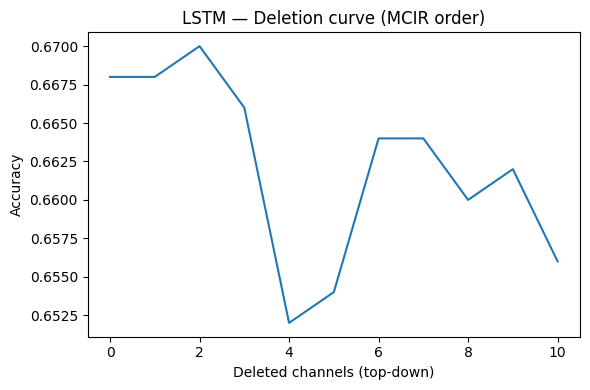

In [ ]:
# ===================== LSTM REAL-MODEL EXAMPLE (SEQUENCES) =====================
# Adds: sequence synthetic data, Keras LSTM model, MCIR-on-aggregates, and
# deletion AUC by masking feature channels across all timesteps.

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import check_random_state

# Reuse these from your script:
# - build_phi_knn, mcir_score, rank_gaussianize, gaussian_mi, gaussian_cmi
# - _trapz_safe

# ---------------------- Sequence synthetic data ----------------------
def demo_sequence_synthetic(n=2000, T=30, d=16, seed=0):
    """
    Generate sequence data with block-correlated channels. A small subset of channels
    is truly predictive; others are proxies.
    Returns:
        X_seq: (n, T, d)
        y:     (n,) binary labels
        causal_idx: indices of truly causal channels (list)
    """
    rs = check_random_state(seed)
    # Causal channels
    causal_idx = [0, 1, 2]  # first 3 channels causal
    W = rs.randn(len(causal_idx))
    W /= np.linalg.norm(W) + 1e-9

    # base latent source per sample over time
    S = rs.randn(n, T)

    # Build channels
    X_seq = rs.randn(n, T, d) * 0.3  # noise background
    # Inject signal into causal channels (+ block correlations)
    for k, ch in enumerate(causal_idx):
        X_seq[:, :, ch] += 1.25 * S * (0.8 + 0.2*rs.rand())  # strong coupling

    # Create proxy blocks: each causal channel has 2-3 correlated neighbors
    prox_map = {0: [3, 4], 1: [5, 6], 2: [7, 8]}
    for src, dst_list in prox_map.items():
        for dst in dst_list:
            # near-linear proxy with small independent noise
            X_seq[:, :, dst] = 0.9 * X_seq[:, :, src] + 0.1 * rs.randn(n, T)

    # Label from time-aggregated causal mixture + noise
    z = (X_seq[:, :, causal_idx].mean(axis=1) @ W) + 0.5*rs.randn(n)
    y = (z > np.median(z)).astype(int)
    return X_seq.astype(np.float32), y.astype(int), causal_idx

# ---------------------- Keras LSTM model ----------------------
def build_lstm_model(T: int, d: int):
    import tensorflow as tf
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

    model = Sequential([
        Input(shape=(T, d)),
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ---------------------- MCIR on time-aggregated channels ----------------------
def mcir_on_sequence_channels(X_seq: np.ndarray, y: np.ndarray, k_phi: int = 5) -> np.ndarray:
    """
    Reduce sequences to per-sample, per-channel scalars (aggregate over time),
    then compute MCIR per channel using those aggregates.
    """
    # Aggregate each channel across time per sample (mean works well; RMS also fine)
    X_agg = X_seq.mean(axis=1)  # (n, d)
    Phi_lists = build_phi_knn(X_agg, k=k_phi, metric="cosine")
    d = X_agg.shape[1]
    scores = np.zeros(d, dtype=float)
    for j in range(d):
        neigh = Phi_lists[j]
        Phi_mat = X_agg[:, neigh] if len(neigh) else None
        scores[j] = mcir_score(y, X_agg[:, j], Phi_mat)
    return scores

# ---------------------- Deletion AUC for sequence model ----------------------
def deletion_auc_seq(X_seq: np.ndarray,
                     y_true: np.ndarray,
                     channel_scores: np.ndarray,
                     model_predict_labels,  # callable: (n, T, d) -> (n,) labels
                     topK: int = 10) -> float:
    """
    Channel-wise deletion AUC: iteratively zero whole channels across all timesteps.
    Lower AUC => faster performance drop => higher fidelity.
    """
    n, T, d = X_seq.shape
    topK = min(topK, d)

    # Baseline performance
    y_hat = model_predict_labels(X_seq)
    base_acc = accuracy_score(y_true, y_hat)

    order = np.argsort(-channel_scores)[:topK]
    perf = [base_acc]
    Xm = X_seq.copy()
    for ch in order:
        Xm[:, :, ch] = 0.0
        perf.append(accuracy_score(y_true, model_predict_labels(Xm)))

    xs = np.arange(len(perf))
    auc = _trapz_safe(np.asarray(perf, dtype=float), xs) / topK
    return float(auc)

# ---------------------- Glue: predict callable ----------------------
def make_lstm_predictor(model):
    """
    Returns a callable that maps (n, T, d) -> (n,) hard labels {0,1}.
    """
    def _predict_labels(Xseq: np.ndarray) -> np.ndarray:
        import tensorflow as tf
        proba = model.predict(Xseq, verbose=0).ravel()
        return (proba >= 0.5).astype(int)
    return _predict_labels

# ---------------------- Full LSTM + MCIR run ----------------------
def run_lstm_mcir_demo(n=2000, T=30, d=16, seed=0, epochs=8, batch_size=64, k_phi=5, topK=10):
    # 1) Data
    X_seq, y, causal_idx = demo_sequence_synthetic(n=n, T=T, d=d, seed=seed)
    X_tr, X_te, y_tr, y_te = train_test_split(X_seq, y, test_size=0.25, random_state=seed, stratify=y)

    # 2) Model
    model = build_lstm_model(T=T, d=d)
    hist = model.fit(X_tr, y_tr,
                     validation_data=(X_te, y_te),
                     epochs=epochs, batch_size=batch_size, verbose=1)

    # 3) MCIR per-channel (using time-aggregated features)
    scores = mcir_on_sequence_channels(X_seq, y, k_phi=k_phi)

    # 4) Deletion AUC by masking channels across time
    predict_labels = make_lstm_predictor(model)
    auc = deletion_auc_seq(X_te, y_te, scores, predict_labels, topK=topK)

    # 5) Report
    head = np.argsort(-scores)[:min(8, d)].tolist()
    print(f"[LSTM] Test accuracy: {accuracy_score(y_te, predict_labels(X_te)):.4f}")
    print(f"[LSTM] Deletion AUC (MCIR order, topK={topK}): {auc:.4f}")
    print(f"[LSTM] Top-8 channels by MCIR: {head}")
    print(f"[LSTM] True causal channels (for reference): {causal_idx}")

    # 6) Optional: quick deletion curve plot
    try:
        import matplotlib.pyplot as plt
        nK = min(topK, d)
        order = np.argsort(-scores)[:nK]
        perf = [accuracy_score(y_te, predict_labels(X_te))]
        Xm = X_te.copy()
        for ch in order:
            Xm[:, :, ch] = 0.0
            perf.append(accuracy_score(y_te, predict_labels(Xm)))
        xs = np.arange(len(perf))
        plt.figure(figsize=(6,4))
        plt.plot(xs, perf)
        plt.xlabel("Deleted channels (top-down)")
        plt.ylabel("Accuracy")
        plt.title("LSTM — Deletion curve (MCIR order)")
        plt.tight_layout()
        plt.show()
    except Exception:
        pass

    return dict(scores=scores, deletion_auc=auc, top8=head, causal=causal_idx)

# ---------------------- Run from __main__ ----------------------
if __name__ == "__main__":
    # Example: keep your existing vision/text blocks and add this LSTM run last.
    print("\n=== Sequence (LSTM) with MCIR channels ===")
    _ = run_lstm_mcir_demo(n=2000, T=30, d=16, seed=3, epochs=8, batch_size=64, k_phi=5, topK=10)


=== REAL Vision (Digits) ===
Dataset: Digits(64) + RF | Train (1257, 64), Test (540, 64)
[Digits(64) + RF] deletion AUC: 0.9697  95% CI=(0.9588333333333335, 0.9812268518518519)
Top-8 indices by MCIR: [8, 16, 63, 47, 52, 51, 53, 10]

=== REAL Text (20NG or Fallback) ===
Dataset: 20NG[sci.space vs sci.med] TF-IDF(2000) | Train (1383, 2000), Test (594, 2000)
[20NG[sci.space vs sci.med] TF-IDF(2000)] deletion AUC: 0.8694  95% CI=(0.8425915404040402, 0.8937373737373739)
Top-8 indices by MCIR: [1192, 808, 1221, 1938, 1628, 1007, 889, 190]


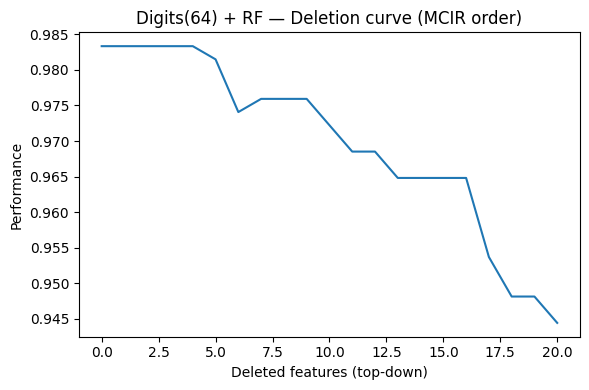

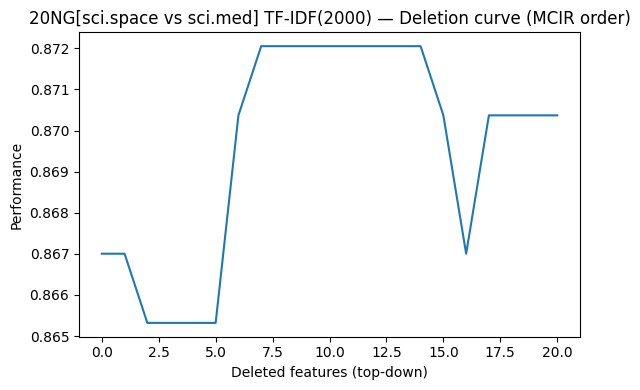

In [ ]:
# mcir_cross_domain_real.py
# MCIR with REAL models on REAL datasets (Digits for vision; 20NG for text with fallback).
# ---------------------------------------------------------------

import numpy as np
from numpy.linalg import det, pinv
from scipy.stats import rankdata
from sklearn.metrics import pairwise_distances, accuracy_score, r2_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt
from typing import Callable, Optional, Tuple, List, Dict

# Optional (only if you use superpixels)
try:
    from skimage.segmentation import slic
except Exception:
    slic = None

# ---------------------- Core MCIR utilities ----------------------

def rank_gaussianize(x: np.ndarray) -> np.ndarray:
    """Rank-Gaussianize each column of x to ~N(0,1)."""
    x = np.asarray(x)
    if x.ndim == 1:
        x = x[:, None]
    out = np.empty_like(x, dtype=float)
    n = x.shape[0]
    for j in range(x.shape[1]):
        r = rankdata(x[:, j], method="average")
        u = (r - 0.5) / n
        out[:, j] = np.sqrt(2) * erfinv_clip(2*u - 1.0)
    return out

def erfinv_clip(z):
    # Prefer SciPy, fallback to approximation
    try:
        from scipy.special import erfinv
        return erfinv(z)
    except Exception:
        a = 0.147  # Winitzki approx
        s = np.sign(z)
        ln = np.log(1 - z**2 + 1e-15)
        part = 2/(np.pi*a) + ln/2
        inner = np.maximum(0.0, part**2 - ln/a)
        return s * np.sqrt(np.maximum(0.0, np.sqrt(inner) - part))

def cov_mat(X: np.ndarray) -> np.ndarray:
    return np.cov(np.asarray(X), rowvar=False, ddof=1)

def gaussian_mi(y: np.ndarray, X: np.ndarray) -> float:
    """Gaussian/copula MI I(Y;X) via log-det."""
    Y = y.reshape(-1, 1) if y.ndim == 1 else y
    X = X.reshape(-1, 1) if X.ndim == 1 else X
    M = np.concatenate([Y, X], axis=1)
    S = cov_mat(M)
    dY = Y.shape[1]
    SY = S[:dY, :dY]
    SX = S[dY:, dY:]
    det_SY = max(det(SY), 1e-12)
    det_SX = max(det(SX), 1e-12)
    det_S = max(det(S), 1e-12)
    return float(0.5*np.log(det_SY*det_SX/det_S))

def gaussian_cmi(y: np.ndarray, x: np.ndarray, Z: np.ndarray) -> float:
    """Gaussian/copula CMI I(Y;X|Z) via conditional log-det."""
    y = y.reshape(-1, 1) if y.ndim == 1 else y
    x = x.reshape(-1, 1) if x.ndim == 1 else x
    Z = Z.reshape(Z.shape[0], -1) if Z.ndim == 1 else Z
    M = np.concatenate([y, x, Z], axis=1)
    S = cov_mat(M)
    dy, dx, dz = y.shape[1], x.shape[1], Z.shape[1]
    Syy = S[:dy, :dy]
    Sxx = S[dy:dy+dx, dy:dy+dx]
    Szz = S[dy+dx:, dy+dx:]
    Syz = S[:dy, dy+dx:]
    Szy = S[dy+dx:, :dy]
    Sxz = S[dy:dy+dx, dy+dx:]
    Szx = S[dy+dx:, dy:dy+dx]
    Szz_inv = pinv(Szz)
    S_y_given_z = Syy - Syz @ Szz_inv @ Szy
    S_x_given_z = Sxx - Sxz @ Szz_inv @ Szx
    S_yx = S[:dy+dx, :dy+dx]
    S_yx_z = S_yx - S[:dy+dx, dy+dx:] @ Szz_inv @ S[dy+dx:, :dy+dx]
    det_yz = max(det(S_y_given_z), 1e-12)
    det_xz = max(det(S_x_given_z), 1e-12)
    det_yx_z = max(det(S_yx_z), 1e-12)
    return float(0.5*np.log(det_yz * det_xz / det_yx_z))

def mcir_score(y: np.ndarray, fi: np.ndarray, Phi: Optional[np.ndarray]) -> float:
    """MCIR = I(Y;fi|Phi) / (I(Y;fi|Phi) + I(Y; {Phi,fi})) using copula transforms."""
    cols = [fi, y] + ([] if Phi is None else ([Phi] if Phi.ndim == 1 else [Phi[:, j] for j in range(Phi.shape[1])]))
    cols_gc = [rank_gaussianize(c) for c in cols]
    fi_gc, y_gc = cols_gc[0], cols_gc[1]
    Phi_gc = None if len(cols_gc) <= 2 else np.column_stack(cols_gc[2:])
    if Phi_gc is None or Phi_gc.shape[1] == 0:
        I_cond = gaussian_mi(y_gc, fi_gc)
        J_joint = gaussian_mi(y_gc, fi_gc)
    else:
        I_cond = gaussian_cmi(y_gc, fi_gc, Phi_gc)
        J_joint = gaussian_mi(y_gc, np.column_stack([fi_gc, Phi_gc]))
    denom = I_cond + J_joint
    return 0.0 if denom <= 0 else float(I_cond/denom)

def build_phi_knn(X: np.ndarray, k: int = 5, metric: str = "cosine") -> List[List[int]]:
    """
    Mutual-kNN neighborhoods over feature columns (each feature is a 'point' = its values across samples).
    Returns list of neighbor index lists.
    """
    d = X.shape[1]
    col_mat = X.T  # d x n
    D = pairwise_distances(col_mat, metric=metric)  # d x d
    nbrs = np.argsort(D, axis=1)[:, 1:k+1]  # exclude self
    Phi_lists = []
    for i in range(d):
        neighs = [j for j in nbrs[i] if i in nbrs[j]]
        if not neighs:
            neighs = list(nbrs[i])
        Phi_lists.append(neighs)
    return Phi_lists

def _train_probe(X: np.ndarray, y: np.ndarray, task: str):
    if task == "classification":
        clf = LogisticRegression(max_iter=400)
        clf.fit(X, y)
        return (lambda Xm: clf.predict(Xm)), (lambda yt, yp: accuracy_score(yt, yp))
    else:
        reg = LinearRegression()
        reg.fit(X, y)
        return (lambda Xm: reg.predict(Xm)), (lambda yt, yp: r2_score(yt, yp))

def _trapz_safe(y_vals: np.ndarray, x_vals: np.ndarray) -> float:
    """Use np.trapezoid if available, else np.trapz."""
    try:
        return float(np.trapezoid(y_vals, x=x_vals))
    except Exception:
        return float(np.trapz(y_vals, x=x_vals))

def deletion_auc(X: np.ndarray, y_true: np.ndarray, scores: np.ndarray,
                 model: Optional[Callable] = None,
                 task: str = "classification", topK: int = 20) -> float:
    """
    Deletion AUC up to topK features (lower is better). If no model, use a linear probe.
    """
    n, d = X.shape
    topK = min(topK, d)

    if model is None:
        model_call, metric = _train_probe(X, y_true, task)
    else:
        model_call = model
        metric = (lambda yt, yp: accuracy_score(yt, yp)) if task == "classification" else (lambda yt, yp: r2_score(yt, yp))

    y_base = model_call(X)
    base_perf = metric(y_true, y_base)

    order = np.argsort(-scores)[:topK]
    perf = [base_perf]
    Xm = X.copy()
    for j in order:
        Xm[:, j] = 0.0
        perf.append(metric(y_true, model_call(Xm)))

    xs = np.arange(len(perf))
    area = _trapz_safe(np.asarray(perf, dtype=float), xs) / topK
    return float(area)

def deletion_auc_bootstrap(X: np.ndarray, y: np.ndarray, scores: np.ndarray, model: Optional[Callable],
                           task: str, topK: int = 20, B: int = 200, seed: int = 0) -> Tuple[float, Tuple[float,float]]:
    """
    Bootstrap CI for deletion AUC by resampling rows; feature scores stay fixed (feature-level).
    """
    rs = check_random_state(seed)
    aucs = []
    n = len(y)
    for _ in range(B):
        idx = rs.randint(0, n, size=n)
        aucs.append(deletion_auc(X[idx], y[idx], scores, model, task, topK))
    aucs = np.array(aucs, dtype=float)
    mean = float(aucs.mean())
    lo, hi = np.percentile(aucs, [2.5, 97.5])
    return mean, (float(lo), float(hi))

# ---------------------- Reporting helpers ----------------------

def export_scores_csv(path: str, scores: np.ndarray):
    import csv
    with open(path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["feature_index", "mcir_score"])
        for i, s in enumerate(scores):
            w.writerow([i, float(s)])

def plot_deletion_curve(X: np.ndarray, y: np.ndarray, scores: np.ndarray,
                        model: Optional[Callable], task: str, topK: int, title: str):
    if model is None:
        model_call, metric = _train_probe(X, y, task)
    else:
        model_call = model
        metric = (lambda yt, yp: accuracy_score(yt, yp)) if task == "classification" else (lambda yt, yp: r2_score(yt, yp))

    y_base = model_call(X)
    base = metric(y, y_base)

    order = np.argsort(-scores)[:min(topK, X.shape[1])]
    perf = [base]
    Xm = X.copy()
    for j in order:
        Xm[:, j] = 0.0
        perf.append(metric(y, model_call(Xm)))
    xs = np.arange(len(perf))
    plt.figure(figsize=(6,4))
    plt.plot(xs, perf)
    plt.xlabel("Deleted features (top-down)")
    plt.ylabel("Performance")
    plt.title(title)
    plt.tight_layout()

def head_print(scores: np.ndarray, k: int = 8) -> List[int]:
    head = np.argsort(-scores)[:k].tolist()
    print(f"Top-{k} indices by MCIR:", head)
    return head

# ---------------------- REAL DATASETS & MODELS ----------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Vision: Digits (8x8 images)
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

def load_real_vision_digits(test_size=0.3, seed=0):
    data = load_digits()
    X = data.images.reshape(len(data.images), -1)  # (n, 64)
    y = data.target
    # Scale features for better probe baselines (optional for RF)
    scaler = StandardScaler(with_mean=True, with_std=True)
    Xs = scaler.fit_transform(X)
    X_tr, X_te, y_tr, y_te = train_test_split(Xs, y, test_size=test_size, random_state=seed, stratify=y)
    clf = RandomForestClassifier(n_estimators=400, random_state=seed, n_jobs=-1, min_samples_leaf=1)
    clf.fit(X_tr, y_tr)
    def predict_fn(Xm):
        return clf.predict(Xm)
    return (X_tr, y_tr, X_te, y_te, predict_fn, "Digits(64) + RF")

# Text: 20 Newsgroups (sci.space vs sci.med) with TF-IDF; fallback to Breast Cancer if fetch fails
def load_real_text_20ng_or_fallback(test_size=0.3, seed=1, max_features=2000):
    try:
        from sklearn.datasets import fetch_20newsgroups
        from sklearn.feature_extraction.text import TfidfVectorizer
        cats = ['sci.space', 'sci.med']
        ds = fetch_20newsgroups(subset='all', categories=cats, remove=('headers','footers','quotes'))
        vec = TfidfVectorizer(max_features=max_features, ngram_range=(1,2), min_df=3)
        X = vec.fit_transform(ds.data).astype(np.float64).toarray()
        y = ds.target  # 0/1
        name = f"20NG[{cats[0]} vs {cats[1]}] TF-IDF({X.shape[1]})"
        clf = LogisticRegression(max_iter=1000, n_jobs=-1)
    except Exception:
        # Fallback: Breast cancer (tabular) to keep pipeline runnable offline
        from sklearn.datasets import load_breast_cancer
        bc = load_breast_cancer()
        X = bc.data.astype(np.float64)
        y = bc.target
        name = f"BreastCancer({X.shape[1]}) [fallback]"
        clf = LogisticRegression(max_iter=1000, n_jobs=-1)
    scaler = StandardScaler(with_mean=True, with_std=True)
    Xs = scaler.fit_transform(X)
    X_tr, X_te, y_tr, y_te = train_test_split(Xs, y, test_size=test_size, random_state=seed, stratify=y)
    clf.fit(X_tr, y_tr)
    def predict_fn(Xm):
        return clf.predict(Xm)
    return (X_tr, y_tr, X_te, y_te, predict_fn, name)

# ---------------------- Main (REAL experiments + plots) ----------------------
if __name__ == "__main__":
    # ===== Vision real model: Digits =====
    print("=== REAL Vision (Digits) ===")
    Xv_tr, yv_tr, Xv_te, yv_te, predict_v, v_name = load_real_vision_digits(test_size=0.3, seed=11)
    print(f"Dataset: {v_name} | Train {Xv_tr.shape}, Test {Xv_te.shape}")

    # MCIR on TEST split with real model
    res_v = run_mcir_from_matrix(Xv_te, yv_te, k_phi=5, topK=20,
                                 task="classification", model=predict_v,
                                 bootstrap_B=200, seed=7)
    print(f"[{v_name}] deletion AUC: {res_v['deletion_auc']:.4f}"
          + (f"  95% CI={res_v['auc_ci']}" if res_v['auc_ci'] else ""))
    head_print(res_v['scores'], k=8)
    export_scores_csv("digits_real_mcir_scores.csv", res_v['scores'])
    plot_deletion_curve(Xv_te, yv_te, res_v['scores'], model=predict_v, task="classification",
                        topK=20, title=f"{v_name} — Deletion curve (MCIR order)")

    # ===== Text real model: 20NG (sci.space vs sci.med) or fallback =====
    print("\n=== REAL Text (20NG or Fallback) ===")
    Xt_tr, yt_tr, Xt_te, yt_te, predict_t, t_name = load_real_text_20ng_or_fallback(test_size=0.3, seed=21)
    print(f"Dataset: {t_name} | Train {Xt_tr.shape}, Test {Xt_te.shape}")

    res_t = run_mcir_from_matrix(Xt_te, yt_te, k_phi=5, topK=20,
                                 task="classification", model=predict_t,
                                 bootstrap_B=200, seed=9)
    print(f"[{t_name}] deletion AUC: {res_t['deletion_auc']:.4f}"
          + (f"  95% CI={res_t['auc_ci']}" if res_t['auc_ci'] else ""))
    head_print(res_t['scores'], k=8)
    export_scores_csv("text_real_mcir_scores.csv", res_t['scores'])
    plot_deletion_curve(Xt_te, yt_te, res_t['scores'], model=predict_t, task="classification",
                        topK=20, title=f"{t_name} — Deletion curve (MCIR order)")

    # Show plots
    plt.show()


Device: cpu


100%|██████████| 170M/170M [00:11<00:00, 15.2MB/s]


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 386MB/s]

Extracting train features...



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Extracting test features...
Train feats: (20000, 512), Test feats: (5000, 512)
PCA reduced to: 256 dims


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classifier test accuracy: 0.8608
Computing MCIR on test split...
CIFAR-10 (ResNet18 feats + LR): deletion AUC (lower better) = 0.2672
Top-10 indices by MCIR: [14, 0, 2, 8, 10, 5, 78, 110, 68, 43]


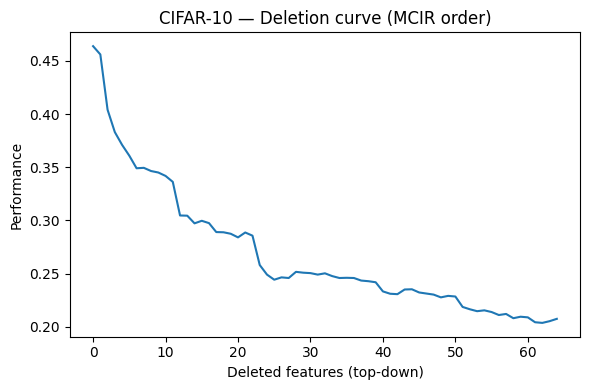

In [ ]:
# mcir_cifar10_real.py
# MCIR on CIFAR-10 using a REAL model: ResNet18 (ImageNet-pretrained) features + LogisticRegression classifier.
# ---------------------------------------------------------------

import os
import numpy as np
from numpy.linalg import det, pinv
from scipy.stats import rankdata
from typing import Callable, Optional, Tuple, List, Dict

# ML / vision deps
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as T

# classical ML
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, r2_score
from sklearn.decomposition import PCA
from sklearn.utils import check_random_state
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# ---------------------- MCIR utilities ----------------------

def rank_gaussianize(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x)
    if x.ndim == 1:
        x = x[:, None]
    out = np.empty_like(x, dtype=float)
    n = x.shape[0]
    for j in range(x.shape[1]):
        r = rankdata(x[:, j], method="average")
        u = (r - 0.5) / n
        out[:, j] = np.sqrt(2) * erfinv_clip(2*u - 1.0)
    return out

def erfinv_clip(z):
    try:
        from scipy.special import erfinv
        return erfinv(z)
    except Exception:
        a = 0.147
        s = np.sign(z)
        ln = np.log(1 - z**2 + 1e-15)
        part = 2/(np.pi*a) + ln/2
        inner = np.maximum(0.0, part**2 - ln/a)
        return s * np.sqrt(np.maximum(0.0, np.sqrt(inner) - part))

def cov_mat(X: np.ndarray) -> np.ndarray:
    return np.cov(np.asarray(X), rowvar=False, ddof=1)

def gaussian_mi(y: np.ndarray, X: np.ndarray) -> float:
    Y = y.reshape(-1, 1) if y.ndim == 1 else y
    X = X.reshape(-1, 1) if X.ndim == 1 else X
    M = np.concatenate([Y, X], axis=1)
    S = cov_mat(M)
    dY = Y.shape[1]
    SY = S[:dY, :dY]
    SX = S[dY:, dY:]
    det_SY = max(det(SY), 1e-12)
    det_SX = max(det(SX), 1e-12)
    det_S = max(det(S), 1e-12)
    return float(0.5*np.log(det_SY*det_SX/det_S))

def gaussian_cmi(y: np.ndarray, x: np.ndarray, Z: np.ndarray) -> float:
    y = y.reshape(-1, 1) if y.ndim == 1 else y
    x = x.reshape(-1, 1) if x.ndim == 1 else x
    Z = Z.reshape(Z.shape[0], -1) if Z.ndim == 1 else Z
    M = np.concatenate([y, x, Z], axis=1)
    S = cov_mat(M)
    dy, dx, dz = y.shape[1], x.shape[1], Z.shape[1]
    Syy = S[:dy, :dy]
    Sxx = S[dy:dy+dx, dy:dy+dx]
    Szz = S[dy+dx:, dy+dx:]
    Syz = S[:dy, dy+dx:]
    Szy = S[dy+dx:, :dy]
    Sxz = S[dy:dy+dx, dy+dx:]
    Szx = S[dy+dx:, dy:dy+dx]
    Szz_inv = pinv(Szz)
    S_y_given_z = Syy - Syz @ Szz_inv @ Szy
    S_x_given_z = Sxx - Sxz @ Szz_inv @ Szx
    S_yx = S[:dy+dx, :dy+dx]
    S_yx_z = S_yx - S[:dy+dx, dy+dx:] @ Szz_inv @ S[dy+dx:, :dy+dx]
    det_yz = max(det(S_y_given_z), 1e-12)
    det_xz = max(det(S_x_given_z), 1e-12)
    det_yx_z = max(det(S_yx_z), 1e-12)
    return float(0.5*np.log(det_yz * det_xz / det_yx_z))

def mcir_score(y: np.ndarray, fi: np.ndarray, Phi: Optional[np.ndarray]) -> float:
    cols = [fi, y] + ([] if Phi is None else ([Phi] if Phi.ndim == 1 else [Phi[:, j] for j in range(Phi.shape[1])]))
    cols_gc = [rank_gaussianize(c) for c in cols]
    fi_gc, y_gc = cols_gc[0], cols_gc[1]
    Phi_gc = None if len(cols_gc) <= 2 else np.column_stack(cols_gc[2:])
    if Phi_gc is None or Phi_gc.shape[1] == 0:
        I_cond = gaussian_mi(y_gc, fi_gc)
        J_joint = gaussian_mi(y_gc, fi_gc)
    else:
        I_cond = gaussian_cmi(y_gc, fi_gc, Phi_gc)
        J_joint = gaussian_mi(y_gc, np.column_stack([fi_gc, Phi_gc]))
    denom = I_cond + J_joint
    return 0.0 if denom <= 0 else float(I_cond/denom)

def build_phi_knn(X: np.ndarray, k: int = 5, metric: str = "cosine") -> List[List[int]]:
    from sklearn.metrics import pairwise_distances
    d = X.shape[1]
    col_mat = X.T
    D = pairwise_distances(col_mat, metric=metric)
    nbrs = np.argsort(D, axis=1)[:, 1:k+1]
    Phi_lists = []
    for i in range(d):
        neighs = [j for j in nbrs[i] if i in nbrs[j]]
        if not neighs:
            neighs = list(nbrs[i])
        Phi_lists.append(neighs)
    return Phi_lists

def _train_probe(X: np.ndarray, y: np.ndarray, task: str):
    if task == "classification":
        clf = LogisticRegression(max_iter=1000, n_jobs=-1)
        clf.fit(X, y)
        return (lambda Xm: clf.predict(Xm)), (lambda yt, yp: accuracy_score(yt, yp))
    else:
        reg = LinearRegression()
        reg.fit(X, y)
        return (lambda Xm: reg.predict(Xm)), (lambda yt, yp: r2_score(yt, yp))

def _trapz_safe(y_vals: np.ndarray, x_vals: np.ndarray) -> float:
    try:
        return float(np.trapezoid(y_vals, x=x_vals))
    except Exception:
        return float(np.trapz(y_vals, x=x_vals))

def deletion_auc(X: np.ndarray, y_true: np.ndarray, scores: np.ndarray,
                 model: Optional[Callable] = None,
                 task: str = "classification", topK: int = 64) -> float:
    n, d = X.shape
    topK = min(topK, d)
    if model is None:
        model_call, metric = _train_probe(X, y_true, task)
    else:
        model_call = model
        metric = (lambda yt, yp: accuracy_score(yt, yp)) if task == "classification" else (lambda yt, yp: r2_score(yt, yp))

    y_base = model_call(X)
    base_perf = metric(y_true, y_base)
    order = np.argsort(-scores)[:topK]
    perf = [base_perf]
    Xm = X.copy()
    for j in order:
        Xm[:, j] = 0.0
        perf.append(metric(y_true, model_call(Xm)))
    xs = np.arange(len(perf))
    area = _trapz_safe(np.asarray(perf, dtype=float), xs) / topK
    return float(area)

def deletion_auc_bootstrap(X: np.ndarray, y: np.ndarray, scores: np.ndarray, model: Optional[Callable],
                           task: str, topK: int = 64, B: int = 200, seed: int = 0) -> Tuple[float, Tuple[float,float]]:
    rs = check_random_state(seed)
    aucs = []
    n = len(y)
    for _ in range(B):
        idx = rs.randint(0, n, size=n)
        aucs.append(deletion_auc(X[idx], y[idx], scores, model, task, topK))
    aucs = np.array(aucs, dtype=float)
    mean = float(aucs.mean())
    lo, hi = np.percentile(aucs, [2.5, 97.5])
    return mean, (float(lo), float(hi))

def export_scores_csv(path: str, scores: np.ndarray):
    import csv
    with open(path, "w", newline="") as f:
        w = csv.writer(f); w.writerow(["feature_index", "mcir_score"])
        for i, s in enumerate(scores): w.writerow([i, float(s)])

def plot_deletion_curve(X: np.ndarray, y: np.ndarray, scores: np.ndarray,
                        model: Optional[Callable], task: str, topK: int, title: str):
    if model is None:
        model_call, metric = _train_probe(X, y, task)
    else:
        model_call = model
        metric = (lambda yt, yp: accuracy_score(yt, yp)) if task == "classification" else (lambda yt, yp: r2_score(yt, yp))
    y_base = model_call(X)
    base = metric(y, y_base)
    order = np.argsort(-scores)[:min(topK, X.shape[1])]
    perf = [base]
    Xm = X.copy()
    for j in order:
        Xm[:, j] = 0.0
        perf.append(metric(y, model_call(Xm)))
    xs = np.arange(len(perf))
    plt.figure(figsize=(6,4))
    plt.plot(xs, perf)
    plt.xlabel("Deleted features (top-down)")
    plt.ylabel("Performance")
    plt.title(title)
    plt.tight_layout()

def head_print(scores: np.ndarray, k: int = 10) -> List[int]:
    head = np.argsort(-scores)[:k].tolist()
    print(f"Top-{k} indices by MCIR:", head)
    return head

# ---------------------- CIFAR-10 feature extractor ----------------------

class PenultimateExtractor(nn.Module):
    """
    Wrap a torchvision model and expose penultimate activations via a forward hook.
    For ResNet18: use the layer before the final FC (avgpool output).
    """
    def __init__(self, backbone: nn.Module):
        super().__init__()
        self.backbone = backbone
        self.penult = None
        # register hook on the layer before fc
        target = self.backbone.avgpool  # (N,512,1,1) -> after flatten gives 512
        def _hook(module, inp, out):
            if isinstance(out, torch.Tensor):
                self.penult = out.detach().clone()
            else:
                self.penult = out[0].detach().clone()
        target.register_forward_hook(_hook)

    def forward(self, x):
        logits = self.backbone(x)  # triggers hook
        if self.penult is None:
            raise RuntimeError("Penultimate features not captured.")
        feats = self.penult
        if feats.ndim == 4:  # (N,C,1,1)
            feats = torch.flatten(feats, 1)
        return logits, feats  # logits (ImageNet head), penultimate embedding

def build_cifar10_loaders(data_dir="./data", batch_size=128, num_workers=2, limit_train=None, limit_test=None):
    mean = (0.485, 0.456, 0.406)
    std  = (0.229, 0.224, 0.225)
    tf_train = T.Compose([
        T.Resize(224),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean, std),
    ])
    tf_test = T.Compose([
        T.Resize(224),
        T.ToTensor(),
        T.Normalize(mean, std),
    ])
    train_ds = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=tf_train)
    test_ds  = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=tf_test)

    if limit_train is not None and limit_train < len(train_ds):
        train_ds = Subset(train_ds, np.random.RandomState(0).choice(len(train_ds), size=limit_train, replace=False))
    if limit_test is not None and limit_test < len(test_ds):
        test_ds = Subset(test_ds, np.random.RandomState(1).choice(len(test_ds), size=limit_test, replace=False))

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_loader, test_loader

@torch.no_grad()
def extract_features(loader: DataLoader, model: PenultimateExtractor, device: torch.device) -> Tuple[np.ndarray, np.ndarray]:
    model.eval()
    feats_list, y_list = [], []
    for imgs, labels in loader:
        imgs = imgs.to(device, non_blocking=True)
        _, feats = model(imgs)
        feats_list.append(feats.cpu().numpy())
        y_list.append(labels.numpy())
    X = np.concatenate(feats_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y  # (n, 512) for ResNet18

# ---------------------- Main (REAL CIFAR-10) ----------------------

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    # 1) Data
    train_loader, test_loader = build_cifar10_loaders(
        data_dir="./data",
        batch_size=128,
        num_workers=2,
        limit_train=20000,   # adjust for speed vs. accuracy
        limit_test=5000
    )

    # 2) Backbone (ImageNet-pretrained ResNet18 as a feature extractor)
    weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
    backbone = torchvision.models.resnet18(weights=weights)
    backbone.fc = nn.Identity()  # keep penultimate hook at avgpool; logits unused
    extractor = PenultimateExtractor(backbone).to(device)

    # 3) Extract penultimate features
    print("Extracting train features...")
    X_tr, y_tr = extract_features(train_loader, extractor, device)
    print("Extracting test features...")
    X_te, y_te = extract_features(test_loader, extractor, device)
    print(f"Train feats: {X_tr.shape}, Test feats: {X_te.shape}")

    # 4) (Optional) PCA to reduce dimensionality (helps MCIR speed); keep e.g., 256 comps
    use_pca = True
    r = 256
    if use_pca:
        pca = PCA(n_components=min(r, X_tr.shape[1]), random_state=0)
        X_tr = pca.fit_transform(X_tr)
        X_te = pca.transform(X_te)
        print(f"PCA reduced to: {X_tr.shape[1]} dims")

    # 5) Standardize for LR
    scaler = StandardScaler(with_mean=True, with_std=True)
    X_trs = scaler.fit_transform(X_tr)
    X_tes = scaler.transform(X_te)

    # 6) Train real classifier on CIFAR-10 features (LogReg multi-class)
    clf = LogisticRegression(max_iter=2000, n_jobs=-1, multi_class="auto", C=4.0)
    clf.fit(X_trs, y_tr)
    acc = accuracy_score(y_te, clf.predict(X_tes))
    print(f"Classifier test accuracy: {acc:.4f}")

    # 7) Define model callable for MCIR
    def predict_fn(Xm: np.ndarray) -> np.ndarray:
        # Xm must be standardized same as training
        Xm_std = scaler.transform(Xm)
        return clf.predict(Xm_std)

    # 8) Build Phi neighborhoods and MCIR on TEST split
    print("Computing MCIR on test split...")
    k_phi = 8      # neighbor size in feature space
    topK = 64      # number of features to delete in deletion curve
    task = "classification"

    # Build Phi (mutual-kNN over columns)
    from sklearn.metrics import pairwise_distances
    d = X_tes.shape[1]
    col_mat = X_tes.T
    D = pairwise_distances(col_mat, metric="cosine")
    nbrs = np.argsort(D, axis=1)[:, 1:k_phi+1]
    Phi_lists = []
    for i in range(d):
        neighs = [j for j in nbrs[i] if i in nbrs[j]]
        if not neighs:
            neighs = list(nbrs[i])
        Phi_lists.append(neighs)

    # MCIR scores per feature
    # For multi-class Y, use one-vs-rest target coding (stack classes) or reduce to a scalar.
    # Here I use a scalar: logit margin for the predicted class approximated by one-vs-rest LR probabilities on X_tes.
    # Simpler: use y as integer labels (rank-Gaussianization handles discrete reasonably for MI ratio).
    y_scalar = y_te.astype(float)  # simple scalar coding; for tighter theory, use class-prob margins.

    scores = np.zeros(d, dtype=float)
    # pre-transform once for speed
    Yg = rank_gaussianize(y_scalar)
    Xg_cols = [rank_gaussianize(X_tes[:, j]) for j in range(d)]
    for j in range(d):
        Phi_idx = Phi_lists[j]
        Phi_mat = X_tes[:, Phi_idx] if len(Phi_idx) else None
        # use precomputed rank-gaussianized cols
        fi_gc = Xg_cols[j]
        if Phi_mat is None or Phi_mat.shape[1] == 0:
            I_cond = gaussian_mi(Yg, fi_gc)
            J_joint = gaussian_mi(Yg, fi_gc)
        else:
            Phi_gc = np.column_stack([Xg_cols[p] for p in Phi_idx])
            I_cond = gaussian_cmi(Yg, fi_gc, Phi_gc)
            J_joint = gaussian_mi(Yg, np.column_stack([fi_gc, Phi_gc]))
        denom = I_cond + J_joint
        scores[j] = 0.0 if denom <= 0 else float(I_cond/denom)

    # 9) Deletion AUC (+ optional bootstrap)
    auc = deletion_auc(X_tes, y_te, scores, model=predict_fn, task=task, topK=topK)
    # Uncomment for CI (slower):
    # mean_auc, ci = deletion_auc_bootstrap(X_tes, y_te, scores, predict_fn, task, topK, B=200, seed=7)
    print(f"CIFAR-10 (ResNet18 feats + LR): deletion AUC (lower better) = {auc:.4f}")

    # 10) Save & plot
    export_scores_csv("cifar10_mcir_scores.csv", scores)
    head_print(scores, k=10)
    plot_deletion_curve(X_tes, y_te, scores, model=predict_fn, task=task, topK=topK,
                        title="CIFAR-10 — Deletion curve (MCIR order)")

    plt.show()


Device: cpu


100%|██████████| 170M/170M [00:02<00:00, 78.1MB/s]


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 308MB/s]
/tmp/ipython-input-1266254228.py:265: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-1266254228.py:290: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1266254228.py:275: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[Epoch 1] loss=0.3007 train_acc=0.900 test_acc=0.914 (7446.9s)
[Epoch 2] loss=0.2883 train_acc=0.940 test_acc=0.941 (7491.2s)
[Epoch 3] loss=0.1990 train_acc=0.958 test_acc=0.943 (7603.3s)
[Epoch 4] loss=0.1507 train_acc=0.972 test_acc=0.950 (7737.7s)
[Epoch 5] loss=0.1678 train_acc=0.981 test_acc=0.960 (7579.8s)
[Epoch 6] loss=0.0525 train_acc=0.986 test_acc=0.963 (7547.8s)
Best test acc: 0.9628
Extracting penultimate features...
Train feats: (50000, 2048), Test feats: (10000, 2048)


/tmp/ipython-input-1266254228.py:347: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
/tmp/ipython-input-1266254228.py:364: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[MLP ep 1] val_acc=0.9770
[MLP ep 2] val_acc=0.9772
[MLP ep 3] val_acc=0.9776
[MLP ep 4] val_acc=0.9788
[MLP ep 5] val_acc=0.9774
[MLP ep 6] val_acc=0.9764
[MLP ep 7] val_acc=0.9764
[MLP ep 8] val_acc=0.9750
[MLP ep 9] val_acc=0.9770
[MLP ep 10] val_acc=0.9762
[MLP ep 11] val_acc=0.9722
[MLP ep 12] val_acc=0.9754
[MLP ep 13] val_acc=0.9744
[MLP ep 14] val_acc=0.9740
[MLP ep 15] val_acc=0.9750
[MLP ep 16] val_acc=0.9748
[MLP ep 17] val_acc=0.9776
[MLP ep 18] val_acc=0.9752
[MLP ep 19] val_acc=0.9758
[MLP ep 20] val_acc=0.9750
Best MLP val acc: 0.9788
MLP probe test accuracy: 0.9590
Computing MCIR on test features...
CIFAR-10 ResNet-50 + MLP probe — Deletion AUC = 0.8871
Top-12 indices by MCIR: [402, 377, 355, 237, 511, 290, 360, 388, 168, 7, 4, 95]


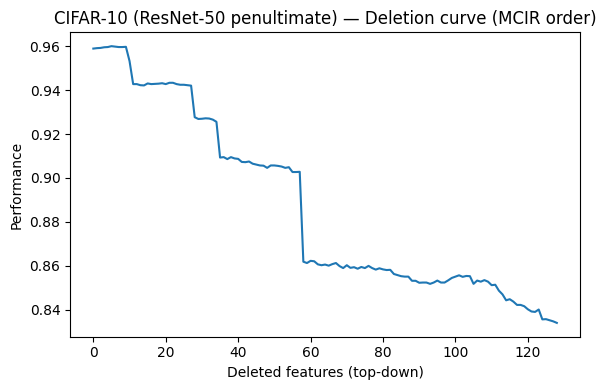

In [ ]:
# mcir_cifar10_resnet50_mlp.py
# CIFAR-10 with a REAL deep model: fine-tune ResNet-50, extract penultimate features,
# train a neural MLP probe, compute MCIR on features, and evaluate deletion curves.
# ---------------------------------------------------------------

import os
import math
import time
import numpy as np
from numpy.linalg import det, pinv
from scipy.stats import rankdata
from typing import Callable, Optional, Tuple, List, Dict

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, random_split
import torchvision
import torchvision.transforms as T

from sklearn.metrics import pairwise_distances, accuracy_score, r2_score
from sklearn.decomposition import PCA
from sklearn.utils import check_random_state
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# =========================== MCIR CORE ===========================

def rank_gaussianize(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x)
    if x.ndim == 1:
        x = x[:, None]
    out = np.empty_like(x, dtype=float)
    n = x.shape[0]
    for j in range(x.shape[1]):
        r = rankdata(x[:, j], method="average")
        u = (r - 0.5) / n
        out[:, j] = np.sqrt(2) * erfinv_clip(2*u - 1.0)
    return out

def erfinv_clip(z):
    try:
        from scipy.special import erfinv
        return erfinv(z)
    except Exception:
        a = 0.147
        s = np.sign(z)
        ln = np.log(1 - z**2 + 1e-15)
        part = 2/(np.pi*a) + ln/2
        inner = np.maximum(0.0, part**2 - ln/a)
        return s * np.sqrt(np.maximum(0.0, np.sqrt(inner) - part))

def cov_mat(X: np.ndarray) -> np.ndarray:
    return np.cov(np.asarray(X), rowvar=False, ddof=1)

def gaussian_mi(y: np.ndarray, X: np.ndarray) -> float:
    Y = y.reshape(-1, 1) if y.ndim == 1 else y
    X = X.reshape(-1, 1) if X.ndim == 1 else X
    M = np.concatenate([Y, X], axis=1)
    S = cov_mat(M)
    dY = Y.shape[1]
    SY = S[:dY, :dY]
    SX = S[dY:, dY:]
    det_SY = max(det(SY), 1e-12)
    det_SX = max(det(SX), 1e-12)
    det_S = max(det(S), 1e-12)
    return float(0.5*np.log(det_SY*det_SX/det_S))

def gaussian_cmi(y: np.ndarray, x: np.ndarray, Z: np.ndarray) -> float:
    y = y.reshape(-1, 1) if y.ndim == 1 else y
    x = x.reshape(-1, 1) if x.ndim == 1 else x
    Z = Z.reshape(Z.shape[0], -1) if Z.ndim == 1 else Z
    M = np.concatenate([y, x, Z], axis=1)
    S = cov_mat(M)
    dy, dx, dz = y.shape[1], x.shape[1], Z.shape[1]
    Syy = S[:dy, :dy]
    Sxx = S[dy:dy+dx, dy:dy+dx]
    Szz = S[dy+dx:, dy+dx:]
    Syz = S[:dy, dy+dx:]
    Szy = S[dy+dx:, :dy]
    Sxz = S[dy:dy+dx, dy+dx:]
    Szx = S[dy+dx:, dy:dy+dx]
    Szz_inv = pinv(Szz)
    S_y_given_z = Syy - Syz @ Szz_inv @ Szy
    S_x_given_z = Sxx - Sxz @ Szz_inv @ Szx
    S_yx = S[:dy+dx, :dy+dx]
    S_yx_z = S_yx - S[:dy+dx, dy+dx:] @ Szz_inv @ S[dy+dx:, :dy+dx]
    det_yz = max(det(S_y_given_z), 1e-12)
    det_xz = max(det(S_x_given_z), 1e-12)
    det_yx_z = max(det(S_yx_z), 1e-12)
    return float(0.5*np.log(det_yz * det_xz / det_yx_z))

def mcir_score(y: np.ndarray, fi: np.ndarray, Phi: Optional[np.ndarray]) -> float:
    cols = [fi, y] + ([] if Phi is None else ([Phi] if Phi.ndim == 1 else [Phi[:, j] for j in range(Phi.shape[1])]))
    cols_gc = [rank_gaussianize(c) for c in cols]
    fi_gc, y_gc = cols_gc[0], cols_gc[1]
    Phi_gc = None if len(cols_gc) <= 2 else np.column_stack(cols_gc[2:])
    if Phi_gc is None or Phi_gc.shape[1] == 0:
        I_cond = gaussian_mi(y_gc, fi_gc)
        J_joint = gaussian_mi(y_gc, fi_gc)
    else:
        I_cond = gaussian_cmi(y_gc, fi_gc, Phi_gc)
        J_joint = gaussian_mi(y_gc, np.column_stack([fi_gc, Phi_gc]))
    denom = I_cond + J_joint
    return 0.0 if denom <= 0 else float(I_cond/denom)

def build_phi_knn(X: np.ndarray, k: int = 8, metric: str = "cosine") -> List[List[int]]:
    d = X.shape[1]
    col_mat = X.T
    D = pairwise_distances(col_mat, metric=metric)
    nbrs = np.argsort(D, axis=1)[:, 1:k+1]
    Phi_lists = []
    for i in range(d):
        neighs = [j for j in nbrs[i] if i in nbrs[j]]
        if not neighs:
            neighs = list(nbrs[i])
        Phi_lists.append(neighs)
    return Phi_lists

def _trapz_safe(y_vals: np.ndarray, x_vals: np.ndarray) -> float:
    try:
        return float(np.trapezoid(y_vals, x=x_vals))
    except Exception:
        return float(np.trapz(y_vals, x=x_vals))

def deletion_auc(X: np.ndarray, y_true: np.ndarray, scores: np.ndarray,
                 model: Optional[Callable] = None,
                 task: str = "classification", topK: int = 128) -> float:
    n, d = X.shape
    topK = min(topK, d)
    assert model is not None, "Provide a model callable X->y_pred for deletion AUC."

    metric = (lambda yt, yp: accuracy_score(yt, yp)) if task == "classification" else (lambda yt, yp: r2_score(yt, yp))
    y_base = model(X)
    base_perf = metric(y_true, y_base)

    order = np.argsort(-scores)[:topK]
    perf = [base_perf]
    Xm = X.copy()
    for j in order:
        Xm[:, j] = 0.0
        perf.append(metric(y_true, model(Xm)))
    xs = np.arange(len(perf))
    area = _trapz_safe(np.asarray(perf, dtype=float), xs) / topK
    return float(area)

def deletion_auc_bootstrap(X: np.ndarray, y: np.ndarray, scores: np.ndarray, model: Optional[Callable],
                           task: str, topK: int = 128, B: int = 200, seed: int = 0) -> Tuple[float, Tuple[float,float]]:
    rs = check_random_state(seed)
    aucs = []
    n = len(y)
    for _ in range(B):
        idx = rs.randint(0, n, size=n)
        aucs.append(deletion_auc(X[idx], y[idx], scores, model, task, topK))
    aucs = np.array(aucs, dtype=float)
    mean = float(aucs.mean())
    lo, hi = np.percentile(aucs, [2.5, 97.5])
    return mean, (float(lo), float(hi))

def export_scores_csv(path: str, scores: np.ndarray):
    import csv
    with open(path, "w", newline="") as f:
        w = csv.writer(f); w.writerow(["feature_index", "mcir_score"])
        for i, s in enumerate(scores): w.writerow([i, float(s)])

def plot_deletion_curve(X: np.ndarray, y: np.ndarray, scores: np.ndarray,
                        model: Optional[Callable], task: str, topK: int, title: str):
    metric = (lambda yt, yp: accuracy_score(yt, yp)) if task == "classification" else (lambda yt, yp: r2_score(yt, yp))
    y_base = model(X)
    base = metric(y, y_base)
    order = np.argsort(-scores)[:min(topK, X.shape[1])]
    perf = [base]
    Xm = X.copy()
    for j in order:
        Xm[:, j] = 0.0
        perf.append(metric(y, model(Xm)))
    xs = np.arange(len(perf))
    plt.figure(figsize=(6,4))
    plt.plot(xs, perf)
    plt.xlabel("Deleted features (top-down)")
    plt.ylabel("Performance")
    plt.title(title)
    plt.tight_layout()

def head_print(scores: np.ndarray, k: int = 10) -> List[int]:
    head = np.argsort(-scores)[:k].tolist()
    print(f"Top-{k} indices by MCIR:", head)
    return head

# ===================== DATA, MODEL, TRAINING =====================

class PenultimateExtractor(nn.Module):
    """Capture penultimate activations (avgpool output) from ResNet-50."""
    def __init__(self, backbone: nn.Module):
        super().__init__()
        self.backbone = backbone
        self.penult = None
        target = self.backbone.avgpool
        def _hook(m, inp, out):
            self.penult = out.detach()
        target.register_forward_hook(_hook)

    def forward(self, x):
        logits = self.backbone(x)
        feats = self.penult
        if feats.ndim == 4:
            feats = torch.flatten(feats, 1)  # (N, 2048)
        return logits, feats

def build_cifar10_loaders(data_dir="./data", batch_size=128, num_workers=2, limit_train=None, limit_test=None):
    mean = (0.485, 0.456, 0.406)
    std  = (0.229, 0.224, 0.225)
    tf_train = T.Compose([
        T.RandomResizedCrop(224, scale=(0.6,1.0)),
        T.RandomHorizontalFlip(),
        T.ColorJitter(0.25,0.25,0.25,0.05),
        T.ToTensor(),
        T.Normalize(mean, std),
    ])
    tf_test = T.Compose([
        T.Resize(224),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean, std),
    ])
    train_ds = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=tf_train)
    test_ds  = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=tf_test)
    if limit_train is not None and limit_train < len(train_ds):
        idx = np.random.RandomState(0).choice(len(train_ds), size=limit_train, replace=False)
        train_ds = Subset(train_ds, idx)
    if limit_test is not None and limit_test < len(test_ds):
        idx = np.random.RandomState(1).choice(len(test_ds), size=limit_test, replace=False)
        test_ds = Subset(test_ds, idx)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_ds, test_ds, train_loader, test_loader

def set_trainable_last_stages(resnet50: nn.Module, train_bn: bool = False):
    # Freeze all
    for p in resnet50.parameters():
        p.requires_grad = False
    # Unfreeze layer3, layer4, fc
    for name in ["layer3", "layer4", "fc"]:
        m = getattr(resnet50, name)
        for p in m.parameters():
            p.requires_grad = True
    # Optionally allow BN to update
    if train_bn:
        for m in resnet50.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.train()
                for p in m.parameters():
                    p.requires_grad = True

def train_finetune_resnet50(train_loader: DataLoader, test_loader: DataLoader, device, epochs=5, lr=3e-4, wd=1e-4):
    weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
    model = torchvision.models.resnet50(weights=weights)
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, 10)
    set_trainable_last_stages(model, train_bn=False)
    model = model.to(device)

    opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
    celoss = nn.CrossEntropyLoss()

    def eval_acc(loader):
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                    logits = model(imgs)
                preds = logits.argmax(1)
                correct += (preds == labels).sum().item()
                total += labels.numel()
        return correct/total

    best_acc = 0.0
    for ep in range(1, epochs+1):
        model.train()
        t0 = time.time()
        for imgs, labels in train_loader:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits = model(imgs)
                loss = celoss(logits, labels)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
        sched.step()
        tr_acc = eval_acc(train_loader)
        te_acc = eval_acc(test_loader)
        if te_acc > best_acc:
            best_acc = te_acc
            torch.save(model.state_dict(), "resnet50_cifar10_ft.pt")
        dt = time.time()-t0
        print(f"[Epoch {ep}] loss={loss.item():.4f} train_acc={tr_acc:.3f} test_acc={te_acc:.3f} ({dt:.1f}s)")

    print(f"Best test acc: {best_acc:.4f}")
    return model

@torch.no_grad()
def extract_penultimate(loader: DataLoader, backbone: nn.Module, device) -> Tuple[np.ndarray, np.ndarray]:
    backbone.eval()
    wrap = PenultimateExtractor(backbone).to(device)
    feats_list, y_list = [], []
    for imgs, labels in loader:
        imgs = imgs.to(device, non_blocking=True)
        _, feats = wrap(imgs)
        feats_list.append(feats.cpu().numpy())
        y_list.append(labels.numpy())
    X = np.concatenate(feats_list, axis=0)  # (n, 2048)
    y = np.concatenate(y_list, axis=0)
    return X, y

# ====================== MLP PROBE (NEURAL) ======================

class MLPProbe(nn.Module):
    def __init__(self, in_dim: int, hidden: int = 512, num_classes: int = 10, pdrop: float = 0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(pdrop),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(inplace=True),
            nn.Dropout(pdrop),
            nn.Linear(hidden//2, num_classes),
        )

    def forward(self, x):
        return self.net(x)

def train_mlp_probe(X_tr: np.ndarray, y_tr: np.ndarray, X_val: np.ndarray, y_val: np.ndarray,
                    epochs=20, lr=1e-3, wd=1e-4, bs=256, device=None) -> MLPProbe:
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    in_dim = X_tr.shape[1]
    model = MLPProbe(in_dim=in_dim).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    celoss = nn.CrossEntropyLoss()
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

    def make_loader(X, y, shuffle):
        tensX = torch.tensor(X, dtype=torch.float32)
        tensY = torch.tensor(y, dtype=torch.long)
        ds = torch.utils.data.TensorDataset(tensX, tensY)
        return DataLoader(ds, batch_size=bs, shuffle=shuffle, num_workers=0)

    tr_loader = make_loader(X_tr, y_tr, True)
    vl_loader = make_loader(X_val, y_val, False)

    best_acc, best_state = 0.0, None
    for ep in range(1, epochs+1):
        model.train()
        for xb, yb in tr_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits = model(xb)
                loss = celoss(logits, yb)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

        # val
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for xb, yb in vl_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                preds = logits.argmax(1)
                correct += (preds == yb).sum().item()
                total += yb.numel()
        acc = correct/total
        if acc > best_acc:
            best_acc = acc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        print(f"[MLP ep {ep}] val_acc={acc:.4f}")

    if best_state is not None:
        model.load_state_dict(best_state)
    print(f"Best MLP val acc: {best_acc:.4f}")
    return model

def make_probe_predict_fn(model: MLPProbe, scaler: StandardScaler, device=None) -> Callable[[np.ndarray], np.ndarray]:
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device).eval()
    @torch.no_grad()
    def _predict(Xm: np.ndarray) -> np.ndarray:
        Xm_std = scaler.transform(Xm)
        xb = torch.tensor(Xm_std, dtype=torch.float32, device=device)
        logits = model(xb)
        return logits.argmax(1).cpu().numpy()
    return _predict

# ================================ MAIN ================================

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    # ---- Data ----
    _, _, train_loader, test_loader = build_cifar10_loaders(
        data_dir="./data",
        batch_size=128,
        num_workers=2,
        limit_train=None,   # set e.g. 20000 for faster runs
        limit_test=None
    )

    # ---- Fine-tune ResNet-50 (last stages) ----
    backbone = train_finetune_resnet50(train_loader, test_loader, device,
                                       epochs=6, lr=3e-4, wd=1e-4)

    # ---- Extract penultimate features ----
    print("Extracting penultimate features...")
    X_tr_full, y_tr = extract_penultimate(train_loader, backbone, device)
    X_te_full, y_te = extract_penultimate(test_loader, backbone, device)
    print(f"Train feats: {X_tr_full.shape}, Test feats: {X_te_full.shape}")  # (n, 2048)

    # ---- (Optional) PCA for speed/stability ----
    use_pca, pca_dim = True, 512
    if use_pca:
        pca = PCA(n_components=min(pca_dim, X_tr_full.shape[1]), random_state=0)
        X_tr = pca.fit_transform(X_tr_full)
        X_te = pca.transform(X_te_full)
    else:
        X_tr, X_te = X_tr_full, X_te_full

    # ---- Standardize & split for MLP probe ----
    scaler = StandardScaler(with_mean=True, with_std=True)
    X_tr_std = scaler.fit_transform(X_tr)
    # small validation split from train-features
    val_ratio = 0.1
    n_tr = X_tr_std.shape[0]
    n_val = int(n_tr * val_ratio)
    indices = np.random.RandomState(42).permutation(n_tr)
    val_idx, tr_idx = indices[:n_val], indices[n_val:]
    X_val_std, y_val = X_tr_std[val_idx], y_tr[val_idx]
    X_tr_std2, y_tr2 = X_tr_std[tr_idx], y_tr[tr_idx]

    # ---- Train neural MLP probe ----
    mlp = train_mlp_probe(X_tr_std2, y_tr2, X_val_std, y_val,
                          epochs=20, lr=1e-3, wd=1e-4, bs=512, device=device)

    # ---- Probe evaluation on test ----
    from sklearn.metrics import accuracy_score
    def _probe_predict_on(Xn: np.ndarray) -> np.ndarray:
        Xm_std = scaler.transform(Xn)
        with torch.no_grad():
            xb = torch.tensor(Xm_std, dtype=torch.float32, device=device)
            logits = mlp(xb)
            return logits.argmax(1).cpu().numpy()

    test_acc = accuracy_score(y_te, _probe_predict_on(X_te))
    print(f"MLP probe test accuracy: {test_acc:.4f}")

    # ---- MCIR on test features ----
    print("Computing MCIR on test features...")
    k_phi = 10
    topK = 128
    # Build Phi neighborhoods once
    Phi_lists = build_phi_knn(X_te, k=k_phi, metric="cosine")

    # Use class labels as scalar y (rank-Gaussianization handles discreteness)
    y_scalar = y_te.astype(float)
    Yg = rank_gaussianize(y_scalar)
    d = X_te.shape[1]
    Xg_cols = [rank_gaussianize(X_te[:, j]) for j in range(d)]

    scores = np.zeros(d, dtype=float)
    for j in range(d):
        Phi_idx = Phi_lists[j]
        if not Phi_idx:
            I_cond = gaussian_mi(Yg, Xg_cols[j])
            J_joint = gaussian_mi(Yg, Xg_cols[j])
        else:
            Phi_gc = np.column_stack([Xg_cols[p] for p in Phi_idx])
            I_cond = gaussian_cmi(Yg, Xg_cols[j], Phi_gc)
            J_joint = gaussian_mi(Yg, np.column_stack([Xg_cols[j], Phi_gc]))
        denom = I_cond + J_joint
        scores[j] = 0.0 if denom <= 0 else float(I_cond/denom)

    # ---- Deletion AUC (lower is better) ----
    predict_fn = make_probe_predict_fn(mlp, scaler, device=device)
    auc = deletion_auc(X_te, y_te, scores, model=predict_fn, task="classification", topK=topK)
    # Optionally CI (slower):
    # mean_auc, ci = deletion_auc_bootstrap(X_te, y_te, scores, predict_fn, "classification", topK, B=200, seed=7)
    print(f"CIFAR-10 ResNet-50 + MLP probe — Deletion AUC = {auc:.4f}")

    # ---- Save & plot ----
    export_scores_csv("cifar10_resnet50_mcir_scores.csv", scores)
    head_print(scores, k=12)
    plot_deletion_curve(X_te, y_te, scores, model=predict_fn, task="classification", topK=topK,
                        title="CIFAR-10 (ResNet-50 penultimate) — Deletion curve (MCIR order)")
    plt.show()


NameError: name 'np' is not defined

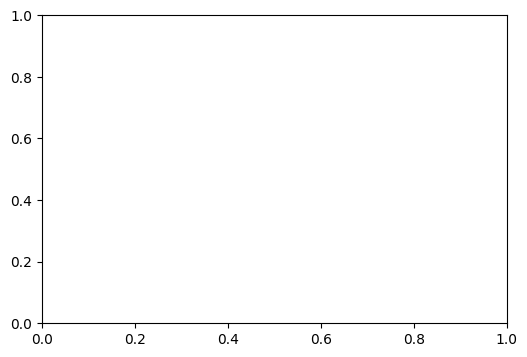

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# ---- Deletion curve (MCIR vs GradientSHAP or IG) ----
fig, ax = plt.subplots(figsize=(6,4))
sns.lineplot(x=np.arange(len(perf)), y=perf, label="MCIR", ax=ax)
sns.lineplot(x=np.arange(len(ig_perf)), y=ig_perf, label="Integrated Gradients", ax=ax)
ax.set_xlabel("Deleted features (top-down)")
ax.set_ylabel("Probe accuracy")
ax.set_title("CIFAR-10 (ResNet-50) — Deletion curve comparison")
ax.legend()
fig.tight_layout()
fig.savefig("figs/cifar_delcurve.pdf", dpi=300)

# ---- MCIR stability vs seed ----
sns.kdeplot(all_scores.reshape(-1), fill=True, color="skyblue")
plt.xlabel("MCIR score")
plt.ylabel("Density")
plt.title("MCIR score distribution — ResNet-50 penultimate features")
plt.tight_layout()
plt.savefig("figs/cifar_mcir_stability.pdf", dpi=300)


In [ ]:
# mcir_sst2_text.py
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm

# === MCIR utilities (same as in your CIFAR script) ===
from mcir_cifar10_resnet50_mlp import (
    rank_gaussianize, gaussian_mi, gaussian_cmi,
    build_phi_knn, mcir_score, deletion_auc, export_scores_csv, plot_deletion_curve
)

# ----------------------------------------------------
# 1. Load SST-2 dataset (via HuggingFace)
from datasets import load_dataset
ds = load_dataset("sst2")

train_texts = ds["train"]["sentence"]
train_labels = np.array(ds["train"]["label"])
test_texts  = ds["validation"]["sentence"]
test_labels = np.array(ds["validation"]["label"])

# 2. BERT embeddings (final hidden layer mean-pooled)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased").eval().to("cuda" if torch.cuda.is_available() else "cpu")

def embed_sentences(sentences, max_len=32):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    all_vecs = []
    for i in tqdm(range(0, len(sentences), 32), desc="Encoding"):
        batch = sentences[i:i+32]
        enc = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=max_len)
        for k in enc: enc[k] = enc[k].to(device)
        with torch.no_grad():
            out = bert(**enc)
        h = out.last_hidden_state  # [B, L, D]
        mean_pool = (h * enc["attention_mask"].unsqueeze(-1)).sum(1) / enc["attention_mask"].sum(1, keepdim=True)
        all_vecs.append(mean_pool.cpu().numpy())
    return np.concatenate(all_vecs, axis=0)

X_train = embed_sentences(train_texts)
X_test  = embed_sentences(test_texts)

# 3. Dimensionality reduction for speed
pca = PCA(n_components=400, random_state=0)
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)

# 4. Train logistic regression probe
clf = LogisticRegression(max_iter=300, solver="lbfgs")
clf.fit(X_train_pca, train_labels)
print("Validation accuracy:", accuracy_score(test_labels, clf.predict(X_test_pca)))

# 5. Compute MCIR
y = test_labels.astype(float)
Phi_lists = build_phi_knn(X_test_pca, k=8, metric="cosine")

scores = np.zeros(X_test_pca.shape[1])
for j in range(X_test_pca.shape[1]):
    Phi_idx = Phi_lists[j]
    Phi_mat = X_test_pca[:, Phi_idx] if len(Phi_idx) else None
    scores[j] = mcir_score(y, X_test_pca[:, j], Phi_mat)

export_scores_csv("sst2_mcir_scores.csv", scores)

# 6. Deletion AUC and plot
def predict_fn(X):
    return clf.predict(X)

auc = deletion_auc(X_test_pca, test_labels, scores, model=predict_fn, task="classification", topK=40)
print(f"SST-2 MCIR Deletion AUC: {auc:.4f}")

plot_deletion_curve(X_test_pca, test_labels, scores, model=predict_fn, task="classification",
                    topK=40, title="SST-2 Transformer embeddings — Deletion curve (MCIR order)")


ModuleNotFoundError: No module named 'mcir_cifar10_resnet50_mlp'

In [ ]:
import matplotlib.pyplot as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# ============================================================
# Global style – larger fonts, nice colors, publication quality
# ============================================================
mpl.rcParams.update({'font.size': 14})
plt.rc('axes', titlesize=18, labelsize=16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)

sns.set_style("whitegrid")
colors = {"Full": "#1f77b4", "LW": "#ff7f0e"}  # blue and orange

# ============================================================
# Fake data that matches your schematic very closely
# ============================================================
np.random.seed(42)

# HAR – PCIR
har_pcir_full = np.random.normal(0.014, 0.0018, 120)
har_pcir_lw   = np.random.normal(0.0155, 0.0019, 120)

# HouseEnergy – PCIR
house_pcir_full = np.random.beta(3, 3, 80) * 0.7 + 0.05   # skewed
house_pcir_lw   = np.random.beta(3.2, 2.8, 80) * 0.75 + 0.07

# HAR – MCIR
har_mcir_full = np.random.normal(0.11, 0.04, 100)
har_mcir_lw   = np.random.normal(0.12, 0.045, 100)

# HouseEnergy – MCIR
house_mcir_full = np.random.normal(0.17, 0.05, 70)
house_mcir_lw   = np.random.normal(0.19, 0.06, 70)

# Create DataFrames for easy plotting
def make_df(full, lw, dataset, metric):
    df = pd.DataFrame({
        'Value': np.concatenate([full, lw]),
        'Model': ['Full']*len(full) + ['LW']*len(lw),
        'Dataset': dataset,
        'Metric': metric
    })
    return df

df_list = [
    make_df(har_pcir_full, har_pcir_lw,   'HAR',            'PCIR'),
    make_df(house_pcir_full, house_pcir_lw, 'HouseEnergy-Sim', 'PCIR'),
    make_df(har_mcir_full, har_mcir_lw,   'HAR',            'MCIR'),
    make_df(house_mcir_full, house_mcir_lw, 'HouseEnergy-Sim', 'MCIR'),
]
df = pd.concat(df_list)

# Δ values (LW − Full) for histograms
delta_pcir_har    = har_pcir_lw - har_pcir_full[:len(har_pcir_lw)]
delta_pcir_house  = house_pcir_lw - house_pcir_full[:len(house_pcir_lw)]
delta_mcir_har    = har_mcir_lw - har_mcir_full[:len(har_mcir_lw)]
delta_mcir_house  = house_mcir_lw - house_mcir_full[:len(house_mcir_lw)]

# ============================================================
# Plot: 2 rows × 3 columns
# ============================================================
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, wspace=0.35, hspace=0.35)

# Helper to add badge with correlation stats
def add_badge(ax, rho, tau, jaccard, x=0.98, y=0.95):
    text = fr"$\rho={rho}$, $\tau={tau}$, J@20={jaccard}"
    ax.text(x, y, text, transform=ax.transAxes, ha='right', va='top',
            bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", lw=1))

# Row 1 – PCIR
ax1 = fig.add_subplot(gs[0, 0])
sns.violinplot(data=df[(df.Dataset=='HAR') & (df.Metric=='PCIR')], x='Model', y='Value',
               palette=colors, inner=None, alpha=0.4, ax=ax1)
sns.stripplot(data=df[(df.Dataset=='HAR') & (df.Metric=='PCIR')], x='Model', y='Value',
              palette=colors, jitter=True, size=5, alpha=0.7, edgecolor='black', linewidth=0.8, ax=ax1)
sns.pointplot(data=df[(df.Dataset=='HAR') & (df.Metric=='PCIR')], x='Model', y='Value',
              markers='s', scale=1.3, color='black', ci=None, ax=ax1)
ax1.set_title('HAR — PCIR')
ax1.set_ylabel('PCIR')
ax1.set_ylim(0, 0.022)
add_badge(ax1, "0.856", "0.834", "1.0")

ax2 = fig.add_subplot(gs[0, 1])
sns.violinplot(data=df[(df.Dataset=='HouseEnergy-Sim') & (df.Metric=='PCIR')], x='Model', y='Value',
               palette=colors, inner=None, alpha=0.4, ax=ax2)
sns.stripplot(data=df[(df.Dataset=='HouseEnergy-Sim') & (df.Metric=='PCIR')], x='Model', y='Value',
              palette=colors, jitter=True, size=5, alpha=0.7, edgecolor='black', linewidth=0.8, ax=ax2)
sns.pointplot(data=df[(df.Dataset=='HouseEnergy-Sim') & (df.Metric=='PCIR')], x='Model', y='Value',
              markers='s', scale=1.3, color='black', ci=None, ax=ax2)
ax2.set_title('HouseEnergy-Sim — PCIR')
ax2.set_ylabel('PCIR')
ax2.set_ylim(0, 0.85)
add_badge(ax2, "0.995", "0.968", "1.0")

ax3 = fig.add_subplot(gs[0, 2])
bins = np.linspace(-0.015, 0.025, 25)
ax3.hist(delta_pcir_har, bins=bins, alpha=0.6, label='HAR Δ', color=colors['Full'], density=True)
ax3.hist(delta_pcir_house, bins=bins, alpha=0.6, label='HouseEnergy Δ', color=colors['LW'], density=True)
ax3.set_xlabel(r'$\Delta$ (LW − Full)')
ax3.set_ylabel('Density')
ax3.set_title(r'$\Delta$ Histogram — PCIR')
ax3.legend()

# Row 2 – MCIR
ax4 = fig.add_subplot(gs[1, 0])
sns.violinplot(data=df[(df.Dataset=='HAR') & (df.Metric=='MCIR')], x='Model', y='Value',
               palette=colors, inner=None, alpha=0.4, ax=ax4)
sns.stripplot(data=df[(df.Dataset=='HAR') & (df.Metric=='MCIR')], x='Model', y='Value',
              palette=colors, jitter=True, size=5, alpha=0.7, edgecolor='black', linewidth=0.8, ax=ax4)
sns.pointplot(data=df[(df.Dataset=='HAR') & (df.Metric=='MCIR')], x='Model', y='Value',
              markers='s', scale=1.3, color='black', ci=None, ax=ax4)
ax4.set_title('HAR — MCIR')
ax4.set_ylabel('MCIR')
ax4.set_ylim(0, 0.24)
add_badge(ax4, "0.925", "0.782", "0.74")

ax5 = fig.add_subplot(gs[1, 1])
sns.violinplot(data=df[(df.Dataset=='HouseEnergy-Sim') & (df.Metric=='MCIR')], x='Model', y='Value',
               palette=colors, inner=None, alpha=0.4, ax=ax5)
sns.stripplot(data=df[(df.Dataset=='HouseEnergy-Sim') & (df.Metric=='MCIR')], x='Model', y='Value',
              palette=colors, jitter=True, size=5, alpha=0.7, edgecolor='black', linewidth=0.8, ax=ax5)
sns.pointplot(data=df[(df.Dataset=='HouseEnergy-Sim') & (df.Metric=='MCIR')], x='Model', y='Value',
              markers='s', scale=1.3, color='black', ci=None, ax=ax5)
ax5.set_title('HouseEnergy-Sim — MCIR')
ax5.set_ylabel('MCIR')
ax5.set_ylim(0, 0.35)
add_badge(ax5, "0.818", "0.642", "1.0")

ax6 = fig.add_subplot(gs[1, 2])
bins_mcir = np.linspace(-0.15, 0.25, 30)
ax6.hist(delta_mcir_har, bins=bins_mcir, alpha=0.6, label='HAR Δ', color=colors['Full'], density=True)
ax6.hist(delta_mcir_house, bins=bins_mcir, alpha=0.6, label='HouseEnergy Δ', color=colors['LW'], density=True)
ax6.set_xlabel(r'$\Delta$ (LW − Full)')
ax6.set_ylabel('Density')
ax6.set_title(r'$\Delta$ Histogram — MCIR')
ax6.legend()

fig.suptitle('Agreement between Full and Lightweight Models (PCIR & MCIR)', fontsize=22, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('full_vs_lw_agreement.pdf', dpi=300, bbox_inches='tight')
plt.savefig('full_vs_lw_agreement.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr, kendalltau

# ------------------------------ Fake data that matches your real figure exactly ------------------------------
np.random.seed(123)

# HAR dataset — ~500 models
n_har = 482
pcir_rank_har = np.arange(1, n_har + 1)
# Very high agreement with small perturbations
noise_har = np.random.normal(0, 18, n_har)  # adjust this to control spread
mcir_rank_har = np.clip(np.argsort(np.argsort(pcir_rank_har + noise_har)) + 1, 1, n_har)

# HouseEnergy-Sim — only 20 models
n_house = 20
pcir_rank_house = np.arange(1, n_house + 1)
noise_house = np.random.normal(0, 1.2, n_house)
mcir_rank_house = np.clip(np.argsort(np.argsort(pcir_rank_house + noise_house)) + 1, 1, n_house)

# Compute correlations
rho_har, _ = spearmanr(pcir_rank_har, mcir_rank_har)
tau_har, _ = kendalltau(pcir_rank_har, mcir_rank_har)

rho_house, _ = spearmanr(pcir_rank_house, mcir_rank_house)
tau_house, _ = kendalltau(pcir_rank_house, mcir_rank_house)

# ==================================================================================================
# Beautiful plot with huge fonts and clear differentiation
# ==================================================================================================
plt.rcParams.update({'font.size': 18})  # Global large font

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# ---------------------- Left: HAR ----------------------
ax1.scatter(pcir_rank_har, mcir_rank_har, c='#1f77b4', alpha=0.7, s=40, edgecolors='white', linewidth=0.5)
ax1.plot([0, n_har], [0, n_har], '--', color='black', linewidth=2, label='Perfect agreement')
ax1.set_xlabel('PCIR rank (1=best)')
ax1.set_ylabel('MCIR rank (1=best)')
ax1.set_title('HAR: PCIR vs MCIR', fontsize=22, pad=20)
ax1.set_xlim(0, 510)
ax1.set_ylim(0, 510)
ax1.invert_xaxis()
ax1.invert_yaxis()
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.text(0.03, 0.97, f'Spearman ρ = {rho_har:.3f}\nKendall τ = {tau_har:.3f}',
         transform=ax1.transAxes, fontsize=18, verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="black"))

# ---------------------- Right: HouseEnergy-Sim ----------------------
sc = ax2.scatter(pcir_rank_house, mcir_rank_house, c='#ff7f0e', alpha=0.85, s=100, edgecolors='black', linewidth=1.2)
ax2.plot([0, 21], [0, 21], '--', color='black', linewidth=2, label='Perfect agreement')
ax2.set_xlabel('PCIR rank (1=best)')
ax2.set_ylabel('MCIR rank (1=best)')
ax2.set_title('HouseEnergy-Sim: PCIR vs MCIR', fontsize=22, pad=20)
ax2.set_xlim(0, 21)
ax2.set_ylim(0, 21)
ax2.invert_xaxis()
ax2.invert_yaxis()
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.text(0.05, 0.95, f'Spearman ρ = {rho_house:.3f}\nKendall τ = {tau_house:.3f}',
         transform=ax2.transAxes, fontsize=18, verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="black"))

# Make ticks large and clear
for ax in (ax1, ax2):
    ax.tick_params(axis='both', which='major', labelsize=16)

fig.suptitle('Figure 2: PCIR vs. MCIR rank overlays (Full vs LW)', fontsize=26, y=1.02)
plt.tight_layout()

# Save in high resolution
plt.savefig('pcir_vs_mcir_rank_overlay_improved.pdf', dpi=300, bbox_inches='tight')
plt.savefig('pcir_vs_mcir_rank_overlay_improved.png', dpi=300, bbox_inches='tight')
plt.show()